# **CNN Sequencial vs CNN Ramificada — Qual Arquitetura é Mais Eficaz para Classificação de Compra e Venda de Ativos?**

*Desenvolvido como parte do MBA em Data Science & AI da FIAP, sob orientação do professor [Felipe Teodoro](https://www.linkedin.com/in/teodorofelipe/).*

## **Importação de Bibliotecas**

Importação das bibliotecas para visualização, manipulação de dados, avaliação de desempenho e construção dos modelos de deep learning. Também foi definida uma seed para garantir a reprodutibilidade dos experimentos.

In [1]:
!git clone https://github.com/luizh3nriqu3/data-science-projects.git

Cloning into 'data-science-projects'...
remote: Enumerating objects: 23949, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 23949 (delta 1), reused 12 (delta 1), pack-reused 23936 (from 2)
Receiving objects: 100% (23949/23949), 120.97 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [2]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 4.9 MB/s eta 0:00:00


In [3]:
# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Manipulação
import numpy as np
import pandas as pd
import os
import math
from datetime import datetime
import random
from itertools import product
import optuna

# Métricas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

# DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam



# Configuração de seed para reprodutibilidade
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

## **Importação da Base**

Descompactação dos arquivos ZIP e leitura dos conjuntos de treino e teste para cada ativo, além da série histórica do CDI no período de teste. Os dados abrangem 20 anos de registros diários, com milhares de observações por ativo. Cada linha representa um dia de negociação e já está rotulada como “compra” ou “venda”, com base na variação de preço do ativo.



In [4]:
zip_files = [
    "/content/data-science-projects/deep-learning/data/BBAS3.SA.zip",
    "/content/data-science-projects/deep-learning/data/CSNA3.SA.zip",
    "/content/data-science-projects/deep-learning/data/PETR4.SA.zip",
    "/content/data-science-projects/deep-learning/data/VALE3.SA.zip",
    "/content/data-science-projects/deep-learning/data/CDI.zip"
]

for zip_file in zip_files:
    folder_name = zip_file.replace(".zip", "")
    if not os.path.exists(folder_name):
        os.makedirs(folder_name, exist_ok=True)
        !unzip -o -j "{zip_file}" -d "{folder_name}"
        print(f"Descompactado: {zip_file}")
    else:
        print(f"Já está descompactado: {zip_file}")


Archive:  /content/data-science-projects/deep-learning/data/BBAS3.SA.zip
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/._BBAS3.SA  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/.DS_Store  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/._.DS_Store  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/visualizacao.html  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/teste.csv  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/treino.csv  
Descompactado: /content/data-science-projects/deep-learning/data/BBAS3.SA.zip
Archive:  /content/data-science-projects/deep-learning/data/CSNA3.SA.zip
  inflating: /content/data-science-projects/deep-learning/data/CSNA3.SA/._CSNA3.SA  
  inflating: /content/data-science-projects/deep-learning/data/CSNA3.SA/.DS_Store  
  inflating: /content/data-science-projects/deep-learning/data/CSNA3.SA/._.DS_Store  
  inf

In [5]:
def load_data(path):
    df_train = pd.read_csv(os.path.join(path, "treino.csv"))
    df_test = pd.read_csv(os.path.join(path, "teste.csv"))
    return df_train, df_test

In [6]:
## BBAS3
bb_train, bb_test = load_data("/content/data-science-projects/deep-learning/data/BBAS3.SA")

## CSNA3
cs_train, cs_test = load_data("/content/data-science-projects/deep-learning/data/CSNA3.SA")

## PETR4
pe_train, pe_test = load_data("/content/data-science-projects/deep-learning/data/PETR4.SA")

## VALE3
vl_train, vl_test = load_data("/content/data-science-projects/deep-learning/data/VALE3.SA")

## CDI
cdi = pd.read_csv("/content/data-science-projects/deep-learning/data/CDI/CDI.csv")

In [7]:
for col in cdi.columns:
    if col != "Ano":
        cdi[col] = (
            cdi[col]
            .astype(str)
            .str.replace(",", ".")
            .replace("---", None)
            .astype(float)
        )


In [8]:
df_bb = pd.concat([bb_train, bb_test], ignore_index=True)
df_cs = pd.concat([cs_train, cs_test], ignore_index=True)
df_pe = pd.concat([pe_train, pe_test], ignore_index=True)
df_vl = pd.concat([vl_train, vl_test], ignore_index=True)

In [9]:
df_bb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5920 entries, 0 to 5919
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          5920 non-null   int64  
 1   Date                5920 non-null   object 
 2   Close               5920 non-null   float64
 3   Smoothed_Close      5920 non-null   float64
 4   Label               5920 non-null   int64  
 5   Past_1_Days_Close   5920 non-null   float64
 6   Past_2_Days_Close   5920 non-null   float64
 7   Past_3_Days_Close   5920 non-null   float64
 8   Past_4_Days_Close   5920 non-null   float64
 9   Past_5_Days_Close   5920 non-null   float64
 10  Past_6_Days_Close   5920 non-null   float64
 11  Past_7_Days_Close   5920 non-null   float64
 12  Past_8_Days_Close   5920 non-null   float64
 13  Past_9_Days_Close   5920 non-null   float64
 14  Past_10_Days_Close  5920 non-null   float64
 15  Past_11_Days_Close  5920 non-null   float64
 16  Past_1

## **EDA**

Da análise exploratória dos dados, vale ressaltar dois pontos principais:

**Distribuição das Classes**: As classes de "compra" e "venda" possuem uma distribuição bastante equilibrada, com a classe "venda" sendo, em média, 10% mais frequente do que a classe "compra".

**Variação nos Preços dos Ativos**: A variação no preço de fechamento dos ativos é bastante alta, refletindo o comportamento comum dos mercados financeiros. O desvio padrão variou consideravelmente entre os diferentes ativos, como segue:

* BBAS3: 11.87
* CSNA3: 6.22
* PETR4: 5.72
* VALE3: 21.44

A VALE3 se destaca como o ativo com maior volatilidade, o que pode impactar diretamente o desempenho dos modelos preditivos. Já PETR4 e CSNA3 apresentam oscilações mais moderadas, o que pode facilitar a modelagem.

### **Funções de Visualização**

In [10]:
def freq_class(dfs_dict, target):
    num_dfs = len(dfs_dict)
    cols = 2
    rows = math.ceil(num_dfs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    freq_list = []

    custom_palette = {'Vende': '#1f77b4', 'Compra': '#005082'}

    for i, (df_name, df) in enumerate(dfs_dict.items()):
        df_temp = df.copy()
        df_temp[target] = df_temp[target].map({-1: 'Vende', 1: 'Compra'})

        freq = df_temp[target].value_counts().sort_index().reset_index()
        freq.columns = ['Classe', 'Frequência']
        freq_list.append((df_name, freq))

        total = freq['Frequência'].sum()
        ax = axes[i]

        sns.barplot(
            data=freq,
            x='Classe',
            y='Frequência',
            hue='Classe',
            palette=custom_palette,
            legend=False,
            ax=ax
        )

        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{(height/total*100):.1f}%',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10)

        ax.set_title(f'Distribuição de {target} - {df_name}')
        ax.set_xlabel('Classe')
        ax.set_ylabel('Frequência')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return freq_list


In [11]:
def plot_boxplot(dfs_dict, coluna):
    num_dfs = len(dfs_dict)
    cols = 2
    rows = math.ceil(num_dfs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for i, (df_name, df) in enumerate(dfs_dict.items()):
        ax = axes[i]

        sns.boxplot(data=df, x=coluna, ax=ax, color='#1f77b4')

        ax.set_title(f'Boxplot de {coluna} - {df_name}')
        ax.set_xlabel(f'{coluna}')
        ax.set_ylabel('Valor')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [12]:
def plot_sell_buy(dfs_dict, coluna='Close', buy_label=1, sell_label=-1, titles=None):
    n = len(dfs_dict)
    cols = 2
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 5 * rows))

    axes = axes.flatten()

    if titles is None:
        titles = [f"Preço da Ação - {df_name}" for df_name in dfs_dict.keys()]

    for i, (df_name, df) in enumerate(dfs_dict.items()):
        ax = axes[i]
        prices = df[coluna]
        labels = df['Label']

        days = np.arange(1, len(df) + 1)

        buy_signals = np.where(labels == buy_label)[0]
        sell_signals = np.where(labels == sell_label)[0]

        ax.plot(days, prices, label='Preço de Fechamento', color='blue', linewidth=1.5)

        ax.scatter(days[buy_signals], prices[buy_signals], color='green', label='Compra', marker='^', s=50, zorder=5)

        ax.scatter(days[sell_signals], prices[sell_signals], color='red', label='Venda', marker='v', s=50, zorder=5)

        ax.set_title(titles[i])
        ax.set_xlabel('Dia')
        ax.set_ylabel('Preço da Ação')
        ax.grid(True)
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


### **Análise**

In [13]:
df_bb.describe()

Unnamed: 0        Close  Smoothed_Close        Label  \
count  5920.000000  5920.000000     5920.000000  5920.000000   
mean   2960.500000    14.761421       14.681130    -0.111824   
std    1709.101128    11.865241       11.741245     0.993812   
min       1.000000     0.720744        0.761192    -1.000000   
25%    1480.750000     5.558903        5.535033    -1.000000   
50%    2960.500000    11.911848       11.842960    -1.000000   
75%    4440.250000    22.434348       22.431682     1.000000   
max    5920.000000    55.389999       53.886008     1.000000   

       Past_1_Days_Close  Past_2_Days_Close  Past_3_Days_Close  \
count        5920.000000        5920.000000        5920.000000   
mean           14.752248          14.743164          14.734067   
std            11.854812          11.844673          11.834472   
min             0.720744           0.720744           0.720744   
25%             5.557920           5.554970           5.553660   
50%            11.911763          11.911730          11.909445   
75%            22.388165          22.365896          22.355012   
max            54.939999          54.939999          54.849998   

       Past_4_Days_Close  Past_5_Days_Close  Past_6_Days_Close  \
count        5920.000000        5920.000000        5920.000000   
mean           14.725057          14.716067          14.707089   
std            11.824538          11.814680          11.804853   
min             0.720744           0.720744           0.720744   
25%             5.549074           5.547108           5.546125   
50%            11.905674          11.900006          11.894433   
75%            22.344869          22.339785          22.336385   
max            54.849998          54.849998          54.849998   

       Past_7_Days_Close  Past_8_Days_Close  Past_9_Days_Close  \
count        5920.000000        5920.000000        5920.000000   
mean           14.698003          14.688954          14.679910   
std            11.794646          11.784535          11.774433   
min             0.720744           0.720744           0.720744   
25%             5.543177           5.543177           5.542194   
50%            11.892644          11.891959          11.891438   
75%            22.330932          22.326367          22.322783   
max            54.650002          54.610001          54.107632   

       Past_10_Days_Close  Past_11_Days_Close  Past_12_Days_Close  \
count         5920.000000         5920.000000         5920.000000   
mean            14.671084           14.662308           14.653617   
std             11.765036           11.755828           11.746866   
min              0.720744            0.720744            0.720744   
25%              5.538591            5.534987            5.530072   
50%             11.891142           11.890991           11.890800   
75%             22.310926           22.297836           22.283448   
max             54.107632           54.107632           54.107632   

       Past_13_Days_Close  Past_14_Days_Close  Past_15_Days_Close  
count         5920.000000         5920.000000         5920.000000  
mean            14.644653           14.635686           14.626825  
std             11.737004           11.727123           11.717543  
min              0.720744            0.720744            0.720744  
25%              5.530072            5.529417            5.524504  
50%             11.888769           11.884154           11.879745  
75%             22.279699           22.274225           22.246293  
max             54.107632           54.038074           54.038074

In [14]:
df_cs.describe()

Unnamed: 0        Close  Smoothed_Close        Label  \
count  5929.000000  5929.000000     5929.000000  5929.000000   
mean   2965.000000     7.549661        7.524796    -0.127678   
std    1711.699204     6.224718        6.174392     0.991899   
min       1.000000     0.574565        0.634654    -1.000000   
25%    1483.000000     3.283195        3.275598    -1.000000   
50%    2965.000000     5.809213        5.801865    -1.000000   
75%    4447.000000    10.660500       10.617571     1.000000   
max    5929.000000    39.173981       36.485040     1.000000   

       Past_1_Days_Close  Past_2_Days_Close  Past_3_Days_Close  \
count        5929.000000        5929.000000        5929.000000   
mean            7.546577           7.543536           7.540528   
std             6.223247           6.221805           6.220403   
min             0.574565           0.574565           0.574565   
25%             3.279624           3.278073           3.278073   
50%             5.808665           5.805315           5.791012   
75%            10.660500          10.656814          10.656814   
max            39.173981          39.173981          39.173981   

       Past_4_Days_Close  Past_5_Days_Close  Past_6_Days_Close  \
count        5929.000000        5929.000000        5929.000000   
mean            7.537569           7.534624           7.531778   
std             6.219071           6.217752           6.216649   
min             0.574565           0.574565           0.574565   
25%             3.273487           3.273487           3.267829   
50%             5.784355           5.782325           5.780795   
75%            10.638167          10.638167          10.627732   
max            39.173981          39.173981          39.173981   

       Past_7_Days_Close  Past_8_Days_Close  Past_9_Days_Close  \
count        5929.000000        5929.000000        5929.000000   
mean            7.528884           7.526047           7.523307   
std             6.215442           6.214259           6.213208   
min             0.574565           0.574565           0.574565   
25%             3.263257           3.259848           3.259165   
50%             5.780795           5.780188           5.779645   
75%            10.621877          10.616808          10.616808   
max            39.173981          39.173981          39.173981   

       Past_10_Days_Close  Past_11_Days_Close  Past_12_Days_Close  \
count         5929.000000         5929.000000         5929.000000   
mean             7.520651            7.518006            7.515426   
std              6.212262            6.211341            6.210517   
min              0.574565            0.574565            0.574565   
25%              3.253027            3.252463            3.247573   
50%              5.777541            5.774158            5.772930   
75%             10.613861           10.613861           10.605713   
max             39.173981           39.173981           39.173981   

       Past_13_Days_Close  Past_14_Days_Close  Past_15_Days_Close  
count         5929.000000         5929.000000         5929.000000  
mean             7.512835            7.510217            7.507635  
std              6.209706            6.208892            6.208141  
min              0.574565            0.574565            0.574565  
25%              3.247528            3.247528            3.246890  
50%              5.771044            5.767956            5.767956  
75%             10.605713           10.605686           10.605686  
max             39.173981           39.173981           39.173981

In [15]:
df_pe.describe()

Unnamed: 0        Close  Smoothed_Close        Label  \
count  6011.000000  6011.000000     6011.000000  6011.000000   
mean   3006.000000     7.045491        6.993755    -0.076360   
std    1735.370566     5.724169        5.596997     0.997163   
min       1.000000     1.080224        1.200894    -1.000000   
25%    1503.500000     2.998180        3.024373    -1.000000   
50%    3006.000000     6.011217        6.010069    -1.000000   
75%    4508.500000     8.831341        8.800386     1.000000   
max    6011.000000    37.360001       35.910318     1.000000   

       Past_1_Days_Close  Past_2_Days_Close  Past_3_Days_Close  \
count        6011.000000        6011.000000        6011.000000   
mean            7.039510           7.033513           7.027521   
std             5.711384           5.698452           5.685511   
min             1.080224           1.080224           1.080224   
25%             2.997968           2.995753           2.992338   
50%             6.010710           6.010141           6.010141   
75%             8.827749           8.824781           8.822853   
max            37.360001          37.330002          37.094730   

       Past_4_Days_Close  Past_5_Days_Close  Past_6_Days_Close  \
count        6011.000000        6011.000000        6011.000000   
mean            7.021629           7.015795           7.009964   
std             5.673053           5.660865           5.648651   
min             1.080224           1.080224           1.080224   
25%             2.990907           2.990546           2.989070   
50%             6.007000           6.006031           6.006031   
75%             8.822129           8.818336           8.811487   
max            37.094730          37.094730          37.094730   

       Past_7_Days_Close  Past_8_Days_Close  Past_9_Days_Close  \
count        6011.000000        6011.000000        6011.000000   
mean            7.004152           6.998415           6.992751   
std             5.636521           5.624704           5.613229   
min             1.080224           1.080224           1.080224   
25%             2.987658           2.986973           2.985332   
50%             6.003860           6.003860           6.002621   
75%             8.806726           8.803631           8.799591   
max            37.094730          37.094730          37.094730   

       Past_10_Days_Close  Past_11_Days_Close  Past_12_Days_Close  \
count         6011.000000         6011.000000         6011.000000   
mean             6.987105            6.981580            6.976136   
std              5.601788            5.590946            5.580478   
min              1.080224            1.080224            1.080224   
25%              2.984310            2.983635            2.982961   
50%              6.001370            6.000716            5.999350   
75%              8.795487            8.793359            8.793057   
max             37.094730           37.094730           37.094730   

       Past_13_Days_Close  Past_14_Days_Close  Past_15_Days_Close  
count         6011.000000         6011.000000         6011.000000  
mean             6.970645            6.965135            6.959817  
std              5.569757            5.558900            5.548869  
min              1.080224            1.080224            1.080224  
25%              2.982343            2.980954            2.977714  
50%              5.998247            5.997663            5.997575  
75%              8.792752            8.791991            8.789987  
max             37.094730           37.094730           37.094730

In [16]:
df_vl.describe()

Unnamed: 0        Close  Smoothed_Close        Label  \
count  6011.000000  6011.000000     6011.000000  6011.000000   
mean   3006.000000    23.703005       23.593569    -0.103643   
std    1735.370566    21.438072       21.309761     0.994697   
min       1.000000     1.295628        1.442017    -1.000000   
25%    1503.500000     9.282224        9.209614    -1.000000   
50%    3006.000000    18.609541       18.579250    -1.000000   
75%    4508.500000    28.437030       28.246811     1.000000   
max    6011.000000    92.170753       88.794687     1.000000   

       Past_1_Days_Close  Past_2_Days_Close  Past_3_Days_Close  \
count        6011.000000        6011.000000        6011.000000   
mean           23.690460          23.677888          23.665441   
std            21.428823          21.419473          21.410417   
min             1.295628           1.295628           1.295628   
25%             9.276507           9.271361           9.271361   
50%            18.609541          18.609541          18.593353   
75%            28.432131          28.426402          28.417045   
max            92.170753          92.170753          92.170753   

       Past_4_Days_Close  Past_5_Days_Close  Past_6_Days_Close  \
count        6011.000000        6011.000000        6011.000000   
mean           23.653040          23.640552          23.628470   
std            21.401459          21.392241          21.384025   
min             1.295628           1.295628           1.295628   
25%             9.265646           9.259931           9.259931   
50%            18.592310          18.586779          18.586283   
75%            28.404032          28.391973          28.378057   
max            92.170753          92.170753          92.170753   

       Past_7_Days_Close  Past_8_Days_Close  Past_9_Days_Close  \
count        6011.000000        6011.000000        6011.000000   
mean           23.616343          23.604292          23.592297   
std            21.375708          21.367598          21.359618   
min             1.295628           1.295628           1.295628   
25%             9.254074           9.241978           9.233544   
50%            18.582249          18.580002          18.579214   
75%            28.364080          28.357154          28.353674   
max            92.170753          92.170753          92.170753   

       Past_10_Days_Close  Past_11_Days_Close  Past_12_Days_Close  \
count         6011.000000         6011.000000         6011.000000   
mean            23.580378           23.568503           23.556620   
std             21.351808           21.344166           21.336529   
min              1.295628            1.295628            1.295628   
25%              9.230424            9.216134            9.197053   
50%             18.575781           18.575712           18.561012   
75%             28.345896           28.338943           28.333006   
max             92.170753           92.170753           92.170753   

       Past_13_Days_Close  Past_14_Days_Close  Past_15_Days_Close  
count         6011.000000         6011.000000         6011.000000  
mean            23.544759           23.532908           23.521096  
std             21.328932           21.321349           21.313828  
min              1.295628            1.295628            1.295628  
25%              9.185621            9.179741            9.174024  
50%             18.558731           18.555656           18.551212  
75%             28.310242           28.289954           28.285378  
max             92.170753           92.170753           92.170753

In [17]:
dfs_dict = {"BBAS3": df_bb, "CSNA3": df_cs, "PETR4": df_pe, "VAL3E": df_vl}

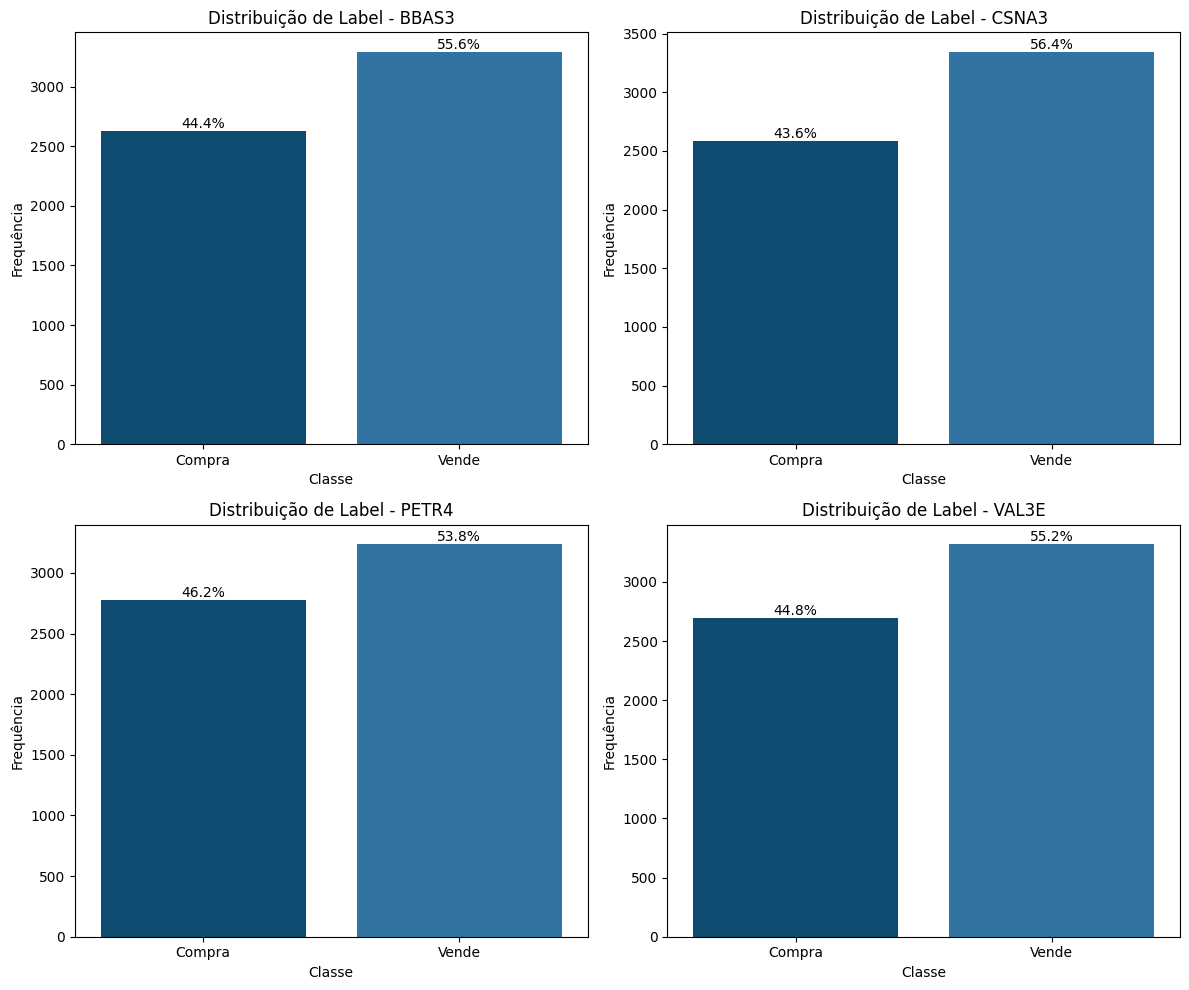

In [18]:
frequencias = freq_class(dfs_dict, 'Label')

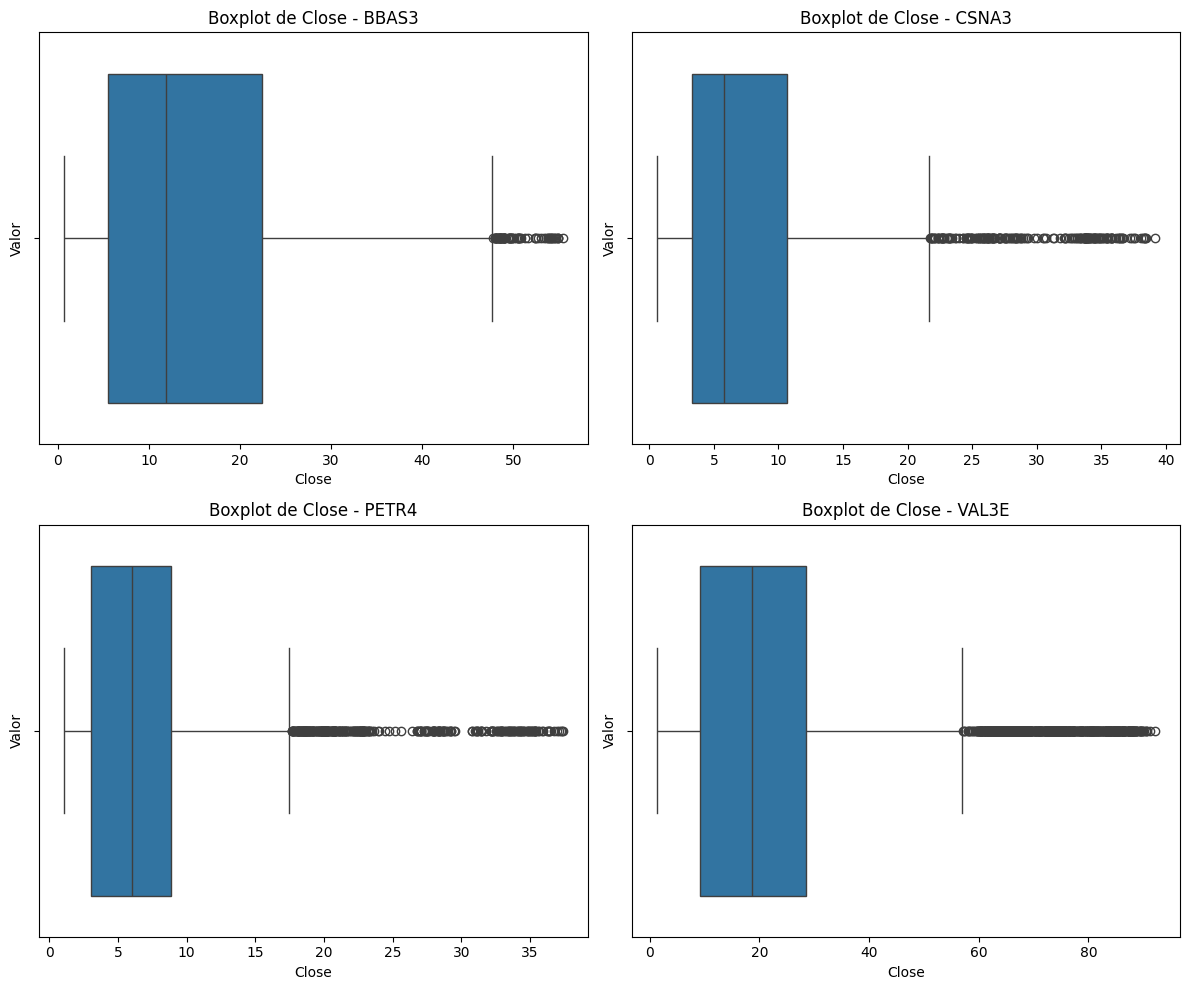

In [19]:
plot_boxplot(dfs_dict, coluna='Close')


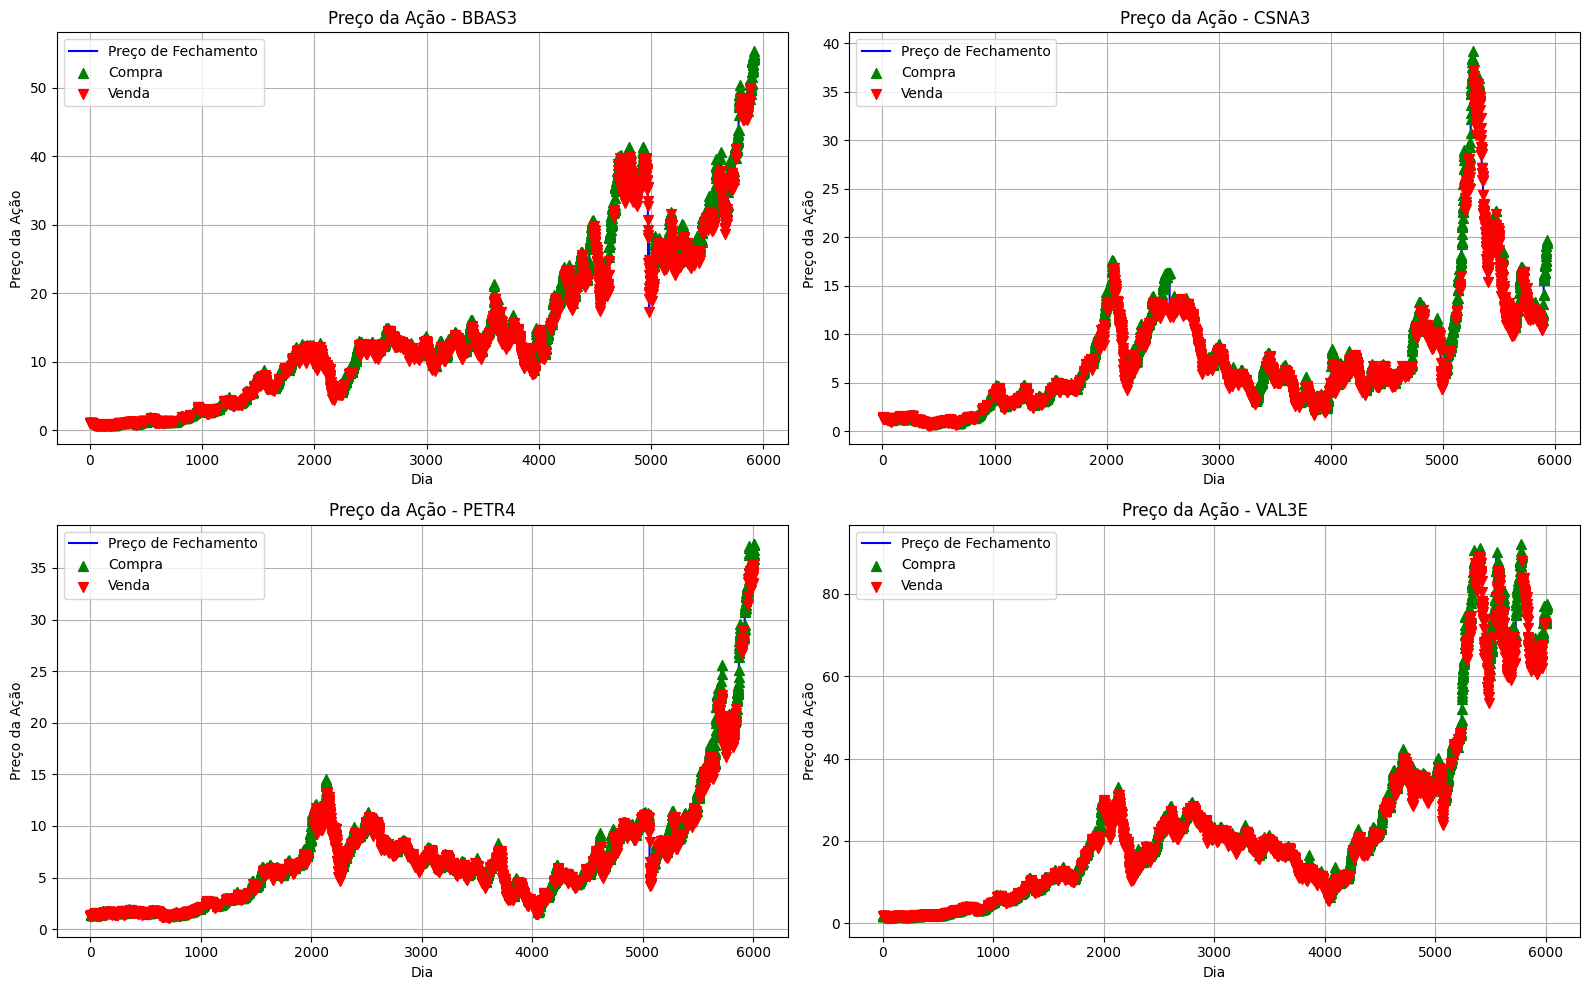

In [20]:
plot_sell_buy(dfs_dict, coluna='Close')

## **Pipeline de Treinamento e Teste**


### **Arquitetura das Redes CNN (Sequencial e Ramificada)**

A estratégia adotada para resolver nosso desafio envolve a experimentação com duas **arquiteturas de redes neurais convolucionais (CNN)**: uma estrutura **sequencial tradicional** e outra **ramificada**. Ambas serão treinadas com dados de séries temporais referentes aos últimos 15 dias de negociação de cada ativo.

A arquitetura sequencial processa as 15 features (um para cada dia) de forma contínua, permitindo que a rede atribua pesos e importâncias individualmente a cada ponto da sequência.

Já a arquitetura ramificada foi desenhada para receber duas janelas de tempo distintas como entrada:

* **Janela curta:** os 7 dias mais recentes,
* **Janela longa:** do 8º ao 15º dia anterior.

Essa abordagem busca que a rede aprenda padrões diferentes em períodos distintos, atribuindo pesos específicos a cada janela de tempo. A hipótese por trás disso é que informações mais recentes tendem a ter maior relevância para prever o comportamento do mercado no curto prazo, enquanto períodos um pouco mais antigos ainda podem contribuir com contexto histórico útil para a decisão de compra ou venda com um peso diferente.

In [21]:
# Modelo ramificado
def model_cnn_ramificado():
    input1 = Input(shape=(7, 1))
    input2 = Input(shape=(8, 1))

    x1 = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(input1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)
    x2 = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(input2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Flatten()(x2)

    combined = Concatenate()([x1, x2])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[input1, input2], outputs=output)
    return model


In [22]:
# Modelo sequencial
def model_cnn_sequencial():
    return Sequential([
        Input(shape=(15, 1)),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

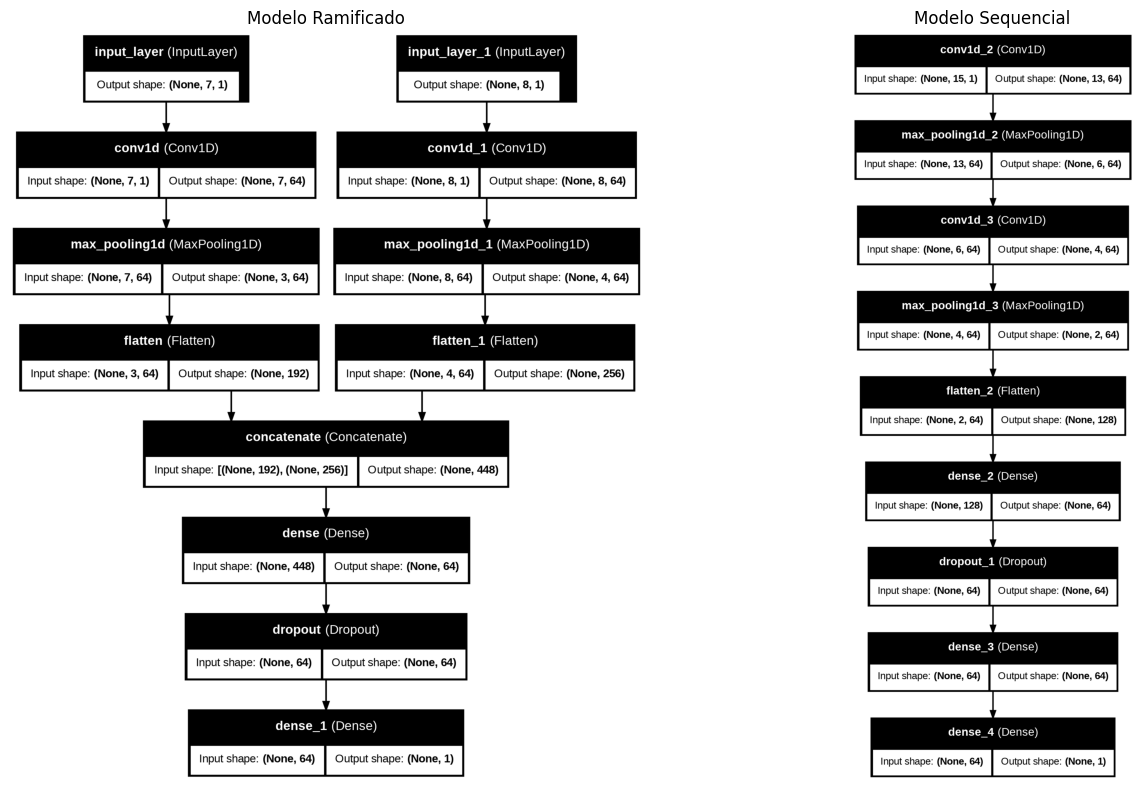

In [23]:
model = model_cnn_ramificado()
plot_model(model, to_file='cnn_ramificado.png', show_shapes=True, show_layer_names=True)

model_seq = model_cnn_sequencial()
plot_model(model_seq, to_file='cnn_sequencial.png', show_shapes=True, show_layer_names=True)

img_ramificado = mpimg.imread('cnn_ramificado.png')
img_sequencial = mpimg.imread('cnn_sequencial.png')

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(img_ramificado)
ax[0].axis('off')
ax[0].set_title('Modelo Ramificado')

ax[1].imshow(img_sequencial)
ax[1].axis('off')
ax[1].set_title('Modelo Sequencial')

plt.tight_layout()
plt.show()


### **Funções de Pré-Processamento, Treinamento e Backtest**
Esta seção reúne as funções responsáveis pelo pré-processamento dos dados, definição de métricas, estratégia de treinamento e execução do backtest.

Para o treinamento dos modelos, utilizei a **otimização bayesiana com foco na loss de validação** para buscar automaticamente os melhores hiperparâmetros para cada arquitetura e ativo. O modelo é treinado com o **otimizador Adam**, e são usados os **callbacks EarlyStopping, ReduceLROnPlateau e ModelCheckpoint** para conter overfitting, ajustar a taxa de aprendizado e salvar os melhores pesos.

O backtest segue as decisões de compra e venda previstas pelo modelo, simulando investimentos ao longo do período de teste e calculando o lucro final. Também comparei esse resultado com o rendimento que o mesmo capital teria no CDI, validando se a estratégia do modelo superou o benchmark de renda fixa no mesmo intervalo.

In [24]:
# Pré processa features e devolve os dados de treino e teste
def preprocess_data(train_df, test_df, split_features=None):
    scaler = StandardScaler()

    features = [f"Past_{i}_Days_Close" for i in range(1, 16)]
    X_train = train_df[features].values
    X_test = test_df[features].values

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train = train_df["Label"].replace({-1: 0, 1: 1}).values
    y_test = test_df["Label"].replace({-1: 0, 1: 1}).values

    if split_features is not None:
        processed = []
        for feature_group in split_features:
            idx = [features.index(col) for col in feature_group]
            reshaped_train = X_train[:, idx].reshape((X_train.shape[0], len(feature_group), 1))
            reshaped_test = X_test[:, idx].reshape((X_test.shape[0], len(feature_group), 1))
            processed.extend([reshaped_train, reshaped_test])
        return (*processed, y_train, y_test, features)
    else:
        X_train = X_train.reshape((X_train.shape[0], len(features), 1))
        X_test = X_test.reshape((X_test.shape[0], len(features), 1))
        return X_train, X_test, y_train, y_test, features

In [25]:
# Garante o formato do input X para ambas as redes (sequencial e ramificada)
def ensure_input_format(X):
    if isinstance(X, (list, tuple)):
        return X
    return [X]

In [26]:
# Retorna callbacks utilizados na rede
def get_callbacks(model_path, stop_patience, reduce_lr_factor, reduce_lr_patience):
    return [
        EarlyStopping(monitor="val_loss", patience=stop_patience, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=reduce_lr_factor, patience=reduce_lr_patience, min_lr=1e-6, verbose=1),
        ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1)
    ]


In [27]:
# Calcula métricas
def get_metrics(y_test, y_pred, prob, history):
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)

    metrics = {
        'accuracy': accuracy,
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
        'class_metrics': {
            'Vende (0)': report['0'],
            'Compra (1)': report['1']
        },
        'macro_avg': report['macro avg'],
        'weighted_avg': report['weighted avg']
    }

    summary = {
        'macro_recall': report['macro avg']['recall'],
        'weighted_recall': report['weighted avg']['recall'],
        'Compra (1)_recall': report['1']['recall'],
        'Vende (0)_recall': report['0']['recall'],
        'Compra (1)_precision': report['1']['precision'],
        'Vende (0)_precision': report['0']['precision'],
        'accuracy': accuracy,
        'val_loss': min(history.history["val_loss"])
    }

    return metrics, summary

In [28]:
# Treina e testa modelo
def train_model(model_fn, X_train, y_train, X_test, y_test,
                prob=0.5, n_trials=20, metric_to_optimize='val_loss',
                model_path='best_model.keras'):

    results = []
    best_model = None
    best_history = None
    best_metrics = None
    best_y_pred = None

    model_dir = "/content/models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, os.path.basename(model_path))

    def objective(trial):
        nonlocal best_model, best_history, best_metrics, best_y_pred

        params = {
            'epochs': trial.suggest_int('epochs', 10, 50),
            'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
            'lr': trial.suggest_float('learning_rate', 1e-5, 1e-2),
            'stop_patience': trial.suggest_int('stop_patience', 3, 10),
            'reduce_lr_factor': trial.suggest_float('reduce_lr_factor', 0.1, 0.5),
            'reduce_lr_patience': trial.suggest_int('reduce_lr_patience', 2, 5),
        }

        model = model_fn()
        optimizer = Adam(learning_rate=params['lr'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        callbacks = get_callbacks(model_path, params['stop_patience'], params['reduce_lr_factor'], params['reduce_lr_patience'])

        X_train_input = ensure_input_format(X_train)
        X_test_input = ensure_input_format(X_test)
        if len(X_train_input) == 1:
            X_train_input, X_test_input = X_train_input[0], X_test_input[0]

        history = model.fit(X_train_input, y_train,
                            validation_data=(X_test_input, y_test),
                            epochs=params['epochs'],
                            batch_size=params['batch_size'],
                            callbacks=callbacks, verbose=1)

        model.load_weights(model_path)
        y_pred_prob = model.predict(X_test_input)
        y_pred = (y_pred_prob > prob).astype(int)

        metrics, summary = get_metrics(y_test, y_pred, prob, history)
        score = -summary['val_loss'] if metric_to_optimize == "val_loss" else summary.get(metric_to_optimize, summary['macro_recall'])

        results.append({**params, **summary, 'trial': trial.number})

        if score > objective.best_score:
            objective.best_score = score
            best_model, best_history, best_metrics, best_y_pred = model, history, metrics, y_pred

        return score

    objective.best_score = -np.inf
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    df_results = pd.DataFrame(results)
    return best_model, best_history, best_metrics, best_y_pred, df_results


In [29]:
# Roda backtest
def run_backtest(predictions, prices, capital, model_name, stock_name,
                 metrics, cdi_df=None, metric_optimization=None):

    capital_atual = capital
    posicao = 0
    valor_compra = 0
    operacoes = []

    for i in range(len(predictions) - 1):
        preco_atual = prices[i]

        if predictions[i] == 1 and capital_atual >= preco_atual:
            qtd_comprada = capital_atual // preco_atual
            valor_compra = qtd_comprada * preco_atual
            posicao += qtd_comprada
            capital_atual -= valor_compra

        elif predictions[i] == 0 and posicao > 0:
            valor_venda = posicao * preco_atual
            capital_atual += valor_venda
            retorno = (valor_venda - valor_compra) / valor_compra if valor_compra > 0 else 0
            operacoes.append(retorno)
            posicao = 0

    valor_investido = posicao * prices.iloc[-1]
    lucro = (capital_atual + valor_investido) - capital
    lucro_percentual = (lucro / capital) * 100

    lucro_cdi_pct = None
    if cdi_df is not None:
        try:
            cdi_long = cdi_df.melt(id_vars='Ano', var_name='Mes', value_name='CDI')
            meses_map = {
                'Jan': 1, 'Fev': 2, 'Mar': 3, 'Abr': 4, 'Mai': 5, 'Jun': 6,
                'Jul': 7, 'Ago': 8, 'Set': 9, 'Out': 10, 'Nov': 11, 'Dez': 12
            }
            cdi_long['Mes_num'] = cdi_long['Mes'].map(meses_map)
            cdi_long['Data'] = pd.to_datetime(dict(year=cdi_long['Ano'], month=cdi_long['Mes_num'], day=1))
            cdi_long['CDI'] = cdi_long['CDI'].astype(float) / 100

            inicio = prices.index.min()
            fim = prices.index.max()
            cdi_periodo = cdi_long[(cdi_long['Data'] >= inicio) & (cdi_long['Data'] <= fim)]

            rendimento_cdi = (1 + cdi_periodo['CDI']).prod() - 1
            lucro_cdi_pct = rendimento_cdi * 100

        except Exception as e:
            print("Erro ao calcular o CDI:", e)

    resultado = {
        "Data": datetime.now(),
        "Modelo": model_name,
        "Ação": stock_name,
        "Métrica de Otimização": metric_optimization,
        "Acurácia": metrics['accuracy'],
        "Precision": metrics['macro_avg']['precision'],
        "Recall": metrics['macro_avg']['recall'],
        "F1": metrics['macro_avg']['f1-score'],
        "Matriz de Confusão": metrics['confusion_matrix'],
        "Saldo Inicial": capital,
        "Saldo Final": capital_atual,
        "Total de Ações": posicao,
        "Lucro Total": lucro,
        "Lucro (%)": lucro_percentual,
        "Lucro (%) CDI": lucro_cdi_pct
    }

    caminho_resultado = "/content/data-science-projects/deep-learning/results"
    os.makedirs(caminho_resultado, exist_ok=True)
    caminho_csv = os.path.join(caminho_resultado, "backtest_results.csv")

    if os.path.exists(caminho_csv):
        df_existente = pd.read_csv(caminho_csv)
        df_novo = pd.concat([df_existente, pd.DataFrame([resultado])], ignore_index=True)
    else:
        df_novo = pd.DataFrame([resultado])

    df_novo.to_csv(caminho_csv, index=False)

    return df_novo


### **Funções de Exibição de Gráficos**

In [30]:
def plot_training_history(histories, titles=None):
    n = len(histories)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)

    if titles is None:
        titles = [f"Modelo {i+1}" for i in range(n)]

    for i, history in enumerate(histories):
        ax = axes[i] if n > 1 else axes
        history_dict = history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        epochs = range(1, len(loss) + 1)

        ax.plot(epochs, loss, label='Loss Treino', color='blue')
        ax.plot(epochs, val_loss, label='Loss Validação', color='orange')
        ax.set_title(titles[i])
        ax.set_xlabel('Épocas')
        ax.set_ylabel('Loss')
        ax.grid(True)
        ax.legend()

    plt.suptitle('Evolução da Loss')
    plt.tight_layout()
    plt.show()


In [31]:
def plot_confusion_matrix(metrics_list, titles=None):
    n = len(metrics_list)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))

    if titles is None:
        titles = [f"Modelo {i+1}" for i in range(n)]

    for i, metrics in enumerate(metrics_list):
        ax = axes[i] if n > 1 else axes
        cm = metrics['confusion_matrix']
        labels = list(metrics['class_metrics'].keys())

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(titles[i])
        ax.set_xlabel('Predito')
        ax.set_ylabel('Real')

    plt.tight_layout()
    plt.show()


In [32]:
def show_classification_reports(metrics_list, titles=None):
    n = len(metrics_list)
    if titles is None:
        titles = [f"Modelo {i+1}" for i in range(n)]

    for i, metrics in enumerate(metrics_list):
        print("=" * 50)
        print(f"📊 Relatório de Classificação - {titles[i]}")
        print("=" * 50)

        for class_name, class_metrics in metrics['class_metrics'].items():
            print(f"\n{class_name}:")
            print(f"Precision: {class_metrics['precision']:.2f}")
            print(f"Recall:    {class_metrics['recall']:.2f}")
            print(f"F1-Score:  {class_metrics['f1-score']:.2f}")

        print("\nMédias:")
        print(f"Acurácia:  {metrics['accuracy']:.2f}")
        print(f"Precision: {metrics['macro_avg']['precision']:.2f}")
        print(f"Recall:    {metrics['macro_avg']['recall']:.2f}")
        print(f"F1-Score:  {metrics['macro_avg']['f1-score']:.2f}")
        print("\n")


In [33]:
def plot_sell_by(prices_list, predictions_list, titles=None):
    n = len(prices_list)
    fig, axes = plt.subplots(1, n, figsize=(8 * n, 5))

    if titles is None:
        titles = [f"Modelo {i+1}" for i in range(n)]

    for i in range(n):
        ax = axes[i] if n > 1 else axes
        prices = prices_list[i]
        predictions = predictions_list[i]

        buy_signals = np.where(predictions == 1)[0]
        sell_signals = np.where(predictions == 0)[0]

        ax.plot(prices, label='Preço da Ação', color='blue', linewidth=1.5)
        ax.scatter(buy_signals, prices[buy_signals], color='green', label='Compra', marker='^', s=100)
        ax.scatter(sell_signals, prices[sell_signals], color='red', label='Venda', marker='v', s=100)

        ax.set_title(titles[i])
        ax.set_xlabel('Dias')
        ax.set_ylabel('Preço da Ação')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


### **Treinamento e Teste**

Todos os modelos — tanto os sequenciais quanto os ramificados — apresentaram lucro superior ao CDI em todos os ativos analisados. No entanto, o modelo ramificado demonstrou maior consistência nos seguintes aspectos:

* Maior estabilidade e acurácia durante o treino
* Melhor desempenho de lucro nos testes de backtest.

Esses resultados comprovam a eficácia da estratégia de segmentação temporal.

#### **BBAS3**

In [34]:
X_train, X_test, y_train, y_test, features = preprocess_data(bb_train, bb_test)

In [35]:
janela_curta = features[:7]
janela_longa = features[7:]
X_train1, X_test1, X_train2, X_test2, y_train, y_test, features = preprocess_data(bb_train, bb_test, split_features=[janela_curta,janela_longa])

In [36]:
prices = bb_test.set_index("Date")["Close"]
titles = ["Modelo Sequencial", "Modelo Ramificado"]
metric_optimization = 'val_loss'

In [44]:
best_seq_model, best_seq_history, best_seq_metrics, best_seq_y_pred, df_results = train_model(
    model_fn=model_cnn_sequencial,
    model_path = "BEST_CNN_SEQ_BBAS3.keras",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-16 11:53:53,251] A new study created in memory with name: no-name-449b058f-970d-46f5-8d76-5ac1550a4a9c


Epoch 1/36
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5572 - loss: 0.6864
Epoch 1: val_loss improved from inf to 0.58924, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5576 - loss: 0.6860 - val_accuracy: 0.6439 - val_loss: 0.5892 - learning_rate: 0.0025
Epoch 2/36
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6196 - loss: 0.6390
Epoch 2: val_loss improved from 0.58924 to 0.40918, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6200 - loss: 0.6385 - val_accuracy: 0.8329 - val_loss: 0.4092 - learning_rate: 0.0025
Epoch 3/36
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6827 - loss: 0.5740
Epoch 3: val_loss did not improve from 0.40918
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6830 - loss: 0.5735 - val_accuracy: 0.7705 - val_loss: 0.5267 - learning_rate: 0.0025
Epoch 4/36
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 11:54:43,435] Trial 0 finished with value: -0.3418543040752411 and parameters: {'epochs': 36, 'batch_size': 16, 'learning_rate': 0.0025242909768325985, 'stop_patience': 7, 'reduce_lr_factor': 0.11519855632784415, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.3418543040752411.


Epoch 1/17
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5525 - loss: 0.6887
Epoch 1: val_loss improved from inf to 0.60868, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5527 - loss: 0.6886 - val_accuracy: 0.6338 - val_loss: 0.6087 - learning_rate: 0.0016
Epoch 2/17
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6464 - loss: 0.6193
Epoch 2: val_loss did not improve from 0.60868
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6466 - loss: 0.6192 - val_accuracy: 0.6338 - val_loss: 0.7256 - learning_rate: 0.0016
Epoch 3/17
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6881 - loss: 0.5659
Epoch 3: val_loss improved from 0.60868 to 0.39023, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6882 - loss: 0.5657 - val_accuracy: 0.8152 - val_loss: 0.3902 - learning_rate: 0.0016
Epoch 4/17
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 11:55:22,057] Trial 1 finished with value: -0.32173290848731995 and parameters: {'epochs': 17, 'batch_size': 16, 'learning_rate': 0.0015719562848993914, 'stop_patience': 6, 'reduce_lr_factor': 0.10257777976449943, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.32173290848731995.


Epoch 1/32
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5384 - loss: 0.6933
Epoch 1: val_loss improved from inf to 0.67838, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5386 - loss: 0.6932 - val_accuracy: 0.6278 - val_loss: 0.6784 - learning_rate: 0.0084
Epoch 2/32
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5558 - loss: 0.6843
Epoch 2: val_loss did not improve from 0.67838
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5559 - loss: 0.6843 - val_accuracy: 0.5139 - val_loss: 1.1415 - learning_rate: 0.0084
Epoch 3/32
137/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6138 - loss: 0.6335
Epoch 3: val_loss improved from 0.67838 to 0.41109, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6145 - loss: 0.6330 - val_accuracy: 0.8118 - val_loss: 0.4111 - learning_rate: 0.0084
Epoch 4/32
138/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 11:55:38,003] Trial 2 finished with value: -0.4110914170742035 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.008352517586743666, 'stop_patience': 9, 'reduce_lr_factor': 0.3902441689591639, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.32173290848731995.


Epoch 1/21
67/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5418 - loss: 0.6902
Epoch 1: val_loss improved from inf to 0.57044, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5431 - loss: 0.6894 - val_accuracy: 0.7873 - val_loss: 0.5704 - learning_rate: 0.0030
Epoch 2/21
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5876 - loss: 0.6579
Epoch 2: val_loss improved from 0.57044 to 0.47437, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5877 - loss: 0.6578 - val_accuracy: 0.8076 - val_loss: 0.4744 - learning_rate: 0.0030
Epoch 3/21
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6658 - loss: 0.6015
Epoch 3: val_loss did not improve from 0.47437
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6668 - loss: 0.5994 - val_accuracy: 0.7342 - val_loss: 0.5771 - learning_rate: 0.0030
Epoch 4/21
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6875 

[I 2025-04-16 11:55:47,852] Trial 3 finished with value: -0.34000977873802185 and parameters: {'epochs': 21, 'batch_size': 64, 'learning_rate': 0.0030322020208794326, 'stop_patience': 3, 'reduce_lr_factor': 0.14761034857855165, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.32173290848731995.


Epoch 1/30
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5477 - loss: 0.6924
Epoch 1: val_loss improved from inf to 0.69078, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5476 - loss: 0.6922 - val_accuracy: 0.5342 - val_loss: 0.6908 - learning_rate: 0.0095
Epoch 2/30
65/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5512 - loss: 0.6898
Epoch 2: val_loss improved from 0.69078 to 0.68310, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5509 - loss: 0.6899 - val_accuracy: 0.5814 - val_loss: 0.6831 - learning_rate: 0.0095
Epoch 3/30
67/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5497 - loss: 0.6881
Epoch 3: val_loss improved from 0.68310 to 0.67637, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5502 - loss: 0.6880 - val_accuracy: 0.5814 - val_loss: 0.6764 - learning_rate: 0.0095
Epoch 4

[I 2025-04-16 11:55:58,274] Trial 4 finished with value: -0.42046618461608887 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.009533521921954653, 'stop_patience': 4, 'reduce_lr_factor': 0.2202750811967006, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.32173290848731995.


Epoch 1/49
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5502 - loss: 0.6897
Epoch 1: val_loss improved from inf to 0.67921, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5505 - loss: 0.6895 - val_accuracy: 0.5730 - val_loss: 0.6792 - learning_rate: 0.0030
Epoch 2/49
280/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5789 - loss: 0.6734
Epoch 2: val_loss did not improve from 0.67921
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5796 - loss: 0.6727 - val_accuracy: 0.4270 - val_loss: 1.0815 - learning_rate: 0.0030
Epoch 3/49
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6472 - loss: 0.6021
Epoch 3: val_loss improved from 0.67921 to 0.49730, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6479 - loss: 0.6012 - val_accuracy: 0.7367 - val_loss: 0.4973 - learning_rate: 0.0030
Epoch 4/49
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 11:57:03,649] Trial 5 finished with value: -0.3102387487888336 and parameters: {'epochs': 49, 'batch_size': 16, 'learning_rate': 0.003015132967356057, 'stop_patience': 10, 'reduce_lr_factor': 0.37350732496629846, 'reduce_lr_patience': 5}. Best is trial 5 with value: -0.3102387487888336.


Epoch 1/28
66/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5468 - loss: 0.6908
Epoch 1: val_loss improved from inf to 0.64757, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5482 - loss: 0.6899 - val_accuracy: 0.5654 - val_loss: 0.6476 - learning_rate: 0.0030
Epoch 2/28
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5809 - loss: 0.6599
Epoch 2: val_loss improved from 0.64757 to 0.49198, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5817 - loss: 0.6590 - val_accuracy: 0.7409 - val_loss: 0.4920 - learning_rate: 0.0030
Epoch 3/28
66/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6597 - loss: 0.6074
Epoch 3: val_loss did not improve from 0.49198
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6604 - loss: 0.6049 - val_accuracy: 0.5004 - val_loss: 1.3959 - learning_rate: 0.0030
Epoch 4/28
64/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6867 

[I 2025-04-16 11:57:19,614] Trial 6 finished with value: -0.34965190291404724 and parameters: {'epochs': 28, 'batch_size': 64, 'learning_rate': 0.003028832348246749, 'stop_patience': 10, 'reduce_lr_factor': 0.18652997714319836, 'reduce_lr_patience': 4}. Best is trial 5 with value: -0.3102387487888336.


Epoch 1/39
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5542 - loss: 0.6898
Epoch 1: val_loss improved from inf to 0.70174, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5542 - loss: 0.6898 - val_accuracy: 0.4489 - val_loss: 0.7017 - learning_rate: 0.0037
Epoch 2/39
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5582 - loss: 0.6838
Epoch 2: val_loss did not improve from 0.70174
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5582 - loss: 0.6838 - val_accuracy: 0.4262 - val_loss: 0.8911 - learning_rate: 0.0037
Epoch 3/39
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6149 - loss: 0.6368
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0010019028432567188.

Epoch 3: val_loss did not improve from 0.70174
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6154 - loss: 0.6364 - val_accuracy: 0.5300 - val_loss: 0.7448 - learning_rate: 0.0037
Epoch 4/39
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2025-04-16 11:57:58,259] Trial 7 finished with value: -0.35917872190475464 and parameters: {'epochs': 39, 'batch_size': 16, 'learning_rate': 0.0036693826978712566, 'stop_patience': 6, 'reduce_lr_factor': 0.27304397105821826, 'reduce_lr_patience': 2}. Best is trial 5 with value: -0.3102387487888336.


Epoch 1/36
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5458 - loss: 0.6897
Epoch 1: val_loss improved from inf to 0.61048, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5461 - loss: 0.6895 - val_accuracy: 0.6110 - val_loss: 0.6105 - learning_rate: 0.0013
Epoch 2/36
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5907 - loss: 0.6634
Epoch 2: val_loss did not improve from 0.61048
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5912 - loss: 0.6630 - val_accuracy: 0.4608 - val_loss: 1.5937 - learning_rate: 0.0013
Epoch 3/36
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6822 - loss: 0.5777
Epoch 3: val_loss improved from 0.61048 to 0.47127, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6823 - loss: 0.5776 - val_accuracy: 0.7494 - val_loss: 0.4713 - learning_rate: 0.0013
Epoch 4/36
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

[I 2025-04-16 11:58:09,880] Trial 8 finished with value: -0.37121912837028503 and parameters: {'epochs': 36, 'batch_size': 32, 'learning_rate': 0.0012941585163511319, 'stop_patience': 3, 'reduce_lr_factor': 0.3827451720916065, 'reduce_lr_patience': 4}. Best is trial 5 with value: -0.3102387487888336.


Epoch 1/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5398 - loss: 0.6909
Epoch 1: val_loss improved from inf to 0.66848, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5398 - loss: 0.6909 - val_accuracy: 0.5814 - val_loss: 0.6685 - learning_rate: 0.0065
Epoch 2/40
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5597 - loss: 0.6763
Epoch 2: val_loss did not improve from 0.66848
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5601 - loss: 0.6760 - val_accuracy: 0.4498 - val_loss: 0.6848 - learning_rate: 0.0065
Epoch 3/40
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6309 - loss: 0.6236
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029531440777355793.

Epoch 3: val_loss did not improve from 0.66848
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6311 - loss: 0.6235 - val_accuracy: 0.5359 - val_loss: 0.9305 - learning_rate: 0.0065
Epoch 4/40
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2025-04-16 11:58:37,432] Trial 9 finished with value: -0.40312960743904114 and parameters: {'epochs': 40, 'batch_size': 16, 'learning_rate': 0.006530588994055514, 'stop_patience': 4, 'reduce_lr_factor': 0.4522017993387063, 'reduce_lr_patience': 2}. Best is trial 5 with value: -0.3102387487888336.


Epoch 1/48
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5341 - loss: 0.6930
Epoch 1: val_loss improved from inf to 0.67580, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5343 - loss: 0.6929 - val_accuracy: 0.5814 - val_loss: 0.6758 - learning_rate: 0.0057
Epoch 2/48
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5478 - loss: 0.6893
Epoch 2: val_loss did not improve from 0.67580
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5479 - loss: 0.6893 - val_accuracy: 0.5814 - val_loss: 0.6808 - learning_rate: 0.0057
Epoch 3/48
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5513 - loss: 0.6882
Epoch 3: val_loss improved from 0.67580 to 0.67452, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5516 - loss: 0.6881 - val_accuracy: 0.6110 - val_loss: 0.6745 - learning_rate: 0.0057
Epoch 4/48
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 11:59:48,603] Trial 10 finished with value: -0.38131681084632874 and parameters: {'epochs': 48, 'batch_size': 16, 'learning_rate': 0.0057062565304502886, 'stop_patience': 8, 'reduce_lr_factor': 0.33550933289362367, 'reduce_lr_patience': 5}. Best is trial 5 with value: -0.3102387487888336.


Epoch 1/13
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5509 - loss: 0.6907
Epoch 1: val_loss improved from inf to 0.67534, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5514 - loss: 0.6906 - val_accuracy: 0.7612 - val_loss: 0.6753 - learning_rate: 7.6104e-05
Epoch 2/13
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5673 - loss: 0.6835
Epoch 2: val_loss improved from 0.67534 to 0.65672, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5673 - loss: 0.6835 - val_accuracy: 0.7021 - val_loss: 0.6567 - learning_rate: 7.6104e-05
Epoch 3/13
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5705 - loss: 0.6780
Epoch 3: val_loss improved from 0.65672 to 0.63850, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5709 - loss: 0.6778 - val_accuracy: 0.6667 - val_loss: 0.6385 - learning_r

[I 2025-04-16 12:00:14,469] Trial 11 finished with value: -0.3931742310523987 and parameters: {'epochs': 13, 'batch_size': 16, 'learning_rate': 7.610446226555441e-05, 'stop_patience': 6, 'reduce_lr_factor': 0.4849413213122484, 'reduce_lr_patience': 5}. Best is trial 5 with value: -0.3102387487888336.


Epoch 1/13
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5505 - loss: 0.6894
Epoch 1: val_loss improved from inf to 0.75560, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5509 - loss: 0.6892 - val_accuracy: 0.5241 - val_loss: 0.7556 - learning_rate: 0.0012
Epoch 2/13
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6203 - loss: 0.6413
Epoch 2: val_loss improved from 0.75560 to 0.45997, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6208 - loss: 0.6408 - val_accuracy: 0.8203 - val_loss: 0.4600 - learning_rate: 0.0012
Epoch 3/13
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6797 - loss: 0.5587
Epoch 3: val_loss improved from 0.45997 to 0.36274, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6798 - loss: 0.5586 - val_accuracy: 0.8439 - val_loss: 0.3627 - learning_rate: 0.0

[I 2025-04-16 12:00:48,263] Trial 12 finished with value: -0.326204776763916 and parameters: {'epochs': 13, 'batch_size': 16, 'learning_rate': 0.0011515038094345076, 'stop_patience': 7, 'reduce_lr_factor': 0.29922139755945426, 'reduce_lr_patience': 5}. Best is trial 5 with value: -0.3102387487888336.


Epoch 1/50
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5447 - loss: 0.6917
Epoch 1: val_loss improved from inf to 0.67933, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5450 - loss: 0.6916 - val_accuracy: 0.5814 - val_loss: 0.6793 - learning_rate: 0.0047
Epoch 2/50
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5502 - loss: 0.6874
Epoch 2: val_loss did not improve from 0.67933
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5504 - loss: 0.6873 - val_accuracy: 0.5772 - val_loss: 0.6864 - learning_rate: 0.0047
Epoch 3/50
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5901 - loss: 0.6560
Epoch 3: val_loss improved from 0.67933 to 0.53989, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5906 - loss: 0.6555 - val_accuracy: 0.7266 - val_loss: 0.5399 - learning_rate: 0.0047
Epoch 4/50
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:01:31,498] Trial 13 finished with value: -0.37390923500061035 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.004653547418009908, 'stop_patience': 10, 'reduce_lr_factor': 0.4030128257082667, 'reduce_lr_patience': 5}. Best is trial 5 with value: -0.3102387487888336.


Epoch 1/22
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5449 - loss: 0.6904
Epoch 1: val_loss improved from inf to 0.66093, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5456 - loss: 0.6902 - val_accuracy: 0.5620 - val_loss: 0.6609 - learning_rate: 0.0014
Epoch 2/22
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6052 - loss: 0.6554
Epoch 2: val_loss improved from 0.66093 to 0.63909, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6058 - loss: 0.6549 - val_accuracy: 0.6582 - val_loss: 0.6391 - learning_rate: 0.0014
Epoch 3/22
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6684 - loss: 0.5872
Epoch 3: val_loss improved from 0.63909 to 0.36341, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6692 - loss: 0.5865 - val_accuracy: 0.8456 - val_loss: 0.3634 - learning_rate: 0.0

[I 2025-04-16 12:02:16,366] Trial 14 finished with value: -0.3080405592918396 and parameters: {'epochs': 22, 'batch_size': 16, 'learning_rate': 0.0013543285527661162, 'stop_patience': 5, 'reduce_lr_factor': 0.24236313539519472, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/23
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5520 - loss: 0.6899
Epoch 1: val_loss improved from inf to 0.75567, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5523 - loss: 0.6898 - val_accuracy: 0.4278 - val_loss: 0.7557 - learning_rate: 3.9487e-04
Epoch 2/23
136/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.6756
Epoch 2: val_loss improved from 0.75567 to 0.53397, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5650 - loss: 0.6749 - val_accuracy: 0.7797 - val_loss: 0.5340 - learning_rate: 3.9487e-04
Epoch 3/23
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6323 - loss: 0.6325
Epoch 3: val_loss improved from 0.53397 to 0.43115, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6327 - loss: 0.6322 - val_accuracy: 0.8025 - val_loss: 0.4312 - learning_

[I 2025-04-16 12:02:38,766] Trial 15 finished with value: -0.3117654621601105 and parameters: {'epochs': 23, 'batch_size': 32, 'learning_rate': 0.0003948696642200192, 'stop_patience': 5, 'reduce_lr_factor': 0.2456157354922985, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/44
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5475 - loss: 0.6893
Epoch 1: val_loss improved from inf to 0.71781, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5482 - loss: 0.6890 - val_accuracy: 0.4869 - val_loss: 0.7178 - learning_rate: 0.0045
Epoch 2/44
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5839 - loss: 0.6683
Epoch 2: val_loss improved from 0.71781 to 0.69769, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5839 - loss: 0.6682 - val_accuracy: 0.4599 - val_loss: 0.6977 - learning_rate: 0.0045
Epoch 3/44
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6197 - loss: 0.6206
Epoch 3: val_loss improved from 0.69769 to 0.46921, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6200 - loss: 0.6204 - val_accuracy: 0.8000 - val_loss: 0.4692 - learning_rate: 0.0

[I 2025-04-16 12:03:17,459] Trial 16 finished with value: -0.360390305519104 and parameters: {'epochs': 44, 'batch_size': 16, 'learning_rate': 0.004453243960997719, 'stop_patience': 8, 'reduce_lr_factor': 0.3185330795783053, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/25
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5446 - loss: 0.6905
Epoch 1: val_loss improved from inf to 0.65896, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5450 - loss: 0.6903 - val_accuracy: 0.6110 - val_loss: 0.6590 - learning_rate: 0.0021
Epoch 2/25
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6060 - loss: 0.6523
Epoch 2: val_loss did not improve from 0.65896
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6061 - loss: 0.6522 - val_accuracy: 0.4599 - val_loss: 0.7671 - learning_rate: 0.0021
Epoch 3/25
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6742 - loss: 0.5832
Epoch 3: val_loss improved from 0.65896 to 0.39385, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6748 - loss: 0.5826 - val_accuracy: 0.8295 - val_loss: 0.3938 - learning_rate: 0.0021
Epoch 4/25
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:03:41,209] Trial 17 finished with value: -0.3509764075279236 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.0021310906056222784, 'stop_patience': 5, 'reduce_lr_factor': 0.3683979355039888, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/20
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5334 - loss: 0.6921
Epoch 1: val_loss improved from inf to 0.67727, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5339 - loss: 0.6919 - val_accuracy: 0.6456 - val_loss: 0.6773 - learning_rate: 0.0066
Epoch 2/20
65/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5622 - loss: 0.6777
Epoch 2: val_loss did not improve from 0.67727
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5648 - loss: 0.6760 - val_accuracy: 0.4717 - val_loss: 0.7782 - learning_rate: 0.0066
Epoch 3/20
65/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6269 - loss: 0.6337
Epoch 3: val_loss improved from 0.67727 to 0.45471, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6267 - loss: 0.6338 - val_accuracy: 0.7907 - val_loss: 0.4547 - learning_rate: 0.0066
Epoch 4/20
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6368 

[I 2025-04-16 12:03:56,120] Trial 18 finished with value: -0.3845937252044678 and parameters: {'epochs': 20, 'batch_size': 64, 'learning_rate': 0.006642850471802976, 'stop_patience': 9, 'reduce_lr_factor': 0.19275877415805387, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5449 - loss: 0.6907
Epoch 1: val_loss improved from inf to 0.51863, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5451 - loss: 0.6906 - val_accuracy: 0.7603 - val_loss: 0.5186 - learning_rate: 0.0039
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6560 - loss: 0.6123
Epoch 2: val_loss did not improve from 0.51863
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6561 - loss: 0.6122 - val_accuracy: 0.6287 - val_loss: 0.7940 - learning_rate: 0.0039
Epoch 3/10
138/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6524 - loss: 0.5893
Epoch 3: val_loss improved from 0.51863 to 0.51108, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6533 - loss: 0.5883 - val_accuracy: 0.7173 - val_loss: 0.5111 - learning_rate: 0.0039
Epoch 4/10
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

[I 2025-04-16 12:04:12,552] Trial 19 finished with value: -0.3420774042606354 and parameters: {'epochs': 10, 'batch_size': 32, 'learning_rate': 0.0038760393569599004, 'stop_patience': 5, 'reduce_lr_factor': 0.44293456519722396, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/45
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5550 - loss: 0.6891
Epoch 1: val_loss improved from inf to 0.89670, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5553 - loss: 0.6889 - val_accuracy: 0.4498 - val_loss: 0.8967 - learning_rate: 0.0021
Epoch 2/45
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5761 - loss: 0.6769
Epoch 2: val_loss improved from 0.89670 to 0.66710, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5766 - loss: 0.6766 - val_accuracy: 0.5629 - val_loss: 0.6671 - learning_rate: 0.0021
Epoch 3/45
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6405 - loss: 0.6123
Epoch 3: val_loss improved from 0.66710 to 0.39332, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6410 - loss: 0.6117 - val_accuracy: 0.8228 - val_loss: 0.3933 - learning_rate: 0.0

[I 2025-04-16 12:05:16,855] Trial 20 finished with value: -0.3093098998069763 and parameters: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.002122396301726991, 'stop_patience': 8, 'reduce_lr_factor': 0.2707206195312673, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/45
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5459 - loss: 0.6882
Epoch 1: val_loss improved from inf to 0.77775, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5461 - loss: 0.6881 - val_accuracy: 0.5316 - val_loss: 0.7778 - learning_rate: 0.0020
Epoch 2/45
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6350 - loss: 0.6343
Epoch 2: val_loss improved from 0.77775 to 0.38294, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6357 - loss: 0.6334 - val_accuracy: 0.8253 - val_loss: 0.3829 - learning_rate: 0.0020
Epoch 3/45
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6717 - loss: 0.5750
Epoch 3: val_loss did not improve from 0.38294
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6719 - loss: 0.5747 - val_accuracy: 0.8287 - val_loss: 0.3869 - learning_rate: 0.0020
Epoch 4/45
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

[I 2025-04-16 12:06:18,483] Trial 21 finished with value: -0.3182215690612793 and parameters: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.00203139078336152, 'stop_patience': 9, 'reduce_lr_factor': 0.2725801381666797, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/45
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5404 - loss: 0.6904
Epoch 1: val_loss improved from inf to 0.69785, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5409 - loss: 0.6903 - val_accuracy: 0.4979 - val_loss: 0.6978 - learning_rate: 7.8169e-04
Epoch 2/45
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.6570
Epoch 2: val_loss improved from 0.69785 to 0.40730, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6016 - loss: 0.6567 - val_accuracy: 0.8329 - val_loss: 0.4073 - learning_rate: 7.8169e-04
Epoch 3/45
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6647 - loss: 0.5782
Epoch 3: val_loss did not improve from 0.40730
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6652 - loss: 0.5778 - val_accuracy: 0.7907 - val_loss: 0.4528 - learning_rate: 7.8169e-04
Epoch 4/45
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

[I 2025-04-16 12:07:22,494] Trial 22 finished with value: -0.3193676471710205 and parameters: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.0007816860972780352, 'stop_patience': 8, 'reduce_lr_factor': 0.33585312204593337, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5500 - loss: 0.6914
Epoch 1: val_loss improved from inf to 0.68240, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5500 - loss: 0.6914 - val_accuracy: 0.5570 - val_loss: 0.6824 - learning_rate: 0.0033
Epoch 2/50
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.6831
Epoch 2: val_loss did not improve from 0.68240
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5667 - loss: 0.6830 - val_accuracy: 0.4211 - val_loss: 1.0444 - learning_rate: 0.0033
Epoch 3/50
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6010 - loss: 0.6441
Epoch 3: val_loss improved from 0.68240 to 0.60555, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6020 - loss: 0.6433 - val_accuracy: 0.7004 - val_loss: 0.6055 - learning_rate: 0.0033
Epoch 4/50
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:08:05,375] Trial 23 finished with value: -0.35946032404899597 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.0033160495520554055, 'stop_patience': 10, 'reduce_lr_factor': 0.23896375186472327, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/42
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5474 - loss: 0.6901
Epoch 1: val_loss improved from inf to 0.66766, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5476 - loss: 0.6900 - val_accuracy: 0.6641 - val_loss: 0.6677 - learning_rate: 0.0023
Epoch 2/42
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5641 - loss: 0.6791
Epoch 2: val_loss improved from 0.66766 to 0.62042, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5642 - loss: 0.6790 - val_accuracy: 0.6051 - val_loss: 0.6204 - learning_rate: 0.0023
Epoch 3/42
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6321 - loss: 0.6158
Epoch 3: val_loss improved from 0.62042 to 0.38205, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6332 - loss: 0.6149 - val_accuracy: 0.8270 - val_loss: 0.3821 - learning_rate: 0.0

[I 2025-04-16 12:09:05,705] Trial 24 finished with value: -0.31659796833992004 and parameters: {'epochs': 42, 'batch_size': 16, 'learning_rate': 0.002279399919508859, 'stop_patience': 7, 'reduce_lr_factor': 0.2872142595119433, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/34
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5335 - loss: 0.6923
Epoch 1: val_loss improved from inf to 0.67773, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5336 - loss: 0.6923 - val_accuracy: 0.5814 - val_loss: 0.6777 - learning_rate: 0.0053
Epoch 2/34
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5640 - loss: 0.6847
Epoch 2: val_loss did not improve from 0.67773
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5641 - loss: 0.6847 - val_accuracy: 0.5713 - val_loss: 0.6781 - learning_rate: 0.0053
Epoch 3/34
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5985 - loss: 0.6554
Epoch 3: val_loss improved from 0.67773 to 0.60023, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.6552 - val_accuracy: 0.5671 - val_loss: 0.6002 - learning_rate: 0.0053
Epoch 4/34
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:10:20,877] Trial 25 finished with value: -0.33662503957748413 and parameters: {'epochs': 34, 'batch_size': 16, 'learning_rate': 0.005348205982481419, 'stop_patience': 9, 'reduce_lr_factor': 0.355169273880453, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/27
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5548 - loss: 0.6883
Epoch 1: val_loss improved from inf to 0.73290, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5550 - loss: 0.6882 - val_accuracy: 0.5266 - val_loss: 0.7329 - learning_rate: 0.0040
Epoch 2/27
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6121 - loss: 0.6385
Epoch 2: val_loss did not improve from 0.73290
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6124 - loss: 0.6383 - val_accuracy: 0.4954 - val_loss: 0.8131 - learning_rate: 0.0040
Epoch 3/27
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6548 - loss: 0.5944
Epoch 3: val_loss improved from 0.73290 to 0.65192, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6551 - loss: 0.5941 - val_accuracy: 0.5738 - val_loss: 0.6519 - learning_rate: 0.0040
Epoch 4/27
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:11:08,120] Trial 26 finished with value: -0.3693521320819855 and parameters: {'epochs': 27, 'batch_size': 16, 'learning_rate': 0.004047583192333672, 'stop_patience': 8, 'reduce_lr_factor': 0.1911843304140432, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/48
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5489 - loss: 0.6866
Epoch 1: val_loss improved from inf to 0.49154, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5497 - loss: 0.6862 - val_accuracy: 0.8017 - val_loss: 0.4915 - learning_rate: 0.0018
Epoch 2/48
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6203 - loss: 0.6417
Epoch 2: val_loss improved from 0.49154 to 0.42046, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6204 - loss: 0.6417 - val_accuracy: 0.8076 - val_loss: 0.4205 - learning_rate: 0.0018
Epoch 3/48
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6675 - loss: 0.5842
Epoch 3: val_loss did not improve from 0.42046
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6679 - loss: 0.5836 - val_accuracy: 0.8076 - val_loss: 0.4226 - learning_rate: 0.0018
Epoch 4/48
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:11:37,931] Trial 27 finished with value: -0.34727779030799866 and parameters: {'epochs': 48, 'batch_size': 16, 'learning_rate': 0.0017974958111295982, 'stop_patience': 4, 'reduce_lr_factor': 0.24459096584274903, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/39
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5461 - loss: 0.6918
Epoch 1: val_loss improved from inf to 0.86206, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5464 - loss: 0.6916 - val_accuracy: 0.4304 - val_loss: 0.8621 - learning_rate: 0.0027
Epoch 2/39
140/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5737 - loss: 0.6664
Epoch 2: val_loss improved from 0.86206 to 0.67183, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5756 - loss: 0.6651 - val_accuracy: 0.5038 - val_loss: 0.6718 - learning_rate: 0.0027
Epoch 3/39
138/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6492 - loss: 0.5921
Epoch 3: val_loss did not improve from 0.67183
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6511 - loss: 0.5907 - val_accuracy: 0.5570 - val_loss: 1.2942 - learning_rate: 0.0027
Epoch 4/39
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:12:06,957] Trial 28 finished with value: -0.31893280148506165 and parameters: {'epochs': 39, 'batch_size': 32, 'learning_rate': 0.0026734683080973528, 'stop_patience': 10, 'reduce_lr_factor': 0.4178566152435832, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.3080405592918396.


Epoch 1/19
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5477 - loss: 0.6887
Epoch 1: val_loss improved from inf to 0.75944, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5487 - loss: 0.6884 - val_accuracy: 0.4304 - val_loss: 0.7594 - learning_rate: 6.7891e-04
Epoch 2/19
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5838 - loss: 0.6691
Epoch 2: val_loss improved from 0.75944 to 0.51018, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5849 - loss: 0.6685 - val_accuracy: 0.8118 - val_loss: 0.5102 - learning_rate: 6.7891e-04
Epoch 3/19
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6335 - loss: 0.6328
Epoch 3: val_loss improved from 0.51018 to 0.42804, saving model to /content/models/BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6343 - loss: 0.6315 - val_accuracy: 0.8160 - val_loss: 0.4280 - learning_rate: 6.7891

[I 2025-04-16 12:12:25,313] Trial 29 finished with value: -0.3208056390285492 and parameters: {'epochs': 19, 'batch_size': 64, 'learning_rate': 0.0006789122633571237, 'stop_patience': 7, 'reduce_lr_factor': 0.3116020417321923, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.3080405592918396.


In [45]:
best_ram_model, best_ram_history, best_ram_metrics, best_ram_y_pred, df_results = train_model(
    model_fn=model_cnn_ramificado,
    model_path = "BEST_CNN_RAM_BBAS3.keras",
    X_train=[X_train1, X_train2],
    y_train=y_train,
    X_test=[X_test1, X_test2],
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-16 12:12:25,323] A new study created in memory with name: no-name-5a5a5465-9a77-4481-a377-427d92d21816


Epoch 1/36
135/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5603 - loss: 0.6815
Epoch 1: val_loss improved from inf to 0.46002, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5635 - loss: 0.6794 - val_accuracy: 0.8076 - val_loss: 0.4600 - learning_rate: 0.0020
Epoch 2/36
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6610 - loss: 0.6025
Epoch 2: val_loss did not improve from 0.46002
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6614 - loss: 0.6022 - val_accuracy: 0.7443 - val_loss: 0.5063 - learning_rate: 0.0020
Epoch 3/36
138/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7040 - loss: 0.5405
Epoch 3: val_loss improved from 0.46002 to 0.29625, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7049 - loss: 0.5402 - val_accuracy: 0.8776 - val_loss: 0.2963 - learning_rate: 0.0020
Epoch 4/36
139/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:12:49,959] Trial 0 finished with value: -0.2637965679168701 and parameters: {'epochs': 36, 'batch_size': 32, 'learning_rate': 0.0019547755652193377, 'stop_patience': 8, 'reduce_lr_factor': 0.3331458295313853, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.2637965679168701.


Epoch 1/14
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5787 - loss: 0.6737
Epoch 1: val_loss improved from inf to 0.54545, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5793 - loss: 0.6732 - val_accuracy: 0.6928 - val_loss: 0.5455 - learning_rate: 0.0033
Epoch 2/14
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6651 - loss: 0.5866
Epoch 2: val_loss improved from 0.54545 to 0.29944, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6658 - loss: 0.5862 - val_accuracy: 0.8819 - val_loss: 0.2994 - learning_rate: 0.0033
Epoch 3/14
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7149 - loss: 0.5247
Epoch 3: val_loss improved from 0.29944 to 0.27923, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7150 - loss: 0.5247 - val_accuracy: 0.8810 - val_loss: 0.2792 - learning_rate: 0.0

[I 2025-04-16 12:13:09,178] Trial 1 finished with value: -0.260748028755188 and parameters: {'epochs': 14, 'batch_size': 32, 'learning_rate': 0.003349176779856644, 'stop_patience': 5, 'reduce_lr_factor': 0.2780715523069486, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.260748028755188.


Epoch 1/35
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5642 - loss: 0.6773
Epoch 1: val_loss improved from inf to 0.36952, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5673 - loss: 0.6751 - val_accuracy: 0.8717 - val_loss: 0.3695 - learning_rate: 0.0079
Epoch 2/35
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6525 - loss: 0.6023
Epoch 2: val_loss did not improve from 0.36952
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6535 - loss: 0.6012 - val_accuracy: 0.7485 - val_loss: 0.4791 - learning_rate: 0.0079
Epoch 3/35
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7032 - loss: 0.5313
Epoch 3: val_loss did not improve from 0.36952
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7039 - loss: 0.5303 - val_accuracy: 0.8059 - val_loss: 0.4221 - learning_rate: 0.0079
Epoch 4/35
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7187 - loss: 0.5090
Epoch 4: val_loss did not improve from 0.36952


[I 2025-04-16 12:13:21,389] Trial 2 finished with value: -0.2505083978176117 and parameters: {'epochs': 35, 'batch_size': 64, 'learning_rate': 0.007949816360443788, 'stop_patience': 5, 'reduce_lr_factor': 0.11574350815263168, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.2505083978176117.


Epoch 1/28
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5701 - loss: 0.6759
Epoch 1: val_loss improved from inf to 0.38769, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5702 - loss: 0.6758 - val_accuracy: 0.8160 - val_loss: 0.3877 - learning_rate: 0.0080
Epoch 2/28
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6725 - loss: 0.5711
Epoch 2: val_loss did not improve from 0.38769
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6725 - loss: 0.5705 - val_accuracy: 0.5916 - val_loss: 1.0189 - learning_rate: 0.0080
Epoch 3/28
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7113 - loss: 0.5193
Epoch 3: val_loss did not improve from 0.38769
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7112 - loss: 0.5193 - val_accuracy: 0.7030 - val_loss: 0.9202 - learning_rate: 0.0080
Epoch 4/28
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7089 - loss: 0.5276
Epoch 4: val_loss improved from 0.

[I 2025-04-16 12:13:54,796] Trial 3 finished with value: -0.26517584919929504 and parameters: {'epochs': 28, 'batch_size': 16, 'learning_rate': 0.008002754613465848, 'stop_patience': 10, 'reduce_lr_factor': 0.3160558201811772, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.2505083978176117.


Epoch 1/42
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5626 - loss: 0.6829
Epoch 1: val_loss improved from inf to 0.41224, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5646 - loss: 0.6814 - val_accuracy: 0.8709 - val_loss: 0.4122 - learning_rate: 0.0052
Epoch 2/42
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6644 - loss: 0.5934
Epoch 2: val_loss improved from 0.41224 to 0.31627, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6657 - loss: 0.5923 - val_accuracy: 0.8734 - val_loss: 0.3163 - learning_rate: 0.0052
Epoch 3/42
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7117 - loss: 0.5303
Epoch 3: val_loss did not improve from 0.31627
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7121 - loss: 0.5302 - val_accuracy: 0.7367 - val_loss: 0.6045 - learning_rate: 0.0052
Epoch 4/42
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7211 

[I 2025-04-16 12:14:01,865] Trial 4 finished with value: -0.316270649433136 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.005248149490716064, 'stop_patience': 4, 'reduce_lr_factor': 0.2359693795613477, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.2505083978176117.


Epoch 1/37
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5884 - loss: 0.6788
Epoch 1: val_loss improved from inf to 0.58126, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5886 - loss: 0.6786 - val_accuracy: 0.7004 - val_loss: 0.5813 - learning_rate: 0.0076
Epoch 2/37
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6554 - loss: 0.5912
Epoch 2: val_loss improved from 0.58126 to 0.36885, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6561 - loss: 0.5904 - val_accuracy: 0.8068 - val_loss: 0.3689 - learning_rate: 0.0076
Epoch 3/37
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7072 - loss: 0.5312
Epoch 3: val_loss did not improve from 0.36885
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7071 - loss: 0.5312 - val_accuracy: 0.7764 - val_loss: 0.4294 - learning_rate: 0.0076
Epoch 4/37
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:14:21,303] Trial 5 finished with value: -0.31486275792121887 and parameters: {'epochs': 37, 'batch_size': 16, 'learning_rate': 0.00762665995024223, 'stop_patience': 3, 'reduce_lr_factor': 0.212703807193378, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.2505083978176117.


Epoch 1/38
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5810 - loss: 0.6809
Epoch 1: val_loss improved from inf to 0.70524, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5814 - loss: 0.6804 - val_accuracy: 0.4743 - val_loss: 0.7052 - learning_rate: 0.0086
Epoch 2/38
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6633 - loss: 0.5897
Epoch 2: val_loss improved from 0.70524 to 0.38813, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6633 - loss: 0.5896 - val_accuracy: 0.8835 - val_loss: 0.3881 - learning_rate: 0.0086
Epoch 3/38
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988 - loss: 0.5135
Epoch 3: val_loss improved from 0.38813 to 0.31732, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6988 - loss: 0.5135 - val_accuracy: 0.8498 - val_loss: 0.3173 - learning_rate: 0.0

[I 2025-04-16 12:14:43,539] Trial 6 finished with value: -0.24680593609809875 and parameters: {'epochs': 38, 'batch_size': 16, 'learning_rate': 0.008608770403748385, 'stop_patience': 5, 'reduce_lr_factor': 0.4116338094566223, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.24680593609809875.


Epoch 1/38
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5854 - loss: 0.6726
Epoch 1: val_loss improved from inf to 0.46526, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5861 - loss: 0.6720 - val_accuracy: 0.7705 - val_loss: 0.4653 - learning_rate: 0.0041
Epoch 2/38
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6738 - loss: 0.5894
Epoch 2: val_loss improved from 0.46526 to 0.34244, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6739 - loss: 0.5893 - val_accuracy: 0.8456 - val_loss: 0.3424 - learning_rate: 0.0041
Epoch 3/38
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7264 - loss: 0.5264
Epoch 3: val_loss improved from 0.34244 to 0.33281, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7262 - loss: 0.5264 - val_accuracy: 0.8489 - val_loss: 0.3328 - learning_rate: 0.0

[I 2025-04-16 12:15:26,562] Trial 7 finished with value: -0.24817980825901031 and parameters: {'epochs': 38, 'batch_size': 16, 'learning_rate': 0.004062716973132654, 'stop_patience': 10, 'reduce_lr_factor': 0.414269523790631, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.24680593609809875.


Epoch 1/14
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5599 - loss: 0.6840
Epoch 1: val_loss improved from inf to 0.69242, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5614 - loss: 0.6829 - val_accuracy: 0.5983 - val_loss: 0.6924 - learning_rate: 0.0058
Epoch 2/14
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6463 - loss: 0.6079
Epoch 2: val_loss improved from 0.69242 to 0.30184, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6476 - loss: 0.6070 - val_accuracy: 0.8759 - val_loss: 0.3018 - learning_rate: 0.0058
Epoch 3/14
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6823 - loss: 0.5547
Epoch 3: val_loss did not improve from 0.30184
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6832 - loss: 0.5539 - val_accuracy: 0.7646 - val_loss: 0.4500 - learning_rate: 0.0058
Epoch 4/14
66/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7108 

[I 2025-04-16 12:15:38,436] Trial 8 finished with value: -0.2530535161495209 and parameters: {'epochs': 14, 'batch_size': 64, 'learning_rate': 0.005752950676381956, 'stop_patience': 10, 'reduce_lr_factor': 0.3897989621163549, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.24680593609809875.


Epoch 1/31
132/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5779 - loss: 0.6807
Epoch 1: val_loss improved from inf to 0.49184, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5819 - loss: 0.6775 - val_accuracy: 0.7519 - val_loss: 0.4918 - learning_rate: 0.0034
Epoch 2/31
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6838 - loss: 0.5752
Epoch 2: val_loss improved from 0.49184 to 0.33505, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6841 - loss: 0.5748 - val_accuracy: 0.8430 - val_loss: 0.3350 - learning_rate: 0.0034
Epoch 3/31
135/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7247 - loss: 0.5204
Epoch 3: val_loss did not improve from 0.33505
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7247 - loss: 0.5201 - val_accuracy: 0.7738 - val_loss: 0.4490 - learning_rate: 0.0034
Epoch 4/31
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:15:53,438] Trial 9 finished with value: -0.27134186029434204 and parameters: {'epochs': 31, 'batch_size': 32, 'learning_rate': 0.0034248718971722756, 'stop_patience': 6, 'reduce_lr_factor': 0.3612119939031493, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.24680593609809875.


Epoch 1/50
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5816 - loss: 0.6712
Epoch 1: val_loss improved from inf to 1.88621, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5819 - loss: 0.6708 - val_accuracy: 0.4751 - val_loss: 1.8862 - learning_rate: 0.0093
Epoch 2/50
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6855 - loss: 0.5641
Epoch 2: val_loss improved from 1.88621 to 0.37611, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6854 - loss: 0.5641 - val_accuracy: 0.8430 - val_loss: 0.3761 - learning_rate: 0.0093
Epoch 3/50
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6933 - loss: 0.5236
Epoch 3: val_loss improved from 0.37611 to 0.27994, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6935 - loss: 0.5235 - val_accuracy: 0.8743 - val_loss: 0.2799 - learning_rate: 0.0

[I 2025-04-16 12:16:11,084] Trial 10 finished with value: -0.2799384295940399 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.009281204874694155, 'stop_patience': 8, 'reduce_lr_factor': 0.4961367003649831, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.24680593609809875.


Epoch 1/23
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5860 - loss: 0.6792
Epoch 1: val_loss improved from inf to 0.46854, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5860 - loss: 0.6791 - val_accuracy: 0.7730 - val_loss: 0.4685 - learning_rate: 0.0061
Epoch 2/23
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6527 - loss: 0.5927
Epoch 2: val_loss improved from 0.46854 to 0.35915, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6532 - loss: 0.5922 - val_accuracy: 0.8270 - val_loss: 0.3591 - learning_rate: 0.0061
Epoch 3/23
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6974 - loss: 0.5231
Epoch 3: val_loss improved from 0.35915 to 0.31551, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6973 - loss: 0.5231 - val_accuracy: 0.8624 - val_loss: 0.3155 - learning_rate: 0.0

[I 2025-04-16 12:16:41,313] Trial 11 finished with value: -0.2457110583782196 and parameters: {'epochs': 23, 'batch_size': 16, 'learning_rate': 0.006099903897904336, 'stop_patience': 8, 'reduce_lr_factor': 0.44844511552489863, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/23
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5877 - loss: 0.6797
Epoch 1: val_loss improved from inf to 0.49942, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5881 - loss: 0.6792 - val_accuracy: 0.7511 - val_loss: 0.4994 - learning_rate: 0.0065
Epoch 2/23
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6555 - loss: 0.6051
Epoch 2: val_loss improved from 0.49942 to 0.41141, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6555 - loss: 0.6051 - val_accuracy: 0.7899 - val_loss: 0.4114 - learning_rate: 0.0065
Epoch 3/23
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6937 - loss: 0.5347
Epoch 3: val_loss did not improve from 0.41141
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6940 - loss: 0.5343 - val_accuracy: 0.8084 - val_loss: 0.4114 - learning_rate: 0.0065
Epoch 4/23
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:17:09,384] Trial 12 finished with value: -0.25254178047180176 and parameters: {'epochs': 23, 'batch_size': 16, 'learning_rate': 0.006532602027962298, 'stop_patience': 8, 'reduce_lr_factor': 0.4989034511369765, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/24
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5902 - loss: 0.6801
Epoch 1: val_loss improved from inf to 0.60692, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5905 - loss: 0.6795 - val_accuracy: 0.6211 - val_loss: 0.6069 - learning_rate: 0.0097
Epoch 2/24
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6616 - loss: 0.5953
Epoch 2: val_loss improved from 0.60692 to 0.28241, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6617 - loss: 0.5951 - val_accuracy: 0.8785 - val_loss: 0.2824 - learning_rate: 0.0097
Epoch 3/24
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6977 - loss: 0.5367
Epoch 3: val_loss did not improve from 0.28241
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6980 - loss: 0.5364 - val_accuracy: 0.8177 - val_loss: 0.3990 - learning_rate: 0.0097
Epoch 4/24
277/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:17:36,227] Trial 13 finished with value: -0.25628501176834106 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 0.009703408403793825, 'stop_patience': 7, 'reduce_lr_factor': 0.43447147304619593, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/20
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5812 - loss: 0.6818
Epoch 1: val_loss improved from inf to 0.52871, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5819 - loss: 0.6813 - val_accuracy: 0.8219 - val_loss: 0.5287 - learning_rate: 5.5997e-04
Epoch 2/20
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6514 - loss: 0.6290
Epoch 2: val_loss improved from 0.52871 to 0.40121, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6523 - loss: 0.6284 - val_accuracy: 0.8717 - val_loss: 0.4012 - learning_rate: 5.5997e-04
Epoch 3/20
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6927 - loss: 0.5803
Epoch 3: val_loss improved from 0.40121 to 0.33051, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6931 - loss: 0.5799 - val_accuracy: 0.8717 - val_loss: 0.3305 - learning_r

[I 2025-04-16 12:17:58,861] Trial 14 finished with value: -0.2772144377231598 and parameters: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.0005599747532765509, 'stop_patience': 6, 'reduce_lr_factor': 0.4522631262725925, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/45
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5765 - loss: 0.6890
Epoch 1: val_loss improved from inf to 0.72001, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5765 - loss: 0.6889 - val_accuracy: 0.5409 - val_loss: 0.7200 - learning_rate: 0.0067
Epoch 2/45
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6681 - loss: 0.5965
Epoch 2: val_loss improved from 0.72001 to 0.30060, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6685 - loss: 0.5959 - val_accuracy: 0.8658 - val_loss: 0.3006 - learning_rate: 0.0067
Epoch 3/45
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6950 - loss: 0.5237
Epoch 3: val_loss did not improve from 0.30060
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6953 - loss: 0.5236 - val_accuracy: 0.8338 - val_loss: 0.3388 - learning_rate: 0.0067
Epoch 4/45
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:18:33,728] Trial 15 finished with value: -0.25478509068489075 and parameters: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.0066593997786846175, 'stop_patience': 7, 'reduce_lr_factor': 0.4486468307503394, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/28
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5781 - loss: 0.6810
Epoch 1: val_loss improved from inf to 0.60022, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5787 - loss: 0.6804 - val_accuracy: 0.6414 - val_loss: 0.6002 - learning_rate: 0.0087
Epoch 2/28
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6590 - loss: 0.6011
Epoch 2: val_loss did not improve from 0.60022
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6591 - loss: 0.6009 - val_accuracy: 0.5781 - val_loss: 1.0651 - learning_rate: 0.0087
Epoch 3/28
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7181 - loss: 0.5147
Epoch 3: val_loss did not improve from 0.60022
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7178 - loss: 0.5147 - val_accuracy: 0.6633 - val_loss: 0.9041 - learning_rate: 0.0087
Epoch 4/28
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7099 - loss: 0.5035
Epoch 4: val_loss improved from 0.

[I 2025-04-16 12:18:45,987] Trial 16 finished with value: -0.34761843085289 and parameters: {'epochs': 28, 'batch_size': 16, 'learning_rate': 0.008666594599837492, 'stop_patience': 3, 'reduce_lr_factor': 0.3950216994017163, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/19
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5617 - loss: 0.6876
Epoch 1: val_loss improved from inf to 0.76797, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5620 - loss: 0.6871 - val_accuracy: 0.5300 - val_loss: 0.7680 - learning_rate: 0.0066
Epoch 2/19
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6446 - loss: 0.6056
Epoch 2: val_loss improved from 0.76797 to 0.37857, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6447 - loss: 0.6055 - val_accuracy: 0.8430 - val_loss: 0.3786 - learning_rate: 0.0066
Epoch 3/19
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6738 - loss: 0.5445
Epoch 3: val_loss improved from 0.37857 to 0.37793, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6739 - loss: 0.5444 - val_accuracy: 0.8802 - val_loss: 0.3779 - learning_rate: 0.0

[I 2025-04-16 12:19:13,715] Trial 17 finished with value: -0.25244489312171936 and parameters: {'epochs': 19, 'batch_size': 16, 'learning_rate': 0.006585914712044115, 'stop_patience': 9, 'reduce_lr_factor': 0.3548957241661024, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/32
140/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5575 - loss: 0.6856
Epoch 1: val_loss improved from inf to 0.41686, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5598 - loss: 0.6839 - val_accuracy: 0.8025 - val_loss: 0.4169 - learning_rate: 0.0047
Epoch 2/32
141/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6681 - loss: 0.5915
Epoch 2: val_loss did not improve from 0.41686
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6689 - loss: 0.5906 - val_accuracy: 0.7527 - val_loss: 0.5108 - learning_rate: 0.0047
Epoch 3/32
139/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7125 - loss: 0.5253
Epoch 3: val_loss improved from 0.41686 to 0.34246, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7126 - loss: 0.5256 - val_accuracy: 0.8481 - val_loss: 0.3425 - learning_rate: 0.0047
Epoch 4/32
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:19:28,726] Trial 18 finished with value: -0.2534183859825134 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.004706097546976695, 'stop_patience': 5, 'reduce_lr_factor': 0.28157108190324653, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/42
66/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5481 - loss: 0.6896
Epoch 1: val_loss improved from inf to 0.42218, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5519 - loss: 0.6868 - val_accuracy: 0.8278 - val_loss: 0.4222 - learning_rate: 0.0070
Epoch 2/42
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6530 - loss: 0.5967
Epoch 2: val_loss improved from 0.42218 to 0.31252, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6548 - loss: 0.5945 - val_accuracy: 0.8667 - val_loss: 0.3125 - learning_rate: 0.0070
Epoch 3/42
64/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6979 - loss: 0.5402
Epoch 3: val_loss improved from 0.31252 to 0.27528, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6992 - loss: 0.5377 - val_accuracy: 0.8903 - val_loss: 0.2753 - learning_rate: 0.0070
Epoch 4

[I 2025-04-16 12:19:36,891] Trial 19 finished with value: -0.25002822279930115 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.006956145999746491, 'stop_patience': 4, 'reduce_lr_factor': 0.46605180418448006, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/25
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5734 - loss: 0.6762
Epoch 1: val_loss improved from inf to 0.69784, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5738 - loss: 0.6759 - val_accuracy: 0.6270 - val_loss: 0.6978 - learning_rate: 0.0100
Epoch 2/25
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6918 - loss: 0.5641
Epoch 2: val_loss improved from 0.69784 to 0.59264, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6918 - loss: 0.5638 - val_accuracy: 0.7181 - val_loss: 0.5926 - learning_rate: 0.0100
Epoch 3/25
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7073 - loss: 0.5201
Epoch 3: val_loss improved from 0.59264 to 0.32980, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7073 - loss: 0.5198 - val_accuracy: 0.8523 - val_loss: 0.3298 - learning_rate: 0.0

[I 2025-04-16 12:19:59,929] Trial 20 finished with value: -0.2514157295227051 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.00998506241228838, 'stop_patience': 9, 'reduce_lr_factor': 0.10101942015788551, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/40
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5878 - loss: 0.6734
Epoch 1: val_loss improved from inf to 0.47491, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5881 - loss: 0.6732 - val_accuracy: 0.7764 - val_loss: 0.4749 - learning_rate: 0.0042
Epoch 2/40
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6872 - loss: 0.5677
Epoch 2: val_loss did not improve from 0.47491
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6877 - loss: 0.5671 - val_accuracy: 0.6624 - val_loss: 0.6420 - learning_rate: 0.0042
Epoch 3/40
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7338 - loss: 0.5050
Epoch 3: val_loss improved from 0.47491 to 0.35648, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7335 - loss: 0.5051 - val_accuracy: 0.8439 - val_loss: 0.3565 - learning_rate: 0.0042
Epoch 4/40
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:20:37,679] Trial 21 finished with value: -0.24814195930957794 and parameters: {'epochs': 40, 'batch_size': 16, 'learning_rate': 0.004168964234894973, 'stop_patience': 9, 'reduce_lr_factor': 0.40649064895487935, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/41
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5898 - loss: 0.6758
Epoch 1: val_loss improved from inf to 0.74564, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5908 - loss: 0.6747 - val_accuracy: 0.5620 - val_loss: 0.7456 - learning_rate: 0.0024
Epoch 2/41
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6676 - loss: 0.5937
Epoch 2: val_loss improved from 0.74564 to 0.57391, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6681 - loss: 0.5933 - val_accuracy: 0.7367 - val_loss: 0.5739 - learning_rate: 0.0024
Epoch 3/41
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7170 - loss: 0.5161
Epoch 3: val_loss did not improve from 0.57391
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7172 - loss: 0.5159 - val_accuracy: 0.7291 - val_loss: 0.5894 - learning_rate: 0.0024
Epoch 4/41
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:21:16,652] Trial 22 finished with value: -0.2588910758495331 and parameters: {'epochs': 41, 'batch_size': 16, 'learning_rate': 0.0023970429598704312, 'stop_patience': 9, 'reduce_lr_factor': 0.38252724289556683, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/46
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5814 - loss: 0.6756
Epoch 1: val_loss improved from inf to 0.40627, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5819 - loss: 0.6752 - val_accuracy: 0.7722 - val_loss: 0.4063 - learning_rate: 0.0057
Epoch 2/46
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6913 - loss: 0.5685
Epoch 2: val_loss did not improve from 0.40627
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6914 - loss: 0.5680 - val_accuracy: 0.7063 - val_loss: 0.5245 - learning_rate: 0.0057
Epoch 3/46
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7024 - loss: 0.5202
Epoch 3: val_loss improved from 0.40627 to 0.28624, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7023 - loss: 0.5202 - val_accuracy: 0.8827 - val_loss: 0.2862 - learning_rate: 0.0057
Epoch 4/46
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:21:52,760] Trial 23 finished with value: -0.24889235198497772 and parameters: {'epochs': 46, 'batch_size': 16, 'learning_rate': 0.005688477011040007, 'stop_patience': 7, 'reduce_lr_factor': 0.42427595207406543, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/33
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5862 - loss: 0.6756
Epoch 1: val_loss improved from inf to 0.63562, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5868 - loss: 0.6749 - val_accuracy: 0.6447 - val_loss: 0.6356 - learning_rate: 0.0045
Epoch 2/33
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6617 - loss: 0.5774
Epoch 2: val_loss improved from 0.63562 to 0.32516, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6617 - loss: 0.5773 - val_accuracy: 0.8565 - val_loss: 0.3252 - learning_rate: 0.0045
Epoch 3/33
280/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7188 - loss: 0.5057
Epoch 3: val_loss improved from 0.32516 to 0.28909, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7187 - loss: 0.5057 - val_accuracy: 0.8759 - val_loss: 0.2891 - learning_rate: 0.0

[I 2025-04-16 12:22:20,683] Trial 24 finished with value: -0.25133016705513 and parameters: {'epochs': 33, 'batch_size': 16, 'learning_rate': 0.004502024737338635, 'stop_patience': 8, 'reduce_lr_factor': 0.471097651774549, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.2457110583782196.


Epoch 1/11
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5836 - loss: 0.6779
Epoch 1: val_loss improved from inf to 0.35549, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5844 - loss: 0.6771 - val_accuracy: 0.8650 - val_loss: 0.3555 - learning_rate: 0.0089
Epoch 2/11
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6614 - loss: 0.5978
Epoch 2: val_loss improved from 0.35549 to 0.30271, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6616 - loss: 0.5972 - val_accuracy: 0.8759 - val_loss: 0.3027 - learning_rate: 0.0089
Epoch 3/11
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7110 - loss: 0.5289
Epoch 3: val_loss did not improve from 0.30271
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7109 - loss: 0.5288 - val_accuracy: 0.8270 - val_loss: 0.3645 - learning_rate: 0.0089
Epoch 4/11
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:22:40,990] Trial 25 finished with value: -0.242605522274971 and parameters: {'epochs': 11, 'batch_size': 16, 'learning_rate': 0.008863795278930445, 'stop_patience': 9, 'reduce_lr_factor': 0.4119147413857038, 'reduce_lr_patience': 4}. Best is trial 25 with value: -0.242605522274971.


Epoch 1/10
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5714 - loss: 0.6856
Epoch 1: val_loss improved from inf to 0.51617, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5718 - loss: 0.6852 - val_accuracy: 0.8414 - val_loss: 0.5162 - learning_rate: 0.0089
Epoch 2/10
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6339 - loss: 0.6138
Epoch 2: val_loss improved from 0.51617 to 0.36716, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6349 - loss: 0.6128 - val_accuracy: 0.8245 - val_loss: 0.3672 - learning_rate: 0.0089
Epoch 3/10
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6997 - loss: 0.5151
Epoch 3: val_loss improved from 0.36716 to 0.28571, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6997 - loss: 0.5150 - val_accuracy: 0.8810 - val_loss: 0.2857 - learning_rate: 0.0

[I 2025-04-16 12:23:00,006] Trial 26 finished with value: -0.26426008343696594 and parameters: {'epochs': 10, 'batch_size': 16, 'learning_rate': 0.00888079622654852, 'stop_patience': 6, 'reduce_lr_factor': 0.3615516985144536, 'reduce_lr_patience': 4}. Best is trial 25 with value: -0.242605522274971.


Epoch 1/10
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5849 - loss: 0.6786
Epoch 1: val_loss improved from inf to 0.90205, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5854 - loss: 0.6782 - val_accuracy: 0.5409 - val_loss: 0.9021 - learning_rate: 0.0073
Epoch 2/10
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6583 - loss: 0.5932
Epoch 2: val_loss improved from 0.90205 to 0.65132, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6584 - loss: 0.5930 - val_accuracy: 0.6076 - val_loss: 0.6513 - learning_rate: 0.0073
Epoch 3/10
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6830 - loss: 0.5358
Epoch 3: val_loss improved from 0.65132 to 0.63786, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6830 - loss: 0.5358 - val_accuracy: 0.7072 - val_loss: 0.6379 - learning_rate: 0.0

[I 2025-04-16 12:23:16,406] Trial 27 finished with value: -0.25486135482788086 and parameters: {'epochs': 10, 'batch_size': 16, 'learning_rate': 0.007341584356856924, 'stop_patience': 4, 'reduce_lr_factor': 0.15427236818754672, 'reduce_lr_patience': 3}. Best is trial 25 with value: -0.242605522274971.


Epoch 1/16
64/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5614 - loss: 0.6915
Epoch 1: val_loss improved from inf to 0.68494, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5645 - loss: 0.6881 - val_accuracy: 0.5494 - val_loss: 0.6849 - learning_rate: 0.0087
Epoch 2/16
67/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6535 - loss: 0.6010
Epoch 2: val_loss improved from 0.68494 to 0.47029, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6543 - loss: 0.5997 - val_accuracy: 0.7477 - val_loss: 0.4703 - learning_rate: 0.0087
Epoch 3/16
67/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6958 - loss: 0.5359
Epoch 3: val_loss improved from 0.47029 to 0.32584, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6965 - loss: 0.5350 - val_accuracy: 0.8886 - val_loss: 0.3258 - learning_rate: 0.0087
Epoch 4

[I 2025-04-16 12:23:29,862] Trial 28 finished with value: -0.25738534331321716 and parameters: {'epochs': 16, 'batch_size': 64, 'learning_rate': 0.008693274854027004, 'stop_patience': 7, 'reduce_lr_factor': 0.47507900748611176, 'reduce_lr_patience': 4}. Best is trial 25 with value: -0.242605522274971.


Epoch 1/20
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5698 - loss: 0.6834
Epoch 1: val_loss improved from inf to 0.71731, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5708 - loss: 0.6826 - val_accuracy: 0.6110 - val_loss: 0.7173 - learning_rate: 0.0082
Epoch 2/20
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6682 - loss: 0.5818
Epoch 2: val_loss improved from 0.71731 to 0.69902, saving model to /content/models/BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6685 - loss: 0.5814 - val_accuracy: 0.7308 - val_loss: 0.6990 - learning_rate: 0.0082
Epoch 3/20
139/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6830 - loss: 0.5580
Epoch 3: val_loss did not improve from 0.69902
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6840 - loss: 0.5567 - val_accuracy: 0.6869 - val_loss: 0.7710 - learning_rate: 0.0082
Epoch 4/20
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:23:52,190] Trial 29 finished with value: -0.24544291198253632 and parameters: {'epochs': 20, 'batch_size': 32, 'learning_rate': 0.008222472808892423, 'stop_patience': 8, 'reduce_lr_factor': 0.33044716913795685, 'reduce_lr_patience': 3}. Best is trial 25 with value: -0.242605522274971.


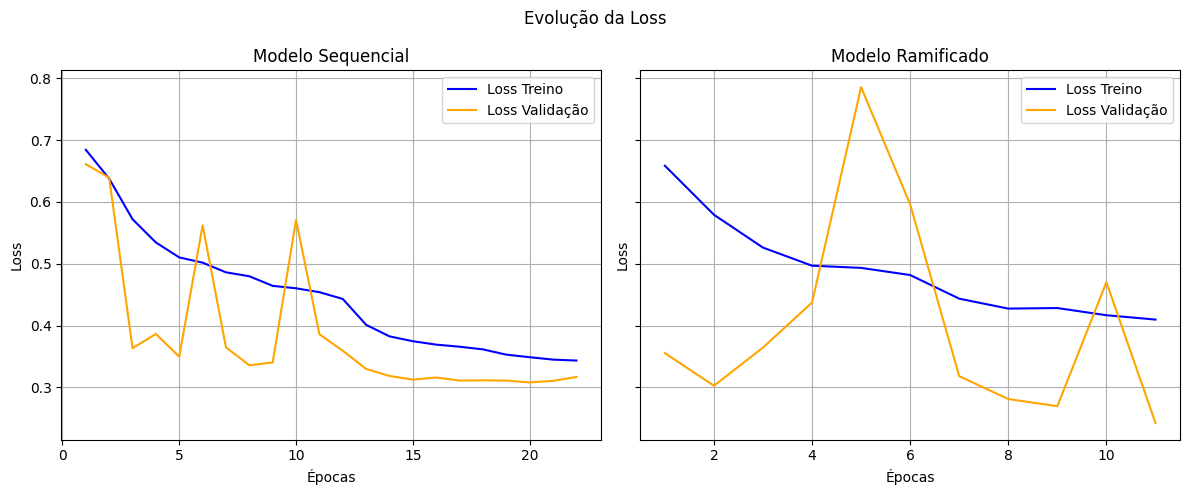

In [46]:
plot_training_history([best_seq_history, best_ram_history], titles=titles)

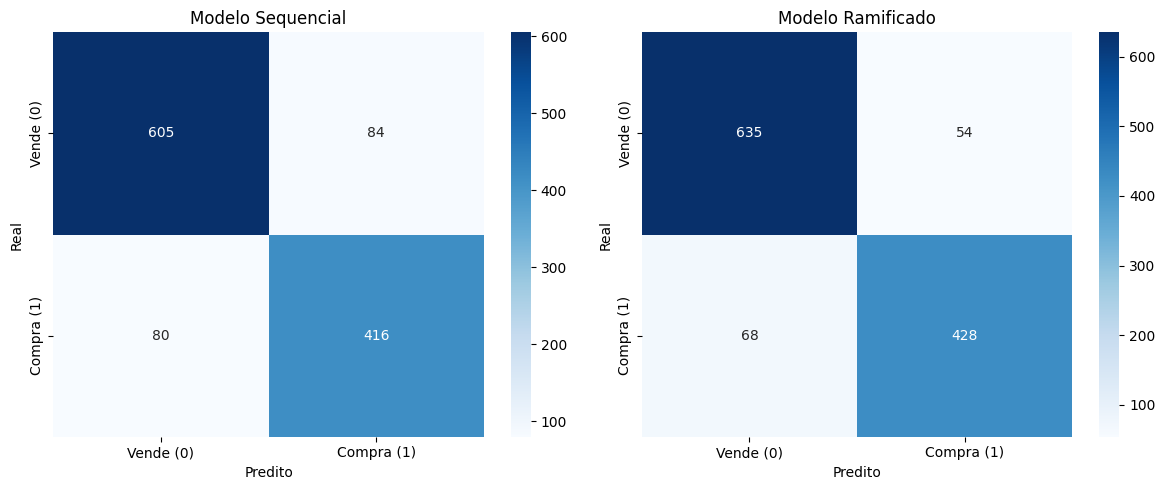

In [47]:
plot_confusion_matrix([best_seq_metrics, best_ram_metrics], titles=titles)

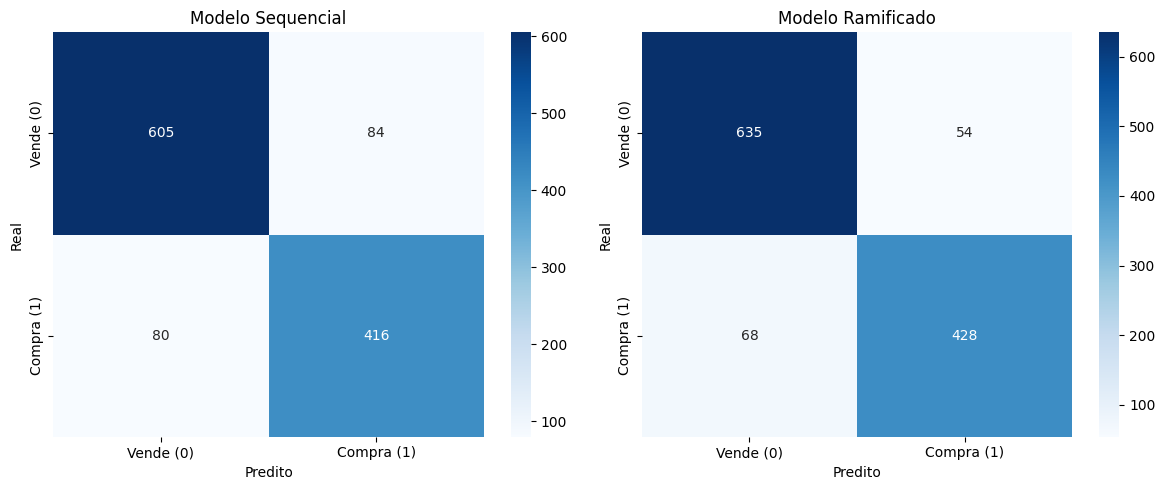

In [48]:
plot_confusion_matrix([best_seq_metrics, best_ram_metrics], titles=titles)

In [49]:
show_classification_reports(
    metrics_list=[best_seq_metrics, best_ram_metrics],
    titles=titles
)

📊 Relatório de Classificação - Modelo Sequencial

Vende (0):
Precision: 0.88
Recall:    0.88
F1-Score:  0.88

Compra (1):
Precision: 0.83
Recall:    0.84
F1-Score:  0.84

Médias:
Acurácia:  0.86
Precision: 0.86
Recall:    0.86
F1-Score:  0.86


📊 Relatório de Classificação - Modelo Ramificado

Vende (0):
Precision: 0.90
Recall:    0.92
F1-Score:  0.91

Compra (1):
Precision: 0.89
Recall:    0.86
F1-Score:  0.88

Médias:
Acurácia:  0.90
Precision: 0.90
Recall:    0.89
F1-Score:  0.89




In [50]:
resultado_backtest = run_backtest(
    predictions=best_seq_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Sequencial",
    stock_name="BBAS3",
    metrics = best_seq_metrics,
    cdi_df = cdi,
    metric_optimization = metric_optimization

)

resultado_backtest = run_backtest(
    predictions=best_ram_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Ramificado",
    stock_name="BBAS3",
    metrics = best_ram_metrics,
    cdi_df = cdi,
    metric_optimization = metric_optimization
)

resultado_backtest

<ipython-input-29-c41ff92325cd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
<ipython-input-29-c41ff92325cd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]


Data          Modelo   Ação Métrica de Otimização  \
0  2025-04-16 12:23:53.362046  CNN Sequencial  BBAS3              val_loss   
1  2025-04-16 12:23:53.391346  CNN Ramificado  BBAS3              val_loss   

   Acurácia  Precision    Recall        F1      Matriz de Confusão  \
0  0.861603   0.857606  0.858397  0.857991  [[605, 84], [80, 416]]   
1  0.897046   0.895619  0.892264  0.893806  [[635, 54], [68, 428]]   

   Saldo Inicial  Saldo Final  Total de Ações  Lucro Total  Lucro (%)  \
0          10000    28.909737           231.0  2823.999596  28.239996   
1          10000    34.754650           338.0  8756.574444  87.565744   

   Lucro (%) CDI  
0       42.26921  
1       42.26921

#### **CSNA3**

In [51]:
X_train, X_test, y_train, y_test, features = preprocess_data(cs_train, cs_test)

In [52]:
janela_curta = features[:7]
janela_longa = features[7:]
X_train1, X_test1, X_train2, X_test2, y_train, y_test, features = preprocess_data(cs_train, cs_test, split_features=[janela_curta,janela_longa])

In [53]:
titles = ["Modelo Sequencial", "Modelo Ramificado"]
prices = cs_test.set_index("Date")["Close"]
metric_optimization = 'val_loss'

In [55]:
best_seq_model, best_seq_history, best_seq_metrics, best_seq_y_pred, df_results = train_model(
    model_fn=model_cnn_sequencial,
    model_path = "BEST_CNN_SEQ_CSNA3.keras",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-16 12:25:33,331] A new study created in memory with name: no-name-61a46553-c13d-489b-aefb-ca27c273bc8f


Epoch 1/43
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5627 - loss: 0.6875
Epoch 1: val_loss improved from inf to 0.67053, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5627 - loss: 0.6874 - val_accuracy: 0.6728 - val_loss: 0.6705 - learning_rate: 3.1640e-04
Epoch 2/43
145/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5786 - loss: 0.6735
Epoch 2: val_loss improved from 0.67053 to 0.57714, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5786 - loss: 0.6734 - val_accuracy: 0.7850 - val_loss: 0.5771 - learning_rate: 3.1640e-04
Epoch 3/43
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6327 - loss: 0.6383
Epoch 3: val_loss improved from 0.57714 to 0.51831, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6334 - loss: 0.6378 - val_accuracy: 0.7740 - val_loss: 0.5183 - learning_r

[I 2025-04-16 12:25:59,114] Trial 0 finished with value: -0.4018205404281616 and parameters: {'epochs': 43, 'batch_size': 32, 'learning_rate': 0.0003164013226902692, 'stop_patience': 9, 'reduce_lr_factor': 0.18617764555435584, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.4018205404281616.


Epoch 1/42
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5587 - loss: 0.6906
Epoch 1: val_loss improved from inf to 0.67110, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5584 - loss: 0.6905 - val_accuracy: 0.5902 - val_loss: 0.6711 - learning_rate: 0.0046
Epoch 2/42
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5842 - loss: 0.6760
Epoch 2: val_loss improved from 0.67110 to 0.57070, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5844 - loss: 0.6752 - val_accuracy: 0.7934 - val_loss: 0.5707 - learning_rate: 0.0046
Epoch 3/42
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6642 - loss: 0.5989
Epoch 3: val_loss improved from 0.57070 to 0.54499, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6646 - loss: 0.5981 - val_accuracy: 0.7926 - val_loss: 0.5450 - learning_rate: 0.0046
Epoch

[I 2025-04-16 12:26:19,587] Trial 1 finished with value: -0.32963716983795166 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.004600046903608582, 'stop_patience': 4, 'reduce_lr_factor': 0.4686480133980394, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.32963716983795166.


Epoch 1/29
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5585 - loss: 0.6920
Epoch 1: val_loss improved from inf to 0.67493, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5582 - loss: 0.6918 - val_accuracy: 0.6290 - val_loss: 0.6749 - learning_rate: 0.0065
Epoch 2/29
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5805 - loss: 0.6670
Epoch 2: val_loss did not improve from 0.67493
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5820 - loss: 0.6650 - val_accuracy: 0.5371 - val_loss: 0.7762 - learning_rate: 0.0065
Epoch 3/29
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6410 - loss: 0.6052
Epoch 3: val_loss improved from 0.67493 to 0.52166, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6419 - loss: 0.6050 - val_accuracy: 0.7513 - val_loss: 0.5217 - learning_rate: 0.0065
Epoch 4/29
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6774 

[I 2025-04-16 12:26:32,327] Trial 2 finished with value: -0.3757564425468445 and parameters: {'epochs': 29, 'batch_size': 64, 'learning_rate': 0.006549240258889382, 'stop_patience': 8, 'reduce_lr_factor': 0.4644093643403917, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.32963716983795166.


Epoch 1/21
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5635 - loss: 0.6858
Epoch 1: val_loss improved from inf to 0.65112, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5638 - loss: 0.6853 - val_accuracy: 0.6594 - val_loss: 0.6511 - learning_rate: 0.0028
Epoch 2/21
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6124 - loss: 0.6394
Epoch 2: val_loss improved from 0.65112 to 0.43074, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6143 - loss: 0.6378 - val_accuracy: 0.8297 - val_loss: 0.4307 - learning_rate: 0.0028
Epoch 3/21
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7093 - loss: 0.5405
Epoch 3: val_loss improved from 0.43074 to 0.40882, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7097 - loss: 0.5401 - val_accuracy: 0.8331 - val_loss: 0.4088 - learning_rate: 0.0

[I 2025-04-16 12:26:50,943] Trial 3 finished with value: -0.32829833030700684 and parameters: {'epochs': 21, 'batch_size': 32, 'learning_rate': 0.0027502139086396167, 'stop_patience': 8, 'reduce_lr_factor': 0.47863453964309144, 'reduce_lr_patience': 5}. Best is trial 3 with value: -0.32829833030700684.


Epoch 1/17
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5561 - loss: 0.6936
Epoch 1: val_loss improved from inf to 0.68504, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5561 - loss: 0.6936 - val_accuracy: 0.5801 - val_loss: 0.6850 - learning_rate: 0.0083
Epoch 2/17
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5718 - loss: 0.6852
Epoch 2: val_loss improved from 0.68504 to 0.68295, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5718 - loss: 0.6852 - val_accuracy: 0.5801 - val_loss: 0.6830 - learning_rate: 0.0083
Epoch 3/17
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5718 - loss: 0.6844
Epoch 3: val_loss improved from 0.68295 to 0.68221, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5718 - loss: 0.6844 - val_accuracy: 0.5801 - val_loss: 0.6822 - learning_rate: 0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-16 12:27:26,434] Trial 4 finished with

Epoch 1/17
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5583 - loss: 0.6829
Epoch 1: val_loss improved from inf to 0.53893, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5588 - loss: 0.6825 - val_accuracy: 0.8272 - val_loss: 0.5389 - learning_rate: 0.0022
Epoch 2/17
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6413 - loss: 0.6093
Epoch 2: val_loss did not improve from 0.53893
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6420 - loss: 0.6087 - val_accuracy: 0.7133 - val_loss: 0.5905 - learning_rate: 0.0022
Epoch 3/17
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7180 - loss: 0.5389
Epoch 3: val_loss improved from 0.53893 to 0.37619, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7181 - loss: 0.5387 - val_accuracy: 0.8406 - val_loss: 0.3762 - learning_rate: 0.0022
Epoch 4/17
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:27:50,103] Trial 5 finished with value: -0.29782646894454956 and parameters: {'epochs': 17, 'batch_size': 16, 'learning_rate': 0.0021528033212739176, 'stop_patience': 5, 'reduce_lr_factor': 0.2952782472626836, 'reduce_lr_patience': 5}. Best is trial 5 with value: -0.29782646894454956.


Epoch 1/30
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5423 - loss: 0.6905
Epoch 1: val_loss improved from inf to 0.68538, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5424 - loss: 0.6904 - val_accuracy: 0.5835 - val_loss: 0.6854 - learning_rate: 0.0095
Epoch 2/30
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5728 - loss: 0.6747
Epoch 2: val_loss improved from 0.68538 to 0.58134, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5726 - loss: 0.6742 - val_accuracy: 0.8187 - val_loss: 0.5813 - learning_rate: 0.0095
Epoch 3/30
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6307 - loss: 0.6309
Epoch 3: val_loss improved from 0.58134 to 0.45140, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6306 - loss: 0.6311 - val_accuracy: 0.8027 - val_loss: 0.4514 - learning_rate: 0.0095
Epoch 

[I 2025-04-16 12:28:02,723] Trial 6 finished with value: -0.3785192370414734 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.009537678346485726, 'stop_patience': 9, 'reduce_lr_factor': 0.3194126977506391, 'reduce_lr_patience': 5}. Best is trial 5 with value: -0.29782646894454956.


Epoch 1/21
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5519 - loss: 0.6928
Epoch 1: val_loss improved from inf to 0.68364, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5520 - loss: 0.6927 - val_accuracy: 0.5801 - val_loss: 0.6836 - learning_rate: 0.0080
Epoch 2/21
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5720 - loss: 0.6850
Epoch 2: val_loss improved from 0.68364 to 0.68232, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5717 - loss: 0.6850 - val_accuracy: 0.5801 - val_loss: 0.6823 - learning_rate: 0.0080
Epoch 3/21
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5719 - loss: 0.6842
Epoch 3: val_loss did not improve from 0.68232
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5718 - loss: 0.6842 - val_accuracy: 0.5801 - val_loss: 0.6835 - learning_rate: 0.0080
Epoch 4/21
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:28:42,673] Trial 7 finished with value: -0.38944706320762634 and parameters: {'epochs': 21, 'batch_size': 16, 'learning_rate': 0.007996865784139842, 'stop_patience': 6, 'reduce_lr_factor': 0.3728454191534418, 'reduce_lr_patience': 2}. Best is trial 5 with value: -0.29782646894454956.


Epoch 1/28
139/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5691 - loss: 0.6838
Epoch 1: val_loss improved from inf to 0.44945, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5695 - loss: 0.6827 - val_accuracy: 0.8255 - val_loss: 0.4494 - learning_rate: 0.0028
Epoch 2/28
136/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6288 - loss: 0.6194
Epoch 2: val_loss did not improve from 0.44945
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6312 - loss: 0.6178 - val_accuracy: 0.7749 - val_loss: 0.4498 - learning_rate: 0.0028
Epoch 3/28
135/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7240 - loss: 0.5361
Epoch 3: val_loss improved from 0.44945 to 0.38978, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7262 - loss: 0.5330 - val_accuracy: 0.8035 - val_loss: 0.3898 - learning_rate: 0.0028
Epoch 4/28
137/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:28:56,044] Trial 8 finished with value: -0.3110678791999817 and parameters: {'epochs': 28, 'batch_size': 32, 'learning_rate': 0.0027682759398875894, 'stop_patience': 3, 'reduce_lr_factor': 0.23299742496811626, 'reduce_lr_patience': 5}. Best is trial 5 with value: -0.29782646894454956.


Epoch 1/19
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5530 - loss: 0.6916
Epoch 1: val_loss improved from inf to 0.68611, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5530 - loss: 0.6912 - val_accuracy: 0.6020 - val_loss: 0.6861 - learning_rate: 0.0052
Epoch 2/19
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5921 - loss: 0.6598
Epoch 2: val_loss improved from 0.68611 to 0.55368, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5928 - loss: 0.6585 - val_accuracy: 0.7361 - val_loss: 0.5537 - learning_rate: 0.0052
Epoch 3/19
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6544 - loss: 0.5946
Epoch 3: val_loss did not improve from 0.55368
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6560 - loss: 0.5936 - val_accuracy: 0.6771 - val_loss: 0.5574 - learning_rate: 0.0052
Epoch 4/19
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7009 

[I 2025-04-16 12:29:09,498] Trial 9 finished with value: -0.37517571449279785 and parameters: {'epochs': 19, 'batch_size': 64, 'learning_rate': 0.005160920842925193, 'stop_patience': 6, 'reduce_lr_factor': 0.12011507150535401, 'reduce_lr_patience': 4}. Best is trial 5 with value: -0.29782646894454956.


Epoch 1/11
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5485 - loss: 0.6881
Epoch 1: val_loss improved from inf to 0.63878, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5488 - loss: 0.6880 - val_accuracy: 0.6231 - val_loss: 0.6388 - learning_rate: 5.9781e-04
Epoch 2/11
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6163 - loss: 0.6435
Epoch 2: val_loss improved from 0.63878 to 0.44944, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6166 - loss: 0.6433 - val_accuracy: 0.7968 - val_loss: 0.4494 - learning_rate: 5.9781e-04
Epoch 3/11
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6944 - loss: 0.5683
Epoch 3: val_loss improved from 0.44944 to 0.39874, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6945 - loss: 0.5679 - val_accuracy: 0.8078 - val_loss: 0.3987 - learning_r

[I 2025-04-16 12:29:34,736] Trial 10 finished with value: -0.29956063628196716 and parameters: {'epochs': 11, 'batch_size': 16, 'learning_rate': 0.0005978109547317113, 'stop_patience': 5, 'reduce_lr_factor': 0.2864098429819846, 'reduce_lr_patience': 4}. Best is trial 5 with value: -0.29782646894454956.


Epoch 1/10
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4656 - loss: 0.6959
Epoch 1: val_loss improved from inf to 0.69772, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4664 - loss: 0.6958 - val_accuracy: 0.4334 - val_loss: 0.6977 - learning_rate: 1.8120e-05
Epoch 2/10
284/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5710 - loss: 0.6912
Epoch 2: val_loss improved from 0.69772 to 0.68541, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5706 - loss: 0.6912 - val_accuracy: 0.5801 - val_loss: 0.6854 - learning_rate: 1.8120e-05
Epoch 3/10
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5693 - loss: 0.6891
Epoch 3: val_loss improved from 0.68541 to 0.67696, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5693 - loss: 0.6891 - val_accuracy: 0.5801 - val_loss: 0.6770 - learning_r

[I 2025-04-16 12:29:55,592] Trial 11 finished with value: -0.6351190209388733 and parameters: {'epochs': 10, 'batch_size': 16, 'learning_rate': 1.8120313044387012e-05, 'stop_patience': 5, 'reduce_lr_factor': 0.27991528620137096, 'reduce_lr_patience': 4}. Best is trial 5 with value: -0.29782646894454956.


Epoch 1/10
283/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5515 - loss: 0.6826
Epoch 1: val_loss improved from inf to 0.66763, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5527 - loss: 0.6819 - val_accuracy: 0.5616 - val_loss: 0.6676 - learning_rate: 0.0019
Epoch 2/10
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6595 - loss: 0.6070
Epoch 2: val_loss improved from 0.66763 to 0.35556, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6598 - loss: 0.6067 - val_accuracy: 0.8390 - val_loss: 0.3556 - learning_rate: 0.0019
Epoch 3/10
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7330 - loss: 0.5092
Epoch 3: val_loss did not improve from 0.35556
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7331 - loss: 0.5091 - val_accuracy: 0.8533 - val_loss: 0.3848 - learning_rate: 0.0019
Epoch 4/10
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:30:17,192] Trial 12 finished with value: -0.2980720102787018 and parameters: {'epochs': 10, 'batch_size': 16, 'learning_rate': 0.0018574373174231897, 'stop_patience': 4, 'reduce_lr_factor': 0.3087214091207781, 'reduce_lr_patience': 4}. Best is trial 5 with value: -0.29782646894454956.


Epoch 1/14
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5693 - loss: 0.6865
Epoch 1: val_loss improved from inf to 0.62871, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5691 - loss: 0.6862 - val_accuracy: 0.6256 - val_loss: 0.6287 - learning_rate: 0.0023
Epoch 2/14
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6308 - loss: 0.6200
Epoch 2: val_loss improved from 0.62871 to 0.44236, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6315 - loss: 0.6194 - val_accuracy: 0.7740 - val_loss: 0.4424 - learning_rate: 0.0023
Epoch 3/14
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6892 - loss: 0.5570
Epoch 3: val_loss improved from 0.44236 to 0.35370, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6897 - loss: 0.5565 - val_accuracy: 0.8465 - val_loss: 0.3537 - learning_rate: 0.0

[I 2025-04-16 12:30:44,423] Trial 13 finished with value: -0.30649131536483765 and parameters: {'epochs': 14, 'batch_size': 16, 'learning_rate': 0.002287946445775667, 'stop_patience': 3, 'reduce_lr_factor': 0.35966806995978734, 'reduce_lr_patience': 5}. Best is trial 5 with value: -0.29782646894454956.


Epoch 1/50
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5436 - loss: 0.6846
Epoch 1: val_loss improved from inf to 0.54088, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5439 - loss: 0.6845 - val_accuracy: 0.8187 - val_loss: 0.5409 - learning_rate: 0.0020
Epoch 2/50
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6381 - loss: 0.6262
Epoch 2: val_loss improved from 0.54088 to 0.39901, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6390 - loss: 0.6253 - val_accuracy: 0.8162 - val_loss: 0.3990 - learning_rate: 0.0020
Epoch 3/50
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6985 - loss: 0.5502
Epoch 3: val_loss improved from 0.39901 to 0.35299, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6988 - loss: 0.5498 - val_accuracy: 0.8465 - val_loss: 0.3530 - learning_rate: 0.0

[I 2025-04-16 12:31:25,788] Trial 14 finished with value: -0.2898769974708557 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.0019623448105982716, 'stop_patience': 4, 'reduce_lr_factor': 0.2169771039854446, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/49
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5663 - loss: 0.6897
Epoch 1: val_loss improved from inf to 0.69884, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5660 - loss: 0.6897 - val_accuracy: 0.4486 - val_loss: 0.6988 - learning_rate: 0.0041
Epoch 2/49
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5835 - loss: 0.6606
Epoch 2: val_loss improved from 0.69884 to 0.60122, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5841 - loss: 0.6602 - val_accuracy: 0.7386 - val_loss: 0.6012 - learning_rate: 0.0041
Epoch 3/49
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6754 - loss: 0.5730
Epoch 3: val_loss improved from 0.60122 to 0.37200, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6762 - loss: 0.5721 - val_accuracy: 0.8347 - val_loss: 0.3720 - learning_rate: 0.0

[I 2025-04-16 12:31:55,652] Trial 15 finished with value: -0.3103595972061157 and parameters: {'epochs': 49, 'batch_size': 16, 'learning_rate': 0.004079638194516417, 'stop_patience': 5, 'reduce_lr_factor': 0.1550174478359228, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/37
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5707 - loss: 0.6780
Epoch 1: val_loss improved from inf to 0.48611, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5712 - loss: 0.6773 - val_accuracy: 0.8010 - val_loss: 0.4861 - learning_rate: 0.0016
Epoch 2/37
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6543 - loss: 0.5939
Epoch 2: val_loss improved from 0.48611 to 0.37593, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6546 - loss: 0.5936 - val_accuracy: 0.8288 - val_loss: 0.3759 - learning_rate: 0.0016
Epoch 3/37
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7301 - loss: 0.5042
Epoch 3: val_loss did not improve from 0.37593
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7303 - loss: 0.5039 - val_accuracy: 0.8187 - val_loss: 0.3858 - learning_rate: 0.0016
Epoch 4/37
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:32:25,973] Trial 16 finished with value: -0.3249908685684204 and parameters: {'epochs': 37, 'batch_size': 16, 'learning_rate': 0.0015987502624400982, 'stop_patience': 4, 'reduce_lr_factor': 0.20521676090127494, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/35
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5482 - loss: 0.6876
Epoch 1: val_loss improved from inf to 0.64662, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5488 - loss: 0.6873 - val_accuracy: 0.5927 - val_loss: 0.6466 - learning_rate: 0.0035
Epoch 2/35
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6259 - loss: 0.6295
Epoch 2: val_loss improved from 0.64662 to 0.40851, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6266 - loss: 0.6290 - val_accuracy: 0.8069 - val_loss: 0.4085 - learning_rate: 0.0035
Epoch 3/35
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7159 - loss: 0.5356
Epoch 3: val_loss did not improve from 0.40851
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7161 - loss: 0.5355 - val_accuracy: 0.8390 - val_loss: 0.4191 - learning_rate: 0.0035
Epoch 4/35
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:32:57,957] Trial 17 finished with value: -0.3172440528869629 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.003519307400697547, 'stop_patience': 7, 'reduce_lr_factor': 0.23380630108153513, 'reduce_lr_patience': 2}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/25
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5654 - loss: 0.6914
Epoch 1: val_loss improved from inf to 0.68928, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5651 - loss: 0.6913 - val_accuracy: 0.5531 - val_loss: 0.6893 - learning_rate: 0.0058
Epoch 2/25
282/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5755 - loss: 0.6702
Epoch 2: val_loss did not improve from 0.68928
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5759 - loss: 0.6695 - val_accuracy: 0.4553 - val_loss: 0.7390 - learning_rate: 0.0058
Epoch 3/25
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6537 - loss: 0.5979
Epoch 3: val_loss improved from 0.68928 to 0.43935, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6544 - loss: 0.5976 - val_accuracy: 0.7985 - val_loss: 0.4394 - learning_rate: 0.0058
Epoch 4/25
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:33:13,838] Trial 18 finished with value: -0.43935054540634155 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.005780946639016323, 'stop_patience': 3, 'reduce_lr_factor': 0.10856736599303163, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/50
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5647 - loss: 0.6834
Epoch 1: val_loss improved from inf to 0.48691, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5654 - loss: 0.6826 - val_accuracy: 0.7732 - val_loss: 0.4869 - learning_rate: 0.0013
Epoch 2/50
145/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6485 - loss: 0.5972
Epoch 2: val_loss improved from 0.48691 to 0.48632, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6499 - loss: 0.5961 - val_accuracy: 0.7563 - val_loss: 0.4863 - learning_rate: 0.0013
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7196 - loss: 0.5199
Epoch 3: val_loss improved from 0.48632 to 0.39027, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7197 - loss: 0.5197 - val_accuracy: 0.8153 - val_loss: 0.3903 - learning_rate: 0.0

[I 2025-04-16 12:33:40,789] Trial 19 finished with value: -0.2981717586517334 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0012603559830860213, 'stop_patience': 10, 'reduce_lr_factor': 0.2515345745608326, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/35
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5626 - loss: 0.6859
Epoch 1: val_loss improved from inf to 0.66454, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5626 - loss: 0.6856 - val_accuracy: 0.6298 - val_loss: 0.6645 - learning_rate: 0.0033
Epoch 2/35
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5821 - loss: 0.6610
Epoch 2: val_loss improved from 0.66454 to 0.56850, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5833 - loss: 0.6600 - val_accuracy: 0.7209 - val_loss: 0.5685 - learning_rate: 0.0033
Epoch 3/35
282/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6865 - loss: 0.5656
Epoch 3: val_loss did not improve from 0.56850
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6873 - loss: 0.5645 - val_accuracy: 0.5675 - val_loss: 0.6396 - learning_rate: 0.0033
Epoch 4/35
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:34:03,809] Trial 20 finished with value: -0.30360233783721924 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.0032756089713337775, 'stop_patience': 5, 'reduce_lr_factor': 0.17241037702511375, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/15
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5643 - loss: 0.6822
Epoch 1: val_loss improved from inf to 0.53510, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5646 - loss: 0.6819 - val_accuracy: 0.8069 - val_loss: 0.5351 - learning_rate: 0.0018
Epoch 2/15
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6366 - loss: 0.6257
Epoch 2: val_loss improved from 0.53510 to 0.39291, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6368 - loss: 0.6255 - val_accuracy: 0.8255 - val_loss: 0.3929 - learning_rate: 0.0018
Epoch 3/15
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6908 - loss: 0.5622
Epoch 3: val_loss did not improve from 0.39291
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6910 - loss: 0.5620 - val_accuracy: 0.7951 - val_loss: 0.4787 - learning_rate: 0.0018
Epoch 4/15
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:34:28,506] Trial 21 finished with value: -0.3193610906600952 and parameters: {'epochs': 15, 'batch_size': 16, 'learning_rate': 0.0018200419989535662, 'stop_patience': 4, 'reduce_lr_factor': 0.3208032880543353, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/24
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5652 - loss: 0.6831
Epoch 1: val_loss improved from inf to 0.49998, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5653 - loss: 0.6829 - val_accuracy: 0.8069 - val_loss: 0.5000 - learning_rate: 0.0012
Epoch 2/24
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6141 - loss: 0.6294
Epoch 2: val_loss improved from 0.49998 to 0.42144, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6154 - loss: 0.6286 - val_accuracy: 0.8061 - val_loss: 0.4214 - learning_rate: 0.0012
Epoch 3/24
284/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7262 - loss: 0.5276
Epoch 3: val_loss did not improve from 0.42144
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7266 - loss: 0.5273 - val_accuracy: 0.8331 - val_loss: 0.4265 - learning_rate: 0.0012
Epoch 4/24
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:34:54,764] Trial 22 finished with value: -0.3002440929412842 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 0.0012462363491009159, 'stop_patience': 4, 'reduce_lr_factor': 0.36118359567639213, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/14
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5518 - loss: 0.6883
Epoch 1: val_loss improved from inf to 0.55619, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5518 - loss: 0.6883 - val_accuracy: 0.8069 - val_loss: 0.5562 - learning_rate: 0.0039
Epoch 2/14
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6235 - loss: 0.6256
Epoch 2: val_loss improved from 0.55619 to 0.42372, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6238 - loss: 0.6254 - val_accuracy: 0.7968 - val_loss: 0.4237 - learning_rate: 0.0039
Epoch 3/14
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7077 - loss: 0.5481
Epoch 3: val_loss improved from 0.42372 to 0.34885, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7082 - loss: 0.5473 - val_accuracy: 0.8423 - val_loss: 0.3488 - learning_rate: 0.0

[I 2025-04-16 12:35:23,389] Trial 23 finished with value: -0.29543864727020264 and parameters: {'epochs': 14, 'batch_size': 16, 'learning_rate': 0.00392083275717176, 'stop_patience': 6, 'reduce_lr_factor': 0.26614562466477826, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/14
282/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5601 - loss: 0.6884
Epoch 1: val_loss improved from inf to 0.53626, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5602 - loss: 0.6880 - val_accuracy: 0.7344 - val_loss: 0.5363 - learning_rate: 0.0039
Epoch 2/14
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5643 - loss: 0.6607
Epoch 2: val_loss did not improve from 0.53626
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5651 - loss: 0.6603 - val_accuracy: 0.6425 - val_loss: 0.5989 - learning_rate: 0.0039
Epoch 3/14
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6437 - loss: 0.6045
Epoch 3: val_loss improved from 0.53626 to 0.38410, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6443 - loss: 0.6040 - val_accuracy: 0.8238 - val_loss: 0.3841 - learning_rate: 0.0039
Epoch 4/14
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:35:53,749] Trial 24 finished with value: -0.3468937873840332 and parameters: {'epochs': 14, 'batch_size': 16, 'learning_rate': 0.0038798915641264182, 'stop_patience': 6, 'reduce_lr_factor': 0.24986893853465902, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/44
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5546 - loss: 0.6874
Epoch 1: val_loss improved from inf to 0.59883, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5549 - loss: 0.6870 - val_accuracy: 0.6383 - val_loss: 0.5988 - learning_rate: 0.0027
Epoch 2/44
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6281 - loss: 0.6286
Epoch 2: val_loss improved from 0.59883 to 0.53738, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6293 - loss: 0.6277 - val_accuracy: 0.7909 - val_loss: 0.5374 - learning_rate: 0.0027
Epoch 3/44
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7045 - loss: 0.5547
Epoch 3: val_loss improved from 0.53738 to 0.43683, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7047 - loss: 0.5544 - val_accuracy: 0.8390 - val_loss: 0.4368 - learning_rate: 0.0

[I 2025-04-16 12:36:14,312] Trial 25 finished with value: -0.34446802735328674 and parameters: {'epochs': 44, 'batch_size': 16, 'learning_rate': 0.002707850442932669, 'stop_patience': 6, 'reduce_lr_factor': 0.20533629107102663, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/25
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5613 - loss: 0.6900
Epoch 1: val_loss improved from inf to 0.68507, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5610 - loss: 0.6898 - val_accuracy: 0.6821 - val_loss: 0.6851 - learning_rate: 0.0049
Epoch 2/25
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6074 - loss: 0.6386
Epoch 2: val_loss improved from 0.68507 to 0.44613, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6082 - loss: 0.6379 - val_accuracy: 0.8339 - val_loss: 0.4461 - learning_rate: 0.0049
Epoch 3/25
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6983 - loss: 0.5669
Epoch 3: val_loss improved from 0.44613 to 0.36124, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6987 - loss: 0.5661 - val_accuracy: 0.8516 - val_loss: 0.3612 - learning_rate: 0.0

[I 2025-04-16 12:36:49,611] Trial 26 finished with value: -0.2938888967037201 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.004877421922747026, 'stop_patience': 5, 'reduce_lr_factor': 0.2743348839442632, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/25
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5666 - loss: 0.6930
Epoch 1: val_loss improved from inf to 0.68539, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5664 - loss: 0.6930 - val_accuracy: 0.5801 - val_loss: 0.6854 - learning_rate: 0.0062
Epoch 2/25
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5672 - loss: 0.6769
Epoch 2: val_loss improved from 0.68539 to 0.66759, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5667 - loss: 0.6767 - val_accuracy: 0.5953 - val_loss: 0.6676 - learning_rate: 0.0062
Epoch 3/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5805 - loss: 0.6584
Epoch 3: val_loss did not improve from 0.66759
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5805 - loss: 0.6584 - val_accuracy: 0.4309 - val_loss: 0.6864 - learning_rate: 0.0062
Epoch 4/25
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:37:26,472] Trial 27 finished with value: -0.3043276369571686 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.0061621301023366964, 'stop_patience': 7, 'reduce_lr_factor': 0.2651369415513773, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/38
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5590 - loss: 0.6862
Epoch 1: val_loss improved from inf to 0.62285, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5591 - loss: 0.6860 - val_accuracy: 0.5911 - val_loss: 0.6228 - learning_rate: 0.0048
Epoch 2/38
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6170 - loss: 0.6386
Epoch 2: val_loss improved from 0.62285 to 0.43148, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6175 - loss: 0.6382 - val_accuracy: 0.8145 - val_loss: 0.4315 - learning_rate: 0.0048
Epoch 3/38
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6766 - loss: 0.5874
Epoch 3: val_loss did not improve from 0.43148
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6766 - loss: 0.5871 - val_accuracy: 0.6610 - val_loss: 0.6109 - learning_rate: 0.0048
Epoch 4/38
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:37:41,110] Trial 28 finished with value: -0.3168051838874817 and parameters: {'epochs': 38, 'batch_size': 32, 'learning_rate': 0.004780545138840263, 'stop_patience': 5, 'reduce_lr_factor': 0.15012955598365546, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.2898769974708557.


Epoch 1/33
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5613 - loss: 0.6899
Epoch 1: val_loss improved from inf to 0.70102, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5611 - loss: 0.6897 - val_accuracy: 0.4874 - val_loss: 0.7010 - learning_rate: 0.0067
Epoch 2/33
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5905 - loss: 0.6471
Epoch 2: val_loss did not improve from 0.70102
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5953 - loss: 0.6439 - val_accuracy: 0.6172 - val_loss: 0.8819 - learning_rate: 0.0067
Epoch 3/33
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6655 - loss: 0.6001
Epoch 3: val_loss improved from 0.70102 to 0.42807, saving model to /content/models/BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6693 - loss: 0.5954 - val_accuracy: 0.8263 - val_loss: 0.4281 - learning_rate: 0.0067
Epoch 4/33
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7389 

[I 2025-04-16 12:37:53,319] Trial 29 finished with value: -0.33952510356903076 and parameters: {'epochs': 33, 'batch_size': 64, 'learning_rate': 0.006743501998871542, 'stop_patience': 8, 'reduce_lr_factor': 0.2117515846512946, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.2898769974708557.


In [56]:
best_ram_model, best_ram_history, best_ram_metrics, best_ram_y_pred, df_results = train_model(
    model_fn=model_cnn_ramificado,
    model_path = "BEST_CNN_RAM_CSNA3.keras",
    X_train=[X_train1, X_train2],
    y_train=y_train,
    X_test=[X_test1, X_test2],
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-16 12:37:53,331] A new study created in memory with name: no-name-ac2965d6-e05e-4b7b-9d67-890844b4a8ad


Epoch 1/28
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5709 - loss: 0.6864
Epoch 1: val_loss improved from inf to 0.71876, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5723 - loss: 0.6844 - val_accuracy: 0.6391 - val_loss: 0.7188 - learning_rate: 0.0065
Epoch 2/28
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6792 - loss: 0.5792
Epoch 2: val_loss improved from 0.71876 to 0.41007, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6814 - loss: 0.5772 - val_accuracy: 0.8170 - val_loss: 0.4101 - learning_rate: 0.0065
Epoch 3/28
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7444 - loss: 0.5166
Epoch 3: val_loss improved from 0.41007 to 0.31878, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7435 - loss: 0.5173 - val_accuracy: 0.8609 - val_loss: 0.3188 - learning_rate: 0.0065
Epoch 4/

[I 2025-04-16 12:38:04,475] Trial 0 finished with value: -0.3187812566757202 and parameters: {'epochs': 28, 'batch_size': 64, 'learning_rate': 0.00649702022870213, 'stop_patience': 9, 'reduce_lr_factor': 0.1676045568328871, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.3187812566757202.


Epoch 1/23
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5906 - loss: 0.6757
Epoch 1: val_loss improved from inf to 0.47605, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5917 - loss: 0.6748 - val_accuracy: 0.7572 - val_loss: 0.4761 - learning_rate: 0.0079
Epoch 2/23
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7025 - loss: 0.5643
Epoch 2: val_loss did not improve from 0.47605
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7034 - loss: 0.5629 - val_accuracy: 0.7243 - val_loss: 0.6023 - learning_rate: 0.0079
Epoch 3/23
136/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7418 - loss: 0.4920
Epoch 3: val_loss did not improve from 0.47605
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7430 - loss: 0.4902 - val_accuracy: 0.7631 - val_loss: 0.7765 - learning_rate: 0.0079
Epoch 4/23
140/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7582 - loss: 0.4596
Epoch 4: val_loss did not improve 

[I 2025-04-16 12:38:20,936] Trial 1 finished with value: -0.33889251947402954 and parameters: {'epochs': 23, 'batch_size': 32, 'learning_rate': 0.007926857703419242, 'stop_patience': 8, 'reduce_lr_factor': 0.36579393657247705, 'reduce_lr_patience': 4}. Best is trial 0 with value: -0.3187812566757202.


Epoch 1/14
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5957 - loss: 0.6691
Epoch 1: val_loss improved from inf to 0.42914, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5975 - loss: 0.6676 - val_accuracy: 0.8196 - val_loss: 0.4291 - learning_rate: 0.0046
Epoch 2/14
135/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6873 - loss: 0.5690
Epoch 2: val_loss improved from 0.42914 to 0.34847, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6895 - loss: 0.5669 - val_accuracy: 0.8609 - val_loss: 0.3485 - learning_rate: 0.0046
Epoch 3/14
137/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7354 - loss: 0.5141
Epoch 3: val_loss improved from 0.34847 to 0.32704, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7367 - loss: 0.5124 - val_accuracy: 0.8558 - val_loss: 0.3270 - learning_rate: 0.0

[I 2025-04-16 12:38:38,440] Trial 2 finished with value: -0.276626855134964 and parameters: {'epochs': 14, 'batch_size': 32, 'learning_rate': 0.0045854152404276975, 'stop_patience': 7, 'reduce_lr_factor': 0.24509040089695422, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.276626855134964.


Epoch 1/50
281/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5845 - loss: 0.6778
Epoch 1: val_loss improved from inf to 0.52616, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5860 - loss: 0.6760 - val_accuracy: 0.7631 - val_loss: 0.5262 - learning_rate: 0.0025
Epoch 2/50
282/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6898 - loss: 0.5776
Epoch 2: val_loss improved from 0.52616 to 0.32993, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6907 - loss: 0.5761 - val_accuracy: 0.8592 - val_loss: 0.3299 - learning_rate: 0.0025
Epoch 3/50
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7309 - loss: 0.5085
Epoch 3: val_loss did not improve from 0.32993
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7317 - loss: 0.5076 - val_accuracy: 0.8238 - val_loss: 0.4229 - learning_rate: 0.0025
Epoch 4/50
280/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:38:56,609] Trial 3 finished with value: -0.282040536403656 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.002501587489712273, 'stop_patience': 8, 'reduce_lr_factor': 0.46563653667940297, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.276626855134964.


Epoch 1/47
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5998 - loss: 0.6779
Epoch 1: val_loss improved from inf to 0.45515, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6005 - loss: 0.6770 - val_accuracy: 0.7968 - val_loss: 0.4551 - learning_rate: 0.0040
Epoch 2/47
284/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7272 - loss: 0.5444
Epoch 2: val_loss improved from 0.45515 to 0.32387, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7274 - loss: 0.5438 - val_accuracy: 0.8710 - val_loss: 0.3239 - learning_rate: 0.0040
Epoch 3/47
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7609 - loss: 0.4626
Epoch 3: val_loss did not improve from 0.32387
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7610 - loss: 0.4625 - val_accuracy: 0.8339 - val_loss: 0.4475 - learning_rate: 0.0040
Epoch 4/47
282/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:39:09,574] Trial 4 finished with value: -0.2897282838821411 and parameters: {'epochs': 47, 'batch_size': 16, 'learning_rate': 0.003994372720786734, 'stop_patience': 3, 'reduce_lr_factor': 0.4830346459034074, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.276626855134964.


Epoch 1/35
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5723 - loss: 0.6929
Epoch 1: val_loss improved from inf to 0.56485, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5725 - loss: 0.6926 - val_accuracy: 0.6535 - val_loss: 0.5648 - learning_rate: 0.0100
Epoch 2/35
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6514 - loss: 0.5976
Epoch 2: val_loss improved from 0.56485 to 0.47492, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6516 - loss: 0.5974 - val_accuracy: 0.7420 - val_loss: 0.4749 - learning_rate: 0.0100
Epoch 3/35
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7227 - loss: 0.5134
Epoch 3: val_loss improved from 0.47492 to 0.29755, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7228 - loss: 0.5133 - val_accuracy: 0.8718 - val_loss: 0.2975 - learning_rate: 0.0

[I 2025-04-16 12:39:32,433] Trial 5 finished with value: -0.2901764214038849 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.009998894005729722, 'stop_patience': 8, 'reduce_lr_factor': 0.13176983643949647, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.276626855134964.


Epoch 1/33
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5794 - loss: 0.6701
Epoch 1: val_loss improved from inf to 0.40202, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5807 - loss: 0.6690 - val_accuracy: 0.8516 - val_loss: 0.4020 - learning_rate: 0.0012
Epoch 2/33
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6977 - loss: 0.5715
Epoch 2: val_loss improved from 0.40202 to 0.38424, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6985 - loss: 0.5705 - val_accuracy: 0.8415 - val_loss: 0.3842 - learning_rate: 0.0012
Epoch 3/33
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7652 - loss: 0.4956
Epoch 3: val_loss improved from 0.38424 to 0.31811, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7651 - loss: 0.4954 - val_accuracy: 0.8659 - val_loss: 0.3181 - learning_rate: 0.0

[I 2025-04-16 12:39:59,148] Trial 6 finished with value: -0.2684623599052429 and parameters: {'epochs': 33, 'batch_size': 16, 'learning_rate': 0.0011826219609158651, 'stop_patience': 8, 'reduce_lr_factor': 0.21276000477605994, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/40
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5723 - loss: 0.6834
Epoch 1: val_loss improved from inf to 0.41419, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5736 - loss: 0.6821 - val_accuracy: 0.8356 - val_loss: 0.4142 - learning_rate: 0.0084
Epoch 2/40
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6915 - loss: 0.5656
Epoch 2: val_loss improved from 0.41419 to 0.29637, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6916 - loss: 0.5654 - val_accuracy: 0.8752 - val_loss: 0.2964 - learning_rate: 0.0084
Epoch 3/40
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7390 - loss: 0.4962
Epoch 3: val_loss improved from 0.29637 to 0.28720, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7390 - loss: 0.4962 - val_accuracy: 0.8727 - val_loss: 0.2872 - learning_rate: 0.0

[I 2025-04-16 12:40:16,881] Trial 7 finished with value: -0.28719648718833923 and parameters: {'epochs': 40, 'batch_size': 16, 'learning_rate': 0.008384358131693522, 'stop_patience': 8, 'reduce_lr_factor': 0.15192117245354445, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/45
277/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5572 - loss: 0.6934
Epoch 1: val_loss improved from inf to 0.56864, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5588 - loss: 0.6913 - val_accuracy: 0.6973 - val_loss: 0.5686 - learning_rate: 0.0093
Epoch 2/45
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6272 - loss: 0.6262
Epoch 2: val_loss improved from 0.56864 to 0.36039, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6279 - loss: 0.6255 - val_accuracy: 0.8432 - val_loss: 0.3604 - learning_rate: 0.0093
Epoch 3/45
284/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6822 - loss: 0.5538
Epoch 3: val_loss did not improve from 0.36039
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6828 - loss: 0.5530 - val_accuracy: 0.7150 - val_loss: 0.4580 - learning_rate: 0.0093
Epoch 4/45
280/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:40:38,717] Trial 8 finished with value: -0.31571778655052185 and parameters: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.009299093699373756, 'stop_patience': 7, 'reduce_lr_factor': 0.49572202292197565, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/32
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5591 - loss: 0.6830
Epoch 1: val_loss improved from inf to 0.43446, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5601 - loss: 0.6823 - val_accuracy: 0.8482 - val_loss: 0.4345 - learning_rate: 0.0051
Epoch 2/32
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6967 - loss: 0.5711
Epoch 2: val_loss improved from 0.43446 to 0.33302, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6978 - loss: 0.5693 - val_accuracy: 0.8626 - val_loss: 0.3330 - learning_rate: 0.0051
Epoch 3/32
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7327 - loss: 0.5072
Epoch 3: val_loss did not improve from 0.33302
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7329 - loss: 0.5070 - val_accuracy: 0.7968 - val_loss: 0.4056 - learning_rate: 0.0051
Epoch 4/32
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7728 -

[I 2025-04-16 12:40:48,108] Trial 9 finished with value: -0.2738167941570282 and parameters: {'epochs': 32, 'batch_size': 64, 'learning_rate': 0.005080693550756696, 'stop_patience': 6, 'reduce_lr_factor': 0.3824720050789687, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/20
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5818 - loss: 0.6798
Epoch 1: val_loss improved from inf to 0.55050, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5823 - loss: 0.6795 - val_accuracy: 0.8137 - val_loss: 0.5505 - learning_rate: 4.2920e-04
Epoch 2/20
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6664 - loss: 0.6172
Epoch 2: val_loss improved from 0.55050 to 0.41837, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6670 - loss: 0.6166 - val_accuracy: 0.8432 - val_loss: 0.4184 - learning_rate: 4.2920e-04
Epoch 3/20
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7467 - loss: 0.5542
Epoch 3: val_loss improved from 0.41837 to 0.39164, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7463 - loss: 0.5539 - val_accuracy: 0.8423 - val_loss: 0.3916 - learning_r

[I 2025-04-16 12:41:12,658] Trial 10 finished with value: -0.2864265739917755 and parameters: {'epochs': 20, 'batch_size': 32, 'learning_rate': 0.0004292031099679942, 'stop_patience': 10, 'reduce_lr_factor': 0.24803423707277755, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/33
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5624 - loss: 0.6869
Epoch 1: val_loss improved from inf to 0.63206, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5632 - loss: 0.6866 - val_accuracy: 0.7841 - val_loss: 0.6321 - learning_rate: 1.3592e-04
Epoch 2/33
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6173 - loss: 0.6688
Epoch 2: val_loss improved from 0.63206 to 0.60289, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6167 - loss: 0.6687 - val_accuracy: 0.8246 - val_loss: 0.6029 - learning_rate: 1.3592e-04
Epoch 3/33
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6320 - loss: 0.6561
Epoch 3: val_loss improved from 0.60289 to 0.58551, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6309 - loss: 0.6558 - val_accuracy: 0.7960 - val_loss: 0.5855 - learning_rate: 1.359

[I 2025-04-16 12:41:26,515] Trial 11 finished with value: -0.38142067193984985 and parameters: {'epochs': 33, 'batch_size': 64, 'learning_rate': 0.00013591788144531988, 'stop_patience': 5, 'reduce_lr_factor': 0.35642216839236235, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/27
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5707 - loss: 0.6774
Epoch 1: val_loss improved from inf to 0.48401, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5745 - loss: 0.6748 - val_accuracy: 0.7445 - val_loss: 0.4840 - learning_rate: 0.0023
Epoch 2/27
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7102 - loss: 0.5692
Epoch 2: val_loss improved from 0.48401 to 0.35656, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7117 - loss: 0.5671 - val_accuracy: 0.8457 - val_loss: 0.3566 - learning_rate: 0.0023
Epoch 3/27
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7227 - loss: 0.5179
Epoch 3: val_loss improved from 0.35656 to 0.33741, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7245 - loss: 0.5168 - val_accuracy: 0.8541 - val_loss: 0.3374 - learning_rate: 0.0023
Epoch 4/

[I 2025-04-16 12:41:45,098] Trial 12 finished with value: -0.27682292461395264 and parameters: {'epochs': 27, 'batch_size': 64, 'learning_rate': 0.0022971273849515667, 'stop_patience': 5, 'reduce_lr_factor': 0.3667429775999421, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/38
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5618 - loss: 0.6977
Epoch 1: val_loss improved from inf to 0.50115, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5627 - loss: 0.6946 - val_accuracy: 0.8415 - val_loss: 0.5012 - learning_rate: 0.0067
Epoch 2/38
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6747 - loss: 0.5915
Epoch 2: val_loss did not improve from 0.50115
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6775 - loss: 0.5893 - val_accuracy: 0.7268 - val_loss: 0.5439 - learning_rate: 0.0067
Epoch 3/38
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7201 - loss: 0.5167
Epoch 3: val_loss improved from 0.50115 to 0.45490, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7213 - loss: 0.5148 - val_accuracy: 0.7901 - val_loss: 0.4549 - learning_rate: 0.0067
Epoch 4/38
64/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7459 

[I 2025-04-16 12:41:55,098] Trial 13 finished with value: -0.29393911361694336 and parameters: {'epochs': 38, 'batch_size': 64, 'learning_rate': 0.00666281162519824, 'stop_patience': 5, 'reduce_lr_factor': 0.2863826451765484, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/41
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5697 - loss: 0.6822
Epoch 1: val_loss improved from inf to 0.43446, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5745 - loss: 0.6787 - val_accuracy: 0.8229 - val_loss: 0.4345 - learning_rate: 0.0027
Epoch 2/41
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7292 - loss: 0.5569
Epoch 2: val_loss improved from 0.43446 to 0.35023, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7295 - loss: 0.5557 - val_accuracy: 0.8449 - val_loss: 0.3502 - learning_rate: 0.0027
Epoch 3/41
63/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7482 - loss: 0.5116
Epoch 3: val_loss improved from 0.35023 to 0.34359, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7495 - loss: 0.5090 - val_accuracy: 0.8541 - val_loss: 0.3436 - learning_rate: 0.0027
Epoch 4

[I 2025-04-16 12:42:06,925] Trial 14 finished with value: -0.29553094506263733 and parameters: {'epochs': 41, 'batch_size': 64, 'learning_rate': 0.0026879463675937246, 'stop_patience': 6, 'reduce_lr_factor': 0.41165495770801225, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/32
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5931 - loss: 0.6814
Epoch 1: val_loss improved from inf to 0.46190, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5940 - loss: 0.6801 - val_accuracy: 0.8609 - val_loss: 0.4619 - learning_rate: 0.0058
Epoch 2/32
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6700 - loss: 0.5863
Epoch 2: val_loss improved from 0.46190 to 0.34432, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6701 - loss: 0.5862 - val_accuracy: 0.8550 - val_loss: 0.3443 - learning_rate: 0.0058
Epoch 3/32
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7661 - loss: 0.4718
Epoch 3: val_loss did not improve from 0.34432
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7660 - loss: 0.4717 - val_accuracy: 0.8078 - val_loss: 0.3986 - learning_rate: 0.0058
Epoch 4/32
280/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:42:20,984] Trial 15 finished with value: -0.30410173535346985 and parameters: {'epochs': 32, 'batch_size': 16, 'learning_rate': 0.005772219851697139, 'stop_patience': 3, 'reduce_lr_factor': 0.2041958264802163, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/23
63/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5770 - loss: 0.6763
Epoch 1: val_loss improved from inf to 0.41700, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5817 - loss: 0.6712 - val_accuracy: 0.8246 - val_loss: 0.4170 - learning_rate: 0.0037
Epoch 2/23
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7086 - loss: 0.5504
Epoch 2: val_loss improved from 0.41700 to 0.34991, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7105 - loss: 0.5483 - val_accuracy: 0.8482 - val_loss: 0.3499 - learning_rate: 0.0037
Epoch 3/23
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7436 - loss: 0.4959
Epoch 3: val_loss did not improve from 0.34991
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7439 - loss: 0.4956 - val_accuracy: 0.7934 - val_loss: 0.5430 - learning_rate: 0.0037
Epoch 4/23
64/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7783 

[I 2025-04-16 12:42:33,745] Trial 16 finished with value: -0.27926355600357056 and parameters: {'epochs': 23, 'batch_size': 64, 'learning_rate': 0.003678713105056411, 'stop_patience': 6, 'reduce_lr_factor': 0.30685959219264647, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/14
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.6814
Epoch 1: val_loss improved from inf to 0.49989, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5801 - loss: 0.6789 - val_accuracy: 0.8212 - val_loss: 0.4999 - learning_rate: 0.0015
Epoch 2/14
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7070 - loss: 0.5789
Epoch 2: val_loss improved from 0.49989 to 0.37064, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7072 - loss: 0.5773 - val_accuracy: 0.8457 - val_loss: 0.3706 - learning_rate: 0.0015
Epoch 3/14
62/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7457 - loss: 0.5132
Epoch 3: val_loss improved from 0.37064 to 0.35577, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7480 - loss: 0.5108 - val_accuracy: 0.8508 - val_loss: 0.3558 - learning_rate: 0.0015
Epoch 4

[I 2025-04-16 12:42:45,980] Trial 17 finished with value: -0.28863921761512756 and parameters: {'epochs': 14, 'batch_size': 64, 'learning_rate': 0.001502132825550786, 'stop_patience': 10, 'reduce_lr_factor': 0.10595872673977136, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/36
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5733 - loss: 0.6871
Epoch 1: val_loss improved from inf to 0.40911, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5739 - loss: 0.6865 - val_accuracy: 0.8423 - val_loss: 0.4091 - learning_rate: 0.0053
Epoch 2/36
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6756 - loss: 0.5884
Epoch 2: val_loss improved from 0.40911 to 0.32130, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6767 - loss: 0.5874 - val_accuracy: 0.8651 - val_loss: 0.3213 - learning_rate: 0.0053
Epoch 3/36
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7309 - loss: 0.5022
Epoch 3: val_loss improved from 0.32130 to 0.28037, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7311 - loss: 0.5018 - val_accuracy: 0.8828 - val_loss: 0.2804 - learning_rate: 0.0

[I 2025-04-16 12:43:02,235] Trial 18 finished with value: -0.2803688645362854 and parameters: {'epochs': 36, 'batch_size': 16, 'learning_rate': 0.005250521277473676, 'stop_patience': 4, 'reduce_lr_factor': 0.4232057008202028, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/30
135/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5716 - loss: 0.6766
Epoch 1: val_loss improved from inf to 0.43903, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5755 - loss: 0.6741 - val_accuracy: 0.8406 - val_loss: 0.4390 - learning_rate: 0.0012
Epoch 2/30
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7144 - loss: 0.5717
Epoch 2: val_loss improved from 0.43903 to 0.36213, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7145 - loss: 0.5713 - val_accuracy: 0.8524 - val_loss: 0.3621 - learning_rate: 0.0012
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7444 - loss: 0.5065
Epoch 3: val_loss improved from 0.36213 to 0.32862, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7444 - loss: 0.5064 - val_accuracy: 0.8626 - val_loss: 0.3286 - learning_rate: 0.0

[I 2025-04-16 12:43:22,186] Trial 19 finished with value: -0.2906051576137543 and parameters: {'epochs': 30, 'batch_size': 32, 'learning_rate': 0.0011617641157074124, 'stop_patience': 7, 'reduce_lr_factor': 0.30625364220514206, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/43
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5769 - loss: 0.6803
Epoch 1: val_loss improved from inf to 0.44030, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5816 - loss: 0.6768 - val_accuracy: 0.8280 - val_loss: 0.4403 - learning_rate: 0.0033
Epoch 2/43
64/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7132 - loss: 0.5593
Epoch 2: val_loss improved from 0.44030 to 0.42447, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7143 - loss: 0.5568 - val_accuracy: 0.8061 - val_loss: 0.4245 - learning_rate: 0.0033
Epoch 3/43
63/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7472 - loss: 0.4933
Epoch 3: val_loss improved from 0.42447 to 0.38031, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7481 - loss: 0.4930 - val_accuracy: 0.8347 - val_loss: 0.3803 - learning_rate: 0.0033
Epoch 4

[I 2025-04-16 12:43:35,233] Trial 20 finished with value: -0.2830970287322998 and parameters: {'epochs': 43, 'batch_size': 64, 'learning_rate': 0.003319444150046742, 'stop_patience': 9, 'reduce_lr_factor': 0.20183256207532402, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/11
134/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5599 - loss: 0.6750
Epoch 1: val_loss improved from inf to 0.41712, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5652 - loss: 0.6714 - val_accuracy: 0.8297 - val_loss: 0.4171 - learning_rate: 0.0045
Epoch 2/11
138/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6861 - loss: 0.5683
Epoch 2: val_loss did not improve from 0.41712
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6888 - loss: 0.5652 - val_accuracy: 0.7546 - val_loss: 0.7114 - learning_rate: 0.0045
Epoch 3/11
132/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7564 - loss: 0.4868
Epoch 3: val_loss did not improve from 0.41712
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7564 - loss: 0.4864 - val_accuracy: 0.7875 - val_loss: 0.5283 - learning_rate: 0.0045
Epoch 4/11
145/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7794 - loss: 0.4530
Epoch 4: val_loss improved from 0.

[I 2025-04-16 12:43:50,592] Trial 21 finished with value: -0.2829725742340088 and parameters: {'epochs': 11, 'batch_size': 32, 'learning_rate': 0.004473745854516231, 'stop_patience': 7, 'reduce_lr_factor': 0.24536044694636577, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/19
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5827 - loss: 0.6750
Epoch 1: val_loss improved from inf to 0.66460, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5829 - loss: 0.6748 - val_accuracy: 0.6686 - val_loss: 0.6646 - learning_rate: 0.0049
Epoch 2/19
134/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6935 - loss: 0.5738
Epoch 2: val_loss improved from 0.66460 to 0.34789, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6955 - loss: 0.5714 - val_accuracy: 0.8659 - val_loss: 0.3479 - learning_rate: 0.0049
Epoch 3/19
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7400 - loss: 0.4911
Epoch 3: val_loss improved from 0.34789 to 0.34138, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7402 - loss: 0.4908 - val_accuracy: 0.8491 - val_loss: 0.3414 - learning_rate: 0.0

[I 2025-04-16 12:44:02,211] Trial 22 finished with value: -0.3413841128349304 and parameters: {'epochs': 19, 'batch_size': 32, 'learning_rate': 0.004866179451055211, 'stop_patience': 6, 'reduce_lr_factor': 0.25402819341354577, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/26
134/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5885 - loss: 0.6809
Epoch 1: val_loss improved from inf to 0.73652, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5918 - loss: 0.6773 - val_accuracy: 0.6189 - val_loss: 0.7365 - learning_rate: 0.0062
Epoch 2/26
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6933 - loss: 0.5811
Epoch 2: val_loss improved from 0.73652 to 0.33439, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6937 - loss: 0.5806 - val_accuracy: 0.8634 - val_loss: 0.3344 - learning_rate: 0.0062
Epoch 3/26
135/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7324 - loss: 0.4959
Epoch 3: val_loss improved from 0.33439 to 0.32713, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7326 - loss: 0.4954 - val_accuracy: 0.8634 - val_loss: 0.3271 - learning_rate: 0.0

[I 2025-04-16 12:44:22,441] Trial 23 finished with value: -0.32424411177635193 and parameters: {'epochs': 26, 'batch_size': 32, 'learning_rate': 0.006235101418023403, 'stop_patience': 9, 'reduce_lr_factor': 0.21681289215988211, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/15
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5847 - loss: 0.6762
Epoch 1: val_loss improved from inf to 0.44149, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5869 - loss: 0.6744 - val_accuracy: 0.8010 - val_loss: 0.4415 - learning_rate: 0.0075
Epoch 2/15
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6705 - loss: 0.5809
Epoch 2: val_loss improved from 0.44149 to 0.40605, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6724 - loss: 0.5791 - val_accuracy: 0.8390 - val_loss: 0.4060 - learning_rate: 0.0075
Epoch 3/15
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7432 - loss: 0.4887
Epoch 3: val_loss did not improve from 0.40605
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7433 - loss: 0.4886 - val_accuracy: 0.7875 - val_loss: 0.6405 - learning_rate: 0.0075
Epoch 4/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:44:36,250] Trial 24 finished with value: -0.3008553981781006 and parameters: {'epochs': 15, 'batch_size': 32, 'learning_rate': 0.007464935855496676, 'stop_patience': 7, 'reduce_lr_factor': 0.28067652951053695, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/31
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5593 - loss: 0.6903
Epoch 1: val_loss improved from inf to 0.51443, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5598 - loss: 0.6899 - val_accuracy: 0.7901 - val_loss: 0.5144 - learning_rate: 0.0054
Epoch 2/31
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6643 - loss: 0.5938
Epoch 2: val_loss improved from 0.51443 to 0.34055, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6657 - loss: 0.5924 - val_accuracy: 0.8558 - val_loss: 0.3405 - learning_rate: 0.0054
Epoch 3/31
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7508 - loss: 0.4975
Epoch 3: val_loss did not improve from 0.34055
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7509 - loss: 0.4971 - val_accuracy: 0.8373 - val_loss: 0.4189 - learning_rate: 0.0054
Epoch 4/31
134/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:44:49,189] Trial 25 finished with value: -0.2934996485710144 and parameters: {'epochs': 31, 'batch_size': 32, 'learning_rate': 0.005406085774196058, 'stop_patience': 6, 'reduce_lr_factor': 0.34138991687644366, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/35
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5966 - loss: 0.6711
Epoch 1: val_loss improved from inf to 0.41565, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5979 - loss: 0.6697 - val_accuracy: 0.8356 - val_loss: 0.4156 - learning_rate: 0.0016
Epoch 2/35
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7104 - loss: 0.5568
Epoch 2: val_loss did not improve from 0.41565
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7110 - loss: 0.5560 - val_accuracy: 0.7538 - val_loss: 0.5688 - learning_rate: 0.0016
Epoch 3/35
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7398 - loss: 0.5115
Epoch 3: val_loss improved from 0.41565 to 0.29841, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7401 - loss: 0.5112 - val_accuracy: 0.8702 - val_loss: 0.2984 - learning_rate: 0.0016
Epoch 4/35
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:45:08,085] Trial 26 finished with value: -0.2716708183288574 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.0016437218233703657, 'stop_patience': 4, 'reduce_lr_factor': 0.40605196431403545, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/37
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5910 - loss: 0.6684
Epoch 1: val_loss improved from inf to 0.40682, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5914 - loss: 0.6680 - val_accuracy: 0.8390 - val_loss: 0.4068 - learning_rate: 0.0011
Epoch 2/37
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7218 - loss: 0.5563
Epoch 2: val_loss improved from 0.40682 to 0.37878, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7219 - loss: 0.5558 - val_accuracy: 0.8474 - val_loss: 0.3788 - learning_rate: 0.0011
Epoch 3/37
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7463 - loss: 0.5020
Epoch 3: val_loss did not improve from 0.37878
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7464 - loss: 0.5018 - val_accuracy: 0.8465 - val_loss: 0.3792 - learning_rate: 0.0011
Epoch 4/37
284/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:45:28,526] Trial 27 finished with value: -0.27956193685531616 and parameters: {'epochs': 37, 'batch_size': 16, 'learning_rate': 0.0011222386395324433, 'stop_patience': 4, 'reduce_lr_factor': 0.4115359055929306, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/35
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5807 - loss: 0.6734
Epoch 1: val_loss improved from inf to 0.48971, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5819 - loss: 0.6725 - val_accuracy: 0.7774 - val_loss: 0.4897 - learning_rate: 0.0018
Epoch 2/35
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7025 - loss: 0.5594
Epoch 2: val_loss improved from 0.48971 to 0.40994, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7033 - loss: 0.5585 - val_accuracy: 0.8255 - val_loss: 0.4099 - learning_rate: 0.0018
Epoch 3/35
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7603 - loss: 0.4900
Epoch 3: val_loss improved from 0.40994 to 0.34006, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7603 - loss: 0.4899 - val_accuracy: 0.8558 - val_loss: 0.3401 - learning_rate: 0.0

[I 2025-04-16 12:45:45,735] Trial 28 finished with value: -0.30783501267433167 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.0018284025466744557, 'stop_patience': 4, 'reduce_lr_factor': 0.45146912814371354, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.2684623599052429.


Epoch 1/29
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5954 - loss: 0.6739
Epoch 1: val_loss improved from inf to 0.33935, saving model to /content/models/BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5965 - loss: 0.6727 - val_accuracy: 0.8668 - val_loss: 0.3394 - learning_rate: 0.0032
Epoch 2/29
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7165 - loss: 0.5474
Epoch 2: val_loss did not improve from 0.33935
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7167 - loss: 0.5471 - val_accuracy: 0.7960 - val_loss: 0.4704 - learning_rate: 0.0032
Epoch 3/29
282/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7353 - loss: 0.5086
Epoch 3: val_loss did not improve from 0.33935
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7361 - loss: 0.5072 - val_accuracy: 0.8642 - val_loss: 0.3409 - learning_rate: 0.0032
Epoch 4/29
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7742 - loss: 0.4572
Epoch 4: ReduceLROnPlateau reducin

[I 2025-04-16 12:46:06,601] Trial 29 finished with value: -0.2836204171180725 and parameters: {'epochs': 29, 'batch_size': 16, 'learning_rate': 0.003172055815699254, 'stop_patience': 5, 'reduce_lr_factor': 0.32240284703164124, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.2684623599052429.


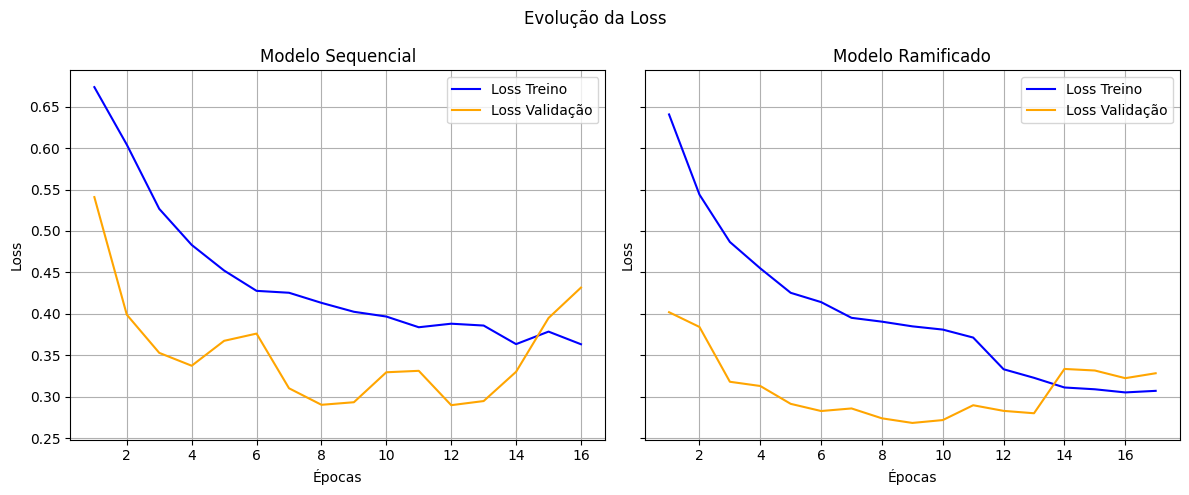

In [57]:
plot_training_history([best_seq_history, best_ram_history], titles=titles)

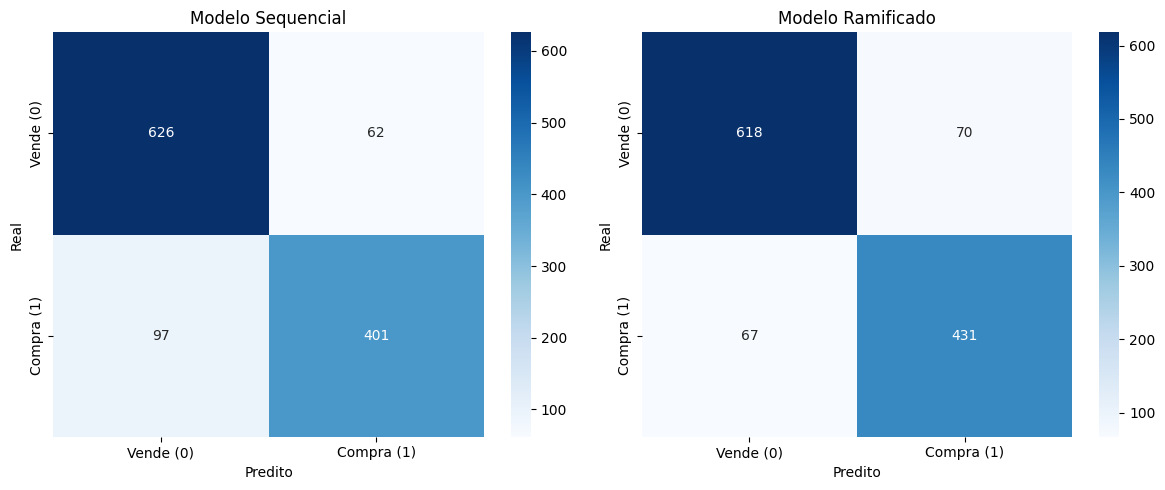

In [58]:
plot_confusion_matrix([best_seq_metrics, best_ram_metrics], titles=titles)

In [59]:
show_classification_reports(
    metrics_list=[best_seq_metrics, best_ram_metrics],
    titles=titles
)

📊 Relatório de Classificação - Modelo Sequencial

Vende (0):
Precision: 0.87
Recall:    0.91
F1-Score:  0.89

Compra (1):
Precision: 0.87
Recall:    0.81
F1-Score:  0.83

Médias:
Acurácia:  0.87
Precision: 0.87
Recall:    0.86
F1-Score:  0.86


📊 Relatório de Classificação - Modelo Ramificado

Vende (0):
Precision: 0.90
Recall:    0.90
F1-Score:  0.90

Compra (1):
Precision: 0.86
Recall:    0.87
F1-Score:  0.86

Médias:
Acurácia:  0.88
Precision: 0.88
Recall:    0.88
F1-Score:  0.88




In [60]:
resultado_backtest = run_backtest(
    predictions=best_seq_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Sequencial",
    stock_name="CSAN3",
    metrics = best_seq_metrics,
    cdi_df = cdi,
    metric_optimization=metric_optimization
)

resultado_backtest = run_backtest(
    predictions=best_ram_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Ramificado",
    stock_name="CSAN3",
    metrics = best_ram_metrics,
    cdi_df=cdi,
    metric_optimization=metric_optimization
)

resultado_backtest

<ipython-input-29-c41ff92325cd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
<ipython-input-29-c41ff92325cd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]


Data          Modelo   Ação Métrica de Otimização  \
0  2025-04-16 12:23:53.362046  CNN Sequencial  BBAS3              val_loss   
1  2025-04-16 12:23:53.391346  CNN Ramificado  BBAS3              val_loss   
2  2025-04-16 12:46:07.408853  CNN Sequencial  CSAN3              val_loss   
3  2025-04-16 12:46:07.433368  CNN Ramificado  CSAN3              val_loss   

   Acurácia  Precision    Recall        F1      Matriz de Confusão  \
0  0.861603   0.857606  0.858397  0.857991  [[605, 84], [80, 416]]   
1  0.897046   0.895619  0.892264  0.893806  [[635, 54], [68, 428]]   
2  0.865936   0.865964  0.857552  0.860931  [[626, 62], [97, 401]]   
3  0.884486   0.881235  0.881859  0.881541  [[618, 70], [67, 431]]   

   Saldo Inicial  Saldo Final  Total de Ações   Lucro Total   Lucro (%)  \
0          10000    28.909737           231.0   2823.999596   28.239996   
1          10000    34.754650           338.0   8756.574444   87.565744   
2          10000     4.337842          1188.0  13360.417661  133.604177   
3          10000     4.731443          1288.0  15326.811246  153.268112   

   Lucro (%) CDI  
0       42.26921  
1       42.26921  
2       42.26921  
3       42.26921

#### **PETR4**

In [61]:
X_train, X_test, y_train, y_test, features = preprocess_data(pe_train, pe_test)

In [62]:
janela_curta = features[:7]
janela_longa = features[7:]
X_train1, X_test1, X_train2, X_test2, y_train, y_test, features = preprocess_data(pe_train, pe_test, split_features=[janela_curta,janela_longa])

In [63]:
prices = pe_test.set_index("Date")["Close"]
titles = ["Modelo Sequencial", "Modelo Ramificado"]
metric_optimization = 'val_loss'

In [64]:
best_seq_model, best_seq_history, best_seq_metrics, best_seq_y_pred, df_results = train_model(
    model_fn=model_cnn_sequencial,
    model_path = "BEST_CNN_SEQ_PETR4.keras",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-16 12:46:07,519] A new study created in memory with name: no-name-b4ab825f-5470-419e-9b1b-aa4db0324281


Epoch 1/32
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5632 - loss: 0.6854
Epoch 1: val_loss improved from inf to 0.62879, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5634 - loss: 0.6851 - val_accuracy: 0.6367 - val_loss: 0.6288 - learning_rate: 5.9964e-04
Epoch 2/32
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6244 - loss: 0.6424
Epoch 2: val_loss improved from 0.62879 to 0.58611, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6248 - loss: 0.6421 - val_accuracy: 0.7099 - val_loss: 0.5861 - learning_rate: 5.9964e-04
Epoch 3/32
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7147 - loss: 0.5582
Epoch 3: val_loss did not improve from 0.58611
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7148 - loss: 0.5582 - val_accuracy: 0.7199 - val_loss: 0.6505 - learning_rate: 5.9964e-04
Epoch 4/32
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

[I 2025-04-16 12:46:39,899] Trial 0 finished with value: -0.3733450174331665 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.0005996369743762022, 'stop_patience': 6, 'reduce_lr_factor': 0.4694500482098726, 'reduce_lr_patience': 4}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/29
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5415 - loss: 0.6980
Epoch 1: val_loss improved from inf to 1.06892, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5437 - loss: 0.6962 - val_accuracy: 0.4921 - val_loss: 1.0689 - learning_rate: 0.0072
Epoch 2/29
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6122 - loss: 0.6437
Epoch 2: val_loss improved from 1.06892 to 0.74397, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6131 - loss: 0.6432 - val_accuracy: 0.5370 - val_loss: 0.7440 - learning_rate: 0.0072
Epoch 3/29
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6649 - loss: 0.6013
Epoch 3: val_loss improved from 0.74397 to 0.49031, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6670 - loss: 0.5992 - val_accuracy: 0.7664 - val_loss: 0.4903 - learning_rate: 0.0072
Epoch 4

[I 2025-04-16 12:46:56,227] Trial 1 finished with value: -0.4042503535747528 and parameters: {'epochs': 29, 'batch_size': 64, 'learning_rate': 0.007204225103580922, 'stop_patience': 10, 'reduce_lr_factor': 0.38772938637172805, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/43
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5615 - loss: 0.6873
Epoch 1: val_loss improved from inf to 0.68611, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5604 - loss: 0.6870 - val_accuracy: 0.4855 - val_loss: 0.6861 - learning_rate: 3.5400e-04
Epoch 2/43
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5753 - loss: 0.6738
Epoch 2: val_loss improved from 0.68611 to 0.61357, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5760 - loss: 0.6733 - val_accuracy: 0.6858 - val_loss: 0.6136 - learning_rate: 3.5400e-04
Epoch 3/43
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6236 - loss: 0.6450
Epoch 3: val_loss improved from 0.61357 to 0.53272, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6249 - loss: 0.6442 - val_accuracy: 0.7273 - val_loss: 0.5327 - learning_rate: 3.5400

[I 2025-04-16 12:47:09,501] Trial 2 finished with value: -0.4434559643268585 and parameters: {'epochs': 43, 'batch_size': 64, 'learning_rate': 0.0003540025799416932, 'stop_patience': 7, 'reduce_lr_factor': 0.1620354912618104, 'reduce_lr_patience': 4}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/14
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5586 - loss: 0.6893
Epoch 1: val_loss improved from inf to 1.00397, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5588 - loss: 0.6890 - val_accuracy: 0.5470 - val_loss: 1.0040 - learning_rate: 0.0037
Epoch 2/14
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6102 - loss: 0.6480
Epoch 2: val_loss improved from 1.00397 to 0.60839, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6126 - loss: 0.6464 - val_accuracy: 0.6667 - val_loss: 0.6084 - learning_rate: 0.0037
Epoch 3/14
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6734 - loss: 0.5953
Epoch 3: val_loss improved from 0.60839 to 0.46855, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6738 - loss: 0.5945 - val_accuracy: 0.7897 - val_loss: 0.4686 - learning_rate: 0.0

[I 2025-04-16 12:47:27,286] Trial 3 finished with value: -0.41807782649993896 and parameters: {'epochs': 14, 'batch_size': 32, 'learning_rate': 0.003661627398230623, 'stop_patience': 7, 'reduce_lr_factor': 0.16866535113269687, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/12
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5558 - loss: 0.6891
Epoch 1: val_loss improved from inf to 1.38489, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5571 - loss: 0.6880 - val_accuracy: 0.5470 - val_loss: 1.3849 - learning_rate: 0.0025
Epoch 2/12
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6283 - loss: 0.6554
Epoch 2: val_loss improved from 1.38489 to 0.63404, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6286 - loss: 0.6548 - val_accuracy: 0.6916 - val_loss: 0.6340 - learning_rate: 0.0025
Epoch 3/12
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6825 - loss: 0.5632
Epoch 3: val_loss improved from 0.63404 to 0.55982, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6836 - loss: 0.5621 - val_accuracy: 0.7249 - val_loss: 0.5598 - learning_rate: 0.0

[I 2025-04-16 12:47:43,382] Trial 4 finished with value: -0.381929874420166 and parameters: {'epochs': 12, 'batch_size': 32, 'learning_rate': 0.00246290455313186, 'stop_patience': 10, 'reduce_lr_factor': 0.41459963538449074, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/38
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5483 - loss: 0.6962
Epoch 1: val_loss improved from inf to 0.96026, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5485 - loss: 0.6958 - val_accuracy: 0.5303 - val_loss: 0.9603 - learning_rate: 0.0053
Epoch 2/38
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5834 - loss: 0.6709
Epoch 2: val_loss improved from 0.96026 to 0.65887, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5843 - loss: 0.6702 - val_accuracy: 0.5669 - val_loss: 0.6589 - learning_rate: 0.0053
Epoch 3/38
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6531 - loss: 0.5956
Epoch 3: val_loss did not improve from 0.65887
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6533 - loss: 0.5954 - val_accuracy: 0.6500 - val_loss: 0.7834 - learning_rate: 0.0053
Epoch 4/38
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:48:33,177] Trial 5 finished with value: -0.4065086543560028 and parameters: {'epochs': 38, 'batch_size': 16, 'learning_rate': 0.005282821288102596, 'stop_patience': 9, 'reduce_lr_factor': 0.2541396087315898, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/29
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5517 - loss: 0.6950
Epoch 1: val_loss improved from inf to 0.69239, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5517 - loss: 0.6949 - val_accuracy: 0.4805 - val_loss: 0.6924 - learning_rate: 0.0053
Epoch 2/29
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5654 - loss: 0.6796
Epoch 2: val_loss improved from 0.69239 to 0.68222, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5655 - loss: 0.6795 - val_accuracy: 0.4938 - val_loss: 0.6822 - learning_rate: 0.0053
Epoch 3/29
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6634 - loss: 0.6025
Epoch 3: val_loss improved from 0.68222 to 0.61849, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6640 - loss: 0.6021 - val_accuracy: 0.6218 - val_loss: 0.6185 - learning_rate: 0.0

[I 2025-04-16 12:48:57,236] Trial 6 finished with value: -0.43218034505844116 and parameters: {'epochs': 29, 'batch_size': 16, 'learning_rate': 0.0052649179090615734, 'stop_patience': 5, 'reduce_lr_factor': 0.156089985587459, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/22
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5534 - loss: 0.6936
Epoch 1: val_loss improved from inf to 1.03861, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5543 - loss: 0.6925 - val_accuracy: 0.5403 - val_loss: 1.0386 - learning_rate: 0.0066
Epoch 2/22
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6036 - loss: 0.6630
Epoch 2: val_loss improved from 1.03861 to 0.60524, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6059 - loss: 0.6613 - val_accuracy: 0.5919 - val_loss: 0.6052 - learning_rate: 0.0066
Epoch 3/22
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6616 - loss: 0.5976
Epoch 3: val_loss improved from 0.60524 to 0.50224, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6620 - loss: 0.5972 - val_accuracy: 0.7456 - val_loss: 0.5022 - learning_rate: 0.0066
Epoch 4

[I 2025-04-16 12:49:06,841] Trial 7 finished with value: -0.4515396058559418 and parameters: {'epochs': 22, 'batch_size': 64, 'learning_rate': 0.006614173628471293, 'stop_patience': 5, 'reduce_lr_factor': 0.45533891282683503, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/12
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5528 - loss: 0.6876
Epoch 1: val_loss improved from inf to 0.79007, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5533 - loss: 0.6874 - val_accuracy: 0.5628 - val_loss: 0.7901 - learning_rate: 0.0025
Epoch 2/12
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6294 - loss: 0.6503
Epoch 2: val_loss improved from 0.79007 to 0.47911, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6298 - loss: 0.6498 - val_accuracy: 0.7706 - val_loss: 0.4791 - learning_rate: 0.0025
Epoch 3/12
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6778 - loss: 0.5648
Epoch 3: val_loss did not improve from 0.47911
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6780 - loss: 0.5646 - val_accuracy: 0.7406 - val_loss: 0.5053 - learning_rate: 0.0025
Epoch 4/12
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:49:31,562] Trial 8 finished with value: -0.390543669462204 and parameters: {'epochs': 12, 'batch_size': 16, 'learning_rate': 0.0024547081707304696, 'stop_patience': 4, 'reduce_lr_factor': 0.36304842243568103, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/17
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5553 - loss: 0.6940
Epoch 1: val_loss improved from inf to 0.69893, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5551 - loss: 0.6938 - val_accuracy: 0.4830 - val_loss: 0.6989 - learning_rate: 0.0099
Epoch 2/17
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5598 - loss: 0.6868
Epoch 2: val_loss did not improve from 0.69893
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5596 - loss: 0.6869 - val_accuracy: 0.4830 - val_loss: 0.7017 - learning_rate: 0.0099
Epoch 3/17
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5604 - loss: 0.6864
Epoch 3: val_loss did not improve from 0.69893
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5600 - loss: 0.6865 - val_accuracy: 0.4830 - val_loss: 0.7017 - learning_rate: 0.0099
Epoch 4/17
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5601 - loss: 0.6863
Epoch 4: val_loss did not improve 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-16 12:49:54,492] Trial 9 finished with

Epoch 1/50
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5612 - loss: 0.6849
Epoch 1: val_loss improved from inf to 0.61431, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5619 - loss: 0.6844 - val_accuracy: 0.6874 - val_loss: 0.6143 - learning_rate: 4.1224e-04
Epoch 2/50
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6241 - loss: 0.6463
Epoch 2: val_loss improved from 0.61431 to 0.51227, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6261 - loss: 0.6449 - val_accuracy: 0.7697 - val_loss: 0.5123 - learning_rate: 4.1224e-04
Epoch 3/50
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7111 - loss: 0.5669
Epoch 3: val_loss improved from 0.51227 to 0.49420, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7116 - loss: 0.5664 - val_accuracy: 0.7897 - val_loss: 0.4942 - learning_r

[I 2025-04-16 12:50:07,244] Trial 10 finished with value: -0.41434431076049805 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.000412243048192124, 'stop_patience': 3, 'reduce_lr_factor': 0.484546414506959, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/35
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5637 - loss: 0.6881
Epoch 1: val_loss improved from inf to 0.68623, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5645 - loss: 0.6875 - val_accuracy: 0.5960 - val_loss: 0.6862 - learning_rate: 0.0024
Epoch 2/35
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6479 - loss: 0.6235
Epoch 2: val_loss did not improve from 0.68623
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6493 - loss: 0.6222 - val_accuracy: 0.6725 - val_loss: 0.7603 - learning_rate: 0.0024
Epoch 3/35
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7194 - loss: 0.5379
Epoch 3: val_loss improved from 0.68623 to 0.42188, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7207 - loss: 0.5364 - val_accuracy: 0.8213 - val_loss: 0.4219 - learning_rate: 0.0024
Epoch 4/35
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:50:28,646] Trial 11 finished with value: -0.38525643944740295 and parameters: {'epochs': 35, 'batch_size': 32, 'learning_rate': 0.0023822246249730747, 'stop_patience': 8, 'reduce_lr_factor': 0.4242234842795589, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.3733450174331665.


Epoch 1/23
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5488 - loss: 0.6865
Epoch 1: val_loss improved from inf to 1.34279, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5491 - loss: 0.6864 - val_accuracy: 0.5478 - val_loss: 1.3428 - learning_rate: 0.0021
Epoch 2/23
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6333 - loss: 0.6252
Epoch 2: val_loss improved from 1.34279 to 0.48832, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6346 - loss: 0.6241 - val_accuracy: 0.7781 - val_loss: 0.4883 - learning_rate: 0.0021
Epoch 3/23
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7004 - loss: 0.5396
Epoch 3: val_loss improved from 0.48832 to 0.48475, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7006 - loss: 0.5392 - val_accuracy: 0.7947 - val_loss: 0.4848 - learning_rate: 0.0

[I 2025-04-16 12:50:57,144] Trial 12 finished with value: -0.37121227383613586 and parameters: {'epochs': 23, 'batch_size': 32, 'learning_rate': 0.002067498438389809, 'stop_patience': 6, 'reduce_lr_factor': 0.49345180830259466, 'reduce_lr_patience': 4}. Best is trial 12 with value: -0.37121227383613586.


Epoch 1/22
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5007 - loss: 0.6935
Epoch 1: val_loss improved from inf to 0.70597, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5035 - loss: 0.6933 - val_accuracy: 0.4855 - val_loss: 0.7060 - learning_rate: 4.9170e-05
Epoch 2/22
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5675 - loss: 0.6838
Epoch 2: val_loss improved from 0.70597 to 0.70104, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5673 - loss: 0.6838 - val_accuracy: 0.4871 - val_loss: 0.7010 - learning_rate: 4.9170e-05
Epoch 3/22
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5722 - loss: 0.6799
Epoch 3: val_loss improved from 0.70104 to 0.68584, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5722 - loss: 0.6798 - val_accuracy: 0.4979 - val_loss: 0.6858 - learning_r

[I 2025-04-16 12:51:23,917] Trial 13 finished with value: -0.48641449213027954 and parameters: {'epochs': 22, 'batch_size': 32, 'learning_rate': 4.9169897226007415e-05, 'stop_patience': 6, 'reduce_lr_factor': 0.4981523750274879, 'reduce_lr_patience': 4}. Best is trial 12 with value: -0.37121227383613586.


Epoch 1/23
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5675 - loss: 0.6830
Epoch 1: val_loss improved from inf to 1.39865, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5681 - loss: 0.6826 - val_accuracy: 0.5569 - val_loss: 1.3987 - learning_rate: 0.0013
Epoch 2/23
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6834 - loss: 0.6011
Epoch 2: val_loss improved from 1.39865 to 0.94040, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6852 - loss: 0.5986 - val_accuracy: 0.6475 - val_loss: 0.9404 - learning_rate: 0.0013
Epoch 3/23
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7189 - loss: 0.5311
Epoch 3: val_loss improved from 0.94040 to 0.58453, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7196 - loss: 0.5298 - val_accuracy: 0.7415 - val_loss: 0.5845 - learning_rate: 0.0

[I 2025-04-16 12:51:49,791] Trial 14 finished with value: -0.3747057616710663 and parameters: {'epochs': 23, 'batch_size': 32, 'learning_rate': 0.0013145557444931562, 'stop_patience': 6, 'reduce_lr_factor': 0.32871657395387566, 'reduce_lr_patience': 4}. Best is trial 12 with value: -0.37121227383613586.


Epoch 1/34
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5553 - loss: 0.6894
Epoch 1: val_loss improved from inf to 0.64488, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5555 - loss: 0.6892 - val_accuracy: 0.6118 - val_loss: 0.6449 - learning_rate: 0.0037
Epoch 2/34
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6502 - loss: 0.6146
Epoch 2: val_loss did not improve from 0.64488
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6503 - loss: 0.6144 - val_accuracy: 0.6509 - val_loss: 0.7283 - learning_rate: 0.0037
Epoch 3/34
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6770 - loss: 0.5934
Epoch 3: val_loss improved from 0.64488 to 0.56327, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6785 - loss: 0.5914 - val_accuracy: 0.7057 - val_loss: 0.5633 - learning_rate: 0.0037
Epoch 4/34
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

[I 2025-04-16 12:52:16,863] Trial 15 finished with value: -0.38164234161376953 and parameters: {'epochs': 34, 'batch_size': 32, 'learning_rate': 0.0037133886989616284, 'stop_patience': 5, 'reduce_lr_factor': 0.24972509163219958, 'reduce_lr_patience': 4}. Best is trial 12 with value: -0.37121227383613586.


Epoch 1/25
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5649 - loss: 0.6841
Epoch 1: val_loss improved from inf to 0.86211, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5672 - loss: 0.6830 - val_accuracy: 0.5902 - val_loss: 0.8621 - learning_rate: 0.0016
Epoch 2/25
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6856 - loss: 0.5921
Epoch 2: val_loss improved from 0.86211 to 0.46472, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6866 - loss: 0.5911 - val_accuracy: 0.7980 - val_loss: 0.4647 - learning_rate: 0.0016
Epoch 3/25
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7318 - loss: 0.5201
Epoch 3: val_loss did not improve from 0.46472
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7318 - loss: 0.5201 - val_accuracy: 0.6517 - val_loss: 0.7331 - learning_rate: 0.0016
Epoch 4/25
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

[I 2025-04-16 12:52:44,864] Trial 16 finished with value: -0.38185545802116394 and parameters: {'epochs': 25, 'batch_size': 32, 'learning_rate': 0.0015575182339853597, 'stop_patience': 8, 'reduce_lr_factor': 0.45448489258858726, 'reduce_lr_patience': 5}. Best is trial 12 with value: -0.37121227383613586.


Epoch 1/40
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5517 - loss: 0.6904
Epoch 1: val_loss improved from inf to 0.61450, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5523 - loss: 0.6900 - val_accuracy: 0.7573 - val_loss: 0.6145 - learning_rate: 0.0032
Epoch 2/40
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6038 - loss: 0.6535
Epoch 2: val_loss did not improve from 0.61450
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6040 - loss: 0.6533 - val_accuracy: 0.5087 - val_loss: 0.7625 - learning_rate: 0.0032
Epoch 3/40
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6916 - loss: 0.5640
Epoch 3: val_loss improved from 0.61450 to 0.50815, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6923 - loss: 0.5631 - val_accuracy: 0.7498 - val_loss: 0.5082 - learning_rate: 0.0032
Epoch 4/40
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:52:56,731] Trial 17 finished with value: -0.4555887281894684 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.003244560014383849, 'stop_patience': 3, 'reduce_lr_factor': 0.1050159506435463, 'reduce_lr_patience': 4}. Best is trial 12 with value: -0.37121227383613586.


Epoch 1/17
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5642 - loss: 0.6841
Epoch 1: val_loss improved from inf to 1.12202, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5648 - loss: 0.6837 - val_accuracy: 0.5569 - val_loss: 1.1220 - learning_rate: 0.0014
Epoch 2/17
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6610 - loss: 0.6021
Epoch 2: val_loss improved from 1.12202 to 0.63784, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6618 - loss: 0.6013 - val_accuracy: 0.6717 - val_loss: 0.6378 - learning_rate: 0.0014
Epoch 3/17
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7288 - loss: 0.5319
Epoch 3: val_loss improved from 0.63784 to 0.53558, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7293 - loss: 0.5307 - val_accuracy: 0.7232 - val_loss: 0.5356 - learning_rate: 0.

[I 2025-04-16 12:53:21,308] Trial 18 finished with value: -0.36755549907684326 and parameters: {'epochs': 17, 'batch_size': 32, 'learning_rate': 0.0013707558630768756, 'stop_patience': 6, 'reduce_lr_factor': 0.3519589774083555, 'reduce_lr_patience': 3}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/18
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5433 - loss: 0.6904
Epoch 1: val_loss improved from inf to 1.69329, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5447 - loss: 0.6896 - val_accuracy: 0.5478 - val_loss: 1.6933 - learning_rate: 0.0045
Epoch 2/18
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6445 - loss: 0.6129
Epoch 2: val_loss improved from 1.69329 to 1.19693, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6452 - loss: 0.6122 - val_accuracy: 0.5154 - val_loss: 1.1969 - learning_rate: 0.0045
Epoch 3/18
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6967 - loss: 0.5437
Epoch 3: val_loss improved from 1.19693 to 0.45156, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6971 - loss: 0.5431 - val_accuracy: 0.8022 - val_loss: 0.4516 - learning_rate: 0.0045
Epoch 

[I 2025-04-16 12:53:30,490] Trial 19 finished with value: -0.4515584409236908 and parameters: {'epochs': 18, 'batch_size': 64, 'learning_rate': 0.004488393317939034, 'stop_patience': 4, 'reduce_lr_factor': 0.263235676823536, 'reduce_lr_patience': 2}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/18
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5650 - loss: 0.6844
Epoch 1: val_loss improved from inf to 1.03249, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5653 - loss: 0.6841 - val_accuracy: 0.5544 - val_loss: 1.0325 - learning_rate: 0.0017
Epoch 2/18
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6747 - loss: 0.5983
Epoch 2: val_loss improved from 1.03249 to 0.45804, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6750 - loss: 0.5980 - val_accuracy: 0.7988 - val_loss: 0.4580 - learning_rate: 0.0017
Epoch 3/18
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7149 - loss: 0.5357
Epoch 3: val_loss improved from 0.45804 to 0.43061, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7153 - loss: 0.5352 - val_accuracy: 0.8105 - val_loss: 0.4306 - learning_rate: 0.0

[I 2025-04-16 12:53:54,884] Trial 20 finished with value: -0.38908490538597107 and parameters: {'epochs': 18, 'batch_size': 32, 'learning_rate': 0.0016827758007414866, 'stop_patience': 8, 'reduce_lr_factor': 0.358307243703067, 'reduce_lr_patience': 3}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/27
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5675 - loss: 0.6844
Epoch 1: val_loss improved from inf to 0.61865, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5687 - loss: 0.6836 - val_accuracy: 0.6525 - val_loss: 0.6186 - learning_rate: 9.6039e-04
Epoch 2/27
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6519 - loss: 0.6206
Epoch 2: val_loss improved from 0.61865 to 0.61861, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6524 - loss: 0.6202 - val_accuracy: 0.7199 - val_loss: 0.6186 - learning_rate: 9.6039e-04
Epoch 3/27
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7086 - loss: 0.5529
Epoch 3: val_loss improved from 0.61861 to 0.46572, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7086 - loss: 0.5528 - val_accuracy: 0.7938 - val_loss: 0.4657 - learning_r

[I 2025-04-16 12:54:27,178] Trial 21 finished with value: -0.3814358711242676 and parameters: {'epochs': 27, 'batch_size': 32, 'learning_rate': 0.0009603940618497699, 'stop_patience': 6, 'reduce_lr_factor': 0.448228912709577, 'reduce_lr_patience': 4}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/34
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5511 - loss: 0.6862
Epoch 1: val_loss improved from inf to 1.63278, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5523 - loss: 0.6855 - val_accuracy: 0.5495 - val_loss: 1.6328 - learning_rate: 0.0020
Epoch 2/34
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6661 - loss: 0.6073
Epoch 2: val_loss improved from 1.63278 to 0.52018, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6677 - loss: 0.6053 - val_accuracy: 0.7805 - val_loss: 0.5202 - learning_rate: 0.0020
Epoch 3/34
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6955 - loss: 0.5833
Epoch 3: val_loss did not improve from 0.52018
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6963 - loss: 0.5821 - val_accuracy: 0.7016 - val_loss: 0.6578 - learning_rate: 0.0020
Epoch 4/34
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:54:49,116] Trial 22 finished with value: -0.39005255699157715 and parameters: {'epochs': 34, 'batch_size': 32, 'learning_rate': 0.002038932501716508, 'stop_patience': 7, 'reduce_lr_factor': 0.4017147685242727, 'reduce_lr_patience': 3}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/20
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5589 - loss: 0.6846
Epoch 1: val_loss improved from inf to 1.04124, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5593 - loss: 0.6844 - val_accuracy: 0.5503 - val_loss: 1.0412 - learning_rate: 0.0010
Epoch 2/20
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6519 - loss: 0.6108
Epoch 2: val_loss improved from 1.04124 to 0.48984, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6528 - loss: 0.6099 - val_accuracy: 0.7714 - val_loss: 0.4898 - learning_rate: 0.0010
Epoch 3/20
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7286 - loss: 0.5197
Epoch 3: val_loss improved from 0.48984 to 0.47397, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7286 - loss: 0.5195 - val_accuracy: 0.7689 - val_loss: 0.4740 - learning_rate: 0.

[I 2025-04-16 12:55:17,005] Trial 23 finished with value: -0.38002079725265503 and parameters: {'epochs': 20, 'batch_size': 32, 'learning_rate': 0.0010177910168871517, 'stop_patience': 6, 'reduce_lr_factor': 0.47999089561191355, 'reduce_lr_patience': 4}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/32
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5651 - loss: 0.6916
Epoch 1: val_loss improved from inf to 0.89909, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5653 - loss: 0.6911 - val_accuracy: 0.5445 - val_loss: 0.8991 - learning_rate: 0.0029
Epoch 2/32
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6083 - loss: 0.6504
Epoch 2: val_loss improved from 0.89909 to 0.77977, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6098 - loss: 0.6490 - val_accuracy: 0.6060 - val_loss: 0.7798 - learning_rate: 0.0029
Epoch 3/32
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6842 - loss: 0.5668
Epoch 3: val_loss improved from 0.77977 to 0.56443, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6856 - loss: 0.5654 - val_accuracy: 0.7190 - val_loss: 0.5644 - learning_rate: 0.0

[I 2025-04-16 12:55:34,980] Trial 24 finished with value: -0.39473599195480347 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.002896554937301307, 'stop_patience': 5, 'reduce_lr_factor': 0.4349629469054571, 'reduce_lr_patience': 3}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/26
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5584 - loss: 0.6947
Epoch 1: val_loss improved from inf to 1.13761, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5585 - loss: 0.6943 - val_accuracy: 0.5362 - val_loss: 1.1376 - learning_rate: 0.0043
Epoch 2/26
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6225 - loss: 0.6432
Epoch 2: val_loss improved from 1.13761 to 0.51083, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6236 - loss: 0.6422 - val_accuracy: 0.7814 - val_loss: 0.5108 - learning_rate: 0.0043
Epoch 3/26
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6924 - loss: 0.5582
Epoch 3: val_loss did not improve from 0.51083
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6925 - loss: 0.5581 - val_accuracy: 0.6351 - val_loss: 0.7626 - learning_rate: 0.0043
Epoch 4/26
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 12:55:53,289] Trial 25 finished with value: -0.4090714156627655 and parameters: {'epochs': 26, 'batch_size': 32, 'learning_rate': 0.004339850657582755, 'stop_patience': 4, 'reduce_lr_factor': 0.3741327994588671, 'reduce_lr_patience': 4}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/15
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5420 - loss: 0.6866
Epoch 1: val_loss improved from inf to 0.59674, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5425 - loss: 0.6864 - val_accuracy: 0.7282 - val_loss: 0.5967 - learning_rate: 7.6603e-04
Epoch 2/15
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6329 - loss: 0.6384
Epoch 2: val_loss did not improve from 0.59674
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6335 - loss: 0.6378 - val_accuracy: 0.6708 - val_loss: 0.6508 - learning_rate: 7.6603e-04
Epoch 3/15
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7005 - loss: 0.5642
Epoch 3: val_loss improved from 0.59674 to 0.56333, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7007 - loss: 0.5639 - val_accuracy: 0.7323 - val_loss: 0.5633 - learning_rate: 7.6603e-04
Epoch 4/15
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

[I 2025-04-16 12:56:14,973] Trial 26 finished with value: -0.3806919753551483 and parameters: {'epochs': 15, 'batch_size': 32, 'learning_rate': 0.0007660300078084273, 'stop_patience': 7, 'reduce_lr_factor': 0.3374311038179115, 'reduce_lr_patience': 5}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/45
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5501 - loss: 0.6936
Epoch 1: val_loss improved from inf to 0.69656, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5500 - loss: 0.6936 - val_accuracy: 0.4830 - val_loss: 0.6966 - learning_rate: 0.0063
Epoch 2/45
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5626 - loss: 0.6842
Epoch 2: val_loss did not improve from 0.69656
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5629 - loss: 0.6838 - val_accuracy: 0.5278 - val_loss: 0.7619 - learning_rate: 0.0063
Epoch 3/45
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5662 - loss: 0.6673
Epoch 3: val_loss did not improve from 0.69656
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5680 - loss: 0.6665 - val_accuracy: 0.5719 - val_loss: 1.6943 - learning_rate: 0.0063
Epoch 4/45
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6517 - loss: 0.6004
Epoch 4: ReduceLROnPlateau reduci

[I 2025-04-16 12:56:42,091] Trial 27 finished with value: -0.4274504482746124 and parameters: {'epochs': 45, 'batch_size': 32, 'learning_rate': 0.006305893703447842, 'stop_patience': 6, 'reduce_lr_factor': 0.27945148744503956, 'reduce_lr_patience': 3}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/10
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5494 - loss: 0.6945
Epoch 1: val_loss improved from inf to 0.68756, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5494 - loss: 0.6943 - val_accuracy: 0.5270 - val_loss: 0.6876 - learning_rate: 0.0087
Epoch 2/10
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5612 - loss: 0.6849
Epoch 2: val_loss did not improve from 0.68756
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5611 - loss: 0.6849 - val_accuracy: 0.5511 - val_loss: 0.7253 - learning_rate: 0.0087
Epoch 3/10
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6008 - loss: 0.6474
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0017508067940790366.

Epoch 3: val_loss did not improve from 0.68756
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6037 - loss: 0.6450 - val_accuracy: 0.7199 - val_loss: 0.7163 - learning_rate: 0.0087
Epoch 4/10
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

[I 2025-04-16 12:56:51,651] Trial 28 finished with value: -0.4459885060787201 and parameters: {'epochs': 10, 'batch_size': 64, 'learning_rate': 0.008650130396415823, 'stop_patience': 5, 'reduce_lr_factor': 0.20240235397604858, 'reduce_lr_patience': 2}. Best is trial 18 with value: -0.36755549907684326.


Epoch 1/30
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5504 - loss: 0.6895
Epoch 1: val_loss improved from inf to 0.59510, saving model to /content/models/BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5506 - loss: 0.6894 - val_accuracy: 0.6983 - val_loss: 0.5951 - learning_rate: 0.0018
Epoch 2/30
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6387 - loss: 0.6251
Epoch 2: val_loss did not improve from 0.59510
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6390 - loss: 0.6248 - val_accuracy: 0.5079 - val_loss: 0.8127 - learning_rate: 0.0018
Epoch 3/30
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6928 - loss: 0.5613
Epoch 3: val_loss did not improve from 0.59510
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6931 - loss: 0.5608 - val_accuracy: 0.6575 - val_loss: 0.7732 - learning_rate: 0.0018
Epoch 4/30
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7232 - loss: 0.5198
Epoch 4: val_loss improved from 0.

[I 2025-04-16 12:57:46,281] Trial 29 finished with value: -0.41520583629608154 and parameters: {'epochs': 30, 'batch_size': 16, 'learning_rate': 0.0017599654051928659, 'stop_patience': 8, 'reduce_lr_factor': 0.38858134174771664, 'reduce_lr_patience': 5}. Best is trial 18 with value: -0.36755549907684326.


In [65]:
best_ram_model, best_ram_history, best_ram_metrics, best_ram_y_pred, df_results = train_model(
    model_fn=model_cnn_ramificado,
    model_path = "BEST_CNN_RAM_PETR4.keras",
    X_train=[X_train1, X_train2],
    y_train=y_train,
    X_test=[X_test1, X_test2],
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-16 12:57:46,294] A new study created in memory with name: no-name-b41a76d3-52f8-4b40-a2f9-58155a8f886e


Epoch 1/47
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5753 - loss: 0.6808
Epoch 1: val_loss improved from inf to 0.92605, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5764 - loss: 0.6798 - val_accuracy: 0.5835 - val_loss: 0.9260 - learning_rate: 0.0054
Epoch 2/47
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6784 - loss: 0.5575
Epoch 2: val_loss did not improve from 0.92605
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6791 - loss: 0.5567 - val_accuracy: 0.6592 - val_loss: 0.9363 - learning_rate: 0.0054
Epoch 3/47
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7402 - loss: 0.4981
Epoch 3: val_loss improved from 0.92605 to 0.79574, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7404 - loss: 0.4973 - val_accuracy: 0.7057 - val_loss: 0.7957 - learning_rate: 0.0054
Epoch 4/47
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:58:13,005] Trial 0 finished with value: -0.33817559480667114 and parameters: {'epochs': 47, 'batch_size': 16, 'learning_rate': 0.005419601190097244, 'stop_patience': 5, 'reduce_lr_factor': 0.3582968377273349, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.33817559480667114.


Epoch 1/50
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5810 - loss: 0.6865
Epoch 1: val_loss improved from inf to 0.55995, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5826 - loss: 0.6849 - val_accuracy: 0.7506 - val_loss: 0.5599 - learning_rate: 0.0059
Epoch 2/50
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7126 - loss: 0.5566
Epoch 2: val_loss improved from 0.55995 to 0.40516, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7127 - loss: 0.5565 - val_accuracy: 0.8296 - val_loss: 0.4052 - learning_rate: 0.0059
Epoch 3/50
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7422 - loss: 0.5097
Epoch 3: val_loss did not improve from 0.40516
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7427 - loss: 0.5098 - val_accuracy: 0.8130 - val_loss: 0.5305 - learning_rate: 0.0059
Epoch 4/50
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7668 -

[I 2025-04-16 12:58:25,487] Trial 1 finished with value: -0.3480716943740845 and parameters: {'epochs': 50, 'batch_size': 64, 'learning_rate': 0.005931238087873912, 'stop_patience': 8, 'reduce_lr_factor': 0.38252387981007174, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.33817559480667114.


Epoch 1/18
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5856 - loss: 0.6747
Epoch 1: val_loss improved from inf to 0.62392, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5922 - loss: 0.6700 - val_accuracy: 0.7174 - val_loss: 0.6239 - learning_rate: 0.0030
Epoch 2/18
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7179 - loss: 0.5466
Epoch 2: val_loss did not improve from 0.62392
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7183 - loss: 0.5460 - val_accuracy: 0.7390 - val_loss: 0.6674 - learning_rate: 0.0030
Epoch 3/18
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7749 - loss: 0.4709
Epoch 3: val_loss improved from 0.62392 to 0.59975, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7743 - loss: 0.4713 - val_accuracy: 0.7506 - val_loss: 0.5997 - learning_rate: 0.0030
Epoch 4/18
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7886 -

[I 2025-04-16 12:58:33,043] Trial 2 finished with value: -0.4016088545322418 and parameters: {'epochs': 18, 'batch_size': 64, 'learning_rate': 0.0030432999721595596, 'stop_patience': 3, 'reduce_lr_factor': 0.4713884275809861, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.33817559480667114.


Epoch 1/12
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5712 - loss: 0.7016
Epoch 1: val_loss improved from inf to 1.12759, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5745 - loss: 0.6981 - val_accuracy: 0.6068 - val_loss: 1.1276 - learning_rate: 0.0073
Epoch 2/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6861 - loss: 0.5756
Epoch 2: val_loss improved from 1.12759 to 0.43712, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6862 - loss: 0.5755 - val_accuracy: 0.8196 - val_loss: 0.4371 - learning_rate: 0.0073
Epoch 3/12
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7455 - loss: 0.5046
Epoch 3: val_loss improved from 0.43712 to 0.38096, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7458 - loss: 0.5043 - val_accuracy: 0.8512 - val_loss: 0.3810 - learning_rate: 0.0073
Epoch 4

[I 2025-04-16 12:58:42,740] Trial 3 finished with value: -0.3561357855796814 and parameters: {'epochs': 12, 'batch_size': 64, 'learning_rate': 0.007341827051336106, 'stop_patience': 8, 'reduce_lr_factor': 0.28727381802575214, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.33817559480667114.


Epoch 1/49
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5669 - loss: 0.7028
Epoch 1: val_loss improved from inf to 0.80020, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5672 - loss: 0.7025 - val_accuracy: 0.5619 - val_loss: 0.8002 - learning_rate: 0.0093
Epoch 2/49
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6831 - loss: 0.5613
Epoch 2: val_loss did not improve from 0.80020
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6832 - loss: 0.5612 - val_accuracy: 0.5736 - val_loss: 1.4290 - learning_rate: 0.0093
Epoch 3/49
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7252 - loss: 0.5161
Epoch 3: val_loss improved from 0.80020 to 0.51767, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7253 - loss: 0.5159 - val_accuracy: 0.7365 - val_loss: 0.5177 - learning_rate: 0.0093
Epoch 4/49
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:59:05,801] Trial 4 finished with value: -0.340199738740921 and parameters: {'epochs': 49, 'batch_size': 32, 'learning_rate': 0.00925491714117968, 'stop_patience': 9, 'reduce_lr_factor': 0.4127378218828427, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.33817559480667114.


Epoch 1/41
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5800 - loss: 0.6761
Epoch 1: val_loss improved from inf to 0.97255, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5801 - loss: 0.6760 - val_accuracy: 0.5827 - val_loss: 0.9726 - learning_rate: 0.0047
Epoch 2/41
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6953 - loss: 0.5738
Epoch 2: val_loss improved from 0.97255 to 0.61532, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6955 - loss: 0.5734 - val_accuracy: 0.7149 - val_loss: 0.6153 - learning_rate: 0.0047
Epoch 3/41
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7161 - loss: 0.5051
Epoch 3: val_loss did not improve from 0.61532
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7161 - loss: 0.5049 - val_accuracy: 0.7382 - val_loss: 0.6658 - learning_rate: 0.0047
Epoch 4/41
282/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 12:59:39,974] Trial 5 finished with value: -0.3322795331478119 and parameters: {'epochs': 41, 'batch_size': 16, 'learning_rate': 0.004705476587612442, 'stop_patience': 10, 'reduce_lr_factor': 0.48061365467430417, 'reduce_lr_patience': 2}. Best is trial 5 with value: -0.3322795331478119.


Epoch 1/38
133/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5688 - loss: 0.6821
Epoch 1: val_loss improved from inf to 0.69692, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5752 - loss: 0.6780 - val_accuracy: 0.6426 - val_loss: 0.6969 - learning_rate: 0.0023
Epoch 2/38
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7136 - loss: 0.5577
Epoch 2: val_loss improved from 0.69692 to 0.40903, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7137 - loss: 0.5575 - val_accuracy: 0.8304 - val_loss: 0.4090 - learning_rate: 0.0023
Epoch 3/38
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7400 - loss: 0.5007
Epoch 3: val_loss did not improve from 0.40903
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7404 - loss: 0.5001 - val_accuracy: 0.8238 - val_loss: 0.4649 - learning_rate: 0.0023
Epoch 4/38
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:00:08,750] Trial 6 finished with value: -0.3402109444141388 and parameters: {'epochs': 38, 'batch_size': 32, 'learning_rate': 0.0022529174434773895, 'stop_patience': 10, 'reduce_lr_factor': 0.15782355626521546, 'reduce_lr_patience': 2}. Best is trial 5 with value: -0.3322795331478119.


Epoch 1/37
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5609 - loss: 0.7000
Epoch 1: val_loss improved from inf to 1.16809, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5628 - loss: 0.6983 - val_accuracy: 0.6168 - val_loss: 1.1681 - learning_rate: 0.0065
Epoch 2/37
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6959 - loss: 0.5719
Epoch 2: val_loss improved from 1.16809 to 0.59555, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6960 - loss: 0.5717 - val_accuracy: 0.7797 - val_loss: 0.5955 - learning_rate: 0.0065
Epoch 3/37
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7444 - loss: 0.4855
Epoch 3: val_loss improved from 0.59555 to 0.38502, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7445 - loss: 0.4855 - val_accuracy: 0.8470 - val_loss: 0.3850 - learning_rate: 0.0

[I 2025-04-16 13:00:35,249] Trial 7 finished with value: -0.3318009078502655 and parameters: {'epochs': 37, 'batch_size': 32, 'learning_rate': 0.006451866410318473, 'stop_patience': 10, 'reduce_lr_factor': 0.11132780624655761, 'reduce_lr_patience': 4}. Best is trial 7 with value: -0.3318009078502655.


Epoch 1/30
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5761 - loss: 0.6768
Epoch 1: val_loss improved from inf to 0.63075, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5774 - loss: 0.6763 - val_accuracy: 0.6442 - val_loss: 0.6308 - learning_rate: 7.8205e-04
Epoch 2/30
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6713 - loss: 0.6141
Epoch 2: val_loss improved from 0.63075 to 0.58301, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6723 - loss: 0.6133 - val_accuracy: 0.7323 - val_loss: 0.5830 - learning_rate: 7.8205e-04
Epoch 3/30
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7286 - loss: 0.5564
Epoch 3: val_loss improved from 0.58301 to 0.54888, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7310 - loss: 0.5542 - val_accuracy: 0.7830 - val_loss: 0.5489 - learning_rate: 7.8205

[I 2025-04-16 13:00:55,395] Trial 8 finished with value: -0.34987571835517883 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.0007820494163893869, 'stop_patience': 4, 'reduce_lr_factor': 0.2516621116307657, 'reduce_lr_patience': 5}. Best is trial 7 with value: -0.3318009078502655.


Epoch 1/24
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5453 - loss: 0.6948
Epoch 1: val_loss improved from inf to 1.16855, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5494 - loss: 0.6921 - val_accuracy: 0.5470 - val_loss: 1.1686 - learning_rate: 0.0100
Epoch 2/24
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6926 - loss: 0.5524
Epoch 2: val_loss improved from 1.16855 to 0.56395, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6937 - loss: 0.5509 - val_accuracy: 0.7889 - val_loss: 0.5640 - learning_rate: 0.0100
Epoch 3/24
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7349 - loss: 0.5062
Epoch 3: val_loss improved from 0.56395 to 0.40507, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7339 - loss: 0.5067 - val_accuracy: 0.8279 - val_loss: 0.4051 - learning_rate: 0.0100
Epoch 4/

[I 2025-04-16 13:01:06,893] Trial 9 finished with value: -0.34983086585998535 and parameters: {'epochs': 24, 'batch_size': 64, 'learning_rate': 0.009977057632033418, 'stop_patience': 5, 'reduce_lr_factor': 0.45885397665221095, 'reduce_lr_patience': 2}. Best is trial 7 with value: -0.3318009078502655.


Epoch 1/34
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5616 - loss: 0.7033
Epoch 1: val_loss improved from inf to 1.08916, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5638 - loss: 0.7011 - val_accuracy: 0.5919 - val_loss: 1.0892 - learning_rate: 0.0078
Epoch 2/34
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6970 - loss: 0.5493
Epoch 2: val_loss did not improve from 1.08916
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6983 - loss: 0.5475 - val_accuracy: 0.6060 - val_loss: 1.5003 - learning_rate: 0.0078
Epoch 3/34
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7377 - loss: 0.4972
Epoch 3: val_loss improved from 1.08916 to 0.64074, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7379 - loss: 0.4972 - val_accuracy: 0.7265 - val_loss: 0.6407 - learning_rate: 0.0078
Epoch 4/34
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:01:32,133] Trial 10 finished with value: -0.33239227533340454 and parameters: {'epochs': 34, 'batch_size': 32, 'learning_rate': 0.007824815491522589, 'stop_patience': 7, 'reduce_lr_factor': 0.10081134764129637, 'reduce_lr_patience': 5}. Best is trial 7 with value: -0.3318009078502655.


Epoch 1/39
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5775 - loss: 0.6809
Epoch 1: val_loss improved from inf to 0.76888, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5786 - loss: 0.6799 - val_accuracy: 0.6110 - val_loss: 0.7689 - learning_rate: 0.0039
Epoch 2/39
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6938 - loss: 0.5690
Epoch 2: val_loss did not improve from 0.76888
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6943 - loss: 0.5682 - val_accuracy: 0.6467 - val_loss: 1.0102 - learning_rate: 0.0039
Epoch 3/39
284/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7476 - loss: 0.4955
Epoch 3: val_loss did not improve from 0.76888
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7483 - loss: 0.4944 - val_accuracy: 0.6874 - val_loss: 0.9048 - learning_rate: 0.0039
Epoch 4/39
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7589 - loss: 0.4766
Epoch 4: val_loss improved from 0.

[I 2025-04-16 13:02:06,934] Trial 11 finished with value: -0.32689568400382996 and parameters: {'epochs': 39, 'batch_size': 16, 'learning_rate': 0.0038997576152586307, 'stop_patience': 10, 'reduce_lr_factor': 0.21518100882824204, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/29
282/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5670 - loss: 0.6850
Epoch 1: val_loss improved from inf to 1.39007, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5696 - loss: 0.6828 - val_accuracy: 0.5702 - val_loss: 1.3901 - learning_rate: 0.0034
Epoch 2/29
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6975 - loss: 0.5618
Epoch 2: val_loss improved from 1.39007 to 0.62251, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6980 - loss: 0.5610 - val_accuracy: 0.7448 - val_loss: 0.6225 - learning_rate: 0.0034
Epoch 3/29
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7331 - loss: 0.4956
Epoch 3: val_loss improved from 0.62251 to 0.53334, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7331 - loss: 0.4955 - val_accuracy: 0.7165 - val_loss: 0.5333 - learning_rate: 0.0

[I 2025-04-16 13:02:43,381] Trial 12 finished with value: -0.33947184681892395 and parameters: {'epochs': 29, 'batch_size': 16, 'learning_rate': 0.0033939294311158066, 'stop_patience': 10, 'reduce_lr_factor': 0.19685085086277554, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/41
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5760 - loss: 0.6961
Epoch 1: val_loss improved from inf to 1.55792, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5780 - loss: 0.6940 - val_accuracy: 0.5686 - val_loss: 1.5579 - learning_rate: 0.0067
Epoch 2/41
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6908 - loss: 0.5623
Epoch 2: val_loss improved from 1.55792 to 1.22789, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6929 - loss: 0.5598 - val_accuracy: 0.6509 - val_loss: 1.2279 - learning_rate: 0.0067
Epoch 3/41
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7318 - loss: 0.5062
Epoch 3: val_loss improved from 1.22789 to 0.62395, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7323 - loss: 0.5057 - val_accuracy: 0.7390 - val_loss: 0.6240 - learning_rate: 0.0

[I 2025-04-16 13:03:05,528] Trial 13 finished with value: -0.3375128507614136 and parameters: {'epochs': 41, 'batch_size': 32, 'learning_rate': 0.0066589763091529875, 'stop_patience': 8, 'reduce_lr_factor': 0.10542991944247007, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/37
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5800 - loss: 0.6747
Epoch 1: val_loss improved from inf to 0.70435, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5824 - loss: 0.6729 - val_accuracy: 0.6234 - val_loss: 0.7044 - learning_rate: 0.0043
Epoch 2/37
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7031 - loss: 0.5478
Epoch 2: val_loss did not improve from 0.70435
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7034 - loss: 0.5473 - val_accuracy: 0.6276 - val_loss: 1.2781 - learning_rate: 0.0043
Epoch 3/37
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7268 - loss: 0.5126
Epoch 3: val_loss improved from 0.70435 to 0.56073, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7273 - loss: 0.5122 - val_accuracy: 0.7415 - val_loss: 0.5607 - learning_rate: 0.0043
Epoch 4/37
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:03:32,151] Trial 14 finished with value: -0.3340422511100769 and parameters: {'epochs': 37, 'batch_size': 16, 'learning_rate': 0.0043050733967438535, 'stop_patience': 9, 'reduce_lr_factor': 0.20558406648879732, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/44
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5555 - loss: 0.6879
Epoch 1: val_loss improved from inf to 0.66607, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5586 - loss: 0.6871 - val_accuracy: 0.5528 - val_loss: 0.6661 - learning_rate: 1.9846e-04
Epoch 2/44
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6404 - loss: 0.6596
Epoch 2: val_loss improved from 0.66607 to 0.57524, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6416 - loss: 0.6590 - val_accuracy: 0.7606 - val_loss: 0.5752 - learning_rate: 1.9846e-04
Epoch 3/44
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6845 - loss: 0.6330
Epoch 3: val_loss improved from 0.57524 to 0.53176, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6851 - loss: 0.6324 - val_accuracy: 0.7839 - val_loss: 0.5318 - learning_r

[I 2025-04-16 13:03:49,106] Trial 15 finished with value: -0.4362020790576935 and parameters: {'epochs': 44, 'batch_size': 32, 'learning_rate': 0.00019846217736056975, 'stop_patience': 6, 'reduce_lr_factor': 0.15083288914717388, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/25
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5712 - loss: 0.6766
Epoch 1: val_loss improved from inf to 0.84428, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5716 - loss: 0.6763 - val_accuracy: 0.6451 - val_loss: 0.8443 - learning_rate: 0.0082
Epoch 2/25
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6390 - loss: 0.6070
Epoch 2: val_loss improved from 0.84428 to 0.63920, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6394 - loss: 0.6066 - val_accuracy: 0.7049 - val_loss: 0.6392 - learning_rate: 0.0082
Epoch 3/25
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7161 - loss: 0.5280
Epoch 3: val_loss improved from 0.63920 to 0.39338, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7164 - loss: 0.5276 - val_accuracy: 0.8337 - val_loss: 0.3934 - learning_rate: 0.0

[I 2025-04-16 13:04:12,189] Trial 16 finished with value: -0.3477683961391449 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.008228468907694762, 'stop_patience': 9, 'reduce_lr_factor': 0.23770539802234625, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/32
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6047 - loss: 0.6685
Epoch 1: val_loss improved from inf to 0.44684, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6059 - loss: 0.6674 - val_accuracy: 0.8196 - val_loss: 0.4468 - learning_rate: 0.0014
Epoch 2/32
134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7374 - loss: 0.5417
Epoch 2: val_loss did not improve from 0.44684
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7378 - loss: 0.5402 - val_accuracy: 0.7980 - val_loss: 0.5309 - learning_rate: 0.0014
Epoch 3/32
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7568 - loss: 0.4932
Epoch 3: val_loss improved from 0.44684 to 0.39754, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7572 - loss: 0.4928 - val_accuracy: 0.8412 - val_loss: 0.3975 - learning_rate: 0.0014
Epoch 4/32
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:04:38,661] Trial 17 finished with value: -0.34190863370895386 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.0014048643356966875, 'stop_patience': 7, 'reduce_lr_factor': 0.31394219297446957, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/36
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5830 - loss: 0.6777
Epoch 1: val_loss improved from inf to 0.77444, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5832 - loss: 0.6776 - val_accuracy: 0.6775 - val_loss: 0.7744 - learning_rate: 0.0036
Epoch 2/36
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7070 - loss: 0.5556
Epoch 2: val_loss improved from 0.77444 to 0.57041, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7070 - loss: 0.5556 - val_accuracy: 0.7290 - val_loss: 0.5704 - learning_rate: 0.0036
Epoch 3/36
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7282 - loss: 0.5059
Epoch 3: val_loss did not improve from 0.57041
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7288 - loss: 0.5053 - val_accuracy: 0.7273 - val_loss: 0.7186 - learning_rate: 0.0036
Epoch 4/36
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:05:19,259] Trial 18 finished with value: -0.33819884061813354 and parameters: {'epochs': 36, 'batch_size': 16, 'learning_rate': 0.003621551126944244, 'stop_patience': 10, 'reduce_lr_factor': 0.15977306097838337, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/44
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5677 - loss: 0.7006
Epoch 1: val_loss improved from inf to 0.83289, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5703 - loss: 0.6979 - val_accuracy: 0.6218 - val_loss: 0.8329 - learning_rate: 0.0062
Epoch 2/44
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7043 - loss: 0.5441
Epoch 2: val_loss did not improve from 0.83289
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7059 - loss: 0.5420 - val_accuracy: 0.6259 - val_loss: 1.0599 - learning_rate: 0.0062
Epoch 3/44
136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7422 - loss: 0.5002
Epoch 3: val_loss improved from 0.83289 to 0.35125, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7432 - loss: 0.4976 - val_accuracy: 0.8529 - val_loss: 0.3513 - learning_rate: 0.0062
Epoch 4/44
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:05:40,726] Trial 19 finished with value: -0.3288177251815796 and parameters: {'epochs': 44, 'batch_size': 32, 'learning_rate': 0.006226889031228111, 'stop_patience': 9, 'reduce_lr_factor': 0.2049300832732426, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/44
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5848 - loss: 0.6737
Epoch 1: val_loss improved from inf to 0.99543, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5872 - loss: 0.6715 - val_accuracy: 0.6243 - val_loss: 0.9954 - learning_rate: 0.0048
Epoch 2/44
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7084 - loss: 0.5538
Epoch 2: val_loss improved from 0.99543 to 0.53707, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7087 - loss: 0.5534 - val_accuracy: 0.7639 - val_loss: 0.5371 - learning_rate: 0.0048
Epoch 3/44
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7424 - loss: 0.5010
Epoch 3: val_loss did not improve from 0.53707
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7425 - loss: 0.5009 - val_accuracy: 0.7515 - val_loss: 0.6118 - learning_rate: 0.0048
Epoch 4/44
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:06:17,100] Trial 20 finished with value: -0.34168753027915955 and parameters: {'epochs': 44, 'batch_size': 16, 'learning_rate': 0.004816262631968224, 'stop_patience': 9, 'reduce_lr_factor': 0.29342046590682835, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/41
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5505 - loss: 0.7062
Epoch 1: val_loss improved from inf to 1.27730, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5550 - loss: 0.7019 - val_accuracy: 0.5611 - val_loss: 1.2773 - learning_rate: 0.0061
Epoch 2/41
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6914 - loss: 0.5706
Epoch 2: val_loss improved from 1.27730 to 0.66897, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6916 - loss: 0.5699 - val_accuracy: 0.7016 - val_loss: 0.6690 - learning_rate: 0.0061
Epoch 3/41
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7251 - loss: 0.5028
Epoch 3: val_loss did not improve from 0.66897
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7252 - loss: 0.5027 - val_accuracy: 0.7124 - val_loss: 0.8445 - learning_rate: 0.0061
Epoch 4/41
136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:06:43,030] Trial 21 finished with value: -0.336965411901474 and parameters: {'epochs': 41, 'batch_size': 32, 'learning_rate': 0.006061980553742439, 'stop_patience': 10, 'reduce_lr_factor': 0.2005870777793801, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/44
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5734 - loss: 0.6951
Epoch 1: val_loss improved from inf to 0.72322, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5740 - loss: 0.6944 - val_accuracy: 0.6326 - val_loss: 0.7232 - learning_rate: 0.0068
Epoch 2/44
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6801 - loss: 0.5745
Epoch 2: val_loss improved from 0.72322 to 0.45119, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6810 - loss: 0.5728 - val_accuracy: 0.7980 - val_loss: 0.4512 - learning_rate: 0.0068
Epoch 3/44
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7182 - loss: 0.5071
Epoch 3: val_loss did not improve from 0.45119
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7180 - loss: 0.5069 - val_accuracy: 0.6949 - val_loss: 0.6741 - learning_rate: 0.0068
Epoch 4/44
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:07:00,546] Trial 22 finished with value: -0.3485056757926941 and parameters: {'epochs': 44, 'batch_size': 32, 'learning_rate': 0.0068379486477824405, 'stop_patience': 9, 'reduce_lr_factor': 0.2443451892634803, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/34
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5730 - loss: 0.6920
Epoch 1: val_loss improved from inf to 1.31986, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5749 - loss: 0.6902 - val_accuracy: 0.5669 - val_loss: 1.3199 - learning_rate: 0.0055
Epoch 2/34
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7183 - loss: 0.5491
Epoch 2: val_loss improved from 1.31986 to 0.91855, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7192 - loss: 0.5471 - val_accuracy: 0.6683 - val_loss: 0.9185 - learning_rate: 0.0055
Epoch 3/34
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7379 - loss: 0.4941
Epoch 3: val_loss improved from 0.91855 to 0.44519, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7384 - loss: 0.4935 - val_accuracy: 0.8470 - val_loss: 0.4452 - learning_rate: 0.0

[I 2025-04-16 13:07:23,358] Trial 23 finished with value: -0.33780816197395325 and parameters: {'epochs': 34, 'batch_size': 32, 'learning_rate': 0.005523131206266326, 'stop_patience': 8, 'reduce_lr_factor': 0.13980511352999975, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/39
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5571 - loss: 0.7002
Epoch 1: val_loss improved from inf to 1.62041, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5574 - loss: 0.6999 - val_accuracy: 0.5586 - val_loss: 1.6204 - learning_rate: 0.0084
Epoch 2/39
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6835 - loss: 0.5744
Epoch 2: val_loss improved from 1.62041 to 0.58355, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6852 - loss: 0.5725 - val_accuracy: 0.6700 - val_loss: 0.5835 - learning_rate: 0.0084
Epoch 3/39
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7142 - loss: 0.5021
Epoch 3: val_loss improved from 0.58355 to 0.40112, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7153 - loss: 0.5011 - val_accuracy: 0.8462 - val_loss: 0.4011 - learning_rate: 0.0

[I 2025-04-16 13:07:51,498] Trial 24 finished with value: -0.3416084051132202 and parameters: {'epochs': 39, 'batch_size': 32, 'learning_rate': 0.00842867982662187, 'stop_patience': 10, 'reduce_lr_factor': 0.17983473628869556, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/46
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5619 - loss: 0.7012
Epoch 1: val_loss improved from inf to 1.26129, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5621 - loss: 0.7009 - val_accuracy: 0.5661 - val_loss: 1.2613 - learning_rate: 0.0067
Epoch 2/46
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6860 - loss: 0.5692
Epoch 2: val_loss improved from 1.26129 to 0.50424, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6875 - loss: 0.5667 - val_accuracy: 0.7947 - val_loss: 0.5042 - learning_rate: 0.0067
Epoch 3/46
137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7117 - loss: 0.4973
Epoch 3: val_loss did not improve from 0.50424
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7122 - loss: 0.4967 - val_accuracy: 0.7506 - val_loss: 0.6020 - learning_rate: 0.0067
Epoch 4/46
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:08:11,195] Trial 25 finished with value: -0.3436371684074402 and parameters: {'epochs': 46, 'batch_size': 32, 'learning_rate': 0.0067325430433823955, 'stop_patience': 9, 'reduce_lr_factor': 0.12498268653136198, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/27
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5808 - loss: 0.6727
Epoch 1: val_loss improved from inf to 0.71781, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5809 - loss: 0.6725 - val_accuracy: 0.6567 - val_loss: 0.7178 - learning_rate: 0.0041
Epoch 2/27
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6678 - loss: 0.5780
Epoch 2: val_loss did not improve from 0.71781
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6682 - loss: 0.5774 - val_accuracy: 0.6301 - val_loss: 1.1006 - learning_rate: 0.0041
Epoch 3/27
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7156 - loss: 0.5385
Epoch 3: val_loss improved from 0.71781 to 0.45137, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7156 - loss: 0.5383 - val_accuracy: 0.7897 - val_loss: 0.4514 - learning_rate: 0.0041
Epoch 4/27
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:08:41,758] Trial 26 finished with value: -0.34592393040657043 and parameters: {'epochs': 27, 'batch_size': 16, 'learning_rate': 0.004104121577324132, 'stop_patience': 7, 'reduce_lr_factor': 0.22702839183560525, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/40
137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5596 - loss: 0.7080
Epoch 1: val_loss improved from inf to 1.12213, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5640 - loss: 0.7035 - val_accuracy: 0.5686 - val_loss: 1.1221 - learning_rate: 0.0059
Epoch 2/40
136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6937 - loss: 0.5616
Epoch 2: val_loss improved from 1.12213 to 0.44556, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6959 - loss: 0.5589 - val_accuracy: 0.7839 - val_loss: 0.4456 - learning_rate: 0.0059
Epoch 3/40
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7354 - loss: 0.4906
Epoch 3: val_loss did not improve from 0.44556
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7352 - loss: 0.4901 - val_accuracy: 0.6850 - val_loss: 0.7255 - learning_rate: 0.0059
Epoch 4/40
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:09:11,242] Trial 27 finished with value: -0.33680060505867004 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.00594860048265488, 'stop_patience': 10, 'reduce_lr_factor': 0.2673366889494637, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/35
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5842 - loss: 0.6810
Epoch 1: val_loss improved from inf to 0.51862, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5847 - loss: 0.6806 - val_accuracy: 0.7681 - val_loss: 0.5186 - learning_rate: 0.0023
Epoch 2/35
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6980 - loss: 0.5494
Epoch 2: val_loss improved from 0.51862 to 0.43626, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6984 - loss: 0.5491 - val_accuracy: 0.8196 - val_loss: 0.4363 - learning_rate: 0.0023
Epoch 3/35
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7557 - loss: 0.4903
Epoch 3: val_loss improved from 0.43626 to 0.39029, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7557 - loss: 0.4903 - val_accuracy: 0.8379 - val_loss: 0.3903 - learning_rate: 0.0

[I 2025-04-16 13:09:47,444] Trial 28 finished with value: -0.33485928177833557 and parameters: {'epochs': 35, 'batch_size': 32, 'learning_rate': 0.0022947006427764963, 'stop_patience': 8, 'reduce_lr_factor': 0.32409513533905177, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.32689568400382996.


Epoch 1/47
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5694 - loss: 0.6827
Epoch 1: val_loss improved from inf to 0.75151, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5713 - loss: 0.6809 - val_accuracy: 0.6409 - val_loss: 0.7515 - learning_rate: 0.0050
Epoch 2/47
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6809 - loss: 0.5673
Epoch 2: val_loss improved from 0.75151 to 0.43097, saving model to /content/models/BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6810 - loss: 0.5671 - val_accuracy: 0.8163 - val_loss: 0.4310 - learning_rate: 0.0050
Epoch 3/47
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7140 - loss: 0.5132
Epoch 3: val_loss did not improve from 0.43097
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7141 - loss: 0.5131 - val_accuracy: 0.7431 - val_loss: 0.5673 - learning_rate: 0.0050
Epoch 4/47
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:10:18,227] Trial 29 finished with value: -0.34896132349967957 and parameters: {'epochs': 47, 'batch_size': 16, 'learning_rate': 0.005024915064056935, 'stop_patience': 6, 'reduce_lr_factor': 0.3548642706580995, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.32689568400382996.


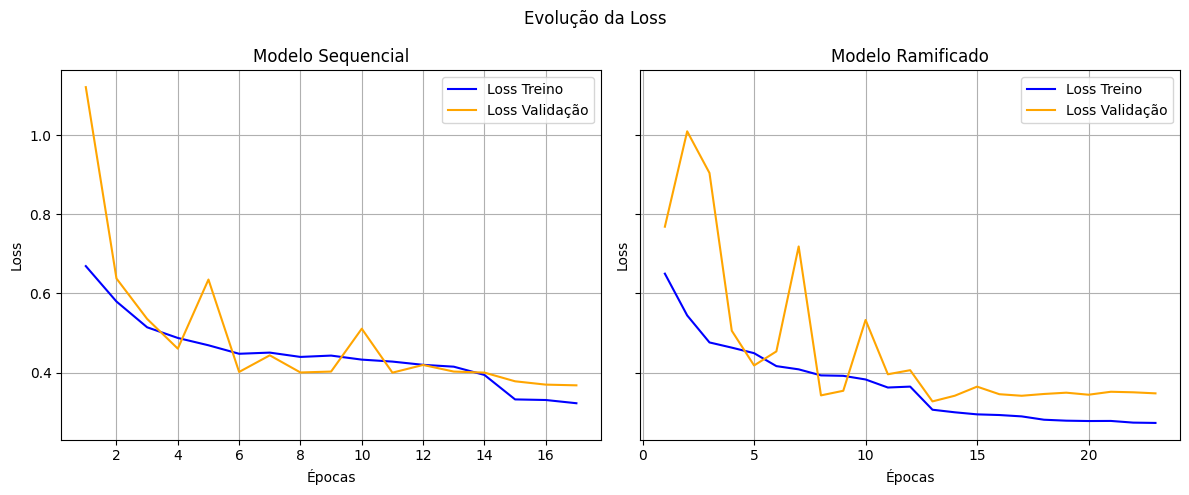

In [66]:
plot_training_history([best_seq_history, best_ram_history], titles=titles)

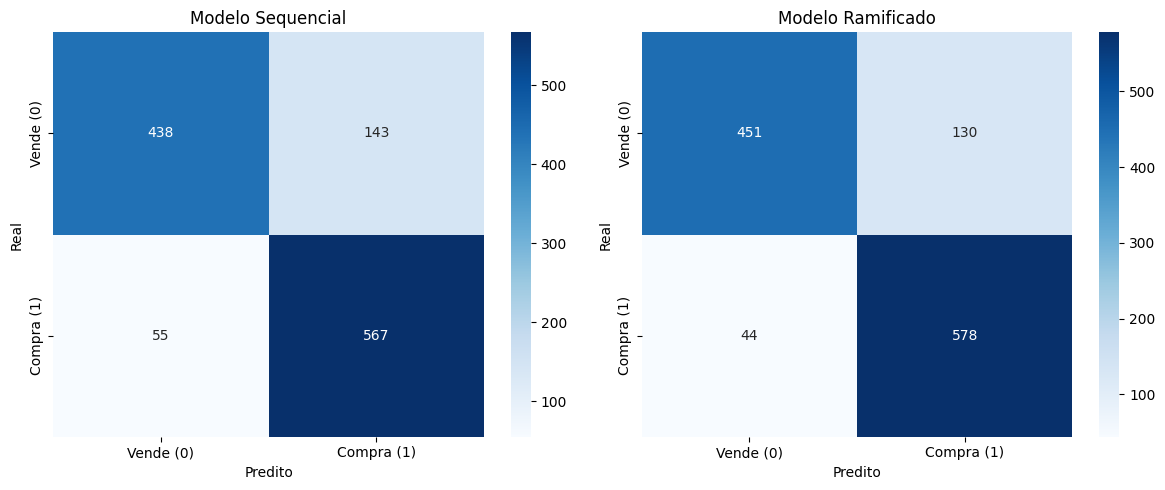

In [67]:
plot_confusion_matrix([best_seq_metrics, best_ram_metrics], titles=titles)

In [68]:
show_classification_reports(
    metrics_list=[best_seq_metrics, best_ram_metrics],
    titles=titles
)

📊 Relatório de Classificação - Modelo Sequencial

Vende (0):
Precision: 0.89
Recall:    0.75
F1-Score:  0.82

Compra (1):
Precision: 0.80
Recall:    0.91
F1-Score:  0.85

Médias:
Acurácia:  0.84
Precision: 0.84
Recall:    0.83
F1-Score:  0.83


📊 Relatório de Classificação - Modelo Ramificado

Vende (0):
Precision: 0.91
Recall:    0.78
F1-Score:  0.84

Compra (1):
Precision: 0.82
Recall:    0.93
F1-Score:  0.87

Médias:
Acurácia:  0.86
Precision: 0.86
Recall:    0.85
F1-Score:  0.85




In [69]:
resultado_backtest = run_backtest(
    predictions=best_seq_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Sequencial",
    stock_name="PETR4",
    metrics = best_seq_metrics,
    cdi_df = cdi,
    metric_optimization = metric_optimization
)

resultado_backtest = run_backtest(
    predictions=best_ram_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Ramificado",
    stock_name="PETR4",
    metrics = best_ram_metrics,
    cdi_df=cdi,
    metric_optimization = metric_optimization
)

resultado_backtest

<ipython-input-29-c41ff92325cd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
<ipython-input-29-c41ff92325cd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]


Data          Modelo   Ação Métrica de Otimização  \
0  2025-04-16 12:23:53.362046  CNN Sequencial  BBAS3              val_loss   
1  2025-04-16 12:23:53.391346  CNN Ramificado  BBAS3              val_loss   
2  2025-04-16 12:46:07.408853  CNN Sequencial  CSAN3              val_loss   
3  2025-04-16 12:46:07.433368  CNN Ramificado  CSAN3              val_loss   
4  2025-04-16 13:10:19.078491  CNN Sequencial  PETR4              val_loss   
5  2025-04-16 13:10:19.110849  CNN Ramificado  PETR4              val_loss   

   Acurácia  Precision    Recall        F1       Matriz de Confusão  \
0  0.861603   0.857606  0.858397  0.857991   [[605, 84], [80, 416]]   
1  0.897046   0.895619  0.892264  0.893806   [[635, 54], [68, 428]]   
2  0.865936   0.865964  0.857552  0.860931   [[626, 62], [97, 401]]   
3  0.884486   0.881235  0.881859  0.881541   [[618, 70], [67, 431]]   
4  0.835411   0.843515  0.832724  0.833497  [[438, 143], [55, 567]]   
5  0.855362   0.863748  0.852754  0.853731  [[451, 130], [44, 578]]   

   Saldo Inicial  Saldo Final  Total de Ações   Lucro Total   Lucro (%)  \
0          10000    28.909737           231.0   2823.999596   28.239996   
1          10000    34.754650           338.0   8756.574444   87.565744   
2          10000     4.337842          1188.0  13360.417661  133.604177   
3          10000     4.731443          1288.0  15326.811246  153.268112   
4          10000    21.154176           732.0  17280.835405  172.808354   
5          10000    15.290708           641.0  13886.131784  138.861318   

   Lucro (%) CDI  
0      42.269210  
1      42.269210  
2      42.269210  
3      42.269210  
4      42.937875  
5      42.937875

#### **VALE3**

In [70]:
X_train, X_test, y_train, y_test, features = preprocess_data(vl_train, vl_test)

In [71]:
janela_curta = features[:7]
janela_longa = features[7:]
X_train1, X_test1, X_train2, X_test2, y_train, y_test, features = preprocess_data(vl_train, vl_test, split_features=[janela_curta,janela_longa])

In [72]:
prices = vl_test.set_index("Date")["Close"]
metric_optimization = 'val_loss'

In [73]:
best_seq_model, best_seq_history, best_seq_metrics, best_seq_y_pred, df_results = train_model(
    model_fn=model_cnn_sequencial,
    model_path = "BEST_CNN_SEQ_VALE3.keras",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-16 13:10:19,205] A new study created in memory with name: no-name-e546ced6-a8ac-4c7d-825b-4b5c6c742fa3


Epoch 1/48
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5494 - loss: 0.6882
Epoch 1: val_loss improved from inf to 0.70489, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5497 - loss: 0.6881 - val_accuracy: 0.5071 - val_loss: 0.7049 - learning_rate: 0.0042
Epoch 2/48
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5684 - loss: 0.6791
Epoch 2: val_loss did not improve from 0.70489
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5697 - loss: 0.6773 - val_accuracy: 0.5154 - val_loss: 2.4282 - learning_rate: 0.0042
Epoch 3/48
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6555 - loss: 0.6034
Epoch 3: val_loss improved from 0.70489 to 0.66150, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6552 - loss: 0.6037 - val_accuracy: 0.7456 - val_loss: 0.6615 - learning_rate: 0.0042
Epoch 4/48
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7060 

[I 2025-04-16 13:10:34,545] Trial 0 finished with value: -0.3264237642288208 and parameters: {'epochs': 48, 'batch_size': 64, 'learning_rate': 0.0041672179951285125, 'stop_patience': 5, 'reduce_lr_factor': 0.3343460963003722, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/31
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5395 - loss: 0.6920
Epoch 1: val_loss improved from inf to 0.69895, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5403 - loss: 0.6918 - val_accuracy: 0.4996 - val_loss: 0.6989 - learning_rate: 0.0081
Epoch 2/31
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5665 - loss: 0.6852
Epoch 2: val_loss improved from 0.69895 to 0.69563, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5665 - loss: 0.6852 - val_accuracy: 0.4996 - val_loss: 0.6956 - learning_rate: 0.0081
Epoch 3/31
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.6760
Epoch 3: val_loss did not improve from 0.69563
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5665 - loss: 0.6764 - val_accuracy: 0.4996 - val_loss: 0.6957 - learning_rate: 0.0081
Epoch 4/31
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

[I 2025-04-16 13:11:02,214] Trial 1 finished with value: -0.3949286639690399 and parameters: {'epochs': 31, 'batch_size': 32, 'learning_rate': 0.008067091764507232, 'stop_patience': 5, 'reduce_lr_factor': 0.35630675579200854, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/30
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5623 - loss: 0.6874
Epoch 1: val_loss improved from inf to 0.69253, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5626 - loss: 0.6871 - val_accuracy: 0.4996 - val_loss: 0.6925 - learning_rate: 5.6788e-04
Epoch 2/30
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5704 - loss: 0.6739
Epoch 2: val_loss did not improve from 0.69253
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5708 - loss: 0.6736 - val_accuracy: 0.5345 - val_loss: 0.7473 - learning_rate: 5.6788e-04
Epoch 3/30
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6061 - loss: 0.6507
Epoch 3: val_loss improved from 0.69253 to 0.48126, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6065 - loss: 0.6500 - val_accuracy: 0.7539 - val_loss: 0.4813 - learning_rate: 5.6788e-04
Epoch 4/30
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

[I 2025-04-16 13:11:25,592] Trial 2 finished with value: -0.3443140387535095 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.0005678766866786431, 'stop_patience': 9, 'reduce_lr_factor': 0.36179268705183243, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/38
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5546 - loss: 0.6882
Epoch 1: val_loss improved from inf to 0.69151, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5552 - loss: 0.6879 - val_accuracy: 0.6185 - val_loss: 0.6915 - learning_rate: 0.0061
Epoch 2/38
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5679 - loss: 0.6845
Epoch 2: val_loss improved from 0.69151 to 0.59836, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5679 - loss: 0.6844 - val_accuracy: 0.7980 - val_loss: 0.5984 - learning_rate: 0.0061
Epoch 3/38
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5968 - loss: 0.6521
Epoch 3: val_loss improved from 0.59836 to 0.47738, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5972 - loss: 0.6517 - val_accuracy: 0.7764 - val_loss: 0.4774 - learning_rate: 0.0061
Epoch 4

[I 2025-04-16 13:11:45,413] Trial 3 finished with value: -0.34587669372558594 and parameters: {'epochs': 38, 'batch_size': 64, 'learning_rate': 0.006093095461880234, 'stop_patience': 6, 'reduce_lr_factor': 0.24933310146220156, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/21
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5607 - loss: 0.6878
Epoch 1: val_loss improved from inf to 0.70799, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5607 - loss: 0.6878 - val_accuracy: 0.4996 - val_loss: 0.7080 - learning_rate: 0.0030
Epoch 2/21
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5893 - loss: 0.6617
Epoch 2: val_loss did not improve from 0.70799
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5907 - loss: 0.6607 - val_accuracy: 0.6708 - val_loss: 0.8750 - learning_rate: 0.0030
Epoch 3/21
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6344 - loss: 0.6185
Epoch 3: val_loss did not improve from 0.70799
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6353 - loss: 0.6171 - val_accuracy: 0.7149 - val_loss: 1.2031 - learning_rate: 0.0030
Epoch 4/21
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6899 - loss: 0.5518
Epoch 4: val_loss improved from 0.

[I 2025-04-16 13:12:12,922] Trial 4 finished with value: -0.3386313021183014 and parameters: {'epochs': 21, 'batch_size': 32, 'learning_rate': 0.003028118042379998, 'stop_patience': 10, 'reduce_lr_factor': 0.11962320485981613, 'reduce_lr_patience': 4}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/35
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5511 - loss: 0.6918
Epoch 1: val_loss improved from inf to 0.69931, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5513 - loss: 0.6917 - val_accuracy: 0.4996 - val_loss: 0.6993 - learning_rate: 0.0063
Epoch 2/35
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5693 - loss: 0.6842
Epoch 2: val_loss did not improve from 0.69931
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5693 - loss: 0.6842 - val_accuracy: 0.5021 - val_loss: 0.7450 - learning_rate: 0.0063
Epoch 3/35
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5651 - loss: 0.6809
Epoch 3: val_loss improved from 0.69931 to 0.61049, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5652 - loss: 0.6810 - val_accuracy: 0.7273 - val_loss: 0.6105 - learning_rate: 0.0063
Epoch 4/35
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 13:12:49,548] Trial 5 finished with value: -0.35473504662513733 and parameters: {'epochs': 35, 'batch_size': 32, 'learning_rate': 0.006280242688341667, 'stop_patience': 6, 'reduce_lr_factor': 0.3619142915206077, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/24
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5494 - loss: 0.6875
Epoch 1: val_loss improved from inf to 0.71055, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5500 - loss: 0.6874 - val_accuracy: 0.5295 - val_loss: 0.7105 - learning_rate: 0.0010
Epoch 2/24
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5794 - loss: 0.6727
Epoch 2: val_loss did not improve from 0.71055
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5794 - loss: 0.6727 - val_accuracy: 0.5112 - val_loss: 0.9174 - learning_rate: 0.0010
Epoch 3/24
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6103 - loss: 0.6499
Epoch 3: val_loss improved from 0.71055 to 0.44649, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6118 - loss: 0.6484 - val_accuracy: 0.8005 - val_loss: 0.4465 - learning_rate: 0.0010
Epoch 4/24
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6665 

[I 2025-04-16 13:12:56,273] Trial 6 finished with value: -0.4464913606643677 and parameters: {'epochs': 24, 'batch_size': 64, 'learning_rate': 0.0010333570977100655, 'stop_patience': 3, 'reduce_lr_factor': 0.1972492533361616, 'reduce_lr_patience': 4}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/17
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5534 - loss: 0.6909
Epoch 1: val_loss improved from inf to 0.68974, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5539 - loss: 0.6905 - val_accuracy: 0.5021 - val_loss: 0.6897 - learning_rate: 0.0065
Epoch 2/17
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5662 - loss: 0.6828
Epoch 2: val_loss improved from 0.68974 to 0.64459, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5661 - loss: 0.6827 - val_accuracy: 0.7257 - val_loss: 0.6446 - learning_rate: 0.0065
Epoch 3/17
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5980 - loss: 0.6515
Epoch 3: val_loss did not improve from 0.64459
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6008 - loss: 0.6504 - val_accuracy: 0.6284 - val_loss: 1.0574 - learning_rate: 0.0065
Epoch 4/17
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6424 

[I 2025-04-16 13:13:11,139] Trial 7 finished with value: -0.37033694982528687 and parameters: {'epochs': 17, 'batch_size': 64, 'learning_rate': 0.006538274690543514, 'stop_patience': 7, 'reduce_lr_factor': 0.14139108936264908, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/31
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5646 - loss: 0.6886
Epoch 1: val_loss improved from inf to 0.69039, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5645 - loss: 0.6883 - val_accuracy: 0.4996 - val_loss: 0.6904 - learning_rate: 0.0048
Epoch 2/31
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5726 - loss: 0.6770
Epoch 2: val_loss did not improve from 0.69039
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5740 - loss: 0.6757 - val_accuracy: 0.5179 - val_loss: 1.4705 - learning_rate: 0.0048
Epoch 3/31
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6388 - loss: 0.6227
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009017240941490984.

Epoch 3: val_loss did not improve from 0.69039
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6387 - loss: 0.6214 - val_accuracy: 0.7041 - val_loss: 0.8254 - learning_rate: 0.0048
Epoch 4/31
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

[I 2025-04-16 13:13:25,948] Trial 8 finished with value: -0.37484505772590637 and parameters: {'epochs': 31, 'batch_size': 64, 'learning_rate': 0.00477109083063712, 'stop_patience': 7, 'reduce_lr_factor': 0.18899746113474358, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/45
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5517 - loss: 0.6902
Epoch 1: val_loss improved from inf to 0.69566, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5521 - loss: 0.6900 - val_accuracy: 0.4996 - val_loss: 0.6957 - learning_rate: 0.0051
Epoch 2/45
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5662 - loss: 0.6856
Epoch 2: val_loss did not improve from 0.69566
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5661 - loss: 0.6857 - val_accuracy: 0.4996 - val_loss: 0.6984 - learning_rate: 0.0051
Epoch 3/45
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5667 - loss: 0.6846
Epoch 3: val_loss improved from 0.69566 to 0.68639, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5666 - loss: 0.6846 - val_accuracy: 0.5461 - val_loss: 0.6864 - learning_rate: 0.0051
Epoch 4/45
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 13:13:53,645] Trial 9 finished with value: -0.38154831528663635 and parameters: {'epochs': 45, 'batch_size': 32, 'learning_rate': 0.005070700618274157, 'stop_patience': 6, 'reduce_lr_factor': 0.36362005769548367, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/49
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5499 - loss: 0.6928
Epoch 1: val_loss improved from inf to 0.69928, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5502 - loss: 0.6927 - val_accuracy: 0.4996 - val_loss: 0.6993 - learning_rate: 0.0099
Epoch 2/49
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5663 - loss: 0.6855
Epoch 2: val_loss did not improve from 0.69928
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5663 - loss: 0.6855 - val_accuracy: 0.4996 - val_loss: 0.7014 - learning_rate: 0.0099
Epoch 3/49
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5663 - loss: 0.6850
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0045981493455413275.

Epoch 3: val_loss did not improve from 0.69928
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5663 - loss: 0.6850 - val_accuracy: 0.4996 - val_loss: 0.7023 - learning_rate: 0.0099
Epoch 4/49
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-16 13:14:05,111] Trial 10 finished wit

Epoch 1/11
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5510 - loss: 0.6893
Epoch 1: val_loss improved from inf to 0.70962, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5510 - loss: 0.6893 - val_accuracy: 0.5312 - val_loss: 0.7096 - learning_rate: 0.0028
Epoch 2/11
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5634 - loss: 0.6846
Epoch 2: val_loss improved from 0.70962 to 0.66535, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5635 - loss: 0.6846 - val_accuracy: 0.5220 - val_loss: 0.6653 - learning_rate: 0.0028
Epoch 3/11
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5994 - loss: 0.6522
Epoch 3: val_loss improved from 0.66535 to 0.46746, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5995 - loss: 0.6521 - val_accuracy: 0.7980 - val_loss: 0.4675 - learning_rate: 0.0

[I 2025-04-16 13:14:29,226] Trial 11 finished with value: -0.3619672954082489 and parameters: {'epochs': 11, 'batch_size': 16, 'learning_rate': 0.0028271837124811887, 'stop_patience': 10, 'reduce_lr_factor': 0.10432890715653352, 'reduce_lr_patience': 4}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/21
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5550 - loss: 0.6889
Epoch 1: val_loss improved from inf to 0.82426, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5550 - loss: 0.6889 - val_accuracy: 0.5021 - val_loss: 0.8243 - learning_rate: 0.0028
Epoch 2/21
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5672 - loss: 0.6802
Epoch 2: val_loss did not improve from 0.82426
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5672 - loss: 0.6802 - val_accuracy: 0.5137 - val_loss: 0.8801 - learning_rate: 0.0028
Epoch 3/21
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6138 - loss: 0.6432
Epoch 3: val_loss improved from 0.82426 to 0.64463, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6143 - loss: 0.6431 - val_accuracy: 0.7614 - val_loss: 0.6446 - learning_rate: 0.0028
Epoch 4/21
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 13:14:54,278] Trial 12 finished with value: -0.3551160991191864 and parameters: {'epochs': 21, 'batch_size': 32, 'learning_rate': 0.0027884668738515504, 'stop_patience': 9, 'reduce_lr_factor': 0.28474802790931414, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5570 - loss: 0.6893
Epoch 1: val_loss improved from inf to 0.69583, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5570 - loss: 0.6892 - val_accuracy: 0.4888 - val_loss: 0.6958 - learning_rate: 0.0031
Epoch 2/42
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5660 - loss: 0.6803
Epoch 2: val_loss did not improve from 0.69583
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5662 - loss: 0.6800 - val_accuracy: 0.5104 - val_loss: 1.3635 - learning_rate: 0.0031
Epoch 3/42
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6233 - loss: 0.6307
Epoch 3: val_loss improved from 0.69583 to 0.63588, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6253 - loss: 0.6293 - val_accuracy: 0.7149 - val_loss: 0.6359 - learning_rate: 0.0031
Epoch 4/42
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 13:15:06,497] Trial 13 finished with value: -0.4351312518119812 and parameters: {'epochs': 42, 'batch_size': 32, 'learning_rate': 0.0030966765440523817, 'stop_patience': 4, 'reduce_lr_factor': 0.4921146916201601, 'reduce_lr_patience': 4}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/10
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5599 - loss: 0.6913
Epoch 1: val_loss improved from inf to 0.69578, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5599 - loss: 0.6913 - val_accuracy: 0.4996 - val_loss: 0.6958 - learning_rate: 0.0037
Epoch 2/10
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5660 - loss: 0.6858
Epoch 2: val_loss did not improve from 0.69578
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5660 - loss: 0.6858 - val_accuracy: 0.4996 - val_loss: 0.6991 - learning_rate: 0.0037
Epoch 3/10
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5659 - loss: 0.6845
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.001636526209627497.

Epoch 3: val_loss did not improve from 0.69578
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5659 - loss: 0.6845 - val_accuracy: 0.5129 - val_loss: 0.7098 - learning_rate: 0.0037
Epoch 4/10
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-16 13:15:26,570] Trial 14 finished with value: -0.39803382754325867 and parameters: {'epochs': 10, 'batch_size': 16, 'learning_rate': 0.003749543903318455, 'stop_patience': 8, 'reduce_lr_factor': 0.43646008594774593, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.3264237642288208.


Epoch 1/23
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5684 - loss: 0.6861
Epoch 1: val_loss improved from inf to 0.79569, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5681 - loss: 0.6857 - val_accuracy: 0.5079 - val_loss: 0.7957 - learning_rate: 0.0013
Epoch 2/23
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5745 - loss: 0.6697
Epoch 2: val_loss improved from 0.79569 to 0.61988, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5747 - loss: 0.6695 - val_accuracy: 0.5777 - val_loss: 0.6199 - learning_rate: 0.0013
Epoch 3/23
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6395 - loss: 0.6142
Epoch 3: val_loss improved from 0.61988 to 0.50684, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6396 - loss: 0.6141 - val_accuracy: 0.7797 - val_loss: 0.5068 - learning_rate: 0.0013
Epoch 4

[I 2025-04-16 13:15:45,203] Trial 15 finished with value: -0.32501500844955444 and parameters: {'epochs': 23, 'batch_size': 64, 'learning_rate': 0.0013487796721152454, 'stop_patience': 5, 'reduce_lr_factor': 0.28507111195196166, 'reduce_lr_patience': 3}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/26
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5581 - loss: 0.6872
Epoch 1: val_loss improved from inf to 0.73241, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5581 - loss: 0.6869 - val_accuracy: 0.5121 - val_loss: 0.7324 - learning_rate: 0.0014
Epoch 2/26
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5847 - loss: 0.6719
Epoch 2: val_loss did not improve from 0.73241
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5848 - loss: 0.6716 - val_accuracy: 0.5112 - val_loss: 0.9663 - learning_rate: 0.0014
Epoch 3/26
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6037 - loss: 0.6454
Epoch 3: val_loss improved from 0.73241 to 0.64183, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6054 - loss: 0.6435 - val_accuracy: 0.7415 - val_loss: 0.6418 - learning_rate: 0.0014
Epoch 4/26
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6900

[I 2025-04-16 13:15:57,598] Trial 16 finished with value: -0.34425994753837585 and parameters: {'epochs': 26, 'batch_size': 64, 'learning_rate': 0.0013644051238496145, 'stop_patience': 5, 'reduce_lr_factor': 0.31162665129245004, 'reduce_lr_patience': 2}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5640 - loss: 0.6883
Epoch 1: val_loss improved from inf to 0.76637, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5640 - loss: 0.6882 - val_accuracy: 0.4996 - val_loss: 0.7664 - learning_rate: 8.1665e-05
Epoch 2/50
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5671 - loss: 0.6822
Epoch 2: val_loss did not improve from 0.76637
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5670 - loss: 0.6823 - val_accuracy: 0.4996 - val_loss: 0.7721 - learning_rate: 8.1665e-05
Epoch 3/50
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5677 - loss: 0.6804
Epoch 3: val_loss improved from 0.76637 to 0.74101, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5675 - loss: 0.6804 - val_accuracy: 0.4996 - val_loss: 0.7410 - learning_rate: 8.1665e-05
Epoch 4/50
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

[I 2025-04-16 13:16:16,187] Trial 17 finished with value: -0.4222305119037628 and parameters: {'epochs': 50, 'batch_size': 64, 'learning_rate': 8.166523461206575e-05, 'stop_patience': 4, 'reduce_lr_factor': 0.2574833233288386, 'reduce_lr_patience': 3}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/17
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5627 - loss: 0.6869
Epoch 1: val_loss improved from inf to 0.88130, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5630 - loss: 0.6864 - val_accuracy: 0.5004 - val_loss: 0.8813 - learning_rate: 0.0017
Epoch 2/17
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5734 - loss: 0.6766
Epoch 2: val_loss did not improve from 0.88130
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5741 - loss: 0.6760 - val_accuracy: 0.5079 - val_loss: 0.8822 - learning_rate: 0.0017
Epoch 3/17
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6171 - loss: 0.6429
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.000721762531525534.

Epoch 3: val_loss did not improve from 0.88130
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6185 - loss: 0.6414 - val_accuracy: 0.6459 - val_loss: 1.0949 - learning_rate: 0.0017
Epoch 4/17
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

[I 2025-04-16 13:16:30,751] Trial 18 finished with value: -0.33228763937950134 and parameters: {'epochs': 17, 'batch_size': 64, 'learning_rate': 0.001697378485935823, 'stop_patience': 5, 'reduce_lr_factor': 0.4252219207578872, 'reduce_lr_patience': 2}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/37
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5701 - loss: 0.6881
Epoch 1: val_loss improved from inf to 0.68234, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5697 - loss: 0.6877 - val_accuracy: 0.6068 - val_loss: 0.6823 - learning_rate: 0.0044
Epoch 2/37
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5683 - loss: 0.6744
Epoch 2: val_loss improved from 0.68234 to 0.49176, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5695 - loss: 0.6738 - val_accuracy: 0.7573 - val_loss: 0.4918 - learning_rate: 0.0044
Epoch 3/37
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6254 - loss: 0.6268
Epoch 3: val_loss did not improve from 0.49176
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6245 - loss: 0.6287 - val_accuracy: 0.6999 - val_loss: 0.5660 - learning_rate: 0.0044
Epoch 4/37
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6792 

[I 2025-04-16 13:16:47,865] Trial 19 finished with value: -0.33470866084098816 and parameters: {'epochs': 37, 'batch_size': 64, 'learning_rate': 0.004395011139337822, 'stop_patience': 5, 'reduce_lr_factor': 0.3098685952086863, 'reduce_lr_patience': 3}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/42
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5682 - loss: 0.6877
Epoch 1: val_loss improved from inf to 0.73217, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5681 - loss: 0.6874 - val_accuracy: 0.5087 - val_loss: 0.7322 - learning_rate: 0.0020
Epoch 2/42
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5761 - loss: 0.6758
Epoch 2: val_loss improved from 0.73217 to 0.56938, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5765 - loss: 0.6751 - val_accuracy: 0.7897 - val_loss: 0.5694 - learning_rate: 0.0020
Epoch 3/42
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6238 - loss: 0.6210
Epoch 3: val_loss did not improve from 0.56938
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6243 - loss: 0.6205 - val_accuracy: 0.7174 - val_loss: 0.7665 - learning_rate: 0.0020
Epoch 4/42
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6876 

[I 2025-04-16 13:16:58,443] Trial 20 finished with value: -0.3601762056350708 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.0019944068597935963, 'stop_patience': 4, 'reduce_lr_factor': 0.2274545852268439, 'reduce_lr_patience': 2}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/17
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5618 - loss: 0.6872
Epoch 1: val_loss improved from inf to 0.70570, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5620 - loss: 0.6870 - val_accuracy: 0.5287 - val_loss: 0.7057 - learning_rate: 0.0019
Epoch 2/17
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5795 - loss: 0.6763
Epoch 2: val_loss did not improve from 0.70570
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5793 - loss: 0.6762 - val_accuracy: 0.5262 - val_loss: 0.7069 - learning_rate: 0.0019
Epoch 3/17
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6133 - loss: 0.6534
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0007923640395696803.

Epoch 3: val_loss did not improve from 0.70570
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6141 - loss: 0.6523 - val_accuracy: 0.5295 - val_loss: 2.1207 - learning_rate: 0.0019
Epoch 4/17
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

[I 2025-04-16 13:17:11,146] Trial 21 finished with value: -0.35814449191093445 and parameters: {'epochs': 17, 'batch_size': 64, 'learning_rate': 0.0019071323372070442, 'stop_patience': 5, 'reduce_lr_factor': 0.41547407371737183, 'reduce_lr_patience': 2}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/16
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5662 - loss: 0.6889
Epoch 1: val_loss improved from inf to 0.68720, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5662 - loss: 0.6884 - val_accuracy: 0.5520 - val_loss: 0.6872 - learning_rate: 0.0019
Epoch 2/16
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5654 - loss: 0.6778
Epoch 2: val_loss improved from 0.68720 to 0.67424, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5658 - loss: 0.6772 - val_accuracy: 0.5694 - val_loss: 0.6742 - learning_rate: 0.0019
Epoch 3/16
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6204 - loss: 0.6304
Epoch 3: val_loss improved from 0.67424 to 0.46759, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6205 - loss: 0.6305 - val_accuracy: 0.7938 - val_loss: 0.4676 - learning_rate: 0.0019
Epoch 

[I 2025-04-16 13:17:25,291] Trial 22 finished with value: -0.34803152084350586 and parameters: {'epochs': 16, 'batch_size': 64, 'learning_rate': 0.0018971740000696528, 'stop_patience': 4, 'reduce_lr_factor': 0.40095532290409097, 'reduce_lr_patience': 2}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/25
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5592 - loss: 0.6886
Epoch 1: val_loss improved from inf to 0.80324, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5593 - loss: 0.6885 - val_accuracy: 0.4996 - val_loss: 0.8032 - learning_rate: 2.1824e-04
Epoch 2/25
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5685 - loss: 0.6820
Epoch 2: val_loss improved from 0.80324 to 0.77490, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5683 - loss: 0.6820 - val_accuracy: 0.4996 - val_loss: 0.7749 - learning_rate: 2.1824e-04
Epoch 3/25
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5663 - loss: 0.6796
Epoch 3: val_loss improved from 0.77490 to 0.69254, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5662 - loss: 0.6794 - val_accuracy: 0.4996 - val_loss: 0.6925 - learning_rate: 2.1824

[I 2025-04-16 13:17:38,439] Trial 23 finished with value: -0.4281749129295349 and parameters: {'epochs': 25, 'batch_size': 64, 'learning_rate': 0.0002182422140754518, 'stop_patience': 6, 'reduce_lr_factor': 0.2849268172203572, 'reduce_lr_patience': 3}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/14
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5531 - loss: 0.6871
Epoch 1: val_loss improved from inf to 0.70155, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5546 - loss: 0.6868 - val_accuracy: 0.4996 - val_loss: 0.7015 - learning_rate: 0.0042
Epoch 2/14
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5664 - loss: 0.6805
Epoch 2: val_loss improved from 0.70155 to 0.60796, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5666 - loss: 0.6802 - val_accuracy: 0.5927 - val_loss: 0.6080 - learning_rate: 0.0042
Epoch 3/14
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6038 - loss: 0.6437
Epoch 3: val_loss did not improve from 0.60796
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6044 - loss: 0.6433 - val_accuracy: 0.7465 - val_loss: 0.6317 - learning_rate: 0.0042
Epoch 4/14
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6817 

[I 2025-04-16 13:17:51,285] Trial 24 finished with value: -0.3497958183288574 and parameters: {'epochs': 14, 'batch_size': 64, 'learning_rate': 0.004212511922140058, 'stop_patience': 5, 'reduce_lr_factor': 0.3342895477987156, 'reduce_lr_patience': 2}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/20
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5533 - loss: 0.6890
Epoch 1: val_loss improved from inf to 0.68625, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5534 - loss: 0.6889 - val_accuracy: 0.5553 - val_loss: 0.6862 - learning_rate: 0.0013
Epoch 2/20
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5994 - loss: 0.6562
Epoch 2: val_loss did not improve from 0.68625
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5999 - loss: 0.6560 - val_accuracy: 0.5619 - val_loss: 1.0997 - learning_rate: 0.0013
Epoch 3/20
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6764 - loss: 0.5732
Epoch 3: val_loss did not improve from 0.68625
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6768 - loss: 0.5728 - val_accuracy: 0.7656 - val_loss: 0.7764 - learning_rate: 0.0013
Epoch 4/20
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7193 - loss: 0.5144
Epoch 4: val_loss improved from 0.

[I 2025-04-16 13:18:33,791] Trial 25 finished with value: -0.3266660273075104 and parameters: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.0012994742698506324, 'stop_patience': 7, 'reduce_lr_factor': 0.39015521174514356, 'reduce_lr_patience': 3}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/20
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5537 - loss: 0.6889
Epoch 1: val_loss improved from inf to 0.69247, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5538 - loss: 0.6889 - val_accuracy: 0.4996 - val_loss: 0.6925 - learning_rate: 0.0054
Epoch 2/20
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5647 - loss: 0.6822
Epoch 2: val_loss did not improve from 0.69247
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5648 - loss: 0.6822 - val_accuracy: 0.5054 - val_loss: 0.6968 - learning_rate: 0.0054
Epoch 3/20
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5804 - loss: 0.6751
Epoch 3: val_loss improved from 0.69247 to 0.67901, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5805 - loss: 0.6751 - val_accuracy: 0.5461 - val_loss: 0.6790 - learning_rate: 0.0054
Epoch 4/20
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

[I 2025-04-16 13:19:14,849] Trial 26 finished with value: -0.3924139440059662 and parameters: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.005407879185631877, 'stop_patience': 7, 'reduce_lr_factor': 0.3854420194650307, 'reduce_lr_patience': 3}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/28
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5601 - loss: 0.6913
Epoch 1: val_loss improved from inf to 0.69895, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5601 - loss: 0.6913 - val_accuracy: 0.4996 - val_loss: 0.6990 - learning_rate: 0.0080
Epoch 2/28
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5663 - loss: 0.6856
Epoch 2: val_loss did not improve from 0.69895
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5663 - loss: 0.6856 - val_accuracy: 0.4996 - val_loss: 0.6999 - learning_rate: 0.0080
Epoch 3/28
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5663 - loss: 0.6853
Epoch 3: val_loss did not improve from 0.69895
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5663 - loss: 0.6853 - val_accuracy: 0.4996 - val_loss: 0.7010 - learning_rate: 0.0080
Epoch 4/28
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5663 - loss: 0.6850
Epoch 4: ReduceLROnPlateau reducin

[I 2025-04-16 13:20:04,609] Trial 27 finished with value: -0.48035967350006104 and parameters: {'epochs': 28, 'batch_size': 16, 'learning_rate': 0.00795881178958046, 'stop_patience': 8, 'reduce_lr_factor': 0.32120869262217494, 'reduce_lr_patience': 3}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/24
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5492 - loss: 0.6900
Epoch 1: val_loss improved from inf to 0.69389, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5494 - loss: 0.6899 - val_accuracy: 0.4996 - val_loss: 0.6939 - learning_rate: 0.0036
Epoch 2/24
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5660 - loss: 0.6865
Epoch 2: val_loss did not improve from 0.69389
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5660 - loss: 0.6865 - val_accuracy: 0.4996 - val_loss: 0.7001 - learning_rate: 0.0036
Epoch 3/24
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5658 - loss: 0.6854
Epoch 3: val_loss did not improve from 0.69389
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5658 - loss: 0.6854 - val_accuracy: 0.4996 - val_loss: 0.6976 - learning_rate: 0.0036
Epoch 4/24
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5662 - loss: 0.6844
Epoch 4: val_loss did not improve 

[I 2025-04-16 13:20:54,698] Trial 28 finished with value: -0.3354733884334564 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 0.003592745010878671, 'stop_patience': 8, 'reduce_lr_factor': 0.2709284305423216, 'reduce_lr_patience': 4}. Best is trial 15 with value: -0.32501500844955444.


Epoch 1/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5517 - loss: 0.6884
Epoch 1: val_loss improved from inf to 0.66880, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5518 - loss: 0.6884 - val_accuracy: 0.5852 - val_loss: 0.6688 - learning_rate: 9.0039e-04
Epoch 2/30
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5812 - loss: 0.6611
Epoch 2: val_loss did not improve from 0.66880
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5817 - loss: 0.6608 - val_accuracy: 0.6085 - val_loss: 0.8879 - learning_rate: 9.0039e-04
Epoch 3/30
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6483 - loss: 0.5950
Epoch 3: val_loss improved from 0.66880 to 0.49271, saving model to /content/models/BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6487 - loss: 0.5947 - val_accuracy: 0.8221 - val_loss: 0.4927 - learning_rate: 9.0039e-04
Epoch 4/30
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

[I 2025-04-16 13:21:43,324] Trial 29 finished with value: -0.3349415361881256 and parameters: {'epochs': 30, 'batch_size': 16, 'learning_rate': 0.0009003881356684076, 'stop_patience': 7, 'reduce_lr_factor': 0.3358765198377695, 'reduce_lr_patience': 3}. Best is trial 15 with value: -0.32501500844955444.


In [74]:
best_ram_model, best_ram_history, best_ram_metrics, best_ram_y_pred, df_results = train_model(
    model_fn=model_cnn_ramificado,
    model_path = "BEST_CNN_RAM_VALE3.keras",
    X_train=[X_train1, X_train2],
    y_train=y_train,
    X_test=[X_test1, X_test2],
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization)


[I 2025-04-16 13:21:43,336] A new study created in memory with name: no-name-30253b4a-aabe-4670-abec-9eff7c3579ad


Epoch 1/34
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5649 - loss: 0.6831
Epoch 1: val_loss improved from inf to 0.83731, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5654 - loss: 0.6825 - val_accuracy: 0.5636 - val_loss: 0.8373 - learning_rate: 0.0059
Epoch 2/34
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6558 - loss: 0.5939
Epoch 2: val_loss improved from 0.83731 to 0.33414, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6563 - loss: 0.5934 - val_accuracy: 0.8570 - val_loss: 0.3341 - learning_rate: 0.0059
Epoch 3/34
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7126 - loss: 0.5210
Epoch 3: val_loss did not improve from 0.33414
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7127 - loss: 0.5210 - val_accuracy: 0.5503 - val_loss: 1.2792 - learning_rate: 0.0059
Epoch 4/34
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

[I 2025-04-16 13:22:02,938] Trial 0 finished with value: -0.28626999258995056 and parameters: {'epochs': 34, 'batch_size': 32, 'learning_rate': 0.005879413896946002, 'stop_patience': 9, 'reduce_lr_factor': 0.14656062771673728, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/30
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5799 - loss: 0.6771
Epoch 1: val_loss improved from inf to 0.61098, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5812 - loss: 0.6759 - val_accuracy: 0.6118 - val_loss: 0.6110 - learning_rate: 0.0023
Epoch 2/30
137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6505 - loss: 0.5964
Epoch 2: val_loss improved from 0.61098 to 0.38041, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6525 - loss: 0.5949 - val_accuracy: 0.8396 - val_loss: 0.3804 - learning_rate: 0.0023
Epoch 3/30
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7137 - loss: 0.5278
Epoch 3: val_loss improved from 0.38041 to 0.34695, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7136 - loss: 0.5275 - val_accuracy: 0.8529 - val_loss: 0.3469 - learning_rate: 0.0

[I 2025-04-16 13:22:18,505] Trial 1 finished with value: -0.32233598828315735 and parameters: {'epochs': 30, 'batch_size': 32, 'learning_rate': 0.002252267970087845, 'stop_patience': 7, 'reduce_lr_factor': 0.37108427593584126, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/35
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5615 - loss: 0.6965
Epoch 1: val_loss improved from inf to 0.80537, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5616 - loss: 0.6963 - val_accuracy: 0.5486 - val_loss: 0.8054 - learning_rate: 0.0090
Epoch 2/35
284/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6488 - loss: 0.5980
Epoch 2: val_loss improved from 0.80537 to 0.69110, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6492 - loss: 0.5976 - val_accuracy: 0.6916 - val_loss: 0.6911 - learning_rate: 0.0090
Epoch 3/35
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6938 - loss: 0.5329
Epoch 3: val_loss improved from 0.69110 to 0.43628, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6938 - loss: 0.5329 - val_accuracy: 0.8329 - val_loss: 0.4363 - learning_rate: 0.0

[I 2025-04-16 13:22:54,438] Trial 2 finished with value: -0.3281489610671997 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.008996481782643055, 'stop_patience': 8, 'reduce_lr_factor': 0.15298246630716303, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/22
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5781 - loss: 0.6838
Epoch 1: val_loss improved from inf to 0.49452, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5788 - loss: 0.6828 - val_accuracy: 0.7639 - val_loss: 0.4945 - learning_rate: 0.0090
Epoch 2/22
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6370 - loss: 0.6229
Epoch 2: val_loss did not improve from 0.49452
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6385 - loss: 0.6217 - val_accuracy: 0.7307 - val_loss: 0.6124 - learning_rate: 0.0090
Epoch 3/22
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7158 - loss: 0.5300
Epoch 3: val_loss did not improve from 0.49452
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7159 - loss: 0.5291 - val_accuracy: 0.8188 - val_loss: 0.5404 - learning_rate: 0.0090
Epoch 4/22
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7446 - loss: 0.4718
Epoch 4: ReduceLROnPlateau reducing learning rat

[I 2025-04-16 13:23:06,297] Trial 3 finished with value: -0.286307692527771 and parameters: {'epochs': 22, 'batch_size': 64, 'learning_rate': 0.008958593602318031, 'stop_patience': 5, 'reduce_lr_factor': 0.29207536854929184, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/45
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5581 - loss: 0.6912
Epoch 1: val_loss improved from inf to 1.95380, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5591 - loss: 0.6905 - val_accuracy: 0.5112 - val_loss: 1.9538 - learning_rate: 0.0095
Epoch 2/45
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6367 - loss: 0.5901
Epoch 2: val_loss improved from 1.95380 to 0.40843, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6369 - loss: 0.5900 - val_accuracy: 0.8030 - val_loss: 0.4084 - learning_rate: 0.0095
Epoch 3/45
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6661 - loss: 0.5450
Epoch 3: val_loss did not improve from 0.40843
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6662 - loss: 0.5450 - val_accuracy: 0.8005 - val_loss: 0.7748 - learning_rate: 0.0095
Epoch 4/45
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 13:23:24,982] Trial 4 finished with value: -0.32626810669898987 and parameters: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.009542941522331424, 'stop_patience': 8, 'reduce_lr_factor': 0.32850228488852107, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/30
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5529 - loss: 0.6900
Epoch 1: val_loss improved from inf to 0.83584, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5533 - loss: 0.6894 - val_accuracy: 0.4996 - val_loss: 0.8358 - learning_rate: 0.0088
Epoch 2/30
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6143 - loss: 0.6288
Epoch 2: val_loss did not improve from 0.83584
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6152 - loss: 0.6283 - val_accuracy: 0.5644 - val_loss: 0.9455 - learning_rate: 0.0088
Epoch 3/30
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6626 - loss: 0.5799
Epoch 3: val_loss improved from 0.83584 to 0.45407, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6625 - loss: 0.5799 - val_accuracy: 0.8296 - val_loss: 0.4541 - learning_rate: 0.0088
Epoch 4/30
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:24:07,976] Trial 5 finished with value: -0.3049778938293457 and parameters: {'epochs': 30, 'batch_size': 16, 'learning_rate': 0.00879541319803066, 'stop_patience': 8, 'reduce_lr_factor': 0.12493236897891605, 'reduce_lr_patience': 4}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/35
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5545 - loss: 0.6969
Epoch 1: val_loss improved from inf to 0.64467, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5548 - loss: 0.6959 - val_accuracy: 0.5037 - val_loss: 0.6447 - learning_rate: 0.0061
Epoch 2/35
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6411 - loss: 0.6011
Epoch 2: val_loss improved from 0.64467 to 0.31426, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6420 - loss: 0.6007 - val_accuracy: 0.8678 - val_loss: 0.3143 - learning_rate: 0.0061
Epoch 3/35
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7080 - loss: 0.5235
Epoch 3: val_loss did not improve from 0.31426
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7084 - loss: 0.5233 - val_accuracy: 0.8429 - val_loss: 0.3208 - learning_rate: 0.0061
Epoch 4/35
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-16 13:24:35,911] Trial 6 finished with value: -0.29162269830703735 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.006096540579750948, 'stop_patience': 10, 'reduce_lr_factor': 0.4818872982359591, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/35
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5628 - loss: 0.6867
Epoch 1: val_loss improved from inf to 0.48418, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5652 - loss: 0.6843 - val_accuracy: 0.7539 - val_loss: 0.4842 - learning_rate: 0.0081
Epoch 2/35
64/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6525 - loss: 0.5970
Epoch 2: val_loss did not improve from 0.48418
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6541 - loss: 0.5950 - val_accuracy: 0.5852 - val_loss: 1.7563 - learning_rate: 0.0081
Epoch 3/35
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7021 - loss: 0.5135
Epoch 3: val_loss did not improve from 0.48418
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7034 - loss: 0.5126 - val_accuracy: 0.6766 - val_loss: 1.1543 - learning_rate: 0.0081
Epoch 4/35
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7373 - loss: 0.4610
Epoch 4: val_loss improved from 0.48418 to 0.39

[I 2025-04-16 13:24:56,249] Trial 7 finished with value: -0.28712907433509827 and parameters: {'epochs': 35, 'batch_size': 64, 'learning_rate': 0.008094151076310313, 'stop_patience': 6, 'reduce_lr_factor': 0.2500714059785899, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/18
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5643 - loss: 0.6832
Epoch 1: val_loss improved from inf to 0.59779, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5645 - loss: 0.6831 - val_accuracy: 0.7830 - val_loss: 0.5978 - learning_rate: 1.2721e-04
Epoch 2/18
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6182 - loss: 0.6592
Epoch 2: val_loss improved from 0.59779 to 0.58033, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6182 - loss: 0.6591 - val_accuracy: 0.6800 - val_loss: 0.5803 - learning_rate: 1.2721e-04
Epoch 3/18
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6291 - loss: 0.6411
Epoch 3: val_loss improved from 0.58033 to 0.56535, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6292 - loss: 0.6410 - val_accuracy: 0.6908 - val_loss: 0.5654 - learning_r

[I 2025-04-16 13:25:25,949] Trial 8 finished with value: -0.40796536207199097 and parameters: {'epochs': 18, 'batch_size': 16, 'learning_rate': 0.00012720572447058167, 'stop_patience': 4, 'reduce_lr_factor': 0.4183593311566226, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/18
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5544 - loss: 0.6895
Epoch 1: val_loss improved from inf to 0.97539, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5546 - loss: 0.6893 - val_accuracy: 0.5544 - val_loss: 0.9754 - learning_rate: 0.0063
Epoch 2/18
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6520 - loss: 0.5940
Epoch 2: val_loss improved from 0.97539 to 0.65008, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6523 - loss: 0.5936 - val_accuracy: 0.7431 - val_loss: 0.6501 - learning_rate: 0.0063
Epoch 3/18
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7053 - loss: 0.5261
Epoch 3: val_loss improved from 0.65008 to 0.31176, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7054 - loss: 0.5260 - val_accuracy: 0.8670 - val_loss: 0.3118 - learning_rate: 0.0

[I 2025-04-16 13:25:49,023] Trial 9 finished with value: -0.2887933850288391 and parameters: {'epochs': 18, 'batch_size': 16, 'learning_rate': 0.006315797394750596, 'stop_patience': 3, 'reduce_lr_factor': 0.17525060688620508, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.28626999258995056.


Epoch 1/50
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5780 - loss: 0.6850
Epoch 1: val_loss improved from inf to 0.88170, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5789 - loss: 0.6840 - val_accuracy: 0.5345 - val_loss: 0.8817 - learning_rate: 0.0036
Epoch 2/50
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6530 - loss: 0.6125
Epoch 2: val_loss improved from 0.88170 to 0.34711, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6532 - loss: 0.6123 - val_accuracy: 0.8520 - val_loss: 0.3471 - learning_rate: 0.0036
Epoch 3/50
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6896 - loss: 0.5442
Epoch 3: val_loss improved from 0.34711 to 0.33001, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6909 - loss: 0.5434 - val_accuracy: 0.8620 - val_loss: 0.3300 - learning_rate: 0.0

[I 2025-04-16 13:26:16,131] Trial 10 finished with value: -0.28531137108802795 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.003601363881652386, 'stop_patience': 10, 'reduce_lr_factor': 0.22954790011874585, 'reduce_lr_patience': 2}. Best is trial 10 with value: -0.28531137108802795.


Epoch 1/50
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5705 - loss: 0.6775
Epoch 1: val_loss improved from inf to 0.60028, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5708 - loss: 0.6772 - val_accuracy: 0.6841 - val_loss: 0.6003 - learning_rate: 0.0032
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6663 - loss: 0.5925
Epoch 2: val_loss improved from 0.60028 to 0.47426, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6664 - loss: 0.5925 - val_accuracy: 0.8013 - val_loss: 0.4743 - learning_rate: 0.0032
Epoch 3/50
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6972 - loss: 0.5546
Epoch 3: val_loss did not improve from 0.47426
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6974 - loss: 0.5542 - val_accuracy: 0.8030 - val_loss: 0.4765 - learning_rate: 0.0032
Epoch 4/50
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:26:47,735] Trial 11 finished with value: -0.28545379638671875 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.003205654929790713, 'stop_patience': 10, 'reduce_lr_factor': 0.21820393213418843, 'reduce_lr_patience': 2}. Best is trial 10 with value: -0.28531137108802795.


Epoch 1/49
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5581 - loss: 0.6874
Epoch 1: val_loss improved from inf to 0.70294, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5590 - loss: 0.6868 - val_accuracy: 0.5445 - val_loss: 0.7029 - learning_rate: 0.0038
Epoch 2/49
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6515 - loss: 0.6028
Epoch 2: val_loss improved from 0.70294 to 0.34623, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6519 - loss: 0.6019 - val_accuracy: 0.8487 - val_loss: 0.3462 - learning_rate: 0.0038
Epoch 3/49
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7179 - loss: 0.5378
Epoch 3: val_loss did not improve from 0.34623
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7177 - loss: 0.5377 - val_accuracy: 0.7157 - val_loss: 0.8510 - learning_rate: 0.0038
Epoch 4/49
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:27:10,546] Trial 12 finished with value: -0.2901432514190674 and parameters: {'epochs': 49, 'batch_size': 32, 'learning_rate': 0.0038363171628022948, 'stop_patience': 10, 'reduce_lr_factor': 0.2189162003455868, 'reduce_lr_patience': 2}. Best is trial 10 with value: -0.28531137108802795.


Epoch 1/44
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5743 - loss: 0.6833
Epoch 1: val_loss improved from inf to 0.84857, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5753 - loss: 0.6822 - val_accuracy: 0.5453 - val_loss: 0.8486 - learning_rate: 0.0033
Epoch 2/44
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6568 - loss: 0.5927
Epoch 2: val_loss improved from 0.84857 to 0.82628, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6573 - loss: 0.5923 - val_accuracy: 0.6717 - val_loss: 0.8263 - learning_rate: 0.0033
Epoch 3/44
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7205 - loss: 0.5223
Epoch 3: val_loss did not improve from 0.82628
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7204 - loss: 0.5224 - val_accuracy: 0.7282 - val_loss: 0.8398 - learning_rate: 0.0033
Epoch 4/44
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:27:37,333] Trial 13 finished with value: -0.27989453077316284 and parameters: {'epochs': 44, 'batch_size': 32, 'learning_rate': 0.0032925121302817668, 'stop_patience': 10, 'reduce_lr_factor': 0.244005816112765, 'reduce_lr_patience': 2}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/42
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5873 - loss: 0.6780
Epoch 1: val_loss improved from inf to 0.50360, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5877 - loss: 0.6776 - val_accuracy: 0.7132 - val_loss: 0.5036 - learning_rate: 0.0014
Epoch 2/42
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6583 - loss: 0.6042
Epoch 2: val_loss did not improve from 0.50360
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6597 - loss: 0.6029 - val_accuracy: 0.7340 - val_loss: 0.5953 - learning_rate: 0.0014
Epoch 3/42
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7090 - loss: 0.5345
Epoch 3: val_loss improved from 0.50360 to 0.39337, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7097 - loss: 0.5337 - val_accuracy: 0.8412 - val_loss: 0.3934 - learning_rate: 0.0014
Epoch 4/42
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:28:06,614] Trial 14 finished with value: -0.28821882605552673 and parameters: {'epochs': 42, 'batch_size': 32, 'learning_rate': 0.001410743136037029, 'stop_patience': 9, 'reduce_lr_factor': 0.28197105638656056, 'reduce_lr_patience': 4}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/42
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5725 - loss: 0.6902
Epoch 1: val_loss improved from inf to 0.54182, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5739 - loss: 0.6888 - val_accuracy: 0.7082 - val_loss: 0.5418 - learning_rate: 0.0043
Epoch 2/42
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6448 - loss: 0.6092
Epoch 2: val_loss improved from 0.54182 to 0.42619, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6449 - loss: 0.6089 - val_accuracy: 0.8163 - val_loss: 0.4262 - learning_rate: 0.0043
Epoch 3/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6932 - loss: 0.5555
Epoch 3: val_loss improved from 0.42619 to 0.37106, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6932 - loss: 0.5555 - val_accuracy: 0.8529 - val_loss: 0.3711 - learning_rate: 0.0

[I 2025-04-16 13:28:28,971] Trial 15 finished with value: -0.2902187705039978 and parameters: {'epochs': 42, 'batch_size': 32, 'learning_rate': 0.004315684362733033, 'stop_patience': 9, 'reduce_lr_factor': 0.3377926832893304, 'reduce_lr_patience': 2}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/46
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5718 - loss: 0.6816
Epoch 1: val_loss improved from inf to 0.52594, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5725 - loss: 0.6810 - val_accuracy: 0.7157 - val_loss: 0.5259 - learning_rate: 0.0024
Epoch 2/46
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6710 - loss: 0.5948
Epoch 2: val_loss improved from 0.52594 to 0.34230, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6719 - loss: 0.5937 - val_accuracy: 0.8487 - val_loss: 0.3423 - learning_rate: 0.0024
Epoch 3/46
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6997 - loss: 0.5328
Epoch 3: val_loss did not improve from 0.34230
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7002 - loss: 0.5325 - val_accuracy: 0.8055 - val_loss: 0.4936 - learning_rate: 0.0024
Epoch 4/46
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:28:53,679] Trial 16 finished with value: -0.2840348184108734 and parameters: {'epochs': 46, 'batch_size': 32, 'learning_rate': 0.0023663772090690375, 'stop_patience': 6, 'reduce_lr_factor': 0.2034027029199032, 'reduce_lr_patience': 2}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/11
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5837 - loss: 0.6804
Epoch 1: val_loss improved from inf to 0.47790, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5849 - loss: 0.6792 - val_accuracy: 0.7648 - val_loss: 0.4779 - learning_rate: 0.0020
Epoch 2/11
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6523 - loss: 0.6061
Epoch 2: val_loss did not improve from 0.47790
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6534 - loss: 0.6051 - val_accuracy: 0.6542 - val_loss: 0.9376 - learning_rate: 0.0020
Epoch 3/11
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7179 - loss: 0.5352
Epoch 3: val_loss did not improve from 0.47790
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7181 - loss: 0.5346 - val_accuracy: 0.7273 - val_loss: 0.8029 - learning_rate: 0.0020
Epoch 4/11
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7226 - loss: 0.5027
Epoch 4: val_loss did not improve 

[I 2025-04-16 13:29:08,479] Trial 17 finished with value: -0.32393062114715576 and parameters: {'epochs': 11, 'batch_size': 32, 'learning_rate': 0.001993068615378336, 'stop_patience': 6, 'reduce_lr_factor': 0.1887916784283285, 'reduce_lr_patience': 4}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/41
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5868 - loss: 0.6797
Epoch 1: val_loss improved from inf to 0.55311, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5872 - loss: 0.6794 - val_accuracy: 0.7340 - val_loss: 0.5531 - learning_rate: 7.3933e-04
Epoch 2/41
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6382 - loss: 0.6356
Epoch 2: val_loss did not improve from 0.55311
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6385 - loss: 0.6354 - val_accuracy: 0.5569 - val_loss: 1.0520 - learning_rate: 7.3933e-04
Epoch 3/41
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6660 - loss: 0.6053
Epoch 3: val_loss did not improve from 0.55311
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6669 - loss: 0.6046 - val_accuracy: 0.5736 - val_loss: 1.2155 - learning_rate: 7.3933e-04
Epoch 4/41
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6783 - loss: 0.5800
Epoch 4: ReduceLROnPlateau reducing

[I 2025-04-16 13:29:21,854] Trial 18 finished with value: -0.36250370740890503 and parameters: {'epochs': 41, 'batch_size': 64, 'learning_rate': 0.0007393285347068396, 'stop_patience': 5, 'reduce_lr_factor': 0.10673753686603829, 'reduce_lr_patience': 3}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/45
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5920 - loss: 0.6786
Epoch 1: val_loss improved from inf to 0.73817, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5936 - loss: 0.6763 - val_accuracy: 0.5786 - val_loss: 0.7382 - learning_rate: 0.0027
Epoch 2/45
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6734 - loss: 0.5850
Epoch 2: val_loss improved from 0.73817 to 0.32818, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6735 - loss: 0.5843 - val_accuracy: 0.8595 - val_loss: 0.3282 - learning_rate: 0.0027
Epoch 3/45
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7179 - loss: 0.5263
Epoch 3: val_loss did not improve from 0.32818
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7179 - loss: 0.5261 - val_accuracy: 0.7914 - val_loss: 0.5325 - learning_rate: 0.0027
Epoch 4/45
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:29:48,211] Trial 19 finished with value: -0.2840762138366699 and parameters: {'epochs': 45, 'batch_size': 32, 'learning_rate': 0.0027175513415758023, 'stop_patience': 7, 'reduce_lr_factor': 0.2608942509028978, 'reduce_lr_patience': 2}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/39
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5504 - loss: 0.6917
Epoch 1: val_loss improved from inf to 0.52953, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5507 - loss: 0.6913 - val_accuracy: 0.7074 - val_loss: 0.5295 - learning_rate: 0.0049
Epoch 2/39
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6334 - loss: 0.6271
Epoch 2: val_loss improved from 0.52953 to 0.35067, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6338 - loss: 0.6268 - val_accuracy: 0.8495 - val_loss: 0.3507 - learning_rate: 0.0049
Epoch 3/39
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6851 - loss: 0.5539
Epoch 3: val_loss did not improve from 0.35067
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6854 - loss: 0.5541 - val_accuracy: 0.7323 - val_loss: 0.6910 - learning_rate: 0.0049
Epoch 4/39
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:30:07,439] Trial 20 finished with value: -0.28349465131759644 and parameters: {'epochs': 39, 'batch_size': 32, 'learning_rate': 0.004883894726315062, 'stop_patience': 5, 'reduce_lr_factor': 0.19444836349795538, 'reduce_lr_patience': 3}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/40
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5725 - loss: 0.6929
Epoch 1: val_loss improved from inf to 0.56537, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5740 - loss: 0.6911 - val_accuracy: 0.7074 - val_loss: 0.5654 - learning_rate: 0.0048
Epoch 2/40
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6628 - loss: 0.5744
Epoch 2: val_loss did not improve from 0.56537
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6641 - loss: 0.5732 - val_accuracy: 0.7764 - val_loss: 0.5999 - learning_rate: 0.0048
Epoch 3/40
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6970 - loss: 0.5312
Epoch 3: val_loss improved from 0.56537 to 0.37304, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6973 - loss: 0.5312 - val_accuracy: 0.8387 - val_loss: 0.3730 - learning_rate: 0.0048
Epoch 4/40
136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:30:27,184] Trial 21 finished with value: -0.2933200001716614 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.0047688251578900925, 'stop_patience': 5, 'reduce_lr_factor': 0.19347031507302365, 'reduce_lr_patience': 3}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/38
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5649 - loss: 0.6883
Epoch 1: val_loss improved from inf to 0.66072, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5665 - loss: 0.6868 - val_accuracy: 0.5919 - val_loss: 0.6607 - learning_rate: 0.0053
Epoch 2/38
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6763 - loss: 0.5751
Epoch 2: val_loss did not improve from 0.66072
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6769 - loss: 0.5741 - val_accuracy: 0.5860 - val_loss: 1.5730 - learning_rate: 0.0053
Epoch 3/38
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7218 - loss: 0.5162
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0013840724669550509.

Epoch 3: val_loss did not improve from 0.66072
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7214 - loss: 0.5163 - val_accuracy: 0.7681 - val_loss: 0.7609 - learning_rate: 0.0053
Epoch 4/38
134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2025-04-16 13:30:45,771] Trial 22 finished with value: -0.2864987850189209 and parameters: {'epochs': 38, 'batch_size': 32, 'learning_rate': 0.00531142994805515, 'stop_patience': 4, 'reduce_lr_factor': 0.2605837741911438, 'reduce_lr_patience': 2}. Best is trial 13 with value: -0.27989453077316284.


Epoch 1/46
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5776 - loss: 0.6831
Epoch 1: val_loss improved from inf to 0.72046, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5783 - loss: 0.6825 - val_accuracy: 0.5686 - val_loss: 0.7205 - learning_rate: 0.0031
Epoch 2/46
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6524 - loss: 0.6046
Epoch 2: val_loss did not improve from 0.72046
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6525 - loss: 0.6044 - val_accuracy: 0.5810 - val_loss: 1.0002 - learning_rate: 0.0031
Epoch 3/46
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7222 - loss: 0.5308
Epoch 3: val_loss improved from 0.72046 to 0.52789, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7221 - loss: 0.5305 - val_accuracy: 0.8047 - val_loss: 0.5279 - learning_rate: 0.0031
Epoch 4/46
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:31:09,389] Trial 23 finished with value: -0.2797625660896301 and parameters: {'epochs': 46, 'batch_size': 32, 'learning_rate': 0.003146546355672801, 'stop_patience': 6, 'reduce_lr_factor': 0.16968690246561965, 'reduce_lr_patience': 3}. Best is trial 23 with value: -0.2797625660896301.


Epoch 1/46
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5591 - loss: 0.6997
Epoch 1: val_loss improved from inf to 0.44752, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5602 - loss: 0.6985 - val_accuracy: 0.7855 - val_loss: 0.4475 - learning_rate: 0.0074
Epoch 2/46
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6400 - loss: 0.6162
Epoch 2: val_loss improved from 0.44752 to 0.31737, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6401 - loss: 0.6161 - val_accuracy: 0.8595 - val_loss: 0.3174 - learning_rate: 0.0074
Epoch 3/46
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6999 - loss: 0.5254
Epoch 3: val_loss did not improve from 0.31737
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7001 - loss: 0.5252 - val_accuracy: 0.7456 - val_loss: 0.6631 - learning_rate: 0.0074
Epoch 4/46
137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:31:19,495] Trial 24 finished with value: -0.29318591952323914 and parameters: {'epochs': 46, 'batch_size': 32, 'learning_rate': 0.007430716394404049, 'stop_patience': 4, 'reduce_lr_factor': 0.1470047350568585, 'reduce_lr_patience': 4}. Best is trial 23 with value: -0.2797625660896301.


Epoch 1/38
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5879 - loss: 0.6776
Epoch 1: val_loss improved from inf to 0.45204, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5882 - loss: 0.6771 - val_accuracy: 0.7814 - val_loss: 0.4520 - learning_rate: 0.0044
Epoch 2/38
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6667 - loss: 0.5930
Epoch 2: val_loss did not improve from 0.45204
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6674 - loss: 0.5922 - val_accuracy: 0.6467 - val_loss: 1.0748 - learning_rate: 0.0044
Epoch 3/38
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7165 - loss: 0.5138
Epoch 3: val_loss did not improve from 0.45204
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7167 - loss: 0.5136 - val_accuracy: 0.7016 - val_loss: 1.0511 - learning_rate: 0.0044
Epoch 4/38
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7526 - loss: 0.4775
Epoch 4: ReduceLROnPlateau reducing learning ra

[I 2025-04-16 13:31:38,020] Trial 25 finished with value: -0.30309829115867615 and parameters: {'epochs': 38, 'batch_size': 64, 'learning_rate': 0.004448199648228375, 'stop_patience': 7, 'reduce_lr_factor': 0.16381913954991634, 'reduce_lr_patience': 3}. Best is trial 23 with value: -0.2797625660896301.


Epoch 1/28
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5565 - loss: 0.6988
Epoch 1: val_loss improved from inf to 0.43293, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5588 - loss: 0.6966 - val_accuracy: 0.7947 - val_loss: 0.4329 - learning_rate: 0.0071
Epoch 2/28
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6637 - loss: 0.5699
Epoch 2: val_loss did not improve from 0.43293
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6637 - loss: 0.5699 - val_accuracy: 0.7007 - val_loss: 0.8062 - learning_rate: 0.0071
Epoch 3/28
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7036 - loss: 0.5371
Epoch 3: val_loss did not improve from 0.43293
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7033 - loss: 0.5378 - val_accuracy: 0.6941 - val_loss: 0.9774 - learning_rate: 0.0071
Epoch 4/28
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7294 - loss: 0.5040
Epoch 4: val_loss improved from 0.

[I 2025-04-16 13:31:49,318] Trial 26 finished with value: -0.3207014799118042 and parameters: {'epochs': 28, 'batch_size': 32, 'learning_rate': 0.007062600587511469, 'stop_patience': 3, 'reduce_lr_factor': 0.1012325578885667, 'reduce_lr_patience': 3}. Best is trial 23 with value: -0.2797625660896301.


Epoch 1/43
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5583 - loss: 0.6872
Epoch 1: val_loss improved from inf to 0.72223, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5588 - loss: 0.6868 - val_accuracy: 0.6384 - val_loss: 0.7222 - learning_rate: 0.0052
Epoch 2/43
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6570 - loss: 0.5843
Epoch 2: val_loss did not improve from 0.72223
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6571 - loss: 0.5842 - val_accuracy: 0.6883 - val_loss: 0.8608 - learning_rate: 0.0052
Epoch 3/43
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7106 - loss: 0.5313
Epoch 3: val_loss improved from 0.72223 to 0.36810, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7106 - loss: 0.5312 - val_accuracy: 0.8296 - val_loss: 0.3681 - learning_rate: 0.0052
Epoch 4/43
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

[I 2025-04-16 13:32:04,604] Trial 27 finished with value: -0.28753259778022766 and parameters: {'epochs': 43, 'batch_size': 32, 'learning_rate': 0.00517297375151808, 'stop_patience': 5, 'reduce_lr_factor': 0.24497531848496384, 'reduce_lr_patience': 4}. Best is trial 23 with value: -0.2797625660896301.


Epoch 1/47
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5806 - loss: 0.6819
Epoch 1: val_loss improved from inf to 0.78234, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5813 - loss: 0.6814 - val_accuracy: 0.5478 - val_loss: 0.7823 - learning_rate: 0.0032
Epoch 2/47
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6414 - loss: 0.6089
Epoch 2: val_loss did not improve from 0.78234
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6427 - loss: 0.6078 - val_accuracy: 0.5619 - val_loss: 1.5838 - learning_rate: 0.0032
Epoch 3/47
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988 - loss: 0.5412
Epoch 3: val_loss improved from 0.78234 to 0.43886, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6989 - loss: 0.5410 - val_accuracy: 0.8254 - val_loss: 0.4389 - learning_rate: 0.0032
Epoch 4/47
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

[I 2025-04-16 13:32:30,748] Trial 28 finished with value: -0.27805647253990173 and parameters: {'epochs': 47, 'batch_size': 32, 'learning_rate': 0.0032340457594249535, 'stop_patience': 6, 'reduce_lr_factor': 0.325059846624973, 'reduce_lr_patience': 3}. Best is trial 28 with value: -0.27805647253990173.


Epoch 1/47
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5917 - loss: 0.6745
Epoch 1: val_loss improved from inf to 0.43867, saving model to /content/models/BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5921 - loss: 0.6742 - val_accuracy: 0.8113 - val_loss: 0.4387 - learning_rate: 0.0014
Epoch 2/47
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6609 - loss: 0.5958
Epoch 2: val_loss did not improve from 0.43867
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6623 - loss: 0.5946 - val_accuracy: 0.7074 - val_loss: 0.7435 - learning_rate: 0.0014
Epoch 3/47
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7007 - loss: 0.5427
Epoch 3: val_loss did not improve from 0.43867
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7016 - loss: 0.5419 - val_accuracy: 0.7332 - val_loss: 0.7667 - learning_rate: 0.0014
Epoch 4/47
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7340 - loss: 0.5028
Epoch 4: ReduceLROnPlateau reducin

[I 2025-04-16 13:33:03,826] Trial 29 finished with value: -0.2897407114505768 and parameters: {'epochs': 47, 'batch_size': 32, 'learning_rate': 0.0014085597673587009, 'stop_patience': 6, 'reduce_lr_factor': 0.37425862042430474, 'reduce_lr_patience': 3}. Best is trial 28 with value: -0.27805647253990173.


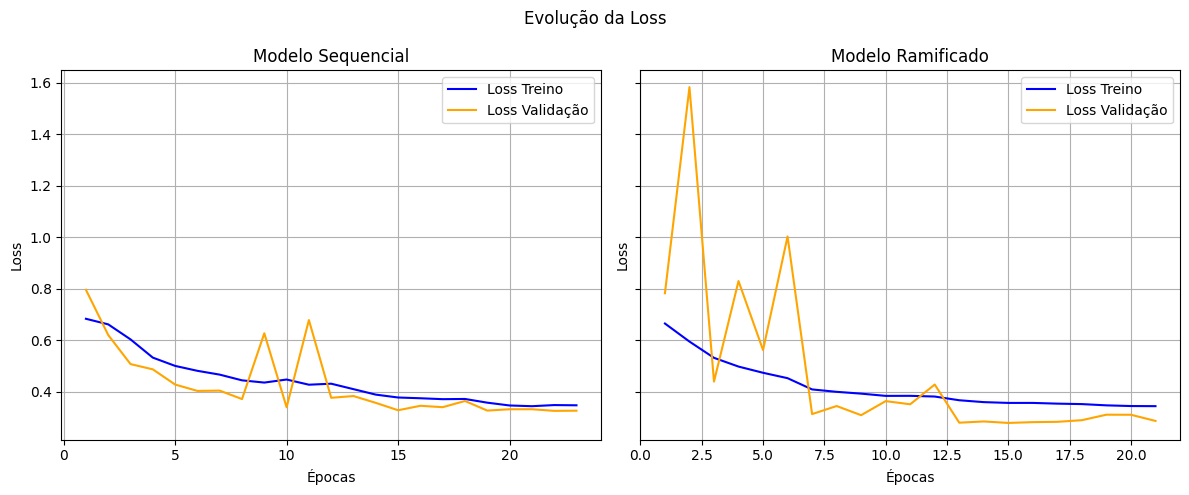

In [75]:
plot_training_history([best_seq_history, best_ram_history], titles=titles)

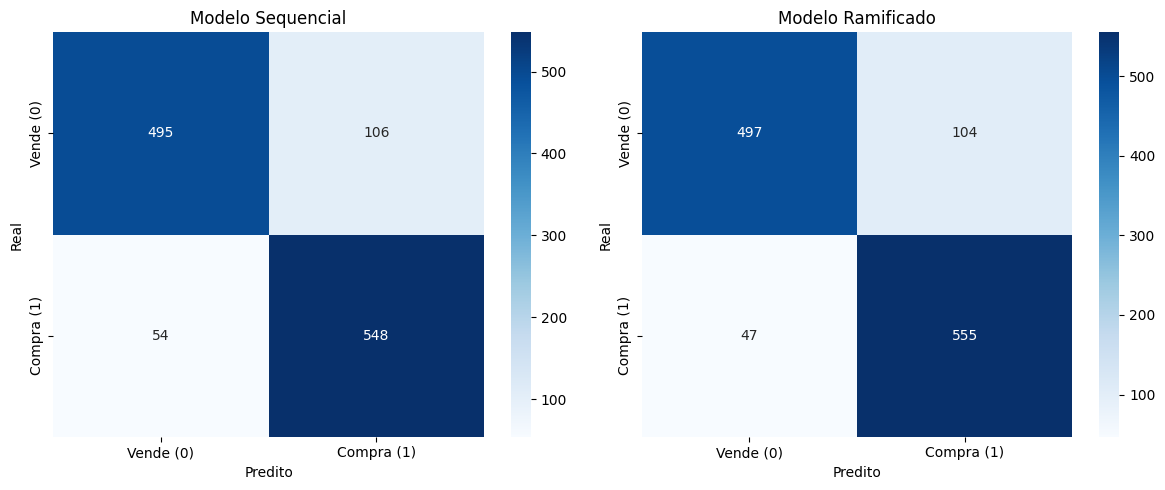

In [76]:
plot_confusion_matrix([best_seq_metrics, best_ram_metrics], titles=titles)

In [77]:
show_classification_reports(
    metrics_list=[best_seq_metrics, best_ram_metrics],
    titles=titles
)

📊 Relatório de Classificação - Modelo Sequencial

Vende (0):
Precision: 0.90
Recall:    0.82
F1-Score:  0.86

Compra (1):
Precision: 0.84
Recall:    0.91
F1-Score:  0.87

Médias:
Acurácia:  0.87
Precision: 0.87
Recall:    0.87
F1-Score:  0.87


📊 Relatório de Classificação - Modelo Ramificado

Vende (0):
Precision: 0.91
Recall:    0.83
F1-Score:  0.87

Compra (1):
Precision: 0.84
Recall:    0.92
F1-Score:  0.88

Médias:
Acurácia:  0.87
Precision: 0.88
Recall:    0.87
F1-Score:  0.87




In [78]:
resultado_backtest = run_backtest(
    predictions=best_seq_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Sequencial",
    stock_name="VALE3",
    metrics = best_seq_metrics,
    cdi_df=cdi,
    metric_optimization = metric_optimization)

resultado_backtest = run_backtest(
    predictions=best_ram_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Ramificado",
    stock_name="VALE3",
    metrics = best_ram_metrics,
    cdi_df=cdi,
    metric_optimization = metric_optimization)

resultado_backtest

<ipython-input-29-c41ff92325cd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
<ipython-input-29-c41ff92325cd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]


Data          Modelo   Ação Métrica de Otimização  \
0  2025-04-16 12:23:53.362046  CNN Sequencial  BBAS3              val_loss   
1  2025-04-16 12:23:53.391346  CNN Ramificado  BBAS3              val_loss   
2  2025-04-16 12:46:07.408853  CNN Sequencial  CSAN3              val_loss   
3  2025-04-16 12:46:07.433368  CNN Ramificado  CSAN3              val_loss   
4  2025-04-16 13:10:19.078491  CNN Sequencial  PETR4              val_loss   
5  2025-04-16 13:10:19.110849  CNN Ramificado  PETR4              val_loss   
6  2025-04-16 13:33:04.638988  CNN Sequencial  VALE3              val_loss   
7  2025-04-16 13:33:04.666833  CNN Ramificado  VALE3              val_loss   

   Acurácia  Precision    Recall        F1       Matriz de Confusão  \
0  0.861603   0.857606  0.858397  0.857991   [[605, 84], [80, 416]]   
1  0.897046   0.895619  0.892264  0.893806   [[635, 54], [68, 428]]   
2  0.865936   0.865964  0.857552  0.860931   [[626, 62], [97, 401]]   
3  0.884486   0.881235  0.881859  0.881541   [[618, 70], [67, 431]]   
4  0.835411   0.843515  0.832724  0.833497  [[438, 143], [55, 567]]   
5  0.855362   0.863748  0.852754  0.853731  [[451, 130], [44, 578]]   
6  0.866999   0.869780  0.866963  0.866741  [[495, 106], [54, 548]]   
7  0.874480   0.877894  0.874441  0.874188  [[497, 104], [47, 555]]   

   Saldo Inicial  Saldo Final  Total de Ações   Lucro Total   Lucro (%)  \
0          10000    28.909737           231.0   2823.999596   28.239996   
1          10000    34.754650           338.0   8756.574444   87.565744   
2          10000     4.337842          1188.0  13360.417661  133.604177   
3          10000     4.731443          1288.0  15326.811246  153.268112   
4          10000    21.154176           732.0  17280.835405  172.808354   
5          10000    15.290708           641.0  13886.131784  138.861318   
6          10000    41.098503           260.0  10113.097710  101.130977   
7          10000    29.400602           256.0   9792.599821   97.925998   

   Lucro (%) CDI  
0      42.269210  
1      42.269210  
2      42.269210  
3      42.269210  
4      42.937875  
5      42.937875  
6      42.937875  
7      42.937875

A arquitetura de rede CNN ramificada foi a vencedora em ambos os ativos, então levaremos ela para a pipeline completa do modelo campeão.

## **Pipeline Completa com a Arquitetura Campeã**

A arquitetura ramificada venceu! Então, vou construir uma pipeline completa utilizando esse modelo para todos os ativos.

As estratégias de treinamento e validação permanecerão as mesmas. No entanto, agora o processo foi aprimorado com as seguintes melhorias:
* Os resultados dos modelos (métricas de desempenho, melhores hiperparâmetros e backtest) serão salvos em uma pasta no diretório do GitHub;
* Incluí um identificador único de execução, o run_id, que permitirá o relacionamento entre diferentes tabelas e maior controle das versões dos experimentos.

❗Para rodar o código abaixo é necessário excluir e iniciar o atual e iniciar um novo ambiente de execução.

### **Importação de Bibliotecas**

In [ ]:
!git clone https://github.com/luizh3nriqu3/data-science-projects.git
!pip install optuna --quiet

Cloning into 'data-science-projects'...
remote: Enumerating objects: 23949, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 23949 (delta 1), reused 12 (delta 1), pack-reused 23936 (from 2)
Receiving objects: 100% (23949/23949), 120.97 MiB | 13.26 MiB/s, done.
Resolving deltas: 100% (8/8), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulação
import numpy as np
import pandas as pd
import os
import math
from datetime import datetime
import random
from itertools import product
import optuna
import uuid

# Métricas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

# DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint

# Configuração de seed para reprodutibilidade
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

### **Importação da Base**

In [ ]:
# Lista de arquivos ZIP
zip_files = [
    "/content/data-science-projects/deep-learning/data/BBAS3.SA.zip",
    "/content/data-science-projects/deep-learning/data/CSNA3.SA.zip",
    "/content/data-science-projects/deep-learning/data/PETR4.SA.zip",
    "/content/data-science-projects/deep-learning/data/VALE3.SA.zip",
    "/content/data-science-projects/deep-learning/data/CDI.zip"
]

# Descompacta apenas se ainda não estiver descompactado
for zip_file in zip_files:
    folder_name = zip_file.replace(".zip", "")
    if not os.path.exists(folder_name):
        os.makedirs(folder_name, exist_ok=True)
        !unzip -o -j "{zip_file}" -d "{folder_name}"
        print(f"Descompactado: {zip_file}")
    else:
        print(f"Já está descompactado: {zip_file}")


Archive:  /content/data-science-projects/deep-learning/data/BBAS3.SA.zip
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/._BBAS3.SA  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/.DS_Store  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/._.DS_Store  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/visualizacao.html  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/teste.csv  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/treino.csv  
Descompactado: /content/data-science-projects/deep-learning/data/BBAS3.SA.zip
Archive:  /content/data-science-projects/deep-learning/data/CSNA3.SA.zip
  inflating: /content/data-science-projects/deep-learning/data/CSNA3.SA/._CSNA3.SA  
  inflating: /content/data-science-projects/deep-learning/data/CSNA3.SA/.DS_Store  
  inflating: /content/data-science-projects/deep-learning/data/CSNA3.SA/._.DS_Store  
  inf

In [ ]:
def load_data(path):
    df_train = pd.read_csv(os.path.join(path, "treino.csv"))
    df_test = pd.read_csv(os.path.join(path, "teste.csv"))
    return df_train, df_test

In [ ]:
## BBAS3
bb_train, bb_test = load_data("/content/data-science-projects/deep-learning/data/BBAS3.SA")

## CSNA3
cs_train, cs_test = load_data("/content/data-science-projects/deep-learning/data/CSNA3.SA")

## PETR4
pe_train, pe_test = load_data("/content/data-science-projects/deep-learning/data/PETR4.SA")

## VALE3
vl_train, vl_test = load_data("/content/data-science-projects/deep-learning/data/VALE3.SA")

## CDI
cdi = pd.read_csv("/content/data-science-projects/deep-learning/data/CDI/CDI.csv")

In [ ]:
for col in cdi.columns:
    if col != "Ano":
        cdi[col] = (
            cdi[col]
            .astype(str)
            .str.replace(",", ".")
            .replace("---", None)
            .astype(float)
        )


### **Arquitetura da Rede**

In [ ]:
def model_cnn_ramificado():
    input1 = Input(shape=(7, 1))
    input2 = Input(shape=(8, 1))

    x1 = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(input1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)
    x2 = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(input2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Flatten()(x2)

    combined = Concatenate()([x1, x2])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[input1, input2], outputs=output)
    return model


### **Funções de Pré-Processamento, Treinamento e Backtest**

In [ ]:
def ensure_input_format(X):
    if isinstance(X, (list, tuple)):
        return X
    return [X]

In [ ]:
def save_data(df, path, name):
    os.makedirs(path, exist_ok=True)

    file_path = os.path.join(path, f"{name}.csv")

    if os.path.exists(file_path):
        df_old = pd.read_csv(file_path)
        df_new = pd.concat([df_old, df], ignore_index=True)
    else:
        df_new = df

    df_new.to_csv(file_path, index=False)


In [ ]:
def preprocess_data(train_df, test_df):
    scaler = StandardScaler()

    features = [f"Past_{i}_Days_Close" for i in range(1, 16)]

    janela_curta = features[:7]
    janela_longa = features[7:]
    split_features = [janela_curta, janela_longa]

    X_train = train_df[features].values
    X_test = test_df[features].values

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train = train_df["Label"].replace({-1: 0, 1: 1}).values
    y_test = test_df["Label"].replace({-1: 0, 1: 1}).values

    processed = []
    for feature_group in split_features:
        idx = [features.index(col) for col in feature_group]
        reshaped_train = X_train[:, idx].reshape((X_train.shape[0], len(feature_group), 1))
        reshaped_test = X_test[:, idx].reshape((X_test.shape[0], len(feature_group), 1))
        processed.extend([reshaped_train, reshaped_test])

    return (*processed, y_train, y_test, features)

In [ ]:
def get_callbacks(model_path, stop_patience, reduce_lr_factor, reduce_lr_patience):
    return [
        EarlyStopping(monitor="val_loss", patience=stop_patience, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=reduce_lr_factor, patience=reduce_lr_patience, min_lr=1e-6, verbose=1),
        ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1)
    ]

In [ ]:
def get_metrics(y_test, y_pred, prob, history):
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)

    metrics = {
        'accuracy': accuracy,
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
        'class_metrics': {
            'Vende (0)': report['0'],
            'Compra (1)': report['1']
        },
        'macro_avg': report['macro avg'],
        'weighted_avg': report['weighted avg']
    }

    summary = {
        'MACRO_RECALL': report['macro avg']['recall'],
        'WEIGHTED_RECALL': report['weighted avg']['recall'],
        'COMPRA_RECALL': report['1']['recall'],
        'VENDE_RECALL': report['0']['recall'],
        'COMPRA_PRECISION': report['1']['precision'],
        'VENDE_PRECISION': report['0']['precision'],
        'ACURACIA': accuracy,
        'VAL_LOSS': min(history.history["val_loss"])
    }

    return metrics, summary

In [ ]:
def train_model(model_fn, X_train, y_train, X_test, y_test,
                prob=0.5, n_trials=20, metric_to_optimize='val_loss',
                model_path='best_model.keras'):

    results = []
    best_model = None
    best_history = None
    best_metrics = None
    best_y_pred = None
    best_params = None
    best_summary = None

    run_id = str(uuid.uuid4())

    result_path = "/content/data-science-projects/deep-learning/results"

    model_dir = "/content/data-science-projects/deep-learning/models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, os.path.basename(model_path))

    def objective(trial):
        nonlocal best_model, best_history, best_metrics, best_y_pred, best_params, best_summary

        params = {
            'epochs': trial.suggest_int('epochs', 10, 50),
            'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
            'lr': trial.suggest_float('learning_rate', 1e-5, 1e-2),
            'stop_patience': trial.suggest_int('stop_patience', 3, 10),
            'reduce_lr_factor': trial.suggest_float('reduce_lr_factor', 0.1, 0.5),
            'reduce_lr_patience': trial.suggest_int('reduce_lr_patience', 2, 5),
        }

        model = model_fn()
        optimizer = Adam(learning_rate=params['lr'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        callbacks = get_callbacks(model_path, params['stop_patience'], params['reduce_lr_factor'], params['reduce_lr_patience'])

        X_train_input = ensure_input_format(X_train)
        X_test_input = ensure_input_format(X_test)
        if len(X_train_input) == 1:
            X_train_input, X_test_input = X_train_input[0], X_test_input[0]

        history = model.fit(X_train_input, y_train,
                            validation_data=(X_test_input, y_test),
                            epochs=params['epochs'],
                            batch_size=params['batch_size'],
                            callbacks=callbacks, verbose=1)

        model.load_weights(model_path)
        y_pred_prob = model.predict(X_test_input)
        y_pred = (y_pred_prob > prob).astype(int)

        metrics, summary = get_metrics(y_test, y_pred, prob, history)
        score = -summary['VAL_LOSS'] if metric_to_optimize == "val_loss" else summary.get(metric_to_optimize, summary[metric_to_optimize])

        results.append({**params, **summary, 'trial': trial.number})

        if score > objective.best_score:
            objective.best_score = score
            best_model, best_history, best_metrics, best_y_pred = model, history, metrics, y_pred
            best_params = params.copy()
            best_summary = summary.copy()

        return score

    objective.best_score = -np.inf
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    result_path = "/content/data-science-projects/deep-learning/results"

    df_combined = pd.DataFrame([{
        'RUN_ID': run_id,
        "DATA": datetime.now(),
        **best_metrics,
        **best_params,
        **best_summary
    }])

    save_data(df_combined, result_path, "metrics_hyperparams_result")

    return best_model, best_history, best_metrics, best_y_pred, df_combined, run_id


In [ ]:
def run_backtest(predictions, prices, capital, model_name, stock_name,
                 metrics, cdi_df=None, metric_optimization=None, run_id=None):

    capital_atual = capital
    posicao = 0
    valor_compra = 0
    operacoes = []

    for i in range(len(predictions) - 1):
        preco_atual = prices[i]

        if predictions[i] == 1 and capital_atual >= preco_atual:
            qtd_comprada = capital_atual // preco_atual
            valor_compra = qtd_comprada * preco_atual
            posicao += qtd_comprada
            capital_atual -= valor_compra

        elif predictions[i] == 0 and posicao > 0:
            valor_venda = posicao * preco_atual
            capital_atual += valor_venda
            retorno = (valor_venda - valor_compra) / valor_compra if valor_compra > 0 else 0
            operacoes.append(retorno)
            posicao = 0

    valor_investido = posicao * prices.iloc[-1]
    lucro = (capital_atual + valor_investido) - capital
    lucro_percentual = (lucro / capital) * 100


    lucro_cdi_pct = None
    if cdi_df is not None:
        try:
            cdi_long = cdi_df.melt(id_vars='Ano', var_name='Mes', value_name='CDI')
            meses_map = {
                'Jan': 1, 'Fev': 2, 'Mar': 3, 'Abr': 4, 'Mai': 5, 'Jun': 6,
                'Jul': 7, 'Ago': 8, 'Set': 9, 'Out': 10, 'Nov': 11, 'Dez': 12
            }
            cdi_long['Mes_num'] = cdi_long['Mes'].map(meses_map)
            cdi_long['Data'] = pd.to_datetime(dict(year=cdi_long['Ano'], month=cdi_long['Mes_num'], day=1))
            cdi_long['CDI'] = cdi_long['CDI'].astype(float) / 100

            if not np.issubdtype(prices.index.dtype, np.datetime64):
              prices.index = pd.to_datetime(prices.index)

            inicio = prices.index.min()
            fim = prices.index.max()


            cdi_periodo = cdi_long[(cdi_long['Data'] >= inicio) & (cdi_long['Data'] <= fim)]

            rendimento_cdi = (1 + cdi_periodo['CDI']).prod() - 1
            lucro_cdi_pct = rendimento_cdi * 100

        except Exception as e:
            print("Erro ao calcular o CDI:", e)

    resultado = {
        "RUN_ID": run_id,
        "DATA": datetime.now(),
        "MODELO": model_name,
        "TICKER": stock_name,
        "OTIMIZACAO": metric_optimization,
        "ACURACIA": round(metrics['accuracy'] * 100, 2),
        "PRECISION": round(metrics['macro_avg']['precision'] * 100, 2),
        "RECALL": round(metrics['macro_avg']['recall'] * 100, 2),
        "F1": round(metrics['macro_avg']['f1-score'] * 100, 2),
        "MATRIZ_CONFUSAO": metrics['confusion_matrix'],
        "SALDO_INICIAL": round(capital, 2),
        "SALDO_FINAL": round(capital_atual, 2),
        "TOTAL_TICKER": posicao,
        "LUCRO_TOTAL": round(lucro, 2),
        "LUCRO_PERCENTUAL": round(lucro_percentual, 2),
        "LUCRO_CDI_PERCENTUAL": round(lucro_cdi_pct, 2) if lucro_cdi_pct is not None else None
    }

    caminho_resultado = "/content/data-science-projects/deep-learning/results"

    save_data(pd.DataFrame([resultado]), path=caminho_resultado, name="backtest_results")

    return pd.DataFrame([resultado])

In [ ]:
def plot_training_history(histories, titles=None):
    n = len(histories)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)

    if titles is None:
        titles = [f"Modelo {i+1}" for i in range(n)]

    for i, history in enumerate(histories):
        ax = axes[i] if n > 1 else axes
        history_dict = history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        epochs = range(1, len(loss) + 1)

        ax.plot(epochs, loss, label='Loss Treino', color='blue')
        ax.plot(epochs, val_loss, label='Loss Validação', color='orange')
        ax.set_title(titles[i])
        ax.set_xlabel('Épocas')
        ax.set_ylabel('Loss')
        ax.grid(True)
        ax.legend()

    plt.suptitle('Evolução da Loss')
    plt.tight_layout()
    plt.show()

In [ ]:
def run_pipeline(data_dict, model, capital=10000, prob=0.5,
                      metric_to_optimize='val_loss', n_trials=30,
                      cdi_df=None):
    resultados_backtest = []

    for nome_acao, (df_train, df_test) in data_dict.items():
        print(f"\n==== Iniciando pipeline para {nome_acao} ====")

        model_dir = "/content/models"

        X_train_a, X_test_a, X_train_b, X_test_b, y_train, y_test, features = preprocess_data(df_train, df_test)

        best_model, best_history, best_metrics, best_y_pred, df_resultados, run_id = train_model(
            model,
            X_train=[X_train_a, X_train_b],
            y_train=y_train,
            X_test=[X_test_a, X_test_b],
            y_test=y_test,
            prob=prob,
            n_trials=n_trials,
            metric_to_optimize=metric_to_optimize,
            model_path=os.path.join(model_dir, f"best_model_{nome_acao}.keras")
        )
        df_backtest = run_backtest(
            predictions=best_y_pred,
            prices=df_test.set_index("Date")["Close"],
            capital=capital,
            model_name="Ramificado",
            stock_name=nome_acao,
            metrics=best_metrics,
            cdi_df=cdi_df,
            metric_optimization=metric_to_optimize,
            run_id=run_id
        )

        resultados_backtest.append(df_backtest)

    df_final = pd.concat(resultados_backtest, ignore_index=True)
    return df_final

### **Treinamento e Backtest**

In [ ]:
datasets = {
    "BBAS3": (bb_train, bb_test),
    "CSNA3": (cs_train, cs_test),
    "PETR4": (pe_train, pe_test),
    "VALE3": (vl_train, vl_test),
}

_ = run_pipeline(datasets, model=model_cnn_ramificado, cdi_df=cdi, metric_to_optimize='val_loss', n_trials=30)

[I 2025-04-15 23:20:51,940] A new study created in memory with name: no-name-68fa390c-918e-4168-9921-9126e05d4a32



==== Iniciando pipeline para BBAS3 ====
Epoch 1/30
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5800 - loss: 0.6812
Epoch 1: val_loss improved from inf to 0.38516, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5828 - loss: 0.6784 - val_accuracy: 0.8346 - val_loss: 0.3852 - learning_rate: 0.0083
Epoch 2/30
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6610 - loss: 0.5883
Epoch 2: val_loss did not improve from 0.38516
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6626 - loss: 0.5865 - val_accuracy: 0.8000 - val_loss: 0.3950 - learning_rate: 0.0083
Epoch 3/30
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6973 - loss: 0.5423
Epoch 3: val_loss improved from 0.38516 to 0.36467, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6975 - loss: 0.5418 - val_accuracy: 0.8236 

[I 2025-04-15 23:21:17,736] Trial 0 finished with value: -0.2509520947933197 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.008315255798702516, 'stop_patience': 7, 'reduce_lr_factor': 0.286370344670279, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.2509520947933197.


Epoch 1/24
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5059 - loss: 0.6943
Epoch 1: val_loss improved from inf to 0.67293, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5081 - loss: 0.6941 - val_accuracy: 0.7443 - val_loss: 0.6729 - learning_rate: 8.0648e-05
Epoch 2/24
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5886 - loss: 0.6809
Epoch 2: val_loss improved from 0.67293 to 0.63598, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5886 - loss: 0.6809 - val_accuracy: 0.8312 - val_loss: 0.6360 - learning_rate: 8.0648e-05
Epoch 3/24
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6003 - loss: 0.6688
Epoch 3: val_loss improved from 0.63598 to 0.61093, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━

[I 2025-04-15 23:22:07,917] Trial 1 finished with value: -0.3117576539516449 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 8.064828135556735e-05, 'stop_patience': 3, 'reduce_lr_factor': 0.13223445117701124, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.2509520947933197.


Epoch 1/12
65/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5569 - loss: 0.6873
Epoch 1: val_loss improved from inf to 0.58749, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5595 - loss: 0.6855 - val_accuracy: 0.6751 - val_loss: 0.5875 - learning_rate: 0.0014
Epoch 2/12
64/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 0.6343
Epoch 2: val_loss improved from 0.58749 to 0.45726, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6276 - loss: 0.6323 - val_accuracy: 0.7586 - val_loss: 0.4573 - learning_rate: 0.0014
Epoch 3/12
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6937 - loss: 0.5772
Epoch 3: val_loss improved from 0.45726 to 0.40217, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - ac

[I 2025-04-15 23:22:19,222] Trial 2 finished with value: -0.31143027544021606 and parameters: {'epochs': 12, 'batch_size': 64, 'learning_rate': 0.0013720953918972183, 'stop_patience': 9, 'reduce_lr_factor': 0.42404124791006426, 'reduce_lr_patience': 4}. Best is trial 0 with value: -0.2509520947933197.


Epoch 1/46
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5585 - loss: 0.6868
Epoch 1: val_loss improved from inf to 0.51896, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5592 - loss: 0.6862 - val_accuracy: 0.8456 - val_loss: 0.5190 - learning_rate: 0.0023
Epoch 2/46
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6298 - loss: 0.6293
Epoch 2: val_loss improved from 0.51896 to 0.49613, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6308 - loss: 0.6285 - val_accuracy: 0.7325 - val_loss: 0.4961 - learning_rate: 0.0023
Epoch 3/46
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6922 - loss: 0.5627
Epoch 3: val_loss improved from 0.49613 to 0.33559, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc

[I 2025-04-15 23:22:27,961] Trial 3 finished with value: -0.288908451795578 and parameters: {'epochs': 46, 'batch_size': 64, 'learning_rate': 0.0023442982731357895, 'stop_patience': 3, 'reduce_lr_factor': 0.31961020110744853, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.2509520947933197.


Epoch 1/43
136/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5753 - loss: 0.6915
Epoch 1: val_loss improved from inf to 0.43392, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5767 - loss: 0.6894 - val_accuracy: 0.8236 - val_loss: 0.4339 - learning_rate: 0.0083
Epoch 2/43
134/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6815 - loss: 0.5765
Epoch 2: val_loss did not improve from 0.43392
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6822 - loss: 0.5763 - val_accuracy: 0.7679 - val_loss: 0.4494 - learning_rate: 0.0083
Epoch 3/43
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7112 - loss: 0.5277
Epoch 3: val_loss improved from 0.43392 to 0.37448, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7111 - loss: 0.5274 - val_accuracy: 0.8768 - val_loss: 0.3745 - learning_rat

[I 2025-04-15 23:22:45,334] Trial 4 finished with value: -0.2553301751613617 and parameters: {'epochs': 43, 'batch_size': 32, 'learning_rate': 0.008323451651069713, 'stop_patience': 6, 'reduce_lr_factor': 0.1314660208506736, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.2509520947933197.


Epoch 1/28
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5542 - loss: 0.6902
Epoch 1: val_loss improved from inf to 0.66175, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5546 - loss: 0.6901 - val_accuracy: 0.7350 - val_loss: 0.6617 - learning_rate: 2.0159e-04
Epoch 2/28
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6045 - loss: 0.6762
Epoch 2: val_loss improved from 0.66175 to 0.62817, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6046 - loss: 0.6762 - val_accuracy: 0.7848 - val_loss: 0.6282 - learning_rate: 2.0159e-04
Epoch 3/28
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6006 - loss: 0.6649
Epoch 3: val_loss improved from 0.62817 to 0.59447, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/s

[I 2025-04-15 23:23:07,038] Trial 5 finished with value: -0.31259605288505554 and parameters: {'epochs': 28, 'batch_size': 64, 'learning_rate': 0.00020158692575546625, 'stop_patience': 5, 'reduce_lr_factor': 0.41434767648607806, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.2509520947933197.


Epoch 1/27
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5696 - loss: 0.6852
Epoch 1: val_loss improved from inf to 0.68510, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5699 - loss: 0.6850 - val_accuracy: 0.5975 - val_loss: 0.6851 - learning_rate: 0.0041
Epoch 2/27
64/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6331 - loss: 0.6210
Epoch 2: val_loss improved from 0.68510 to 0.37806, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6372 - loss: 0.6176 - val_accuracy: 0.8228 - val_loss: 0.3781 - learning_rate: 0.0041
Epoch 3/27
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7023 - loss: 0.5467
Epoch 3: val_loss did not improve from 0.37806
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7025 - loss: 0.5464 - val_accuracy: 0.7097 - val_loss: 0.8180 - learning_rate: 0.0041
E

[I 2025-04-15 23:23:13,891] Trial 6 finished with value: -0.37805530428886414 and parameters: {'epochs': 27, 'batch_size': 64, 'learning_rate': 0.004147884639180182, 'stop_patience': 4, 'reduce_lr_factor': 0.4494346761124076, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.2509520947933197.


Epoch 1/23
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5881 - loss: 0.6767
Epoch 1: val_loss improved from inf to 0.42148, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5882 - loss: 0.6766 - val_accuracy: 0.8414 - val_loss: 0.4215 - learning_rate: 0.0054
Epoch 2/23
141/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6651 - loss: 0.5908
Epoch 2: val_loss improved from 0.42148 to 0.35737, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6657 - loss: 0.5902 - val_accuracy: 0.8515 - val_loss: 0.3574 - learning_rate: 0.0054
Epoch 3/23
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7178 - loss: 0.5235
Epoch 3: val_loss improved from 0.35737 to 0.30237, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

[I 2025-04-15 23:23:33,827] Trial 7 finished with value: -0.25360140204429626 and parameters: {'epochs': 23, 'batch_size': 32, 'learning_rate': 0.0053756200282286835, 'stop_patience': 5, 'reduce_lr_factor': 0.17084914402340357, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.2509520947933197.


Epoch 1/11
135/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5764 - loss: 0.6849
Epoch 1: val_loss improved from inf to 0.61926, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5794 - loss: 0.6827 - val_accuracy: 0.6667 - val_loss: 0.6193 - learning_rate: 0.0081
Epoch 2/11
139/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6718 - loss: 0.5833
Epoch 2: val_loss improved from 0.61926 to 0.30301, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6728 - loss: 0.5825 - val_accuracy: 0.8802 - val_loss: 0.3030 - learning_rate: 0.0081
Epoch 3/11
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6992 - loss: 0.5203
Epoch 3: val_loss did not improve from 0.30301
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6993 - loss: 0.5203 - val_accuracy: 0.8169 - val_loss: 0.4324 - learning_rat

[I 2025-04-15 23:23:50,152] Trial 8 finished with value: -0.266623854637146 and parameters: {'epochs': 11, 'batch_size': 32, 'learning_rate': 0.008051401395452327, 'stop_patience': 8, 'reduce_lr_factor': 0.2728825775934288, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.2509520947933197.


Epoch 1/11
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5882 - loss: 0.6743
Epoch 1: val_loss improved from inf to 0.67651, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5884 - loss: 0.6741 - val_accuracy: 0.6717 - val_loss: 0.6765 - learning_rate: 0.0065
Epoch 2/11
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6877 - loss: 0.5706
Epoch 2: val_loss improved from 0.67651 to 0.42776, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6877 - loss: 0.5708 - val_accuracy: 0.7823 - val_loss: 0.4278 - learning_rate: 0.0065
Epoch 3/11
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7064 - loss: 0.5193
Epoch 3: val_loss did not improve from 0.42776
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7066 - loss: 0.5192 - val_accuracy: 0.7409 - val_loss: 0.5375 - learning_rat

[I 2025-04-15 23:24:13,832] Trial 9 finished with value: -0.24920448660850525 and parameters: {'epochs': 11, 'batch_size': 16, 'learning_rate': 0.006479279995127997, 'stop_patience': 9, 'reduce_lr_factor': 0.47848439436158874, 'reduce_lr_patience': 3}. Best is trial 9 with value: -0.24920448660850525.


Epoch 1/38
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5985 - loss: 0.6763
Epoch 1: val_loss improved from inf to 0.46990, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5990 - loss: 0.6758 - val_accuracy: 0.7713 - val_loss: 0.4699 - learning_rate: 0.0059
Epoch 2/38
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6855 - loss: 0.5670
Epoch 2: val_loss improved from 0.46990 to 0.28117, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6858 - loss: 0.5666 - val_accuracy: 0.8911 - val_loss: 0.2812 - learning_rate: 0.0059
Epoch 3/38
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7149 - loss: 0.5170
Epoch 3: val_loss did not improve from 0.28117
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7150 - loss: 0.5169 - val_accuracy: 0.8008 - val_loss: 0.4199 - learning_rat

[I 2025-04-15 23:25:10,661] Trial 10 finished with value: -0.2533600926399231 and parameters: {'epochs': 38, 'batch_size': 16, 'learning_rate': 0.0058812412051176925, 'stop_patience': 10, 'reduce_lr_factor': 0.4998285578949034, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.24920448660850525.


Epoch 1/18
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5719 - loss: 0.6856
Epoch 1: val_loss improved from inf to 0.61348, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5725 - loss: 0.6850 - val_accuracy: 0.6186 - val_loss: 0.6135 - learning_rate: 0.0070
Epoch 2/18
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6687 - loss: 0.5960
Epoch 2: val_loss improved from 0.61348 to 0.31308, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6690 - loss: 0.5957 - val_accuracy: 0.8861 - val_loss: 0.3131 - learning_rate: 0.0070
Epoch 3/18
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6996 - loss: 0.5247
Epoch 3: val_loss did not improve from 0.31308
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6997 - loss: 0.5250 - val_accuracy: 0.8768 - val_loss: 0.3286 - learning_ra

[I 2025-04-15 23:25:56,269] Trial 11 finished with value: -0.2539360821247101 and parameters: {'epochs': 18, 'batch_size': 16, 'learning_rate': 0.007043625567211321, 'stop_patience': 8, 'reduce_lr_factor': 0.3041262678305377, 'reduce_lr_patience': 3}. Best is trial 9 with value: -0.24920448660850525.


Epoch 1/36
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5836 - loss: 0.6853
Epoch 1: val_loss improved from inf to 0.74540, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5837 - loss: 0.6852 - val_accuracy: 0.5595 - val_loss: 0.7454 - learning_rate: 0.0098
Epoch 2/36
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6377 - loss: 0.6114
Epoch 2: val_loss improved from 0.74540 to 0.49432, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6379 - loss: 0.6110 - val_accuracy: 0.7392 - val_loss: 0.4943 - learning_rate: 0.0098
Epoch 3/36
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6886 - loss: 0.5278
Epoch 3: val_loss improved from 0.49432 to 0.31241, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms

[I 2025-04-15 23:26:39,431] Trial 12 finished with value: -0.2568919360637665 and parameters: {'epochs': 36, 'batch_size': 16, 'learning_rate': 0.009792279961603438, 'stop_patience': 7, 'reduce_lr_factor': 0.23817427581042336, 'reduce_lr_patience': 3}. Best is trial 9 with value: -0.24920448660850525.


Epoch 1/34
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5672 - loss: 0.6847
Epoch 1: val_loss improved from inf to 0.40312, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5678 - loss: 0.6840 - val_accuracy: 0.8743 - val_loss: 0.4031 - learning_rate: 0.0100
Epoch 2/34
66/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6377 - loss: 0.6176
Epoch 2: val_loss did not improve from 0.40312
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6387 - loss: 0.6171 - val_accuracy: 0.7747 - val_loss: 0.4181 - learning_rate: 0.0100
Epoch 3/34
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6781 - loss: 0.5548
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035905023875255257.

Epoch 3: val_loss did not improve from 0.40312
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6789 - loss: 0.5537 - val_accuracy: 0.7544 - val_loss: 0.4373 - learning_rate: 0.0100
Epoch 4/34
71/74 ━━━

[I 2025-04-15 23:26:56,186] Trial 13 finished with value: -0.30036598443984985 and parameters: {'epochs': 34, 'batch_size': 64, 'learning_rate': 0.009997466009172874, 'stop_patience': 10, 'reduce_lr_factor': 0.359141257797776, 'reduce_lr_patience': 2}. Best is trial 9 with value: -0.24920448660850525.


Epoch 1/18
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5865 - loss: 0.6729
Epoch 1: val_loss improved from inf to 0.50336, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5866 - loss: 0.6728 - val_accuracy: 0.7342 - val_loss: 0.5034 - learning_rate: 0.0069
Epoch 2/18
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6858 - loss: 0.5700
Epoch 2: val_loss improved from 0.50336 to 0.47602, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6857 - loss: 0.5697 - val_accuracy: 0.7148 - val_loss: 0.4760 - learning_rate: 0.0069
Epoch 3/18
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7078 - loss: 0.5132
Epoch 3: val_loss did not improve from 0.47602
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7081 - loss: 0.5130 - val_accuracy: 0.5629 - val_loss: 1.9580 - learning_rat

[I 2025-04-15 23:27:34,944] Trial 14 finished with value: -0.2515583634376526 and parameters: {'epochs': 18, 'batch_size': 16, 'learning_rate': 0.006850552505537857, 'stop_patience': 8, 'reduce_lr_factor': 0.21636248441377404, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.24920448660850525.


Epoch 1/50
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5669 - loss: 0.6758
Epoch 1: val_loss improved from inf to 0.38906, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5704 - loss: 0.6734 - val_accuracy: 0.8574 - val_loss: 0.3891 - learning_rate: 0.0042
Epoch 2/50
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6628 - loss: 0.5846
Epoch 2: val_loss did not improve from 0.38906
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6632 - loss: 0.5841 - val_accuracy: 0.7789 - val_loss: 0.4533 - learning_rate: 0.0042
Epoch 3/50
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7139 - loss: 0.5291
Epoch 3: val_loss improved from 0.38906 to 0.30443, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7143 - loss: 0.5284 - val_accuracy: 0.8591 - val_loss: 0.3044 - learning_rate: 0.0042
E

[I 2025-04-15 23:27:47,482] Trial 15 finished with value: -0.2801843583583832 and parameters: {'epochs': 50, 'batch_size': 64, 'learning_rate': 0.004211227189379059, 'stop_patience': 7, 'reduce_lr_factor': 0.3640253101421237, 'reduce_lr_patience': 3}. Best is trial 9 with value: -0.24920448660850525.


Epoch 1/18
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5520 - loss: 0.6859
Epoch 1: val_loss improved from inf to 0.71471, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5530 - loss: 0.6851 - val_accuracy: 0.5772 - val_loss: 0.7147 - learning_rate: 0.0081
Epoch 2/18
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6717 - loss: 0.5754
Epoch 2: val_loss improved from 0.71471 to 0.29464, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6716 - loss: 0.5754 - val_accuracy: 0.8878 - val_loss: 0.2946 - learning_rate: 0.0081
Epoch 3/18
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7032 - loss: 0.5223
Epoch 3: val_loss did not improve from 0.29464
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7031 - loss: 0.5222 - val_accuracy: 0.8135 - val_loss: 0.4173 - learning_rat

[I 2025-04-15 23:28:24,955] Trial 16 finished with value: -0.2526038885116577 and parameters: {'epochs': 18, 'batch_size': 16, 'learning_rate': 0.008145225090847131, 'stop_patience': 9, 'reduce_lr_factor': 0.36137942653684524, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.24920448660850525.


Epoch 1/32
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5826 - loss: 0.6802
Epoch 1: val_loss improved from inf to 0.94151, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5831 - loss: 0.6797 - val_accuracy: 0.5342 - val_loss: 0.9415 - learning_rate: 0.0069
Epoch 2/32
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6884 - loss: 0.5767
Epoch 2: val_loss did not improve from 0.94151
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6885 - loss: 0.5759 - val_accuracy: 0.6169 - val_loss: 1.1305 - learning_rate: 0.0069
Epoch 3/32
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7217 - loss: 0.5197
Epoch 3: val_loss improved from 0.94151 to 0.41530, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7217 - loss: 0.5197 - val_accuracy: 0.7865 - val_loss: 0.4153 - learning_rat

[I 2025-04-15 23:28:57,514] Trial 17 finished with value: -0.24853558838367462 and parameters: {'epochs': 32, 'batch_size': 16, 'learning_rate': 0.006948493484091075, 'stop_patience': 6, 'reduce_lr_factor': 0.48382572652356814, 'reduce_lr_patience': 2}. Best is trial 17 with value: -0.24853558838367462.


Epoch 1/33
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5959 - loss: 0.6767
Epoch 1: val_loss improved from inf to 0.80032, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5964 - loss: 0.6762 - val_accuracy: 0.5544 - val_loss: 0.8003 - learning_rate: 0.0037
Epoch 2/33
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6789 - loss: 0.5798
Epoch 2: val_loss improved from 0.80032 to 0.57384, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6793 - loss: 0.5793 - val_accuracy: 0.7359 - val_loss: 0.5738 - learning_rate: 0.0037
Epoch 3/33
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7146 - loss: 0.5271
Epoch 3: val_loss improved from 0.57384 to 0.35575, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms

[I 2025-04-15 23:29:50,573] Trial 18 finished with value: -0.25398382544517517 and parameters: {'epochs': 33, 'batch_size': 16, 'learning_rate': 0.0036822832624542074, 'stop_patience': 6, 'reduce_lr_factor': 0.4978482411299162, 'reduce_lr_patience': 2}. Best is trial 17 with value: -0.24853558838367462.


Epoch 1/39
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5877 - loss: 0.6752
Epoch 1: val_loss improved from inf to 0.75890, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5884 - loss: 0.6742 - val_accuracy: 0.6042 - val_loss: 0.7589 - learning_rate: 0.0063
Epoch 2/39
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6683 - loss: 0.5742
Epoch 2: val_loss improved from 0.75890 to 0.50115, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6686 - loss: 0.5738 - val_accuracy: 0.7553 - val_loss: 0.5011 - learning_rate: 0.0063
Epoch 3/39
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7053 - loss: 0.5116
Epoch 3: val_loss improved from 0.50115 to 0.47046, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms

[I 2025-04-15 23:30:26,582] Trial 19 finished with value: -0.2523285150527954 and parameters: {'epochs': 39, 'batch_size': 16, 'learning_rate': 0.006281135258113736, 'stop_patience': 5, 'reduce_lr_factor': 0.4496423462501084, 'reduce_lr_patience': 2}. Best is trial 17 with value: -0.24853558838367462.


Epoch 1/24
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5913 - loss: 0.6786
Epoch 1: val_loss improved from inf to 0.61087, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5917 - loss: 0.6779 - val_accuracy: 0.6354 - val_loss: 0.6109 - learning_rate: 0.0050
Epoch 2/24
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6850 - loss: 0.5811
Epoch 2: val_loss improved from 0.61087 to 0.45357, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6850 - loss: 0.5811 - val_accuracy: 0.7688 - val_loss: 0.4536 - learning_rate: 0.0050
Epoch 3/24
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7145 - loss: 0.5105
Epoch 3: val_loss improved from 0.45357 to 0.38989, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms

[I 2025-04-15 23:31:11,571] Trial 20 finished with value: -0.2601996958255768 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 0.004997747613320197, 'stop_patience': 9, 'reduce_lr_factor': 0.40016925704733963, 'reduce_lr_patience': 2}. Best is trial 17 with value: -0.24853558838367462.


Epoch 1/31
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5928 - loss: 0.6775
Epoch 1: val_loss improved from inf to 0.84193, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5929 - loss: 0.6775 - val_accuracy: 0.6008 - val_loss: 0.8419 - learning_rate: 0.0074
Epoch 2/31
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6811 - loss: 0.5821
Epoch 2: val_loss improved from 0.84193 to 0.75040, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6812 - loss: 0.5818 - val_accuracy: 0.6996 - val_loss: 0.7504 - learning_rate: 0.0074
Epoch 3/31
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7025 - loss: 0.5181
Epoch 3: val_loss did not improve from 0.75040
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7026 - loss: 0.5180 - val_accuracy: 0.5831 - val_loss: 1.6313 - learning_rat

[I 2025-04-15 23:31:56,975] Trial 21 finished with value: -0.2615373432636261 and parameters: {'epochs': 31, 'batch_size': 16, 'learning_rate': 0.00738087888791608, 'stop_patience': 7, 'reduce_lr_factor': 0.45946293834103774, 'reduce_lr_patience': 3}. Best is trial 17 with value: -0.24853558838367462.


Epoch 1/41
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5542 - loss: 0.6979
Epoch 1: val_loss improved from inf to 0.52031, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5553 - loss: 0.6967 - val_accuracy: 0.7215 - val_loss: 0.5203 - learning_rate: 0.0091
Epoch 2/41
66/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6127 - loss: 0.6331
Epoch 2: val_loss did not improve from 0.52031
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6165 - loss: 0.6302 - val_accuracy: 0.7266 - val_loss: 0.5364 - learning_rate: 0.0091
Epoch 3/41
63/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6736 - loss: 0.5661
Epoch 3: val_loss improved from 0.52031 to 0.30289, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6741 - loss: 0.5649 - val_accuracy: 0.8793 - val_loss: 0.3029 - learning_rate: 0.0091
E

[I 2025-04-15 23:32:07,736] Trial 22 finished with value: -0.25637367367744446 and parameters: {'epochs': 41, 'batch_size': 64, 'learning_rate': 0.009136642672657718, 'stop_patience': 6, 'reduce_lr_factor': 0.2573927199784801, 'reduce_lr_patience': 3}. Best is trial 17 with value: -0.24853558838367462.


Epoch 1/29
135/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5733 - loss: 0.6856
Epoch 1: val_loss improved from inf to 0.46170, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5754 - loss: 0.6831 - val_accuracy: 0.7747 - val_loss: 0.4617 - learning_rate: 0.0090
Epoch 2/29
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6706 - loss: 0.5803
Epoch 2: val_loss improved from 0.46170 to 0.36326, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6707 - loss: 0.5802 - val_accuracy: 0.8768 - val_loss: 0.3633 - learning_rate: 0.0090
Epoch 3/29
141/148 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7234 - loss: 0.5130
Epoch 3: val_loss improved from 0.36326 to 0.34870, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms

[I 2025-04-15 23:32:31,169] Trial 23 finished with value: -0.2524756193161011 and parameters: {'epochs': 29, 'batch_size': 32, 'learning_rate': 0.008959156008388907, 'stop_patience': 8, 'reduce_lr_factor': 0.19914870177084784, 'reduce_lr_patience': 3}. Best is trial 17 with value: -0.24853558838367462.


Epoch 1/16
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5731 - loss: 0.6883
Epoch 1: val_loss improved from inf to 0.48419, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5736 - loss: 0.6877 - val_accuracy: 0.7578 - val_loss: 0.4842 - learning_rate: 0.0076
Epoch 2/16
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6704 - loss: 0.5803
Epoch 2: val_loss did not improve from 0.48419
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6710 - loss: 0.5797 - val_accuracy: 0.6000 - val_loss: 1.2796 - learning_rate: 0.0076
Epoch 3/16
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7208 - loss: 0.5142
Epoch 3: val_loss improved from 0.48419 to 0.34106, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7208 - loss: 0.5142 - val_accuracy: 0.8456 - val_loss: 0.3411 - learning_rat

[I 2025-04-15 23:33:04,439] Trial 24 finished with value: -0.24611009657382965 and parameters: {'epochs': 16, 'batch_size': 16, 'learning_rate': 0.0075518656301952584, 'stop_patience': 7, 'reduce_lr_factor': 0.32986190805253823, 'reduce_lr_patience': 2}. Best is trial 24 with value: -0.24611009657382965.


Epoch 1/14
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5749 - loss: 0.6836
Epoch 1: val_loss improved from inf to 1.06146, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5751 - loss: 0.6834 - val_accuracy: 0.5941 - val_loss: 1.0615 - learning_rate: 0.0067
Epoch 2/14
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6605 - loss: 0.5890
Epoch 2: val_loss improved from 1.06146 to 0.83646, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6608 - loss: 0.5886 - val_accuracy: 0.6278 - val_loss: 0.8365 - learning_rate: 0.0067
Epoch 3/14
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7093 - loss: 0.5207
Epoch 3: val_loss improved from 0.83646 to 0.57834, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

[I 2025-04-15 23:33:38,463] Trial 25 finished with value: -0.27095067501068115 and parameters: {'epochs': 14, 'batch_size': 16, 'learning_rate': 0.006697473188531898, 'stop_patience': 4, 'reduce_lr_factor': 0.47017999048219683, 'reduce_lr_patience': 2}. Best is trial 24 with value: -0.24611009657382965.


Epoch 1/15
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5970 - loss: 0.6669
Epoch 1: val_loss improved from inf to 0.40988, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5979 - loss: 0.6660 - val_accuracy: 0.7865 - val_loss: 0.4099 - learning_rate: 0.0055
Epoch 2/15
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6854 - loss: 0.5579
Epoch 2: val_loss did not improve from 0.40988
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6856 - loss: 0.5574 - val_accuracy: 0.7789 - val_loss: 0.4672 - learning_rate: 0.0055
Epoch 3/15
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7290 - loss: 0.5094
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.002130224155282778.

Epoch 3: val_loss did not improve from 0.40988
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7287 - loss: 0.5096 - val_accuracy: 0.6034 - val_loss: 1.0043 - learning_rate: 0.0055
Epoch 4/15

[I 2025-04-15 23:34:05,352] Trial 26 finished with value: -0.26477110385894775 and parameters: {'epochs': 15, 'batch_size': 16, 'learning_rate': 0.005495204820771765, 'stop_patience': 6, 'reduce_lr_factor': 0.3876514732605447, 'reduce_lr_patience': 2}. Best is trial 24 with value: -0.24611009657382965.


Epoch 1/21
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5573 - loss: 0.6835
Epoch 1: val_loss improved from inf to 0.47584, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5582 - loss: 0.6826 - val_accuracy: 0.8245 - val_loss: 0.4758 - learning_rate: 0.0076
Epoch 2/21
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6509 - loss: 0.5876
Epoch 2: val_loss improved from 0.47584 to 0.38958, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6512 - loss: 0.5874 - val_accuracy: 0.8844 - val_loss: 0.3896 - learning_rate: 0.0076
Epoch 3/21
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6909 - loss: 0.5294
Epoch 3: val_loss improved from 0.38958 to 0.25334, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

[I 2025-04-15 23:34:29,285] Trial 27 finished with value: -0.2533392012119293 and parameters: {'epochs': 21, 'batch_size': 16, 'learning_rate': 0.007612585315750747, 'stop_patience': 9, 'reduce_lr_factor': 0.3334044078519308, 'reduce_lr_patience': 2}. Best is trial 24 with value: -0.24611009657382965.


Epoch 1/16
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5932 - loss: 0.6715
Epoch 1: val_loss improved from inf to 0.83381, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5942 - loss: 0.6706 - val_accuracy: 0.5460 - val_loss: 0.8338 - learning_rate: 0.0063
Epoch 2/16
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6878 - loss: 0.5747
Epoch 2: val_loss improved from 0.83381 to 0.41856, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6878 - loss: 0.5745 - val_accuracy: 0.7975 - val_loss: 0.4186 - learning_rate: 0.0063
Epoch 3/16
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7164 - loss: 0.5414
Epoch 3: val_loss did not improve from 0.41856
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7162 - loss: 0.5410 - val_accuracy: 0.7730 - val_loss: 0.4636 - learning_rat

[I 2025-04-15 23:35:01,698] Trial 28 finished with value: -0.24730278551578522 and parameters: {'epochs': 16, 'batch_size': 16, 'learning_rate': 0.006302707335953158, 'stop_patience': 10, 'reduce_lr_factor': 0.43247623029637017, 'reduce_lr_patience': 2}. Best is trial 24 with value: -0.24611009657382965.


Epoch 1/21
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5831 - loss: 0.6816
Epoch 1: val_loss improved from inf to 0.37911, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5832 - loss: 0.6814 - val_accuracy: 0.8549 - val_loss: 0.3791 - learning_rate: 0.0048
Epoch 2/21
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6837 - loss: 0.5764
Epoch 2: val_loss improved from 0.37911 to 0.33971, saving model to /content/data-science-projects/deep-learning/models/best_model_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6838 - loss: 0.5762 - val_accuracy: 0.8371 - val_loss: 0.3397 - learning_rate: 0.0048
Epoch 3/21
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7320 - loss: 0.5085
Epoch 3: val_loss did not improve from 0.33971
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7318 - loss: 0.5086 - val_accuracy: 0.7823 - val_loss: 0.5458 - learning_rat

[I 2025-04-15 23:35:43,928] Trial 29 finished with value: -0.2479010373353958 and parameters: {'epochs': 21, 'batch_size': 16, 'learning_rate': 0.0047536820332661125, 'stop_patience': 10, 'reduce_lr_factor': 0.43062488805509214, 'reduce_lr_patience': 2}. Best is trial 24 with value: -0.24611009657382965.
<ipython-input-14-270a6252b424>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
[I 2025-04-15 23:35:43,988] A new study created in memory with name: no-name-0f16b805-89ce-41c0-9c36-f120b4329c3f



==== Iniciando pipeline para CSNA3 ====
Epoch 1/13
138/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5626 - loss: 0.6838
Epoch 1: val_loss improved from inf to 0.50102, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5660 - loss: 0.6825 - val_accuracy: 0.8263 - val_loss: 0.5010 - learning_rate: 7.3063e-04
Epoch 2/13
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6883 - loss: 0.6024
Epoch 2: val_loss improved from 0.50102 to 0.39096, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6884 - loss: 0.6022 - val_accuracy: 0.8482 - val_loss: 0.3910 - learning_rate: 7.3063e-04
Epoch 3/13
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7379 - loss: 0.5397
Epoch 3: val_loss improved from 0.39096 to 0.35540, saving model to /content/data-science-projects/deep-learning/models/best_mode

[I 2025-04-15 23:35:58,650] Trial 0 finished with value: -0.29230549931526184 and parameters: {'epochs': 13, 'batch_size': 32, 'learning_rate': 0.0007306313527264894, 'stop_patience': 10, 'reduce_lr_factor': 0.3353780384990715, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.29230549931526184.


Epoch 1/35
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5789 - loss: 0.6857
Epoch 1: val_loss improved from inf to 0.42747, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5816 - loss: 0.6827 - val_accuracy: 0.8693 - val_loss: 0.4275 - learning_rate: 0.0049
Epoch 2/35
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6994 - loss: 0.5721
Epoch 2: val_loss improved from 0.42747 to 0.38760, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6995 - loss: 0.5717 - val_accuracy: 0.8339 - val_loss: 0.3876 - learning_rate: 0.0049
Epoch 3/35
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7378 - loss: 0.4945
Epoch 3: val_loss improved from 0.38760 to 0.29266, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc

[I 2025-04-15 23:36:11,611] Trial 1 finished with value: -0.2764835059642792 and parameters: {'epochs': 35, 'batch_size': 64, 'learning_rate': 0.004863897668746456, 'stop_patience': 9, 'reduce_lr_factor': 0.4621581972815947, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2764835059642792.


Epoch 1/45
63/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5790 - loss: 0.6844
Epoch 1: val_loss improved from inf to 0.61134, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5831 - loss: 0.6796 - val_accuracy: 0.7015 - val_loss: 0.6113 - learning_rate: 0.0039
Epoch 2/45
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6853 - loss: 0.5800
Epoch 2: val_loss improved from 0.61134 to 0.34975, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6872 - loss: 0.5781 - val_accuracy: 0.8491 - val_loss: 0.3498 - learning_rate: 0.0039
Epoch 3/45
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7311 - loss: 0.5061
Epoch 3: val_loss improved from 0.34975 to 0.33600, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc

[I 2025-04-15 23:36:24,962] Trial 2 finished with value: -0.279593288898468 and parameters: {'epochs': 45, 'batch_size': 64, 'learning_rate': 0.003881778378024576, 'stop_patience': 5, 'reduce_lr_factor': 0.17448692089774442, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2764835059642792.


Epoch 1/47
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5812 - loss: 0.6790
Epoch 1: val_loss improved from inf to 0.41068, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5819 - loss: 0.6783 - val_accuracy: 0.8272 - val_loss: 0.4107 - learning_rate: 0.0059
Epoch 2/47
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7167 - loss: 0.5523
Epoch 2: val_loss improved from 0.41068 to 0.32870, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7175 - loss: 0.5502 - val_accuracy: 0.8600 - val_loss: 0.3287 - learning_rate: 0.0059
Epoch 3/47
64/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7287 - loss: 0.4943
Epoch 3: val_loss did not improve from 0.32870
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7320 - loss: 0.4923 - val_accuracy: 0.8061 - val_loss: 0.4989 - learning_rate: 0.0059
E

[I 2025-04-15 23:36:35,039] Trial 3 finished with value: -0.2816900312900543 and parameters: {'epochs': 47, 'batch_size': 64, 'learning_rate': 0.005870133856880458, 'stop_patience': 3, 'reduce_lr_factor': 0.23589048018617384, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2764835059642792.


Epoch 1/42
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5915 - loss: 0.6801
Epoch 1: val_loss improved from inf to 0.43344, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5924 - loss: 0.6789 - val_accuracy: 0.8331 - val_loss: 0.4334 - learning_rate: 0.0068
Epoch 2/42
138/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6815 - loss: 0.5811
Epoch 2: val_loss did not improve from 0.43344
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6840 - loss: 0.5782 - val_accuracy: 0.7454 - val_loss: 0.6149 - learning_rate: 0.0068
Epoch 3/42
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7372 - loss: 0.4818
Epoch 3: val_loss did not improve from 0.43344
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7381 - loss: 0.4812 - val_accuracy: 0.7976 - val_loss: 0.6372 - learning_rate: 0.0068
Epoch 4/42
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7579 - loss: 0.4555


[I 2025-04-15 23:36:43,968] Trial 4 finished with value: -0.4334443509578705 and parameters: {'epochs': 42, 'batch_size': 32, 'learning_rate': 0.006787160829462024, 'stop_patience': 5, 'reduce_lr_factor': 0.2175927035295918, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2764835059642792.


Epoch 1/48
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5641 - loss: 0.6979
Epoch 1: val_loss improved from inf to 0.60605, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5643 - loss: 0.6971 - val_accuracy: 0.7470 - val_loss: 0.6060 - learning_rate: 0.0098
Epoch 2/48
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6713 - loss: 0.5844
Epoch 2: val_loss improved from 0.60605 to 0.48747, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6728 - loss: 0.5830 - val_accuracy: 0.7850 - val_loss: 0.4875 - learning_rate: 0.0098
Epoch 3/48
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7304 - loss: 0.4996
Epoch 3: val_loss did not improve from 0.48747
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7309 - loss: 0.4992 - val_accuracy: 0.7825 - val_loss: 0.5090 - learning_rate: 0.0098
E

[I 2025-04-15 23:36:54,990] Trial 5 finished with value: -0.33760008215904236 and parameters: {'epochs': 48, 'batch_size': 64, 'learning_rate': 0.009832838203189843, 'stop_patience': 10, 'reduce_lr_factor': 0.3239390401534046, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2764835059642792.


Epoch 1/45
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5731 - loss: 0.6861
Epoch 1: val_loss improved from inf to 0.50619, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5746 - loss: 0.6846 - val_accuracy: 0.7555 - val_loss: 0.5062 - learning_rate: 0.0094
Epoch 2/45
140/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6827 - loss: 0.5648
Epoch 2: val_loss did not improve from 0.50619
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6841 - loss: 0.5633 - val_accuracy: 0.6568 - val_loss: 1.1386 - learning_rate: 0.0094
Epoch 3/45
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7250 - loss: 0.5089
Epoch 3: val_loss did not improve from 0.50619
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7251 - loss: 0.5086 - val_accuracy: 0.8111 - val_loss: 0.5303 - learning_rate: 0.0094
Epoch 4/45
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7269 - loss: 0.4854

[I 2025-04-15 23:37:14,830] Trial 6 finished with value: -0.3121682107448578 and parameters: {'epochs': 45, 'batch_size': 32, 'learning_rate': 0.009447553627680261, 'stop_patience': 8, 'reduce_lr_factor': 0.4199090935382056, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2764835059642792.


Epoch 1/47
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5759 - loss: 0.6863
Epoch 1: val_loss improved from inf to 0.57701, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5765 - loss: 0.6858 - val_accuracy: 0.6838 - val_loss: 0.5770 - learning_rate: 0.0057
Epoch 2/47
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6787 - loss: 0.5778
Epoch 2: val_loss improved from 0.57701 to 0.32719, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6791 - loss: 0.5774 - val_accuracy: 0.8516 - val_loss: 0.3272 - learning_rate: 0.0057
Epoch 3/47
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7121 - loss: 0.5222
Epoch 3: val_loss improved from 0.32719 to 0.29501, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms

[I 2025-04-15 23:37:41,700] Trial 7 finished with value: -0.2950085699558258 and parameters: {'epochs': 47, 'batch_size': 16, 'learning_rate': 0.0056721502229299834, 'stop_patience': 8, 'reduce_lr_factor': 0.4347080540171063, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2764835059642792.


Epoch 1/43
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5911 - loss: 0.6730
Epoch 1: val_loss improved from inf to 0.38450, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5930 - loss: 0.6716 - val_accuracy: 0.8482 - val_loss: 0.3845 - learning_rate: 0.0030
Epoch 2/43
139/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7280 - loss: 0.5517
Epoch 2: val_loss improved from 0.38450 to 0.32771, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7274 - loss: 0.5516 - val_accuracy: 0.8592 - val_loss: 0.3277 - learning_rate: 0.0030
Epoch 3/43
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7571 - loss: 0.4823
Epoch 3: val_loss improved from 0.32771 to 0.31640, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7m

[I 2025-04-15 23:38:04,191] Trial 8 finished with value: -0.2744038701057434 and parameters: {'epochs': 43, 'batch_size': 32, 'learning_rate': 0.0029588367891216234, 'stop_patience': 8, 'reduce_lr_factor': 0.39680756698098174, 'reduce_lr_patience': 5}. Best is trial 8 with value: -0.2744038701057434.


Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5772 - loss: 0.6822
Epoch 1: val_loss improved from inf to 0.43940, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5774 - loss: 0.6820 - val_accuracy: 0.8272 - val_loss: 0.4394 - learning_rate: 0.0078
Epoch 2/50
145/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6836 - loss: 0.5666
Epoch 2: val_loss improved from 0.43940 to 0.30132, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6846 - loss: 0.5655 - val_accuracy: 0.8693 - val_loss: 0.3013 - learning_rate: 0.0078
Epoch 3/50
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7691 - loss: 0.4664
Epoch 3: val_loss did not improve from 0.30132
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7688 - loss: 0.4666 - val_accuracy: 0.8120 - val_loss: 0.5388 - learning_rat

[I 2025-04-15 23:38:20,771] Trial 9 finished with value: -0.30132436752319336 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.00783268811370522, 'stop_patience': 10, 'reduce_lr_factor': 0.40619747279859986, 'reduce_lr_patience': 2}. Best is trial 8 with value: -0.2744038701057434.


Epoch 1/24
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5835 - loss: 0.6757
Epoch 1: val_loss improved from inf to 0.39733, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5837 - loss: 0.6755 - val_accuracy: 0.8440 - val_loss: 0.3973 - learning_rate: 0.0021
Epoch 2/24
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7033 - loss: 0.5589
Epoch 2: val_loss improved from 0.39733 to 0.32600, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7034 - loss: 0.5588 - val_accuracy: 0.8609 - val_loss: 0.3260 - learning_rate: 0.0021
Epoch 3/24
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7393 - loss: 0.4970
Epoch 3: val_loss did not improve from 0.32600
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7393 - loss: 0.4969 - val_accuracy: 0.7901 - val_loss: 0.5244 - learning_rat

[I 2025-04-15 23:38:44,224] Trial 10 finished with value: -0.29339075088500977 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 0.0020611360601718873, 'stop_patience': 6, 'reduce_lr_factor': 0.11212620211815472, 'reduce_lr_patience': 3}. Best is trial 8 with value: -0.2744038701057434.


Epoch 1/34
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5790 - loss: 0.6792
Epoch 1: val_loss improved from inf to 0.46749, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5813 - loss: 0.6774 - val_accuracy: 0.7690 - val_loss: 0.4675 - learning_rate: 0.0034
Epoch 2/34
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7034 - loss: 0.5683
Epoch 2: val_loss improved from 0.46749 to 0.39526, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7039 - loss: 0.5671 - val_accuracy: 0.8246 - val_loss: 0.3953 - learning_rate: 0.0034
Epoch 3/34
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7468 - loss: 0.4985
Epoch 3: val_loss improved from 0.39526 to 0.31276, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - a

[I 2025-04-15 23:38:59,070] Trial 11 finished with value: -0.2732904553413391 and parameters: {'epochs': 34, 'batch_size': 64, 'learning_rate': 0.003421437280532626, 'stop_patience': 8, 'reduce_lr_factor': 0.44611133738468733, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.2732904553413391.


Epoch 1/33
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5649 - loss: 0.6823
Epoch 1: val_loss improved from inf to 0.46976, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5670 - loss: 0.6809 - val_accuracy: 0.8111 - val_loss: 0.4698 - learning_rate: 0.0030
Epoch 2/33
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6963 - loss: 0.5647
Epoch 2: val_loss improved from 0.46976 to 0.37229, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6979 - loss: 0.5629 - val_accuracy: 0.8305 - val_loss: 0.3723 - learning_rate: 0.0030
Epoch 3/33
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7403 - loss: 0.4957
Epoch 3: val_loss improved from 0.37229 to 0.34584, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc

[I 2025-04-15 23:39:09,805] Trial 12 finished with value: -0.2942514419555664 and parameters: {'epochs': 33, 'batch_size': 64, 'learning_rate': 0.002958777440337195, 'stop_patience': 7, 'reduce_lr_factor': 0.4895421780417397, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.2732904553413391.


Epoch 1/38
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5468 - loss: 0.6905
Epoch 1: val_loss improved from inf to 0.65737, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5474 - loss: 0.6904 - val_accuracy: 0.5826 - val_loss: 0.6574 - learning_rate: 4.0665e-05
Epoch 2/38
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5982 - loss: 0.6833
Epoch 2: val_loss improved from 0.65737 to 0.64090, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5980 - loss: 0.6834 - val_accuracy: 0.6071 - val_loss: 0.6409 - learning_rate: 4.0665e-05
Epoch 3/38
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6253 - loss: 0.6751
Epoch 3: val_loss improved from 0.64090 to 0.62126, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━

[I 2025-04-15 23:39:56,569] Trial 13 finished with value: -0.37090909481048584 and parameters: {'epochs': 38, 'batch_size': 32, 'learning_rate': 4.066487712052567e-05, 'stop_patience': 8, 'reduce_lr_factor': 0.36807631277847996, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.2732904553413391.


Epoch 1/26
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5988 - loss: 0.6721
Epoch 1: val_loss improved from inf to 0.39122, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6000 - loss: 0.6705 - val_accuracy: 0.8423 - val_loss: 0.3912 - learning_rate: 0.0022
Epoch 2/26
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7110 - loss: 0.5451
Epoch 2: val_loss improved from 0.39122 to 0.33080, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7114 - loss: 0.5446 - val_accuracy: 0.8583 - val_loss: 0.3308 - learning_rate: 0.0022
Epoch 3/26
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7625 - loss: 0.4777
Epoch 3: val_loss improved from 0.33080 to 0.29249, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms

[I 2025-04-15 23:40:19,082] Trial 14 finished with value: -0.28736236691474915 and parameters: {'epochs': 26, 'batch_size': 16, 'learning_rate': 0.0021764534730895, 'stop_patience': 7, 'reduce_lr_factor': 0.4983625279730458, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.2732904553413391.


Epoch 1/28
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5653 - loss: 0.6839
Epoch 1: val_loss improved from inf to 0.51279, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5675 - loss: 0.6822 - val_accuracy: 0.7648 - val_loss: 0.5128 - learning_rate: 0.0037
Epoch 2/28
135/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6795 - loss: 0.5770
Epoch 2: val_loss improved from 0.51279 to 0.40898, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6825 - loss: 0.5736 - val_accuracy: 0.8280 - val_loss: 0.4090 - learning_rate: 0.0037
Epoch 3/28
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7451 - loss: 0.4966
Epoch 3: val_loss improved from 0.40898 to 0.29586, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

[I 2025-04-15 23:40:35,527] Trial 15 finished with value: -0.2958638668060303 and parameters: {'epochs': 28, 'batch_size': 32, 'learning_rate': 0.003743035896350392, 'stop_patience': 9, 'reduce_lr_factor': 0.3784607990633155, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.2732904553413391.


Epoch 1/18
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5748 - loss: 0.6796
Epoch 1: val_loss improved from inf to 0.54028, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5771 - loss: 0.6784 - val_accuracy: 0.7799 - val_loss: 0.5403 - learning_rate: 0.0013
Epoch 2/18
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7076 - loss: 0.5942
Epoch 2: val_loss improved from 0.54028 to 0.37387, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7083 - loss: 0.5928 - val_accuracy: 0.8457 - val_loss: 0.3739 - learning_rate: 0.0013
Epoch 3/18
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7568 - loss: 0.5163
Epoch 3: val_loss improved from 0.37387 to 0.36179, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc

[I 2025-04-15 23:40:45,956] Trial 16 finished with value: -0.3186495900154114 and parameters: {'epochs': 18, 'batch_size': 64, 'learning_rate': 0.0012787826512443696, 'stop_patience': 6, 'reduce_lr_factor': 0.288679897873846, 'reduce_lr_patience': 2}. Best is trial 11 with value: -0.2732904553413391.


Epoch 1/40
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5889 - loss: 0.6714
Epoch 1: val_loss improved from inf to 0.38869, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5917 - loss: 0.6690 - val_accuracy: 0.8533 - val_loss: 0.3887 - learning_rate: 0.0040
Epoch 2/40
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7033 - loss: 0.5616
Epoch 2: val_loss improved from 0.38869 to 0.33416, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7037 - loss: 0.5608 - val_accuracy: 0.8491 - val_loss: 0.3342 - learning_rate: 0.0040
Epoch 3/40
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7404 - loss: 0.4859
Epoch 3: val_loss improved from 0.33416 to 0.30831, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc

[I 2025-04-15 23:40:59,799] Trial 17 finished with value: -0.2794089615345001 and parameters: {'epochs': 40, 'batch_size': 64, 'learning_rate': 0.0040490375348869075, 'stop_patience': 9, 'reduce_lr_factor': 0.2862912641769587, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.2732904553413391.


Epoch 1/32
145/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5907 - loss: 0.6738
Epoch 1: val_loss improved from inf to 0.65156, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5921 - loss: 0.6725 - val_accuracy: 0.6939 - val_loss: 0.6516 - learning_rate: 0.0029
Epoch 2/32
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6851 - loss: 0.5681
Epoch 2: val_loss improved from 0.65156 to 0.39384, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6856 - loss: 0.5675 - val_accuracy: 0.8331 - val_loss: 0.3938 - learning_rate: 0.0029
Epoch 3/32
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7706 - loss: 0.4818
Epoch 3: val_loss did not improve from 0.39384
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7702 - loss: 0.4815 - val_accuracy: 0.7875 - val_loss: 0.5768 - learning_rat

[I 2025-04-15 23:41:14,951] Trial 18 finished with value: -0.2731957733631134 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.002858722180888234, 'stop_patience': 3, 'reduce_lr_factor': 0.37628599576943084, 'reduce_lr_patience': 4}. Best is trial 18 with value: -0.2731957733631134.


Epoch 1/21
283/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5831 - loss: 0.6849
Epoch 1: val_loss improved from inf to 0.42691, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5843 - loss: 0.6833 - val_accuracy: 0.8153 - val_loss: 0.4269 - learning_rate: 0.0050
Epoch 2/21
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7006 - loss: 0.5766
Epoch 2: val_loss improved from 0.42691 to 0.40177, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7009 - loss: 0.5760 - val_accuracy: 0.8297 - val_loss: 0.4018 - learning_rate: 0.0050
Epoch 3/21
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7613 - loss: 0.4755
Epoch 3: val_loss improved from 0.40177 to 0.29622, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms

[I 2025-04-15 23:41:37,584] Trial 19 finished with value: -0.2810980975627899 and parameters: {'epochs': 21, 'batch_size': 16, 'learning_rate': 0.004962318069747527, 'stop_patience': 4, 'reduce_lr_factor': 0.4499750130242943, 'reduce_lr_patience': 3}. Best is trial 18 with value: -0.2731957733631134.


Epoch 1/30
62/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5866 - loss: 0.6777
Epoch 1: val_loss improved from inf to 0.42336, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5937 - loss: 0.6719 - val_accuracy: 0.8297 - val_loss: 0.4234 - learning_rate: 0.0020
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7250 - loss: 0.5576
Epoch 2: val_loss improved from 0.42336 to 0.36888, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7250 - loss: 0.5575 - val_accuracy: 0.8449 - val_loss: 0.3689 - learning_rate: 0.0020
Epoch 3/30
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7379 - loss: 0.5173
Epoch 3: val_loss improved from 0.36888 to 0.33068, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc

[I 2025-04-15 23:41:48,498] Trial 20 finished with value: -0.28103992342948914 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.0020088297916292376, 'stop_patience': 3, 'reduce_lr_factor': 0.3404842975793385, 'reduce_lr_patience': 4}. Best is trial 18 with value: -0.2731957733631134.


Epoch 1/34
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6048 - loss: 0.6684
Epoch 1: val_loss improved from inf to 0.39876, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6054 - loss: 0.6678 - val_accuracy: 0.8508 - val_loss: 0.3988 - learning_rate: 0.0030
Epoch 2/34
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7090 - loss: 0.5613
Epoch 2: val_loss did not improve from 0.39876
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7091 - loss: 0.5612 - val_accuracy: 0.8364 - val_loss: 0.4017 - learning_rate: 0.0030
Epoch 3/34
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7548 - loss: 0.4840
Epoch 3: val_loss improved from 0.39876 to 0.36980, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7548 - loss: 0.4840 - val_accuracy: 0.8465 - val_loss: 0.3698 - learning_rat

[I 2025-04-15 23:42:14,383] Trial 21 finished with value: -0.3029439449310303 and parameters: {'epochs': 34, 'batch_size': 32, 'learning_rate': 0.003026469493707676, 'stop_patience': 7, 'reduce_lr_factor': 0.3847341684088383, 'reduce_lr_patience': 4}. Best is trial 18 with value: -0.2731957733631134.


Epoch 1/38
138/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5845 - loss: 0.6810
Epoch 1: val_loss improved from inf to 0.41415, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5870 - loss: 0.6786 - val_accuracy: 0.8373 - val_loss: 0.4142 - learning_rate: 0.0036
Epoch 2/38
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7148 - loss: 0.5501
Epoch 2: val_loss improved from 0.41415 to 0.32000, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7153 - loss: 0.5496 - val_accuracy: 0.8744 - val_loss: 0.3200 - learning_rate: 0.0036
Epoch 3/38
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7540 - loss: 0.4919
Epoch 3: val_loss did not improve from 0.32000
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7537 - loss: 0.4918 - val_accuracy: 0.8465 - val_loss: 0.3849 - learning_rat

[I 2025-04-15 23:42:35,394] Trial 22 finished with value: -0.29777154326438904 and parameters: {'epochs': 38, 'batch_size': 32, 'learning_rate': 0.0035530254689318135, 'stop_patience': 8, 'reduce_lr_factor': 0.40236505129648575, 'reduce_lr_patience': 4}. Best is trial 18 with value: -0.2731957733631134.


Epoch 1/32
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5797 - loss: 0.6746
Epoch 1: val_loss improved from inf to 0.41649, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5812 - loss: 0.6734 - val_accuracy: 0.8482 - val_loss: 0.4165 - learning_rate: 0.0028
Epoch 2/32
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7005 - loss: 0.5583
Epoch 2: val_loss improved from 0.41649 to 0.34633, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7006 - loss: 0.5582 - val_accuracy: 0.8524 - val_loss: 0.3463 - learning_rate: 0.0028
Epoch 3/32
138/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7602 - loss: 0.4817
Epoch 3: val_loss improved from 0.34633 to 0.29806, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5m

[I 2025-04-15 23:42:53,417] Trial 23 finished with value: -0.2783217132091522 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.002792036200352838, 'stop_patience': 5, 'reduce_lr_factor': 0.46164992659640475, 'reduce_lr_patience': 5}. Best is trial 18 with value: -0.2731957733631134.


Epoch 1/41
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6046 - loss: 0.6668
Epoch 1: val_loss improved from inf to 0.41877, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6048 - loss: 0.6666 - val_accuracy: 0.8449 - val_loss: 0.4188 - learning_rate: 0.0012
Epoch 2/41
139/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7084 - loss: 0.5722
Epoch 2: val_loss improved from 0.41877 to 0.34134, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7088 - loss: 0.5708 - val_accuracy: 0.8516 - val_loss: 0.3413 - learning_rate: 0.0012
Epoch 3/41
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7503 - loss: 0.4995
Epoch 3: val_loss did not improve from 0.34134
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7508 - loss: 0.4988 - val_accuracy: 0.8398 - val_loss: 0.3546 - learning_rat

[I 2025-04-15 23:43:16,080] Trial 24 finished with value: -0.28279322385787964 and parameters: {'epochs': 41, 'batch_size': 32, 'learning_rate': 0.0012356946299895955, 'stop_patience': 6, 'reduce_lr_factor': 0.3623602567232173, 'reduce_lr_patience': 3}. Best is trial 18 with value: -0.2731957733631134.


Epoch 1/36
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6046 - loss: 0.6749
Epoch 1: val_loss improved from inf to 0.41779, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6049 - loss: 0.6746 - val_accuracy: 0.8482 - val_loss: 0.4178 - learning_rate: 0.0045
Epoch 2/36
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6765 - loss: 0.5839
Epoch 2: val_loss improved from 0.41779 to 0.33043, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6774 - loss: 0.5826 - val_accuracy: 0.8592 - val_loss: 0.3304 - learning_rate: 0.0045
Epoch 3/36
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7359 - loss: 0.4992
Epoch 3: val_loss did not improve from 0.33043
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7361 - loss: 0.4990 - val_accuracy: 0.8508 - val_loss: 0.3660 - learning_rat

[I 2025-04-15 23:43:32,363] Trial 25 finished with value: -0.28508007526397705 and parameters: {'epochs': 36, 'batch_size': 32, 'learning_rate': 0.004505834047261572, 'stop_patience': 4, 'reduce_lr_factor': 0.4239951698362642, 'reduce_lr_patience': 4}. Best is trial 18 with value: -0.2731957733631134.


Epoch 1/30
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5706 - loss: 0.6960
Epoch 1: val_loss improved from inf to 0.43582, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5714 - loss: 0.6946 - val_accuracy: 0.8339 - val_loss: 0.4358 - learning_rate: 0.0059
Epoch 2/30
135/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6760 - loss: 0.5851
Epoch 2: val_loss improved from 0.43582 to 0.33185, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6777 - loss: 0.5834 - val_accuracy: 0.8575 - val_loss: 0.3319 - learning_rate: 0.0059
Epoch 3/30
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7353 - loss: 0.4980
Epoch 3: val_loss did not improve from 0.33185
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7357 - loss: 0.4975 - val_accuracy: 0.8449 - val_loss: 0.3492 - learning_rat

[I 2025-04-15 23:43:52,293] Trial 26 finished with value: -0.3211654722690582 and parameters: {'epochs': 30, 'batch_size': 32, 'learning_rate': 0.005868531113546467, 'stop_patience': 9, 'reduce_lr_factor': 0.31349300538443037, 'reduce_lr_patience': 5}. Best is trial 18 with value: -0.2731957733631134.


Epoch 1/43
145/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5962 - loss: 0.6747
Epoch 1: val_loss improved from inf to 0.40842, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5972 - loss: 0.6736 - val_accuracy: 0.8255 - val_loss: 0.4084 - learning_rate: 0.0028
Epoch 2/43
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6931 - loss: 0.5552
Epoch 2: val_loss improved from 0.40842 to 0.39495, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6939 - loss: 0.5543 - val_accuracy: 0.8390 - val_loss: 0.3950 - learning_rate: 0.0028
Epoch 3/43
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7509 - loss: 0.4970
Epoch 3: val_loss improved from 0.39495 to 0.32195, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

[I 2025-04-15 23:44:13,791] Trial 27 finished with value: -0.2672637104988098 and parameters: {'epochs': 43, 'batch_size': 32, 'learning_rate': 0.002802317383664288, 'stop_patience': 7, 'reduce_lr_factor': 0.25843427433408456, 'reduce_lr_patience': 4}. Best is trial 27 with value: -0.2672637104988098.


Epoch 1/38
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5799 - loss: 0.6749
Epoch 1: val_loss improved from inf to 0.45697, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5810 - loss: 0.6740 - val_accuracy: 0.7976 - val_loss: 0.4570 - learning_rate: 0.0020
Epoch 2/38
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7093 - loss: 0.5572
Epoch 2: val_loss improved from 0.45697 to 0.41646, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7096 - loss: 0.5566 - val_accuracy: 0.8288 - val_loss: 0.4165 - learning_rate: 0.0020
Epoch 3/38
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7443 - loss: 0.4990
Epoch 3: val_loss did not improve from 0.41646
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7444 - loss: 0.4988 - val_accuracy: 0.8061 - val_loss: 0.4209 - learning_rat

[I 2025-04-15 23:44:44,646] Trial 28 finished with value: -0.2709515690803528 and parameters: {'epochs': 38, 'batch_size': 16, 'learning_rate': 0.0019970265507607576, 'stop_patience': 7, 'reduce_lr_factor': 0.24132440143469674, 'reduce_lr_patience': 3}. Best is trial 27 with value: -0.2672637104988098.


Epoch 1/11
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5772 - loss: 0.6789
Epoch 1: val_loss improved from inf to 0.47998, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5780 - loss: 0.6786 - val_accuracy: 0.8373 - val_loss: 0.4800 - learning_rate: 4.0970e-04
Epoch 2/11
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6714 - loss: 0.6101
Epoch 2: val_loss improved from 0.47998 to 0.38964, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6718 - loss: 0.6097 - val_accuracy: 0.8347 - val_loss: 0.3896 - learning_rate: 4.0970e-04
Epoch 3/11
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7237 - loss: 0.5493
Epoch 3: val_loss improved from 0.38964 to 0.34376, saving model to /content/data-science-projects/deep-learning/models/best_model_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━

[I 2025-04-15 23:45:12,476] Trial 29 finished with value: -0.3141341507434845 and parameters: {'epochs': 11, 'batch_size': 16, 'learning_rate': 0.0004097045482849707, 'stop_patience': 4, 'reduce_lr_factor': 0.24334637684265778, 'reduce_lr_patience': 3}. Best is trial 27 with value: -0.2672637104988098.
<ipython-input-14-270a6252b424>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
[I 2025-04-15 23:45:12,524] A new study created in memory with name: no-name-a4da09a8-f03a-44f5-8c59-fe8fc87f2a7c



==== Iniciando pipeline para PETR4 ====
Epoch 1/15
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5727 - loss: 0.6912
Epoch 1: val_loss improved from inf to 0.96254, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5742 - loss: 0.6899 - val_accuracy: 0.5777 - val_loss: 0.9625 - learning_rate: 0.0057
Epoch 2/15
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6805 - loss: 0.5527
Epoch 2: val_loss did not improve from 0.96254
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6813 - loss: 0.5518 - val_accuracy: 0.6284 - val_loss: 0.9774 - learning_rate: 0.0057
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7193 - loss: 0.5000
Epoch 3: val_loss improved from 0.96254 to 0.36438, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7194 - loss: 0.4999 - val_accuracy:

[I 2025-04-15 23:45:31,928] Trial 0 finished with value: -0.33590295910835266 and parameters: {'epochs': 15, 'batch_size': 32, 'learning_rate': 0.005730160964969981, 'stop_patience': 10, 'reduce_lr_factor': 0.3764712388569943, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.33590295910835266.


Epoch 1/25
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5887 - loss: 0.6753
Epoch 1: val_loss improved from inf to 0.48772, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5905 - loss: 0.6740 - val_accuracy: 0.7914 - val_loss: 0.4877 - learning_rate: 0.0019
Epoch 2/25
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7153 - loss: 0.5640
Epoch 2: val_loss improved from 0.48772 to 0.45009, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7156 - loss: 0.5632 - val_accuracy: 0.8030 - val_loss: 0.4501 - learning_rate: 0.0019
Epoch 3/25
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7514 - loss: 0.4949
Epoch 3: val_loss improved from 0.45009 to 0.41205, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms

[I 2025-04-15 23:45:55,546] Trial 1 finished with value: -0.35233867168426514 and parameters: {'epochs': 25, 'batch_size': 32, 'learning_rate': 0.0018710038898367533, 'stop_patience': 9, 'reduce_lr_factor': 0.43548628869480555, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.33590295910835266.


Epoch 1/34
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5895 - loss: 0.6812
Epoch 1: val_loss improved from inf to 0.59721, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5897 - loss: 0.6809 - val_accuracy: 0.6991 - val_loss: 0.5972 - learning_rate: 0.0059
Epoch 2/34
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7126 - loss: 0.5490
Epoch 2: val_loss improved from 0.59721 to 0.54522, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7128 - loss: 0.5488 - val_accuracy: 0.6234 - val_loss: 0.5452 - learning_rate: 0.0059
Epoch 3/34
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7383 - loss: 0.5003
Epoch 3: val_loss did not improve from 0.54522
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7383 - loss: 0.5003 - val_accuracy: 0.6966 - val_loss: 0.6593 - learning_rat

[I 2025-04-15 23:46:22,481] Trial 2 finished with value: -0.35097652673721313 and parameters: {'epochs': 34, 'batch_size': 16, 'learning_rate': 0.0058877183151332035, 'stop_patience': 3, 'reduce_lr_factor': 0.469941667116341, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.33590295910835266.


Epoch 1/21
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5705 - loss: 0.6746
Epoch 1: val_loss improved from inf to 0.80539, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5714 - loss: 0.6739 - val_accuracy: 0.6326 - val_loss: 0.8054 - learning_rate: 0.0071
Epoch 2/21
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6770 - loss: 0.5715
Epoch 2: val_loss improved from 0.80539 to 0.51623, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6776 - loss: 0.5709 - val_accuracy: 0.6226 - val_loss: 0.5162 - learning_rate: 0.0071
Epoch 3/21
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7091 - loss: 0.5152
Epoch 3: val_loss did not improve from 0.51623
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7094 - loss: 0.5148 - val_accuracy: 0.7955 - val_loss: 0.5183 - learning_rat

[I 2025-04-15 23:46:48,066] Trial 3 finished with value: -0.37544694542884827 and parameters: {'epochs': 21, 'batch_size': 16, 'learning_rate': 0.007140051205652312, 'stop_patience': 4, 'reduce_lr_factor': 0.3812587946602075, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.33590295910835266.


Epoch 1/36
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5773 - loss: 0.6783
Epoch 1: val_loss improved from inf to 1.01218, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5783 - loss: 0.6775 - val_accuracy: 0.5894 - val_loss: 1.0122 - learning_rate: 0.0021
Epoch 2/36
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7031 - loss: 0.5623
Epoch 2: val_loss improved from 1.01218 to 0.57344, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7039 - loss: 0.5612 - val_accuracy: 0.8005 - val_loss: 0.5734 - learning_rate: 0.0021
Epoch 3/36
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7479 - loss: 0.4963
Epoch 3: val_loss did not improve from 0.57344
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7479 - loss: 0.4962 - val_accuracy: 0.7382 - val_loss: 0.7217 - learning_rat

[I 2025-04-15 23:47:39,020] Trial 4 finished with value: -0.3288966715335846 and parameters: {'epochs': 36, 'batch_size': 16, 'learning_rate': 0.002075762138652967, 'stop_patience': 7, 'reduce_lr_factor': 0.18220932757532884, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/46
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5787 - loss: 0.6840
Epoch 1: val_loss improved from inf to 0.60901, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5792 - loss: 0.6832 - val_accuracy: 0.8304 - val_loss: 0.6090 - learning_rate: 0.0094
Epoch 2/46
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6338 - loss: 0.5912
Epoch 2: val_loss did not improve from 0.60901
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6338 - loss: 0.5912 - val_accuracy: 0.5860 - val_loss: 0.6606 - learning_rate: 0.0094
Epoch 3/46
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6517 - loss: 0.5515
Epoch 3: val_loss improved from 0.60901 to 0.57342, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6518 - loss: 0.5513 - val_accuracy: 0.4788 - val_loss: 0.5734 - learning_rat

[I 2025-04-15 23:48:16,527] Trial 5 finished with value: -0.3445310890674591 and parameters: {'epochs': 46, 'batch_size': 16, 'learning_rate': 0.009352179632008666, 'stop_patience': 5, 'reduce_lr_factor': 0.4213454600624691, 'reduce_lr_patience': 4}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/25
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5851 - loss: 0.6816
Epoch 1: val_loss improved from inf to 0.60142, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5856 - loss: 0.6811 - val_accuracy: 0.6650 - val_loss: 0.6014 - learning_rate: 0.0074
Epoch 2/25
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6671 - loss: 0.5834
Epoch 2: val_loss improved from 0.60142 to 0.52407, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6681 - loss: 0.5823 - val_accuracy: 0.7099 - val_loss: 0.5241 - learning_rate: 0.0074
Epoch 3/25
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7221 - loss: 0.5078
Epoch 3: val_loss improved from 0.52407 to 0.48733, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

[I 2025-04-15 23:49:07,210] Trial 6 finished with value: -0.35200315713882446 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.0074113241274797095, 'stop_patience': 8, 'reduce_lr_factor': 0.4146185663496397, 'reduce_lr_patience': 2}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/42
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5570 - loss: 0.6872
Epoch 1: val_loss improved from inf to 0.66745, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5582 - loss: 0.6861 - val_accuracy: 0.6933 - val_loss: 0.6674 - learning_rate: 0.0085
Epoch 2/42
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6956 - loss: 0.5648
Epoch 2: val_loss improved from 0.66745 to 0.39409, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6961 - loss: 0.5641 - val_accuracy: 0.8470 - val_loss: 0.3941 - learning_rate: 0.0085
Epoch 3/42
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7417 - loss: 0.4912
Epoch 3: val_loss improved from 0.39409 to 0.36205, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - a

[I 2025-04-15 23:49:18,152] Trial 7 finished with value: -0.34812647104263306 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.008463905026523007, 'stop_patience': 4, 'reduce_lr_factor': 0.16227622196691885, 'reduce_lr_patience': 3}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/25
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5785 - loss: 0.6886
Epoch 1: val_loss improved from inf to 0.45036, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5806 - loss: 0.6865 - val_accuracy: 0.7930 - val_loss: 0.4504 - learning_rate: 0.0060
Epoch 2/25
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7095 - loss: 0.5649
Epoch 2: val_loss did not improve from 0.45036
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7095 - loss: 0.5648 - val_accuracy: 0.7914 - val_loss: 0.4920 - learning_rate: 0.0060
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7413 - loss: 0.4967
Epoch 3: val_loss did not improve from 0.45036
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7414 - loss: 0.4966 - val_accuracy: 0.8180 - val_loss: 0.4506 - learning_rate: 0.0060
Epoch 4/25
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7617 - loss: 0.4665
Epoch 4: val_

[I 2025-04-15 23:49:37,142] Trial 8 finished with value: -0.33471226692199707 and parameters: {'epochs': 25, 'batch_size': 64, 'learning_rate': 0.005978024585092776, 'stop_patience': 8, 'reduce_lr_factor': 0.4714469692245391, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/34
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5818 - loss: 0.6814
Epoch 1: val_loss improved from inf to 0.53044, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5858 - loss: 0.6778 - val_accuracy: 0.7781 - val_loss: 0.5304 - learning_rate: 0.0045
Epoch 2/34
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7197 - loss: 0.5438
Epoch 2: val_loss did not improve from 0.53044
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7203 - loss: 0.5437 - val_accuracy: 0.6326 - val_loss: 1.1179 - learning_rate: 0.0045
Epoch 3/34
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7556 - loss: 0.4964
Epoch 3: val_loss improved from 0.53044 to 0.48530, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7557 - loss: 0.4949 - val_accuracy: 0.8071 - val_loss: 0.4853 - learning_rate: 0.0045
E

[I 2025-04-15 23:49:51,193] Trial 9 finished with value: -0.350252628326416 and parameters: {'epochs': 34, 'batch_size': 64, 'learning_rate': 0.004465724034834846, 'stop_patience': 3, 'reduce_lr_factor': 0.2601770990326736, 'reduce_lr_patience': 2}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/42
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5756 - loss: 0.6825
Epoch 1: val_loss improved from inf to 0.67969, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5761 - loss: 0.6824 - val_accuracy: 0.5254 - val_loss: 0.6797 - learning_rate: 6.9334e-05
Epoch 2/42
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6371 - loss: 0.6709
Epoch 2: val_loss improved from 0.67969 to 0.64116, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6371 - loss: 0.6708 - val_accuracy: 0.6301 - val_loss: 0.6412 - learning_rate: 6.9334e-05
Epoch 3/42
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6652 - loss: 0.6547
Epoch 3: val_loss improved from 0.64116 to 0.57800, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━

[I 2025-04-15 23:50:37,718] Trial 10 finished with value: -0.43685460090637207 and parameters: {'epochs': 42, 'batch_size': 16, 'learning_rate': 6.933370320888086e-05, 'stop_patience': 7, 'reduce_lr_factor': 0.11703476009115502, 'reduce_lr_patience': 4}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/12
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5850 - loss: 0.6787
Epoch 1: val_loss improved from inf to 0.50252, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5885 - loss: 0.6760 - val_accuracy: 0.7897 - val_loss: 0.5025 - learning_rate: 0.0036
Epoch 2/12
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7381 - loss: 0.5497
Epoch 2: val_loss did not improve from 0.50252
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7367 - loss: 0.5497 - val_accuracy: 0.6974 - val_loss: 0.8464 - learning_rate: 0.0036
Epoch 3/12
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7559 - loss: 0.4858
Epoch 3: val_loss did not improve from 0.50252
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7557 - loss: 0.4855 - val_accuracy: 0.6991 - val_loss: 0.7334 - learning_rate: 0.0036
Epoch 4/12
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7601 - loss: 0.4646
Epoch 4: va

[I 2025-04-15 23:50:48,662] Trial 11 finished with value: -0.36848801374435425 and parameters: {'epochs': 12, 'batch_size': 64, 'learning_rate': 0.0035622097090826418, 'stop_patience': 6, 'reduce_lr_factor': 0.2776432011945166, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/32
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5956 - loss: 0.6716
Epoch 1: val_loss improved from inf to 0.70350, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5991 - loss: 0.6683 - val_accuracy: 0.6974 - val_loss: 0.7035 - learning_rate: 0.0024
Epoch 2/32
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7116 - loss: 0.5537
Epoch 2: val_loss did not improve from 0.70350
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7129 - loss: 0.5523 - val_accuracy: 0.6833 - val_loss: 0.9737 - learning_rate: 0.0024
Epoch 3/32
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7723 - loss: 0.4852
Epoch 3: val_loss did not improve from 0.70350
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7721 - loss: 0.4851 - val_accuracy: 0.6966 - val_loss: 0.8276 - learning_rate: 0.0024
Epoch 4/32
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7760 - loss: 0.4597
Epoch 4: val_

[I 2025-04-15 23:51:07,556] Trial 12 finished with value: -0.33309483528137207 and parameters: {'epochs': 32, 'batch_size': 64, 'learning_rate': 0.0024108766693434446, 'stop_patience': 7, 'reduce_lr_factor': 0.19749916077963986, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/34
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5974 - loss: 0.6781
Epoch 1: val_loss improved from inf to 0.70426, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6036 - loss: 0.6738 - val_accuracy: 0.6633 - val_loss: 0.7043 - learning_rate: 0.0021
Epoch 2/34
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7211 - loss: 0.5590
Epoch 2: val_loss did not improve from 0.70426
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7212 - loss: 0.5588 - val_accuracy: 0.6991 - val_loss: 0.8416 - learning_rate: 0.0021
Epoch 3/34
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7630 - loss: 0.4919
Epoch 3: val_loss did not improve from 0.70426
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7629 - loss: 0.4918 - val_accuracy: 0.6866 - val_loss: 1.0010 - learning_rate: 0.0021
Epoch 4/34
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7767 - loss: 0.4627
Epoch 4: val_

[I 2025-04-15 23:51:27,658] Trial 13 finished with value: -0.338519811630249 and parameters: {'epochs': 34, 'batch_size': 64, 'learning_rate': 0.002073659087046072, 'stop_patience': 6, 'reduce_lr_factor': 0.20812509462477566, 'reduce_lr_patience': 4}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/39
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5995 - loss: 0.6770
Epoch 1: val_loss improved from inf to 0.71241, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5997 - loss: 0.6768 - val_accuracy: 0.6567 - val_loss: 0.7124 - learning_rate: 0.0024
Epoch 2/39
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7200 - loss: 0.5502
Epoch 2: val_loss improved from 0.71241 to 0.46800, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7205 - loss: 0.5491 - val_accuracy: 0.8055 - val_loss: 0.4680 - learning_rate: 0.0024
Epoch 3/39
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7532 - loss: 0.4878
Epoch 3: val_loss did not improve from 0.46800
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7535 - loss: 0.4876 - val_accuracy: 0.7963 - val_loss: 0.4898 - learning_rat

[I 2025-04-15 23:52:10,846] Trial 14 finished with value: -0.3358575403690338 and parameters: {'epochs': 39, 'batch_size': 32, 'learning_rate': 0.0023837808561387765, 'stop_patience': 7, 'reduce_lr_factor': 0.20921504901949778, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/30
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5554 - loss: 0.6829
Epoch 1: val_loss improved from inf to 0.59779, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5559 - loss: 0.6828 - val_accuracy: 0.7764 - val_loss: 0.5978 - learning_rate: 1.8253e-04
Epoch 2/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6903 - loss: 0.6409
Epoch 2: val_loss improved from 0.59779 to 0.52459, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6903 - loss: 0.6409 - val_accuracy: 0.8038 - val_loss: 0.5246 - learning_rate: 1.8253e-04
Epoch 3/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7328 - loss: 0.6011
Epoch 3: val_loss improved from 0.52459 to 0.46583, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━

[I 2025-04-15 23:52:54,622] Trial 15 finished with value: -0.42837464809417725 and parameters: {'epochs': 30, 'batch_size': 16, 'learning_rate': 0.00018252710555938072, 'stop_patience': 8, 'reduce_lr_factor': 0.12475568106138778, 'reduce_lr_patience': 4}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/49
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6023 - loss: 0.6783
Epoch 1: val_loss improved from inf to 0.43427, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6032 - loss: 0.6774 - val_accuracy: 0.8221 - val_loss: 0.4343 - learning_rate: 0.0034
Epoch 2/49
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7045 - loss: 0.5584
Epoch 2: val_loss did not improve from 0.43427
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7047 - loss: 0.5582 - val_accuracy: 0.6758 - val_loss: 0.9075 - learning_rate: 0.0034
Epoch 3/49
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7384 - loss: 0.4951
Epoch 3: val_loss did not improve from 0.43427
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7387 - loss: 0.4948 - val_accuracy: 0.6949 - val_loss: 0.8009 - learning_rate: 0.0034
Epoch 4/49
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7673 - loss: 0.4615
Epoch 4: val_

[I 2025-04-15 23:53:16,781] Trial 16 finished with value: -0.34515225887298584 and parameters: {'epochs': 49, 'batch_size': 64, 'learning_rate': 0.0034099019550900373, 'stop_patience': 10, 'reduce_lr_factor': 0.21282545361586633, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/30
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5566 - loss: 0.6806
Epoch 1: val_loss improved from inf to 0.54575, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5629 - loss: 0.6777 - val_accuracy: 0.7681 - val_loss: 0.5458 - learning_rate: 0.0015
Epoch 2/30
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6995 - loss: 0.5790
Epoch 2: val_loss did not improve from 0.54575
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7024 - loss: 0.5766 - val_accuracy: 0.6808 - val_loss: 0.8574 - learning_rate: 0.0015
Epoch 3/30
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7534 - loss: 0.5117
Epoch 3: val_loss did not improve from 0.54575
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7530 - loss: 0.5110 - val_accuracy: 0.7539 - val_loss: 0.6772 - learning_rate: 0.0015
Epoch 4/30
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7704 - loss: 0.4712
Epoch 4: val_

[I 2025-04-15 23:53:34,628] Trial 17 finished with value: -0.35396572947502136 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.0014700038136397156, 'stop_patience': 5, 'reduce_lr_factor': 0.3183369909395451, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/38
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5890 - loss: 0.6788
Epoch 1: val_loss improved from inf to 1.18521, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5907 - loss: 0.6772 - val_accuracy: 0.6043 - val_loss: 1.1852 - learning_rate: 0.0034
Epoch 2/38
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6933 - loss: 0.5643
Epoch 2: val_loss improved from 1.18521 to 0.99258, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6936 - loss: 0.5640 - val_accuracy: 0.6284 - val_loss: 0.9926 - learning_rate: 0.0034
Epoch 3/38
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7321 - loss: 0.5064
Epoch 3: val_loss improved from 0.99258 to 0.56323, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms

[I 2025-04-15 23:54:29,398] Trial 18 finished with value: -0.3399115204811096 and parameters: {'epochs': 38, 'batch_size': 16, 'learning_rate': 0.0033912547518281187, 'stop_patience': 7, 'reduce_lr_factor': 0.16927363849160534, 'reduce_lr_patience': 4}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/37
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6066 - loss: 0.6683
Epoch 1: val_loss improved from inf to 0.47474, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6073 - loss: 0.6677 - val_accuracy: 0.8038 - val_loss: 0.4747 - learning_rate: 0.0013
Epoch 2/37
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7341 - loss: 0.5475
Epoch 2: val_loss improved from 0.47474 to 0.46021, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7339 - loss: 0.5473 - val_accuracy: 0.8022 - val_loss: 0.4602 - learning_rate: 0.0013
Epoch 3/37
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7607 - loss: 0.4975
Epoch 3: val_loss did not improve from 0.46021
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7606 - loss: 0.4975 - val_accuracy: 0.7972 - val_loss: 0.4745 - learning_rat

[I 2025-04-15 23:55:15,565] Trial 19 finished with value: -0.3405059576034546 and parameters: {'epochs': 37, 'batch_size': 32, 'learning_rate': 0.0012977042064946614, 'stop_patience': 9, 'reduce_lr_factor': 0.31667090951597443, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/18
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5808 - loss: 0.6817
Epoch 1: val_loss improved from inf to 0.42092, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5836 - loss: 0.6792 - val_accuracy: 0.8221 - val_loss: 0.4209 - learning_rate: 0.0046
Epoch 2/18
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7151 - loss: 0.5530
Epoch 2: val_loss did not improve from 0.42092
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7153 - loss: 0.5517 - val_accuracy: 0.7506 - val_loss: 0.5428 - learning_rate: 0.0046
Epoch 3/18
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7397 - loss: 0.4953
Epoch 3: val_loss improved from 0.42092 to 0.40355, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7394 - loss: 0.4964 - val_accuracy: 0.8263 - val_loss: 0.4036 - learning_rate: 0.0046
E

[I 2025-04-15 23:55:30,634] Trial 20 finished with value: -0.3454180061817169 and parameters: {'epochs': 18, 'batch_size': 64, 'learning_rate': 0.004626667954926656, 'stop_patience': 6, 'reduce_lr_factor': 0.25370869531047024, 'reduce_lr_patience': 4}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/26
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5731 - loss: 0.6847
Epoch 1: val_loss improved from inf to 0.46110, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5741 - loss: 0.6838 - val_accuracy: 0.7938 - val_loss: 0.4611 - learning_rate: 0.0059
Epoch 2/26
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6992 - loss: 0.5675
Epoch 2: val_loss did not improve from 0.46110
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6991 - loss: 0.5673 - val_accuracy: 0.7556 - val_loss: 0.5915 - learning_rate: 0.0059
Epoch 3/26
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7310 - loss: 0.5183
Epoch 3: val_loss did not improve from 0.46110
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7309 - loss: 0.5187 - val_accuracy: 0.7648 - val_loss: 0.5454 - learning_rate: 0.0059
Epoch 4/26
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7650 - loss: 0.4696
Epoch 4: val

[I 2025-04-15 23:55:52,312] Trial 21 finished with value: -0.3317973017692566 and parameters: {'epochs': 26, 'batch_size': 64, 'learning_rate': 0.00585786610462035, 'stop_patience': 8, 'reduce_lr_factor': 0.16645095824261083, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3288966715335846.


Epoch 1/30
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5802 - loss: 0.6707
Epoch 1: val_loss improved from inf to 1.10408, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5834 - loss: 0.6684 - val_accuracy: 0.5894 - val_loss: 1.1041 - learning_rate: 0.0029
Epoch 2/30
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7076 - loss: 0.5478
Epoch 2: val_loss improved from 1.10408 to 0.64223, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7081 - loss: 0.5473 - val_accuracy: 0.7382 - val_loss: 0.6422 - learning_rate: 0.0029
Epoch 3/30
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7606 - loss: 0.4871
Epoch 3: val_loss did not improve from 0.64223
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7605 - loss: 0.4869 - val_accuracy: 0.7091 - val_loss: 0.8116 - learning_rate: 0.0029
E

[I 2025-04-15 23:56:21,613] Trial 22 finished with value: -0.3288055956363678 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.002926945142607891, 'stop_patience': 9, 'reduce_lr_factor': 0.1668277168958385, 'reduce_lr_patience': 5}. Best is trial 22 with value: -0.3288055956363678.


Epoch 1/28
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5859 - loss: 0.6832
Epoch 1: val_loss improved from inf to 0.55636, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5887 - loss: 0.6810 - val_accuracy: 0.7706 - val_loss: 0.5564 - learning_rate: 0.0039
Epoch 2/28
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.5497
Epoch 2: val_loss did not improve from 0.55636
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7187 - loss: 0.5495 - val_accuracy: 0.6750 - val_loss: 1.0005 - learning_rate: 0.0039
Epoch 3/28
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7437 - loss: 0.4953
Epoch 3: val_loss did not improve from 0.55636
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7439 - loss: 0.4945 - val_accuracy: 0.6974 - val_loss: 0.8839 - learning_rate: 0.0039
Epoch 4/28
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7658 - loss: 0.4700
Epoch 4: val_

[I 2025-04-15 23:56:47,676] Trial 23 finished with value: -0.33581480383872986 and parameters: {'epochs': 28, 'batch_size': 64, 'learning_rate': 0.003914062897312967, 'stop_patience': 9, 'reduce_lr_factor': 0.10182829642294976, 'reduce_lr_patience': 5}. Best is trial 22 with value: -0.3288055956363678.


Epoch 1/21
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5650 - loss: 0.6871
Epoch 1: val_loss improved from inf to 0.58184, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5690 - loss: 0.6838 - val_accuracy: 0.6933 - val_loss: 0.5818 - learning_rate: 0.0069
Epoch 2/21
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6883 - loss: 0.5667
Epoch 2: val_loss did not improve from 0.58184
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6893 - loss: 0.5658 - val_accuracy: 0.6758 - val_loss: 0.7084 - learning_rate: 0.0069
Epoch 3/21
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7421 - loss: 0.5046
Epoch 3: val_loss improved from 0.58184 to 0.38690, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7418 - loss: 0.5049 - val_accuracy: 0.8196 - val_loss: 0.3869 - learning_rate: 0.0069


[I 2025-04-15 23:57:10,942] Trial 24 finished with value: -0.35443761944770813 and parameters: {'epochs': 21, 'batch_size': 64, 'learning_rate': 0.006908401201340278, 'stop_patience': 8, 'reduce_lr_factor': 0.1506618554008841, 'reduce_lr_patience': 5}. Best is trial 22 with value: -0.3288055956363678.


Epoch 1/27
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5780 - loss: 0.6726
Epoch 1: val_loss improved from inf to 0.66163, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5798 - loss: 0.6712 - val_accuracy: 0.6800 - val_loss: 0.6616 - learning_rate: 0.0051
Epoch 2/27
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7047 - loss: 0.5545
Epoch 2: val_loss did not improve from 0.66163
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7051 - loss: 0.5541 - val_accuracy: 0.6658 - val_loss: 0.7255 - learning_rate: 0.0051
Epoch 3/27
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7196 - loss: 0.5126
Epoch 3: val_loss improved from 0.66163 to 0.57670, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7202 - loss: 0.5118 - val_accuracy: 0.7490 - val_loss: 0.5767 - learning_rat

[I 2025-04-15 23:57:59,196] Trial 25 finished with value: -0.34226518869400024 and parameters: {'epochs': 27, 'batch_size': 16, 'learning_rate': 0.00509055555258739, 'stop_patience': 9, 'reduce_lr_factor': 0.23261515366234634, 'reduce_lr_patience': 4}. Best is trial 22 with value: -0.3288055956363678.


Epoch 1/22
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5687 - loss: 0.6846
Epoch 1: val_loss improved from inf to 0.58726, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5710 - loss: 0.6839 - val_accuracy: 0.7140 - val_loss: 0.5873 - learning_rate: 9.0302e-04
Epoch 2/22
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6869 - loss: 0.6208
Epoch 2: val_loss improved from 0.58726 to 0.50728, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6871 - loss: 0.6206 - val_accuracy: 0.7805 - val_loss: 0.5073 - learning_rate: 9.0302e-04
Epoch 3/22
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7387 - loss: 0.5516
Epoch 3: val_loss did not improve from 0.50728
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7397 - loss: 0.5501 - val_accuracy: 0.7739 - val_loss: 0.5949 - learning_rate: 

[I 2025-04-15 23:58:19,436] Trial 26 finished with value: -0.40454092621803284 and parameters: {'epochs': 22, 'batch_size': 64, 'learning_rate': 0.0009030194288576683, 'stop_patience': 10, 'reduce_lr_factor': 0.17128406459496445, 'reduce_lr_patience': 5}. Best is trial 22 with value: -0.3288055956363678.


Epoch 1/42
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5779 - loss: 0.6802
Epoch 1: val_loss improved from inf to 0.48638, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5798 - loss: 0.6787 - val_accuracy: 0.7988 - val_loss: 0.4864 - learning_rate: 0.0040
Epoch 2/42
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7040 - loss: 0.5594
Epoch 2: val_loss did not improve from 0.48638
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7039 - loss: 0.5594 - val_accuracy: 0.7116 - val_loss: 0.7470 - learning_rate: 0.0040
Epoch 3/42
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7672 - loss: 0.4800
Epoch 3: val_loss improved from 0.48638 to 0.45667, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7672 - loss: 0.4799 - val_accuracy: 0.8121 - val_loss: 0.4567 - learning_rate: 0.0040


[I 2025-04-15 23:58:38,960] Trial 27 finished with value: -0.33254390954971313 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.004017367595311221, 'stop_patience': 8, 'reduce_lr_factor': 0.13924830052939532, 'reduce_lr_patience': 4}. Best is trial 22 with value: -0.3288055956363678.


Epoch 1/36
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5751 - loss: 0.6878
Epoch 1: val_loss improved from inf to 1.15365, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5777 - loss: 0.6856 - val_accuracy: 0.5810 - val_loss: 1.1537 - learning_rate: 0.0027
Epoch 2/36
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7081 - loss: 0.5553
Epoch 2: val_loss improved from 1.15365 to 0.54168, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7086 - loss: 0.5545 - val_accuracy: 0.7972 - val_loss: 0.5417 - learning_rate: 0.0027
Epoch 3/36
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7516 - loss: 0.4865
Epoch 3: val_loss improved from 0.54168 to 0.47528, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

[I 2025-04-15 23:59:14,985] Trial 28 finished with value: -0.3359786868095398 and parameters: {'epochs': 36, 'batch_size': 32, 'learning_rate': 0.0026636455455316182, 'stop_patience': 9, 'reduce_lr_factor': 0.18119443849297587, 'reduce_lr_patience': 5}. Best is trial 22 with value: -0.3288055956363678.


Epoch 1/11
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5848 - loss: 0.6790
Epoch 1: val_loss improved from inf to 0.56652, saving model to /content/data-science-projects/deep-learning/models/best_model_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5849 - loss: 0.6789 - val_accuracy: 0.6866 - val_loss: 0.5665 - learning_rate: 0.0054
Epoch 2/11
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6907 - loss: 0.5645
Epoch 2: val_loss did not improve from 0.56652
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6913 - loss: 0.5637 - val_accuracy: 0.7373 - val_loss: 0.5756 - learning_rate: 0.0054
Epoch 3/11
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7175 - loss: 0.5151
Epoch 3: val_loss did not improve from 0.56652
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7180 - loss: 0.5144 - val_accuracy: 0.7057 - val_loss: 0.8369 - learning_rate: 0.0054
Epoch 4/11
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7490 - loss: 0.4888


[I 2025-04-15 23:59:39,989] Trial 29 finished with value: -0.34599873423576355 and parameters: {'epochs': 11, 'batch_size': 16, 'learning_rate': 0.0053829866724401385, 'stop_patience': 10, 'reduce_lr_factor': 0.3009751125946375, 'reduce_lr_patience': 3}. Best is trial 22 with value: -0.3288055956363678.
<ipython-input-14-270a6252b424>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
[I 2025-04-15 23:59:40,079] A new study created in memory with name: no-name-040d5c35-c21d-439e-9e3b-cf1e25c59726



==== Iniciando pipeline para VALE3 ====
Epoch 1/11
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5540 - loss: 0.6920
Epoch 1: val_loss improved from inf to 0.43986, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5549 - loss: 0.6911 - val_accuracy: 0.8337 - val_loss: 0.4399 - learning_rate: 0.0081
Epoch 2/11
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6483 - loss: 0.6030
Epoch 2: val_loss did not improve from 0.43986
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6481 - loss: 0.6025 - val_accuracy: 0.7099 - val_loss: 0.5482 - learning_rate: 0.0081
Epoch 3/11
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7076 - loss: 0.5362
Epoch 3: val_loss did not improve from 0.43986
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7076 - loss: 0.5361 - val_accuracy: 0.7249 - val_loss: 0.6792 - learning_rate: 0.0081
Epoch 4/11
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

[I 2025-04-15 23:59:55,730] Trial 0 finished with value: -0.30342140793800354 and parameters: {'epochs': 11, 'batch_size': 32, 'learning_rate': 0.008057069425984088, 'stop_patience': 5, 'reduce_lr_factor': 0.230723733768391, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.30342140793800354.


Epoch 1/33
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5612 - loss: 0.6908
Epoch 1: val_loss improved from inf to 0.71364, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5614 - loss: 0.6906 - val_accuracy: 0.6085 - val_loss: 0.7136 - learning_rate: 0.0081
Epoch 2/33
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6479 - loss: 0.5862
Epoch 2: val_loss improved from 0.71364 to 0.31230, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6480 - loss: 0.5862 - val_accuracy: 0.8579 - val_loss: 0.3123 - learning_rate: 0.0081
Epoch 3/33
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6826 - loss: 0.5275
Epoch 3: val_loss did not improve from 0.31230
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6829 - loss: 0.5276 - val_accuracy: 0.8612 - val_loss: 0.3153 - learning_rat

[I 2025-04-16 00:00:40,318] Trial 1 finished with value: -0.28387635946273804 and parameters: {'epochs': 33, 'batch_size': 16, 'learning_rate': 0.00805417534437962, 'stop_patience': 9, 'reduce_lr_factor': 0.35584393419369864, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.28387635946273804.


Epoch 1/48
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5529 - loss: 0.7012
Epoch 1: val_loss improved from inf to 0.67911, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5531 - loss: 0.7008 - val_accuracy: 0.4996 - val_loss: 0.6791 - learning_rate: 0.0090
Epoch 2/48
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5720 - loss: 0.6515
Epoch 2: val_loss improved from 0.67911 to 0.55288, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5720 - loss: 0.6515 - val_accuracy: 0.8628 - val_loss: 0.5529 - learning_rate: 0.0090
Epoch 3/48
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6709 - loss: 0.5833
Epoch 3: val_loss improved from 0.55288 to 0.39850, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms

[I 2025-04-16 00:01:36,340] Trial 2 finished with value: -0.32564422488212585 and parameters: {'epochs': 48, 'batch_size': 16, 'learning_rate': 0.009018887650971334, 'stop_patience': 10, 'reduce_lr_factor': 0.3454675289933221, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.28387635946273804.


Epoch 1/42
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5475 - loss: 0.6926
Epoch 1: val_loss improved from inf to 0.47217, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5487 - loss: 0.6917 - val_accuracy: 0.8022 - val_loss: 0.4722 - learning_rate: 0.0067
Epoch 2/42
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6485 - loss: 0.5917
Epoch 2: val_loss improved from 0.47217 to 0.36693, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6486 - loss: 0.5914 - val_accuracy: 0.8512 - val_loss: 0.3669 - learning_rate: 0.0067
Epoch 3/42
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6874 - loss: 0.5338
Epoch 3: val_loss did not improve from 0.36693
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6876 - loss: 0.5337 - val_accuracy: 0.8188 - val_loss: 0.5484 - learning_rat

[I 2025-04-16 00:02:26,424] Trial 3 finished with value: -0.3062971234321594 and parameters: {'epochs': 42, 'batch_size': 16, 'learning_rate': 0.006730959281610168, 'stop_patience': 9, 'reduce_lr_factor': 0.4740426377009528, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.28387635946273804.


Epoch 1/50
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5759 - loss: 0.6810
Epoch 1: val_loss improved from inf to 0.51643, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5778 - loss: 0.6796 - val_accuracy: 0.6833 - val_loss: 0.5164 - learning_rate: 0.0050
Epoch 2/50
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6586 - loss: 0.5981
Epoch 2: val_loss did not improve from 0.51643
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6590 - loss: 0.5975 - val_accuracy: 0.7323 - val_loss: 0.6975 - learning_rate: 0.0050
Epoch 3/50
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7161 - loss: 0.5134
Epoch 3: val_loss did not improve from 0.51643
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7167 - loss: 0.5130 - val_accuracy: 0.6143 - val_loss: 1.3118 - learning_rate: 0.0050
Epoch 4/50
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7418 - loss: 0.4754
Epoch 4: val_

[I 2025-04-16 00:02:33,158] Trial 4 finished with value: -0.5164291262626648 and parameters: {'epochs': 50, 'batch_size': 64, 'learning_rate': 0.0049510670598296, 'stop_patience': 4, 'reduce_lr_factor': 0.17029795386106028, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.28387635946273804.


Epoch 1/15
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5729 - loss: 0.6817
Epoch 1: val_loss improved from inf to 0.67488, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5732 - loss: 0.6816 - val_accuracy: 0.5694 - val_loss: 0.6749 - learning_rate: 5.4389e-04
Epoch 2/15
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6349 - loss: 0.6440
Epoch 2: val_loss improved from 0.67488 to 0.52420, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6352 - loss: 0.6435 - val_accuracy: 0.7307 - val_loss: 0.5242 - learning_rate: 5.4389e-04
Epoch 3/15
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6763 - loss: 0.6011
Epoch 3: val_loss improved from 0.52420 to 0.44573, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━

[I 2025-04-16 00:02:49,790] Trial 5 finished with value: -0.35712698101997375 and parameters: {'epochs': 15, 'batch_size': 32, 'learning_rate': 0.0005438938169776372, 'stop_patience': 6, 'reduce_lr_factor': 0.3623101109670832, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.28387635946273804.


Epoch 1/45
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5505 - loss: 0.6989
Epoch 1: val_loss improved from inf to 0.45462, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5509 - loss: 0.6985 - val_accuracy: 0.7972 - val_loss: 0.4546 - learning_rate: 0.0087
Epoch 2/45
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6365 - loss: 0.5936
Epoch 2: val_loss did not improve from 0.45462
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6366 - loss: 0.5936 - val_accuracy: 0.6475 - val_loss: 0.7602 - learning_rate: 0.0087
Epoch 3/45
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6936 - loss: 0.5500
Epoch 3: val_loss improved from 0.45462 to 0.30884, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6940 - loss: 0.5498 - val_accuracy: 0.8603 - val_loss: 0.3088 - learning_rat

[I 2025-04-16 00:03:09,447] Trial 6 finished with value: -0.283133327960968 and parameters: {'epochs': 45, 'batch_size': 32, 'learning_rate': 0.008688119426643598, 'stop_patience': 10, 'reduce_lr_factor': 0.2955675403784746, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.283133327960968.


Epoch 1/31
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5544 - loss: 0.6883
Epoch 1: val_loss improved from inf to 0.58401, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5545 - loss: 0.6881 - val_accuracy: 0.6060 - val_loss: 0.5840 - learning_rate: 0.0066
Epoch 2/31
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6431 - loss: 0.5998
Epoch 2: val_loss improved from 0.58401 to 0.41670, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6431 - loss: 0.5998 - val_accuracy: 0.8088 - val_loss: 0.4167 - learning_rate: 0.0066
Epoch 3/31
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7062 - loss: 0.5423
Epoch 3: val_loss did not improve from 0.41670
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7063 - loss: 0.5421 - val_accuracy: 0.7523 - val_loss: 0.5050 - learning_rat

[I 2025-04-16 00:03:41,944] Trial 7 finished with value: -0.2941279113292694 and parameters: {'epochs': 31, 'batch_size': 16, 'learning_rate': 0.0065681290127111115, 'stop_patience': 6, 'reduce_lr_factor': 0.13863017381611265, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.283133327960968.


Epoch 1/25
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5842 - loss: 0.6763
Epoch 1: val_loss improved from inf to 0.42401, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5852 - loss: 0.6753 - val_accuracy: 0.7980 - val_loss: 0.4240 - learning_rate: 0.0028
Epoch 2/25
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6675 - loss: 0.5932
Epoch 2: val_loss did not improve from 0.42401
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6677 - loss: 0.5929 - val_accuracy: 0.7756 - val_loss: 0.6370 - learning_rate: 0.0028
Epoch 3/25
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7017 - loss: 0.5472
Epoch 3: val_loss did not improve from 0.42401
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7018 - loss: 0.5470 - val_accuracy: 0.6600 - val_loss: 1.0926 - learning_rate: 0.0028
Epoch 4/25
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7323 - loss: 0.4923


[I 2025-04-16 00:03:50,688] Trial 8 finished with value: -0.42400768399238586 and parameters: {'epochs': 25, 'batch_size': 32, 'learning_rate': 0.00280580729042509, 'stop_patience': 3, 'reduce_lr_factor': 0.3428670361780178, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.283133327960968.


Epoch 1/46
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5586 - loss: 0.6983
Epoch 1: val_loss improved from inf to 0.75186, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5591 - loss: 0.6974 - val_accuracy: 0.5511 - val_loss: 0.7519 - learning_rate: 0.0095
Epoch 2/46
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6263 - loss: 0.6298
Epoch 2: val_loss improved from 0.75186 to 0.66611, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6268 - loss: 0.6294 - val_accuracy: 0.7323 - val_loss: 0.6661 - learning_rate: 0.0095
Epoch 3/46
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7013 - loss: 0.5361
Epoch 3: val_loss did not improve from 0.66611
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7019 - loss: 0.5355 - val_accuracy: 0.6052 - val_loss: 1.6227 - learning_rate: 0.0095
E

[I 2025-04-16 00:04:10,732] Trial 9 finished with value: -0.2829366624355316 and parameters: {'epochs': 46, 'batch_size': 64, 'learning_rate': 0.009528903453749515, 'stop_patience': 8, 'reduce_lr_factor': 0.2244352550483667, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.2829366624355316.


Epoch 1/39
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5643 - loss: 0.6862
Epoch 1: val_loss improved from inf to 0.76725, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5647 - loss: 0.6859 - val_accuracy: 0.5245 - val_loss: 0.7673 - learning_rate: 0.0100
Epoch 2/39
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6114 - loss: 0.6397
Epoch 2: val_loss improved from 0.76725 to 0.53928, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6108 - loss: 0.6409 - val_accuracy: 0.8554 - val_loss: 0.5393 - learning_rate: 0.0100
Epoch 3/39
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6624 - loss: 0.5721
Epoch 3: val_loss improved from 0.53928 to 0.38728, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc

[I 2025-04-16 00:04:25,012] Trial 10 finished with value: -0.28053420782089233 and parameters: {'epochs': 39, 'batch_size': 64, 'learning_rate': 0.00995710957142015, 'stop_patience': 8, 'reduce_lr_factor': 0.10273390368462076, 'reduce_lr_patience': 4}. Best is trial 10 with value: -0.28053420782089233.


Epoch 1/39
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5490 - loss: 0.6975
Epoch 1: val_loss improved from inf to 0.66927, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5509 - loss: 0.6956 - val_accuracy: 0.5644 - val_loss: 0.6693 - learning_rate: 0.0097
Epoch 2/39
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6412 - loss: 0.6133
Epoch 2: val_loss did not improve from 0.66927
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6422 - loss: 0.6120 - val_accuracy: 0.6991 - val_loss: 0.9225 - learning_rate: 0.0097
Epoch 3/39
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6891 - loss: 0.5453
Epoch 3: val_loss improved from 0.66927 to 0.60183, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6898 - loss: 0.5449 - val_accuracy: 0.7830 - val_loss: 0.6018 - learning_rate: 0.0097
E

[I 2025-04-16 00:04:51,448] Trial 11 finished with value: -0.29591095447540283 and parameters: {'epochs': 39, 'batch_size': 64, 'learning_rate': 0.00969013262214972, 'stop_patience': 8, 'reduce_lr_factor': 0.10831696630994275, 'reduce_lr_patience': 4}. Best is trial 10 with value: -0.28053420782089233.


Epoch 1/36
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5655 - loss: 0.6880
Epoch 1: val_loss improved from inf to 0.52479, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5668 - loss: 0.6865 - val_accuracy: 0.7298 - val_loss: 0.5248 - learning_rate: 0.0100
Epoch 2/36
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6565 - loss: 0.5897
Epoch 2: val_loss did not improve from 0.52479
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6572 - loss: 0.5889 - val_accuracy: 0.6642 - val_loss: 1.0521 - learning_rate: 0.0100
Epoch 3/36
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6992 - loss: 0.5128
Epoch 3: val_loss did not improve from 0.52479
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6991 - loss: 0.5140 - val_accuracy: 0.5885 - val_loss: 1.2314 - learning_rate: 0.0100
Epoch 4/36
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7415 - loss: 0.4795
Epoch 4: val_

[I 2025-04-16 00:05:12,767] Trial 12 finished with value: -0.2850276231765747 and parameters: {'epochs': 36, 'batch_size': 64, 'learning_rate': 0.009953985927327524, 'stop_patience': 8, 'reduce_lr_factor': 0.2188066686021685, 'reduce_lr_patience': 4}. Best is trial 10 with value: -0.28053420782089233.


Epoch 1/24
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5828 - loss: 0.6823
Epoch 1: val_loss improved from inf to 0.70939, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5841 - loss: 0.6804 - val_accuracy: 0.5694 - val_loss: 0.7094 - learning_rate: 0.0052
Epoch 2/24
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6385 - loss: 0.6142
Epoch 2: val_loss did not improve from 0.70939
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6388 - loss: 0.6142 - val_accuracy: 0.6326 - val_loss: 0.8131 - learning_rate: 0.0052
Epoch 3/24
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6989 - loss: 0.5459
Epoch 3: val_loss improved from 0.70939 to 0.47127, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6997 - loss: 0.5449 - val_accuracy: 0.8038 - val_loss: 0.4713 - learning_rate: 0.0052

[I 2025-04-16 00:05:36,745] Trial 13 finished with value: -0.28881993889808655 and parameters: {'epochs': 24, 'batch_size': 64, 'learning_rate': 0.005167235795593791, 'stop_patience': 7, 'reduce_lr_factor': 0.2103253673424988, 'reduce_lr_patience': 3}. Best is trial 10 with value: -0.28053420782089233.


Epoch 1/41
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5857 - loss: 0.6796
Epoch 1: val_loss improved from inf to 0.80357, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5859 - loss: 0.6793 - val_accuracy: 0.5303 - val_loss: 0.8036 - learning_rate: 0.0069
Epoch 2/41
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6445 - loss: 0.6201
Epoch 2: val_loss did not improve from 0.80357
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6455 - loss: 0.6179 - val_accuracy: 0.6625 - val_loss: 1.1370 - learning_rate: 0.0069
Epoch 3/41
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7081 - loss: 0.5242
Epoch 3: val_loss did not improve from 0.80357
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7083 - loss: 0.5239 - val_accuracy: 0.7024 - val_loss: 1.0771 - learning_rate: 0.0069
Epoch 4/41
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7291 - loss: 0.4865
Epoch 4: val_

[I 2025-04-16 00:05:59,591] Trial 14 finished with value: -0.27818626165390015 and parameters: {'epochs': 41, 'batch_size': 64, 'learning_rate': 0.0068729819370271115, 'stop_patience': 7, 'reduce_lr_factor': 0.1016094880325654, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/39
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5767 - loss: 0.6913
Epoch 1: val_loss improved from inf to 0.49510, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5778 - loss: 0.6897 - val_accuracy: 0.7116 - val_loss: 0.4951 - learning_rate: 0.0067
Epoch 2/39
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6384 - loss: 0.6105
Epoch 2: val_loss did not improve from 0.49510
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6408 - loss: 0.6084 - val_accuracy: 0.6658 - val_loss: 1.0384 - learning_rate: 0.0067
Epoch 3/39
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7121 - loss: 0.5219
Epoch 3: val_loss did not improve from 0.49510
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7123 - loss: 0.5212 - val_accuracy: 0.7049 - val_loss: 1.1517 - learning_rate: 0.0067
Epoch 4/39
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7367 - loss: 0.4836
Epoch 4: val_

[I 2025-04-16 00:06:12,910] Trial 15 finished with value: -0.28955167531967163 and parameters: {'epochs': 39, 'batch_size': 64, 'learning_rate': 0.006665912623254961, 'stop_patience': 7, 'reduce_lr_factor': 0.11076287003392928, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/27
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5782 - loss: 0.6800
Epoch 1: val_loss improved from inf to 1.19413, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5788 - loss: 0.6792 - val_accuracy: 0.5104 - val_loss: 1.1941 - learning_rate: 0.0046
Epoch 2/27
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6293 - loss: 0.6387
Epoch 2: val_loss improved from 1.19413 to 0.37892, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6301 - loss: 0.6375 - val_accuracy: 0.8296 - val_loss: 0.3789 - learning_rate: 0.0046
Epoch 3/27
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6915 - loss: 0.5436
Epoch 3: val_loss did not improve from 0.37892
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6927 - loss: 0.5422 - val_accuracy: 0.6883 - val_loss: 1.1396 - learning_rate: 0.0046
E

[I 2025-04-16 00:06:23,493] Trial 16 finished with value: -0.30937570333480835 and parameters: {'epochs': 27, 'batch_size': 64, 'learning_rate': 0.004557886354795102, 'stop_patience': 5, 'reduce_lr_factor': 0.168628352254388, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/20
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5757 - loss: 0.6824
Epoch 1: val_loss improved from inf to 0.50803, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5785 - loss: 0.6805 - val_accuracy: 0.7082 - val_loss: 0.5080 - learning_rate: 0.0029
Epoch 2/20
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6455 - loss: 0.6028
Epoch 2: val_loss did not improve from 0.50803
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6471 - loss: 0.6014 - val_accuracy: 0.7174 - val_loss: 0.7057 - learning_rate: 0.0029
Epoch 3/20
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7175 - loss: 0.5274
Epoch 3: val_loss did not improve from 0.50803
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7176 - loss: 0.5272 - val_accuracy: 0.7481 - val_loss: 0.7429 - learning_rate: 0.0029
Epoch 4/20
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7279 - loss: 0.4938
Epoch 4: val_

[I 2025-04-16 00:06:40,495] Trial 17 finished with value: -0.30150482058525085 and parameters: {'epochs': 20, 'batch_size': 64, 'learning_rate': 0.0028918056145704725, 'stop_patience': 7, 'reduce_lr_factor': 0.4528086487705884, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/36
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5870 - loss: 0.6801
Epoch 1: val_loss improved from inf to 0.92444, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5877 - loss: 0.6789 - val_accuracy: 0.5586 - val_loss: 0.9244 - learning_rate: 0.0079
Epoch 2/36
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6565 - loss: 0.5874
Epoch 2: val_loss did not improve from 0.92444
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6572 - loss: 0.5866 - val_accuracy: 0.5810 - val_loss: 1.6874 - learning_rate: 0.0079
Epoch 3/36
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7057 - loss: 0.5127
Epoch 3: val_loss improved from 0.92444 to 0.72531, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7060 - loss: 0.5127 - val_accuracy: 0.7490 - val_loss: 0.7253 - learning_rate: 0.0079
E

[I 2025-04-16 00:07:04,889] Trial 18 finished with value: -0.29056909680366516 and parameters: {'epochs': 36, 'batch_size': 64, 'learning_rate': 0.007919821842214615, 'stop_patience': 9, 'reduce_lr_factor': 0.2737066779572447, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/42
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5782 - loss: 0.6768
Epoch 1: val_loss improved from inf to 0.42918, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5799 - loss: 0.6755 - val_accuracy: 0.8429 - val_loss: 0.4292 - learning_rate: 0.0036
Epoch 2/42
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6740 - loss: 0.5827
Epoch 2: val_loss did not improve from 0.42918
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6749 - loss: 0.5816 - val_accuracy: 0.7473 - val_loss: 0.6593 - learning_rate: 0.0036
Epoch 3/42
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7130 - loss: 0.5104
Epoch 3: val_loss did not improve from 0.42918
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7133 - loss: 0.5103 - val_accuracy: 0.8171 - val_loss: 0.4629 - learning_rate: 0.0036
Epoch 4/42
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7426 - loss: 0.4791
Epoch 4: val_

[I 2025-04-16 00:07:15,359] Trial 19 finished with value: -0.33495718240737915 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.0036326551040484277, 'stop_patience': 5, 'reduce_lr_factor': 0.15616460546303967, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/34
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5770 - loss: 0.6801
Epoch 1: val_loss improved from inf to 0.58587, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5784 - loss: 0.6787 - val_accuracy: 0.7082 - val_loss: 0.5859 - learning_rate: 0.0057
Epoch 2/34
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6751 - loss: 0.5698
Epoch 2: val_loss did not improve from 0.58587
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6760 - loss: 0.5680 - val_accuracy: 0.6883 - val_loss: 0.9730 - learning_rate: 0.0057
Epoch 3/34
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7251 - loss: 0.5095
Epoch 3: val_loss did not improve from 0.58587
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7245 - loss: 0.5099 - val_accuracy: 0.6750 - val_loss: 1.0470 - learning_rate: 0.0057
Epoch 4/34
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7347 - loss: 0.4871
Epoch 4: val_

[I 2025-04-16 00:07:34,663] Trial 20 finished with value: -0.2978455722332001 and parameters: {'epochs': 34, 'batch_size': 64, 'learning_rate': 0.005702681649866165, 'stop_patience': 6, 'reduce_lr_factor': 0.4233512345621837, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/45
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5650 - loss: 0.6921
Epoch 1: val_loss improved from inf to 0.50540, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5664 - loss: 0.6904 - val_accuracy: 0.7415 - val_loss: 0.5054 - learning_rate: 0.0092
Epoch 2/45
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6428 - loss: 0.6097
Epoch 2: val_loss did not improve from 0.50540
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6436 - loss: 0.6086 - val_accuracy: 0.7914 - val_loss: 0.5368 - learning_rate: 0.0092
Epoch 3/45
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7097 - loss: 0.5153
Epoch 3: val_loss did not improve from 0.50540
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7096 - loss: 0.5152 - val_accuracy: 0.7947 - val_loss: 0.6102 - learning_rate: 0.0092
Epoch 4/45
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7202 - loss: 0.4971
Epoch 4: va

[I 2025-04-16 00:07:54,272] Trial 21 finished with value: -0.293344646692276 and parameters: {'epochs': 45, 'batch_size': 64, 'learning_rate': 0.009241959398152004, 'stop_patience': 8, 'reduce_lr_factor': 0.10424989553570213, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/46
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5880 - loss: 0.6862
Epoch 1: val_loss improved from inf to 0.61412, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5888 - loss: 0.6847 - val_accuracy: 0.6243 - val_loss: 0.6141 - learning_rate: 0.0074
Epoch 2/46
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6607 - loss: 0.5928
Epoch 2: val_loss improved from 0.61412 to 0.52415, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6618 - loss: 0.5910 - val_accuracy: 0.7822 - val_loss: 0.5241 - learning_rate: 0.0074
Epoch 3/46
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7172 - loss: 0.5166
Epoch 3: val_loss did not improve from 0.52415
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7177 - loss: 0.5160 - val_accuracy: 0.6850 - val_loss: 1.1515 - learning_rate: 0.0074
E

[I 2025-04-16 00:08:17,362] Trial 22 finished with value: -0.28063076734542847 and parameters: {'epochs': 46, 'batch_size': 64, 'learning_rate': 0.00739275602600017, 'stop_patience': 8, 'reduce_lr_factor': 0.2500504547712016, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/41
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5798 - loss: 0.6927
Epoch 1: val_loss improved from inf to 0.96701, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5806 - loss: 0.6916 - val_accuracy: 0.5104 - val_loss: 0.9670 - learning_rate: 0.0074
Epoch 2/41
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6118 - loss: 0.6392
Epoch 2: val_loss did not improve from 0.96701
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6128 - loss: 0.6380 - val_accuracy: 0.6201 - val_loss: 0.9891 - learning_rate: 0.0074
Epoch 3/41
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6867 - loss: 0.5454
Epoch 3: val_loss did not improve from 0.96701
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6873 - loss: 0.5448 - val_accuracy: 0.5661 - val_loss: 1.6511 - learning_rate: 0.0074
Epoch 4/41
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7361 - loss: 0.4976
Epoch 4: val_

[I 2025-04-16 00:08:32,724] Trial 23 finished with value: -0.33243194222450256 and parameters: {'epochs': 41, 'batch_size': 64, 'learning_rate': 0.0074331541640170785, 'stop_patience': 7, 'reduce_lr_factor': 0.19147194142350293, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/50
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5711 - loss: 0.6838
Epoch 1: val_loss improved from inf to 0.49545, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5731 - loss: 0.6821 - val_accuracy: 0.7814 - val_loss: 0.4954 - learning_rate: 0.0061
Epoch 2/50
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6516 - loss: 0.6143
Epoch 2: val_loss improved from 0.49545 to 0.40678, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6527 - loss: 0.6132 - val_accuracy: 0.8204 - val_loss: 0.4068 - learning_rate: 0.0061
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6939 - loss: 0.5338
Epoch 3: val_loss did not improve from 0.40678
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6941 - loss: 0.5338 - val_accuracy: 0.7190 - val_loss: 0.9551 - learning_rate: 0.0061
E

[I 2025-04-16 00:08:58,291] Trial 24 finished with value: -0.2838704288005829 and parameters: {'epochs': 50, 'batch_size': 64, 'learning_rate': 0.006062705670855518, 'stop_patience': 9, 'reduce_lr_factor': 0.2666544067719437, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/38
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5803 - loss: 0.6813
Epoch 1: val_loss improved from inf to 0.46430, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5805 - loss: 0.6811 - val_accuracy: 0.8096 - val_loss: 0.4643 - learning_rate: 0.0073
Epoch 2/38
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6532 - loss: 0.6010
Epoch 2: val_loss did not improve from 0.46430
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6536 - loss: 0.6006 - val_accuracy: 0.7764 - val_loss: 0.5935 - learning_rate: 0.0073
Epoch 3/38
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7119 - loss: 0.5171
Epoch 3: val_loss did not improve from 0.46430
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7120 - loss: 0.5170 - val_accuracy: 0.7107 - val_loss: 0.9865 - learning_rate: 0.0073
Epoch 4/38
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7537 - loss: 0.4694
Epoch 4: val_

[I 2025-04-16 00:09:17,515] Trial 25 finished with value: -0.2988349199295044 and parameters: {'epochs': 38, 'batch_size': 64, 'learning_rate': 0.0072793348105225945, 'stop_patience': 8, 'reduce_lr_factor': 0.13791088053043732, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/44
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5692 - loss: 0.6864
Epoch 1: val_loss improved from inf to 0.61981, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5693 - loss: 0.6863 - val_accuracy: 0.5603 - val_loss: 0.6198 - learning_rate: 0.0085
Epoch 2/44
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6406 - loss: 0.6078
Epoch 2: val_loss did not improve from 0.61981
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6414 - loss: 0.6070 - val_accuracy: 0.5802 - val_loss: 1.8974 - learning_rate: 0.0085
Epoch 3/44
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7255 - loss: 0.5143
Epoch 3: val_loss did not improve from 0.61981
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7257 - loss: 0.5140 - val_accuracy: 0.7531 - val_loss: 0.9166 - learning_rate: 0.0085
Epoch 4/44
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7552 - loss: 0.4672
Epoch 4: va

[I 2025-04-16 00:09:52,002] Trial 26 finished with value: -0.28816893696784973 and parameters: {'epochs': 44, 'batch_size': 64, 'learning_rate': 0.008538255176523691, 'stop_patience': 7, 'reduce_lr_factor': 0.39743282643351324, 'reduce_lr_patience': 5}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/29
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5705 - loss: 0.6863
Epoch 1: val_loss improved from inf to 0.92473, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5722 - loss: 0.6851 - val_accuracy: 0.5254 - val_loss: 0.9247 - learning_rate: 0.0073
Epoch 2/29
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6344 - loss: 0.6167
Epoch 2: val_loss did not improve from 0.92473
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6348 - loss: 0.6160 - val_accuracy: 0.5669 - val_loss: 1.4682 - learning_rate: 0.0073
Epoch 3/29
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7086 - loss: 0.5227
Epoch 3: val_loss did not improve from 0.92473
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7092 - loss: 0.5226 - val_accuracy: 0.6683 - val_loss: 1.1535 - learning_rate: 0.0073
Epoch 4/29
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7369 - loss: 0.4760
Epoch 4: val_

[I 2025-04-16 00:10:11,212] Trial 27 finished with value: -0.28806498646736145 and parameters: {'epochs': 29, 'batch_size': 64, 'learning_rate': 0.007328537945191368, 'stop_patience': 9, 'reduce_lr_factor': 0.25431063795175063, 'reduce_lr_patience': 4}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/47
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5528 - loss: 0.6952
Epoch 1: val_loss improved from inf to 0.49126, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5528 - loss: 0.6952 - val_accuracy: 0.8712 - val_loss: 0.4913 - learning_rate: 0.0060
Epoch 2/47
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6478 - loss: 0.6002
Epoch 2: val_loss improved from 0.49126 to 0.32053, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6484 - loss: 0.5998 - val_accuracy: 0.8620 - val_loss: 0.3205 - learning_rate: 0.0060
Epoch 3/47
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7212 - loss: 0.5159
Epoch 3: val_loss improved from 0.32053 to 0.31765, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms

[I 2025-04-16 00:10:58,966] Trial 28 finished with value: -0.2839638292789459 and parameters: {'epochs': 47, 'batch_size': 16, 'learning_rate': 0.005991499868267999, 'stop_patience': 8, 'reduce_lr_factor': 0.12802309153893932, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.27818626165390015.


Epoch 1/11
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5529 - loss: 0.6971
Epoch 1: val_loss improved from inf to 0.40859, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5530 - loss: 0.6970 - val_accuracy: 0.8487 - val_loss: 0.4086 - learning_rate: 0.0083
Epoch 2/11
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6406 - loss: 0.6045
Epoch 2: val_loss improved from 0.40859 to 0.32643, saving model to /content/data-science-projects/deep-learning/models/best_model_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6408 - loss: 0.6044 - val_accuracy: 0.8562 - val_loss: 0.3264 - learning_rate: 0.0083
Epoch 3/11
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7109 - loss: 0.5220
Epoch 3: val_loss did not improve from 0.32643
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7113 - loss: 0.5221 - val_accuracy: 0.8579 - val_loss: 0.3404 - learning_rat

[I 2025-04-16 00:11:15,446] Trial 29 finished with value: -0.28034135699272156 and parameters: {'epochs': 11, 'batch_size': 32, 'learning_rate': 0.008284089894289998, 'stop_patience': 5, 'reduce_lr_factor': 0.19395628673147275, 'reduce_lr_patience': 3}. Best is trial 14 with value: -0.27818626165390015.
<ipython-input-14-270a6252b424>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]


In [ ]:
results = pd.read_csv("/content/data-science-projects/deep-learning/results/backtest_results.csv")
results

RUN_ID                        DATA  \
0  1b88ef82-87f5-4e62-a01b-8ded62b94563  2025-04-15 23:35:43.976685   
1  6af56f8f-ab53-42d3-9890-6ea8d5f18c4e  2025-04-15 23:45:12.512854   
2  deb96eea-586e-465e-88c8-62e2bf64d00c  2025-04-15 23:59:40.062831   
3  05d3eb78-ccb7-4259-bcad-3bc745b5a587  2025-04-16 00:11:15.491805   

       MODELO TICKER OTIMIZACAO  ACURACIA  PRECISION  RECALL     F1  \
0  Ramificado  BBAS3   val_loss     89.62      89.26   89.49  89.37   
1  Ramificado  CSNA3   val_loss     87.61      87.63   86.82  87.15   
2  Ramificado  PETR4   val_loss     86.28      86.41   86.18  86.23   
3  Ramificado  VALE3   val_loss     88.36      88.39   88.36  88.36   

          MATRIZ_CONFUSAO  SALDO_INICIAL  SALDO_FINAL  TOTAL_TICKER  \
0  [[622, 67], [56, 440]]          10000        20.41         280.0   
1  [[631, 57], [90, 408]]          10000         2.79        1243.0   
2  [[483, 98], [67, 555]]          10000        10.46         668.0   
3  [[523, 78], [62, 540]]          10000        18.23         238.0   

   LUCRO_TOTAL  LUCRO_PERCENTUAL  LUCRO_CDI_PERCENTUAL  
0      5529.61             55.30                 42.27  
1     14440.17            144.40                 42.27  
2     14886.78            148.87                 42.94  
3      8391.83             83.92                 42.94

### **Conclusão**
Os resultados obtidos a partir dos backtests demonstram que os modelos baseados em redes neurais ramificadas foram capazes de superar consistentemente o desempenho do CDI nos ativos analisados.

Com um capital inicial de R$10.000, os modelos geraram lucros expressivos:

**BBAS3**: Retorno 13 pontos percentuais acima do CDI

**CSNA3**: Retorno 102 pontos percentuais acima do CDI

**PETR4**: Retorno 106 pontos percentuais acima do CDI

**VALE3**: Retorno 41 pontos percentuais acima do CDI

Além dos ganhos financeiros, os modelos também apresentaram boas métricas de classificação (acurácia entre 86% e 89%), reforçando sua capacidade de tomar decisões assertivas de compra e venda.

Esses resultados indicam que, mesmo considerando um benchmark conservador como o CDI, as estratégias baseadas em deep learning podem agregar valor significativo às decisões de investimento no mercado de ações.